# Méthode des éléments finis

L'équation résolue numériquement est $-\Delta u+au=f$, avec un domaine de définition $\Omega$ qui est la section d'un coaxial (rayon interne r1 et rayon externe r2) et des conditions aux limites de Dirichlet aux frontières (V1 sur le cercle de rayon r1 et V2 sur le cercle de rayon r2).

Pour une comparaison avec les résultats obtenus dans Matlab (toolbox PDE), les données issues de Matlab sont sauvegardés dans les fichiers ci-dessous


*   **nodes.csv** : liste des noeud du maillage avec leurs coordonnées, obtenue dans Matlab
*   **elements.csv** : liste des triangles dont les sommets sont désignés par des index dans la liste des noeuds
*   **solution.csv** : solution de l'approximation obtenue dans Matlab
*   **labels.csv** : labels associés aux noeuds (0 : inconnue, 1 : condition aux limites avec r1, 2 : condition aux limites avec r2)
*   **params.csv** : paramètres r1, r2, V1, V2, a, f

La fonction **coaxial_matlab** réalise cette comparaison.

Les fonctions **coaxial_circ** et **coaxial_hexa** utilisent uniquement Python pour générer le maillage et obtenir l'approximation de la solution.




## Code initial (elements_finis.py)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.sparse import csr_array
from scipy.sparse.linalg import spsolve


def adj_triangles(triangles, points):
    liste_adj_triangles = []
    for noeud in range(points.shape[0]):
        index_triangles = np.where(np.any(triangles == noeud, axis=1))[0]
        liste_adj_triangles.append(index_triangles)
    return liste_adj_triangles


def jacobiens(triangles, points):
    liste_jacobiens = []
    for tri in range(triangles.shape[0]):
        vec1 = [points[triangles[tri, 1], 0]-points[triangles[tri, 0], 0],
                points[triangles[tri, 1], 1]-points[triangles[tri, 0], 1]]
        vec2 = [points[triangles[tri, 2], 0]-points[triangles[tri, 0], 0],
                points[triangles[tri, 2], 1]-points[triangles[tri, 0], 1]]
        liste_jacobiens.append(np.abs(np.linalg.det([vec1, vec2])))
    return liste_jacobiens


def gradients(triangles, points):
    liste_gradients = np.zeros((triangles.shape[0], 3, 3))
    for k in range(triangles.shape[0]):
        a = np.zeros((3, 3))
        for m in range(3):
            a[m, :] = [points[triangles[k, m], 0],
                       points[triangles[k, m], 1], 1]
        for m in range(3):
            b = np.zeros((3, 1))
            b[m] = 1
            sol = np.linalg.solve(a, b)
            liste_gradients[k, m, :] = sol.T
    return liste_gradients


def sys_lin(triangles, labels, a, f, V1, V2, liste_jacobiens, liste_gradients):
    index_k = np.zeros(labels.shape[0], dtype=np.int64)
    inconnus = np.where(labels == 0)[0]
    index_k[inconnus] = np.arange(inconnus.shape[0])
    B = np.zeros(len(inconnus))
    ligne = []
    colonne = []
    valeur = []

    for n_tri in range(triangles.shape[0]):
        triangle = triangles[n_tri]
        jac = liste_jacobiens[n_tri]
        grad = liste_gradients[n_tri, :, 0:2]
        ordre_tri = 0
        for noeud in triangle:
            grad_i = grad[ordre_tri, 0:2]
            k = index_k[noeud]
            if labels[noeud] == 0:
                B[k] = B[k] + f*jac/6
                ligne.append(k)
                colonne.append(k)
                valeur.append(jac * (np.dot(grad_i, grad_i)/2+a/12))
                for n_vois in [-1, 1]:
                    noeud_voisin = triangle[(ordre_tri+n_vois) % 3]
                    k_vois = index_k[noeud_voisin]
                    grad_j = grad[(ordre_tri+n_vois) % 3, 0:2]
                    val = jac * (np.dot(grad_i, grad_j)/2+a/24)
                    if labels[noeud_voisin] == 0:
                        ligne.append(k)
                        colonne.append(k_vois)
                        valeur.append(val)
                    elif labels[noeud_voisin] == 1:
                        B[k] = B[k] - V1*val
                    elif labels[noeud_voisin] == 2:
                        B[k] = B[k] - V2*val
                    else:
                        pass
            ordre_tri = ordre_tri+1
    A = csr_array((valeur, (ligne, colonne)),
                  shape=(len(inconnus), len(inconnus)))
    return A, B


def init_maillage_coaxial_matlab():
    print('Récupération du maillage')
    points = pd.read_csv('nodes.csv').values
    triangles = pd.read_csv('elements.csv').values-1
    print('Récupération des labels')
    labels = pd.read_csv('labels.csv').values.flatten()
    return triangles, points, labels


def coaxial_matlab():
    params = pd.read_csv('params.csv').values.flatten()
    r1 = params[0]
    r2 = params[1]
    V1 = params[2]
    V2 = params[3]
    a = params[4]
    f = params[5]
    print('Paramètres')
    print(
        f'r1={r1:.2f}, r2={r2:.2f}, V1={V1:.2f}, V2={V2:.2f}, a={a:.2f}, f={f:.2f}')

    print('Récupération de la solution')
    sol_matl = pd.read_csv('solution.csv').values.flatten()

    print('Construction du maillage')
    triangles, points, labels = init_maillage_coaxial_matlab()
    print('Construction des listes')
    liste_jacobiens = jacobiens(triangles, points)
    liste_gradients = gradients(triangles, points)

    print('Génération des matrices de masse et de rigidité')
    A, B = sys_lin(triangles, labels, a, f, V1, V2,
                   liste_jacobiens, liste_gradients)

    print('Résolution du système linéaire')
    sol_0 = spsolve(A, B)

    print('Tracé des solutions pour comparaison')
    plt.figure(figsize=(8, 6))
    plt.triplot(points[:, 0], points[:, 1],
                triangles, lw=0.5, ms=100)
    plt.plot(points[labels == 0, 0], points[labels == 0, 1], 'bo', ms=1)
    plt.plot(points[labels == 1, 0], points[labels == 1, 1], 'ro', ms=2)
    plt.plot(points[labels == 2, 0], points[labels == 2, 1], 'go', ms=2)
    plt.title('Maillage Matlab')
    plt.axis('equal')

    inconnus = np.where(labels == 0)[0]
    cond_dir_1 = np.where(labels == 1)[0]
    cond_dir_2 = np.where(labels == 2)[0]
    sol_1 = V1*np.ones(len(cond_dir_1))
    sol_2 = V2*np.ones(len(cond_dir_2))
    sol = np.concatenate((sol_1, sol_2, sol_0))
    trace_points = np.concatenate((cond_dir_1, cond_dir_2, inconnus))

    ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')
    ax.scatter(points[trace_points, 0], points[trace_points, 1], sol, s=1)
    ax.set_title(
        f'Solution Python  r1={r1:.2f}, r2={r2:.2f}, V1={V1:.2f}, V2={V2:.2f}, a={a:.2f}, f={f:.2f}')

    cond = len(sol_1)+len(sol_2)
    ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')
    ax.scatter(points[trace_points[cond:-1], 0],
               points[trace_points[cond:-1], 1], sol[cond:-1]-sol_matl[cond:-1], s=1)
    ax.set_title(
        f'Erreur max = {np.max(np.abs((sol[cond:-1]-sol_matl[cond:-1]))):.2e} (Python vs. Matlab)')
    plt.show()


def init_maillage_coaxial_circ(r1=0.2, r2=1.0):
    n_angles = 50
    n_rayons = 30
    r = np.linspace(r1, r2, n_rayons)

    angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
    angles = np.repeat(angles[..., np.newaxis], n_rayons, axis=1)
    angles[:, 1::2] += np.pi / n_angles

    x = (r*np.cos(angles)).flatten()
    y = (r*np.sin(angles)).flatten()

    points = np.array([[0, 0]])
    labels = np.array([-1], dtype=np.int64)
    for k in range(x.shape[0]):
        points = np.append(points, [[x[k], y[k]]], axis=0)
        if np.abs(x[k]**2+y[k]**2 - (r1**2)) < 1e-10:
            labels = np.append(labels, 1)
        elif np.abs(x[k]**2+y[k]**2 - (r2**2)) < 1e-10:
            labels = np.append(labels, 2)
        else:
            labels = np.append(labels, 0)

    # Perform Delaunay triangulation
    tri = Delaunay(points)
    triangles = tri.simplices
    noeud = 0
    liste_adj_triangles = adj_triangles(triangles, points)
    index_tri = liste_adj_triangles[noeud]
    triangles = np.delete(triangles, index_tri, axis=0)

    return triangles, points, labels


def coaxial_circ():
    r1 = 0.2
    r2 = 1.0
    V1 = 12
    V2 = 10
    a = 10.0
    f = -10.0
    print('Paramètres')
    print(
        f'r1={r1:.2f}, r2={r2:.2f}, V1={V1:.2f}, V2={V2:.2f}, a={a:.2f}, f={f:.2f}')

    print('Construction du maillage')
    triangles, points, labels = init_maillage_coaxial_circ()
    print('Construction des listes')
    liste_jacobiens = jacobiens(triangles, points)
    liste_gradients = gradients(triangles, points)

    print('Génération des matrices de masse et de rigidité')
    A, B = sys_lin(triangles, labels, a, f, V1, V2,
                   liste_jacobiens, liste_gradients)

    print('Résolution du système linéaire')
    sol_0 = spsolve(A, B)

    print('Tracé de la solution')
    plt.figure(figsize=(8, 6))
    plt.triplot(points[:, 0], points[:, 1],
                triangles, lw=0.5, ms=100)
    plt.plot(points[labels == 0, 0], points[labels == 0, 1], 'bo', ms=1)
    plt.plot(points[labels == 1, 0], points[labels == 1, 1], 'ro', ms=2)
    plt.plot(points[labels == 2, 0], points[labels == 2, 1], 'go', ms=2)
    plt.title('Maillage Python')
    plt.axis('equal')

    inconnus = np.where(labels == 0)[0]
    cond_dir_1 = np.where(labels == 1)[0]
    cond_dir_2 = np.where(labels == 2)[0]
    sol_1 = V1*np.ones(len(cond_dir_1))
    sol_2 = V2*np.ones(len(cond_dir_2))
    sol = np.concatenate((sol_0, sol_1, sol_2))
    trace_points = np.concatenate((inconnus, cond_dir_1, cond_dir_2))

    ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')
    ax.scatter(points[trace_points, 0], points[trace_points, 1], sol, s=1)
    ax.set_title(
        f'Solution Python  r1={r1:.2f}, r2={r2:.2f}, V1={V1:.2f}, V2={V2:.2f}, a={a:.2f}, f={f:.2f}')

    plt.show()


def init_maillage_coaxial_hexa(r1=0.2, r2=1.0):
    h = 0.05
    xmin = -1
    xmax = 1+h
    ymin = -25*h*np.sqrt(3)/2
    ymax = 26*h*np.sqrt(3)/2
    xl = np.arange(xmin, xmax, h)
    yl = np.arange(ymin, ymax, h*np.sqrt(3)/2)
    a1cer = np.arange(0, 2*np.pi, 2*np.pi/32)
    a2cer = np.arange(0, 2*np.pi, 2*np.pi/100)

    points = np.array([[0, 0]])
    labels = np.array([-1], dtype=np.int64)
    for a1 in a1cer:
        points = np.append(points, [[r1*np.cos(a1), r1*np.sin(a1)]], axis=0)
        labels = np.append(labels, 1)
    for a2 in a2cer:
        points = np.append(points, [[r2*np.cos(a2), r2*np.sin(a2)]], axis=0)
        labels = np.append(labels, 2)

    ind = 0
    for y in yl:
        for x in xl:
            if ind % 2 == 0:
                rexp2 = x**2+y**2
                if rexp2 > r1**2 and rexp2 < r2**2:
                    points = np.append(points, [[x, y]], axis=0)
                    labels = np.append(labels, 0)
            else:
                rexp2 = (x+h/2)**2+y**2
                if rexp2 > r1**2 and rexp2 < r2**2:
                    points = np.append(points, [[x+h/2, y]], axis=0)
                    labels = np.append(labels, 0)
        ind = ind+1

    for noeud in range(points.shape[0]):
        if labels[noeud] == 0:
            liste_noeuds = np.arange(points.shape[0])
            liste_noeuds = np.delete(liste_noeuds, noeud)
            if any(np.sqrt((points[liste_noeuds, 0]-points[noeud, 0])**2+(points[liste_noeuds, 1]-points[noeud, 1])**2) < h/3):
                labels[noeud] = -2
    points = np.delete(points, np.where(labels == -2)[0], axis=0)
    labels = np.delete(labels, np.where(labels == -2)[0])

    # Perform Delaunay triangulation
    tri = Delaunay(points)
    triangles = tri.simplices
    noeud = 0
    liste_adj_triangles = adj_triangles(triangles, points)
    index_tri = liste_adj_triangles[noeud]
    triangles = np.delete(triangles, index_tri, axis=0)

    return triangles, points, labels


def coaxial_hexa():
    r1 = 0.2
    r2 = 1.0
    V1 = 12
    V2 = 10
    a = 10.0
    f = -10.0
    print('Paramètres')
    print(
        f'r1={r1:.2f}, r2={r2:.2f}, V1={V1:.2f}, V2={V2:.2f}, a={a:.2f}, f={f:.2f}')
    print('Construction du maillage')
    triangles, points, labels = init_maillage_coaxial_hexa()
    print('Construction des listes')
    liste_jacobiens = jacobiens(triangles, points)
    liste_gradients = gradients(triangles, points)

    print('Génération des matrices de masse et de rigidité')
    A, B = sys_lin(triangles, labels, a, f, V1, V2,
                   liste_jacobiens, liste_gradients)

    print('Résolution du système linéaire')
    sol_0 = spsolve(A, B)

    print('Tracé de la solution')
    plt.figure(figsize=(8, 6))
    plt.triplot(points[:, 0], points[:, 1],
                triangles, lw=0.5, ms=100)
    plt.plot(points[labels == 0, 0], points[labels == 0, 1], 'bo', ms=1)
    plt.plot(points[labels == 1, 0], points[labels == 1, 1], 'ro', ms=2)
    plt.plot(points[labels == 2, 0], points[labels == 2, 1], 'go', ms=2)
    plt.title('Maillage Python')
    plt.axis('equal')

    inconnus = np.where(labels == 0)[0]
    cond_dir_1 = np.where(labels == 1)[0]
    cond_dir_2 = np.where(labels == 2)[0]
    sol_1 = V1*np.ones(len(cond_dir_1))
    sol_2 = V2*np.ones(len(cond_dir_2))
    sol = np.concatenate((sol_0, sol_1, sol_2))
    trace_points = np.concatenate((inconnus, cond_dir_1, cond_dir_2))

    ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')
    ax.scatter(points[trace_points, 0], points[trace_points, 1], sol, s=1)
    ax.set_title(
        f'Solution Python  r1={r1:.2f}, r2={r2:.2f}, V1={V1:.2f}, V2={V2:.2f}, a={a:.2f}, f={f:.2f}')

    plt.show()


## nodes.csv

In [22]:
import io

chaine = """
Var1_1,Var1_2
-0.2,-1.1331077795296e-16
1.22464679914735e-17,-0.2
0.2,0
-3.67394039744206e-17,0.2
-0.0503182223199302,0.998733235905646
-0.979795897113271,-0.2
0.150445059402028,-0.988618371314999
0.994936153005124,0.100508962005208
0.0313024168662711,0.197535208756136
0.0618107766228529,0.190208905925248
0.0907919814225816,0.178204422249734
0.117544847691666,0.161812264001042
0.141421356237309,0.14142135623731
0.161812264001042,0.117544847691666
0.178204422249734,0.0907919814225816
0.190208905925248,0.0618107766228528
0.197535208756136,0.0313024168662712
-0.080464348505966,0.996757487365663
-0.110537035484094,0.993872005736346
-0.140506792139653,0.990079714650605
-0.170350361127192,0.985383557029361
-0.200034737901725,0.979788805627309
-0.229540280399218,0.973299162474852
-0.258831056065704,0.965922607881145
-0.287890905935451,0.957663211301168
-0.31668135416112,0.948531981499137
-0.345189479451292,0.938533016614837
-0.373374795996713,0.927680581727576
-0.401227183826364,0.915978573416849
-0.428704670667703,0.903444688593439
-0.455799706705436,0.890082371113617
-0.482469375393582,0.875912839161139
-0.508708211779148,0.860938996252616
-0.534472883773383,0.845185622517896
-0.559759800632643,0.828654913456563
-0.58452574016539,0.811375165434649
-0.608768491134676,0.793347921281458
-0.632445446724287,0.774604903752692
-0.655555597392332,0.755146912016187
-0.678057432871775,0.735008923569869
-0.699950678878205,0.714191183884218
-0.721195377001123,0.692731714440885
-0.741791854532979,0.67063018463869
-0.761702116823792,0.64792737650616
-0.780926688746079,0.624622691553937
-0.799429920092119,0.60075935520099
-0.817212453941074,0.576336538077891
-0.834241305481451,0.551399532307205
-0.850516923626281,0.52594768050186
-0.86600927384513,0.500027936833764
-0.880718594810687,0.473639901987459
-0.894618014628637,0.446831744510073
-0.907707363873061,0.419603791177604
-0.91996310520787,0.392004955397624
-0.931384716070768,0.364036413933791
-0.941952084408125,0.335747331603974
-0.951664266708176,0.307140234210352
-0.960504622603268,0.278264029220008
-0.968471920040001,0.249122741021436
-0.975552951463817,0.219764507803773
-0.981746265881668,0.190195345440946
-0.987042001961828,0.160462102576237
-0.991438704628383,0.130572948824759
-0.99492968770145,0.100572941342569
-0.997513697739453,0.0704728516676019
-0.999187002059629,0.0403154426379041
-0.999948849674965,0.0101142490434677
-0.999798161037357,-0.020090723887373
-0.998735019277841,-0.0502828128498279
-0.996760644477308,-0.0804252300039019
-0.993876343073708,-0.110498030201602
-0.990085228174809,-0.14046793566518
-0.985390241788779,-0.170311688933705
0.991497492085687,0.130125797549115
0.98717842999464,0.159620635737734
0.981980951917207,0.188979919758096
0.975912714510216,0.218161347761931
0.96897500032731,0.247158752102147
0.961178897882213,0.275925943444858
0.952525627082738,0.304458420397002
0.943028567877283,0.332711767401337
0.932690438678803,0.360677897295
0.921524795453462,0.388319522255132
0.909539632978295,0.415617198924333
0.896744773056607,0.442548090037292
0.883156584128224,0.469078296141451
0.868779643512551,0.49519888026752
0.853635989582416,0.520870038771332
0.837728130477209,0.546087519915224
0.821081522763364,0.570810943287351
0.803699271764608,0.595035696883001
0.785607132851518,0.618725652298996
0.766812193743963,0.641871528832344
0.747336577145106,0.664445664039609
0.727199322033115,0.686426358784814
0.706412018920454,0.707800861489111
0.685003703363162,0.72853958463405
0.662979656246536,0.748637412505696
0.64037468569051,0.768062667968428
0.61719219475634,0.786812426650629
0.593468736751924,0.804857042274015
0.569210163649141,0.822192063692248
0.544450094468247,0.83879323711718
0.51920287938969,0.85465102236729
0.49349283489814,0.869749861686794
0.467350636844764,0.884072045842868
0.440786526615477,0.897611964021349
0.413840096181642,0.910349589329489
0.386516372236459,0.922282545640525
0.358859105411569,0.933391741158667
0.330872876390114,0.943675335944165
0.302600351350272,0.953117530718375
0.274051054179158,0.961715144782119
0.24526096104925,0.969457096000229
0.216254126942366,0.976337110111254
0.187050976693539,0.982350208488802
0.157690413157606,0.987488599224408
0.128180840424146,0.99175081151878
0.0985681814761509,0.995130299810273
0.068857070002603,0.997626535287959
0.0390948378396454,0.999235504600538
0.00928777539036085,0.999956867683951
-0.0205211450547203,0.99978941913067
0.197535208756136,-0.0313024168662712
0.190208905925248,-0.0618107766228528
0.178204422249734,-0.0907919814225816
0.161812264001042,-0.117544847691666
0.141421356237309,-0.14142135623731
0.117544847691666,-0.161812264001043
0.0907919814225815,-0.178204422249734
0.0618107766228528,-0.190208905925248
0.0313024168662712,-0.197535208756136
-0.197535208756136,0.031302416866271
-0.190208905925248,0.0618107766228526
-0.178204422249734,0.0907919814225814
-0.161812264001043,0.117544847691666
-0.14142135623731,0.14142135623731
-0.117544847691666,0.161812264001042
-0.0907919814225817,0.178204422249734
-0.0618107766228529,0.190208905925248
-0.0313024168662712,0.197535208756136
0.179851350097452,-0.983693799852436
0.209091497757574,-0.977896081168901
0.2381520626337,-0.971227880089588
0.266991181733382,-0.96369897212595
0.295602759758303,-0.955310948551975
0.323941223839865,-0.946077208000029
0.3520021396708,-0.935999195334685
0.379741821213119,-0.925092508466988
0.407152328334193,-0.913360269297962
0.434197102558159,-0.900817892878521
0.46085712744073,-0.887474342213384
0.487110088861706,-0.873340575794541
0.512922953941933,-0.858434647087058
0.538287027355728,-0.842761577304361
0.563163664812494,-0.826345379750478
0.587548746165633,-0.809188773327456
0.611403223084925,-0.791319214224807
0.634722645662348,-0.772740035900424
0.657472227225354,-0.753478779015927
0.679643055468874,-0.733542989301195
0.701208616166358,-0.712956153360122
0.722148195677052,-0.691738377914929
0.742449641789335,-0.669901880432417
0.762084865482723,-0.647477148478755
0.781049023248449,-0.624469713663236
0.799312229561063,-0.600915933949269
0.816871734989432,-0.576819355236416
0.833699770107586,-0.552217976276179
0.849792183868562,-0.527117865601139
0.865126444857373,-0.501553820051689
0.879693747053231,-0.47554065167496
0.893479775970637,-0.449103428990984
0.906468388364488,-0.422273680088978
0.918654495856531,-0.39506191570763
0.930020089120986,-0.367508685382256
0.940563047975345,-0.339619129000898
0.950266506262632,-0.311437902438692
0.959128856865696,-0.282969673158633
0.967136467406093,-0.254257848282531
0.974286640438911,-0.225312099680113
0.980570118124475,-0.196168915583872
0.985981844553268,-0.166852636213322
0.990517875147033,-0.137383911045679
0.994172385390312,-0.107801985730023
0.996944329225819,-0.0781153277179384
0.998829480146458,-0.0483701311798579
0.999827543170171,-0.0185710505437992
0.999936891683483,0.011234440367663
0.999157502575015,0.0410400420084832
0.997490334253477,0.0708027758699215
-0.9733978916482,-0.229121244180539
-0.966136205055894,-0.258032620573826
-0.958014175050102,-0.286720840545422
-0.949043671230373,-0.315144586019776
-0.939226589559503,-0.343297849489951
-0.928578604842683,-0.371135790012788
-0.917101383240644,-0.398654051601256
-0.904812701109328,-0.425809788416426
-0.891716075928408,-0.452595227472453
-0.87782874277908,-0.478974632262399
-0.86316061018572,-0.504929461433788
-0.847723745565358,-0.530437980544984
-0.831537841669333,-0.555468106979967
-0.81460835088371,-0.580011409086513
-0.796961200605332,-0.604030499833996
-0.778599313610491,-0.62752140110539
-0.759552076150744,-0.650446495582145
-0.739823041372743,-0.672801506726899
-0.719441465454106,-0.694553077730743
-0.698415333017403,-0.715692687266113
-0.676769435063286,-0.736195036497884
-0.654524895117085,-0.756040449759118
-0.631694526646636,-0.775217404993388
-0.608310191987133,-0.793699382842508
-0.584377659457376,-0.811481824274037
-0.559934744750324,-0.828536711088525
-0.534985127620208,-0.84486147576108
-0.509568155991226,-0.860430296072669
-0.483690099581865,-0.875239331592499
-0.457386844893877,-0.889267830362723
-0.430673628314335,-0.902507742833581
-0.403576206886835,-0.914946034056017
-0.376126881061337,-0.926568167672013
-0.348336404300052,-0.937369590630777
-0.320246180968859,-0.947334356800629
-0.291861451128589,-0.956460607314862
-0.263227662760954,-0.964733744386193
-0.234349558283655,-0.972152397791754
-0.205271175788967,-0.97870513659131
-0.17600231062527,-0.984389753428268
-0.146579870641113,-0.989198838213448
-0.117028419627072,-0.993128566198551
-0.0873687793865102,-0.996176036847158
-0.057640438932794,-0.998337407793395
-0.0278519076269875,-0.999612060372191
0.00195046620727028,-0.999998097838978
0.0317620191950514,-0.999495459787914
0.0615352558036152,-0.998104910464418
0.0912638833040325,-0.995826743768346
0.120905025856618,-0.992664079496488
-0.0313024168662711,-0.197535208756136
-0.0618107766228527,-0.190208905925248
-0.0907919814225815,-0.178204422249734
-0.117544847691666,-0.161812264001043
-0.14142135623731,-0.14142135623731
-0.161812264001042,-0.117544847691666
-0.178204422249734,-0.0907919814225816
-0.190208905925248,-0.0618107766228528
-0.197535208756136,-0.0313024168662712
-0.517511479552801,0.202836152683287
0.59463167372311,0.30084902773603
-0.555101608771596,-0.433598142065096
0.162760342199043,-0.479384983307319
0.0211002222620812,-0.405990263406754
0.405796590827262,0.0209383969572062
-0.0171711319664812,-0.225449280949373
0.0167776389959699,-0.22509927837018
0.0518518021839357,-0.218910069542336
-0.0520170325255653,-0.219282161320318
0.0860794280018741,-0.208369013838118
-0.0857842521098738,-0.210052847462905
0.117592782283505,-0.191712566278358
-0.117446980668682,-0.194395058813612
0.14695540332604,-0.171539524366834
-0.147169186111471,-0.172000703028621
0.171225859133294,-0.147322529038277
-0.171539524366834,-0.14695540332604
0.193123765713407,-0.118831595674972
-0.191852920404261,-0.117666893995546
0.20915691983597,-0.0878352398485159
-0.208242169374849,-0.0860177041444136
0.219678526507678,-0.0534385435456963
-0.219197743070036,-0.0523331281062749
0.225818398890576,-0.0184544647736459
-0.225206812357653,-0.0170445724394607
0.22515680130587,0.0166992090845464
-0.225439653501098,0.0171836450440015
0.219020517917099,0.0520073166053474
-0.219293103921989,0.0520198925522709
0.20824216937485,0.0860177041444136
-0.210172566539298,0.0857378416560389
0.191900371103023,0.117607792152498
-0.194519968096696,0.117506476698538
0.172016701357082,0.147244386732672
-0.171613648661579,0.147251723720987
0.147168694938896,0.172751231025354
-0.14695540332604,0.171539524366834
0.117536545762844,0.194612535459615
-0.117592782283504,0.191712566278357
0.0857433292868381,0.210178343254203
-0.0860793755352904,0.2083690072513
0.0520193647642161,0.21929300073682
-0.0518518021839357,0.218910069542336
0.0171735376276782,0.225443391652956
-0.0167778148844414,0.225101213419081
-0.964408630478604,-0.121683585033931
-0.968617247842368,-0.0917706426963455
-0.970892744326824,-0.06470830046501
-0.960239209202834,-0.151573269369553
-0.971525769581238,-0.0347746718179134
-0.956066530703459,-0.18143480199712
-0.972033965358376,-0.00459884220008132
-0.95097909978431,-0.207898251071008
-0.972545763228615,0.0255769266166888
-0.943443156766883,-0.236793292767593
-0.97158617764289,0.0529378799382223
-0.935867863410312,-0.265700793364083
-0.968686660670591,0.0824954300174803
-0.9280783760382,-0.293456190036572
-0.965487849639302,0.112505537793515
-0.919031869216323,-0.319967393308515
-0.962294818786777,0.142516261210813
-0.908420533645668,-0.347805510914415
-0.958076978833176,0.169804567972938
-0.897809640872821,-0.375643797349748
-0.951747516488822,0.198576406325987
-0.886942272181356,-0.401150521231536
-0.944890428532629,0.227967209493231
-0.874105286686965,-0.42715142216568
-0.938040579064994,0.257359700601903
-0.860535074479178,-0.453673310714139
-0.930567024261692,0.284185673314059
-0.846964524401128,-0.479936291495536
-0.920953380747704,0.311779657462186
-0.833186385157301,-0.503355109534152
-0.910541849636408,0.340107011578325
-0.816822073535918,-0.528250300520334
-0.900138425619675,0.368437344162558
-0.800461822096391,-0.553148160160599
-0.889458529038325,0.394410738539174
-0.784247186960429,-0.576635632180567
-0.876750539981151,0.420458217754791
-0.766961730911229,-0.598888782432051
-0.862942094092486,0.447294122765524
-0.747993400876374,-0.621861890570039
-0.84914202967724,0.474134338868879
-0.729029884343981,-0.644838972082021
-0.835352180937694,0.498870012419254
-0.710620269913343,-0.665308340749342
-0.8197802421617,0.523030680110869
-0.689921721564916,-0.685898074219201
-0.802783709226976,0.547969742774462
-0.668577285975083,-0.706682113708933
-0.785795273149437,0.572914321720254
-0.647385104775419,-0.727006469776633
-0.769038373827443,0.596037929522939
-0.626618200256651,-0.744828142385231
-0.750869409437087,0.618004175356019
-0.603145886484799,-0.763175123546866
-0.730941747194034,0.640669727559092
-0.579677102412764,-0.781526619847574
-0.7110214108164,0.663341718572572
-0.556892426175768,-0.798385844546093
-0.691485675857616,0.684495362187993
-0.533170898776731,-0.81395488201348
-0.671018654531078,0.703996069940684
-0.507847245333144,-0.829647995744152
-0.648461055562875,0.724045850655275
-0.482526550132133,-0.845345881769102
-0.625909631371802,0.744102576254484
-0.458650856715037,-0.858656669059977
-0.603826700440734,0.762950320718387
-0.432226460371629,-0.871531065576488
-0.581387774172969,0.779754067119877
-0.405352996029712,-0.884391008916463
-0.556541104144839,0.79688538240274
-0.378905740554272,-0.896683867151195
-0.531699212681672,0.814023626151046
-0.353306137705967,-0.906893442752448
-0.507341585860142,0.830256800258773
-0.325195985141362,-0.916761601514587
-0.483278929512189,0.844174419794853
-0.29708792410945,-0.926635716497143
-0.45651856804655,0.858128703168514
-0.270260413863116,-0.935153878127713
-0.429761501430022,0.872089303119055
-0.242586273032075,-0.942257684777228
-0.403439324157552,0.885431499778114
-0.213571862938212,-0.949019729480389
-0.3781177570333,0.89631799051618
-0.184558519592895,-0.955786348777805
-0.349847919440468,0.906884695176352
-0.15785005769327,-0.960613489186747
-0.321579978807488,0.917456473271036
-0.128484563179124,-0.964273815145077
-0.293637211263417,0.927668169568703
-0.0989088562048106,-0.967856940786701
-0.267432683526221,0.935423925293917
-0.0701039632079933,-0.970911991439287
-0.238080309395648,0.942443689721001
-0.0423827420241485,-0.972293402338189
-0.208728497860082,0.949465805809404
-0.0125928441956942,-0.972644436383835
-0.179530286205183,0.956330874065498
0.0171969896553562,-0.973000852013705
-0.152739351301144,0.96081877343201
0.0451472633188299,-0.972370109359888
-0.122606527891915,0.964196418520662
0.073845609886065,-0.970116467183454
-0.0925071061168455,0.967615195313071
0.103504310488945,-0.967260624176037
-0.0624364301668202,0.971043291732603
0.133136076039492,-0.964354362166512
-0.035535639374379,0.972852388035836
0.159783315266718,-0.960235504023537
-0.00576181917287513,0.97276567518135
0.189020949018118,-0.954163054400174
0.0240337321244103,0.972626091424718
0.218273005926049,-0.948051931194959
0.0528132658915075,0.97198388047725
0.246385196215958,-0.941668913486108
0.0806853989351122,0.969802176153098
0.27331802018898,-0.933967863074459
0.110288558660537,0.966453420078768
0.301654817009397,-0.92477073415336
0.139892322936839,0.963110011906839
0.329991760164582,-0.915574055964347
0.167334323922546,0.958949365094661
0.356012999718242,-0.906003906668277
0.195686293378559,0.953014634855361
0.382626897934687,-0.894491501719912
0.224752097259016,0.946477030005191
0.409798018461818,-0.882273014054029
0.253600993839341,0.939883744005079
0.436710576197981,-0.8700411611673
0.279689037302482,0.932396607714303
0.4607930195924,-0.857458868868091
0.30787535563442,0.922748152517743
0.486480097314797,-0.842367968723839
0.336063195100774,0.913104141532604
0.512169636009586,-0.827281257900079
0.362883202084303,0.90325480830373
0.53644324655894,-0.812269010720544
0.388718710339815,0.892083376132292
0.559537980739084,-0.796125190228095
0.415691999403721,0.87943415011892
0.583436440016279,-0.778336854555326
0.442667968062652,0.866790639946797
0.607338625427253,-0.760553526220561
0.467111784592808,0.854059774564243
0.628708403305057,-0.743197214671826
0.492189572791836,0.839170979287018
0.65031356859734,-0.723560925287496
0.517634414465556,0.823675132725989
0.672145293667414,-0.703289343982034
0.542631009478632,0.808210041535499
0.693510256455656,-0.683146693743718
0.565047946623289,0.79256693687234
0.712354306927763,-0.663302850878378
0.588662643467954,0.774403585748459
0.731859131895159,-0.640783458467814
0.612280763233451,0.756244685422797
0.75136828867379,-0.618267818479542
0.634317340651988,0.738370261082948
0.769352641116183,-0.596360331268826
0.655292135600032,0.71930634476055
0.786095581375355,-0.573452259737553
0.676797587495943,0.698688954502631
0.803043056856953,-0.548950334974478
0.698307005029754,0.678075701753346
0.819995149733948,-0.524451604839949
0.717177511306395,0.658257015350789
0.83449045784682,-0.501275931448157
0.736219598611187,0.63590557457748
0.848678174189965,-0.475532825327404
0.755366967009613,0.613081475217938
0.862874051968724,-0.449340492813209
0.773891248337169,0.590515615398521
0.876482116932794,-0.423545294545002
0.790150284299441,0.568299569244874
0.887966885917678,-0.398491848049311
0.806708369872951,0.543532836795418
0.899236996956813,-0.370913852623143
0.823271643933778,0.518769573799262
0.910512951429033,-0.343338245786613
0.838232928045185,0.494891766850514
0.920370235183164,-0.316973338417685
0.852004753316888,0.469893515648342
0.928857556556332,-0.289691705116899
0.865779700917733,0.443477383069465
0.937070988881643,-0.261054303504672
0.879558956363946,0.41706349754635
0.945288936329386,-0.232418197475125
0.890913524126318,0.392378442345322
0.951453884213869,-0.205986462020316
0.901775690077636,0.364884491378047
0.956587192884199,-0.176842347755568
0.912611497318691,0.337132977672018
0.961653976549717,-0.14748440273755
0.922770154718572,0.309973509234616
0.966154568183546,-0.118869723462858
0.931018838376235,0.283503679552998
0.96892911173123,-0.0912531286673871
0.938778001937982,0.254739872122226
0.970778675801372,-0.0615186310210271
0.946537623024148,0.225976188160813
0.97263361141931,-0.0317844680627782
0.952873706197269,0.198689978555449
0.973410075851741,-0.00383786295332708
0.957834082687565,0.170292217674667
0.972603338291082,0.0249375288469723
0.962465553038519,0.140769715366049
0.971243486053702,0.0547023598162013
0.967059124545522,0.111263563929114
0.969831923359244,0.0844428268480124
-0.0368778863776434,-0.250966813770064
0.0013614059905132,-0.257476067184217
0.040168148969539,-0.250604986771431
0.0788561171778529,-0.241971918854172
-0.0734104586319113,-0.243390533156828
0.11523550164348,-0.226686131510325
-0.112868598779431,-0.234428481000783
0.148726834063634,-0.204829626849732
-0.148707447259644,-0.207798461319239
0.181990031110135,-0.182627084086026
-0.182468647395771,-0.182318858732853
0.205407687154467,-0.149940309961419
-0.205251798570879,-0.149052426607008
0.231038484093521,-0.118753427230708
-0.225411261781219,-0.1159921214839
0.241495508834072,-0.0803990521889865
-0.242801589372594,-0.0796113954434784
0.254844369320428,-0.0430406423684933
-0.250580570116959,-0.0402436278527495
0.258194998248368,-0.000427317656904845
-0.257429144245896,-0.0012892200799046
0.250641428014171,0.0394804274411534
-0.250971018204448,0.0368767974997398
0.242476285710295,0.0792559912829612
-0.243381361171234,0.0735531958389034
0.224854858049218,0.115998634587954
-0.234540357519104,0.113397961654814
0.205361102501763,0.149045236307362
-0.207818357467607,0.148842796690801
0.182508695291488,0.182457115847308
-0.182170806152846,0.182500115363993
0.148907516257774,0.207954845433929
-0.148774483957618,0.204796968733255
0.113426943190359,0.234508411698824
-0.115235437212102,0.226686124098086
0.073566301191976,0.243368479465953
-0.0788556732816667,0.24197191631861
0.0368729642538369,0.25096926758448
-0.0401756974541265,0.250580202560786
-0.00132673458719606,0.257438160607103
-0.936500246336235,-0.133026188632771
-0.940678917560654,-0.103092382428362
-0.943623957114407,-0.0760422823350625
-0.945265317808828,-0.0491928333579477
-0.932344132598594,-0.162897671442141
-0.94570932709205,-0.019247699037917
-0.927754961838832,-0.189712819488283
-0.946219376471821,0.0109312122230678
-0.922140953909278,-0.215807369675574
-0.945876286976567,0.0383388957076787
-0.914581915620252,-0.244676435794987
-0.944435518709744,0.0651954650669958
-0.907207405661042,-0.272628051782892
-0.941159890916013,0.0947368570848717
-0.899026156181074,-0.298341690171951
-0.937963438118377,0.12475226649555
-0.889550486071367,-0.324671151279225
-0.93430630961439,0.152160314246938
-0.87893922529599,-0.352509737848381
-0.929813345158107,0.178669027021427
-0.868292982113175,-0.378136391841397
-0.922926659234472,0.207347596701235
-0.857425165445887,-0.402746883299555
-0.916071732247422,0.236745497569945
-0.844287530249371,-0.428627460845235
-0.909342733858859,0.26381868345595
-0.830871148879594,-0.454982994748029
-0.901610197947192,0.289568891812305
-0.817474649267511,-0.478348827681662
-0.891274073414976,0.316948246572013
-0.803384267093705,-0.501591293684971
-0.880864022613517,0.34528409409058
-0.78701966806129,-0.526491345060508
-0.870825641345193,0.371566746406805
-0.771010322468554,-0.550156886626692
-0.859955559631957,0.396140605254466
-0.755131464019174,-0.57185951263935
-0.84666131927484,0.421946302909046
-0.737526815982952,-0.59390249327588
-0.832853339549441,0.448791604683946
-0.718557442030366,-0.616881768306812
-0.819599912905532,0.473876630721586
-0.700349501912108,-0.637557833803915
-0.805961068252151,0.497025484048082
-0.682244781427144,-0.657481726260536
-0.789735763205406,0.520815982322808
-0.66119982704434,-0.677753747240974
-0.772738512886896,0.545764798445342
-0.640228040808324,-0.698333099201442
-0.756414706502006,0.569256599201089
-0.619934671743975,-0.716029814715726
-0.73996909718742,0.590491008053371
-0.598948803888097,-0.733617353217599
-0.721323575156591,0.612120360328511
-0.575474333880525,-0.751969657328159
-0.701394013002488,0.634795461145673
-0.552861582053402,-0.769112319135211
-0.682362148453747,0.656472029029771
-0.530803506627294,-0.784491849786851
-0.663367494138035,0.675474810486456
-0.506880555380142,-0.799809383054477
-0.642417759124577,0.694532223804124
-0.481554236575607,-0.815507451930998
-0.619857247469617,0.714590811673502
-0.457826342816282,-0.829109300471232
-0.598139578798506,0.733926425025667
-0.434197698975752,-0.84202206193201
-0.577071196295511,0.750606101326617
-0.407621647996789,-0.85462306466041
-0.55416376422718,0.766853335278066
-0.381362489537951,-0.867373224500751
-0.529313497588605,0.78399224323429
-0.356403605332152,-0.877460915814537
-0.505323101787162,0.800837387787747
-0.330681164538837,-0.887415560925547
-0.482206679656909,0.814560378345189
-0.302566885138413,-0.897288514206148
-0.457842884479664,0.828031829869398
-0.275829274461759,-0.906187707054503
-0.431078713190138,0.841992118103709
-0.249974428542881,-0.913582887758193
-0.404969449562992,0.855814234199379
-0.222206642627915,-0.920441453185696
-0.380433826701615,0.866813330542036
-0.193188793133855,-0.927206711519256
-0.354853687407969,0.877177492687317
-0.166540169780803,-0.932393451721087
-0.326580415068664,0.887748372923709
-0.139979996624889,-0.936872966028573
-0.298735383957081,0.898282116906832
-0.110584982567461,-0.940380671700127
-0.273096602473661,0.906413961956824
-0.0817902170588708,-0.943774534407066
-0.246691740193747,0.913574695130638
-0.0549405977293373,-0.94545989144817
-0.217337615625992,0.920596121417329
-0.0271829413493495,-0.94659820136973
-0.188183625466802,0.927610062506908
0.00261159806995164,-0.946951981741418
-0.161574022581434,0.932287791823925
0.0305874456741115,-0.946776358115607
-0.134760260297672,0.936522849605242
0.0574834003285772,-0.945608867135948
-0.10460755595544,0.939940071910724
0.0861949641511566,-0.942933117336053
-0.074513392526188,0.943378878191909
0.115795670232795,-0.940067874943821
-0.0472254453843487,0.945768334312133
0.142451617928023,-0.936364395486265
-0.0207240523510212,0.946946017680104
0.169133499119252,-0.931831862064547
0.00901474282281577,0.946821614680371
0.19834635231142,-0.925735039380979
0.0378498525141869,0.946598045415329
0.22663363242744,-0.919776346813679
0.0647269534760176,0.945056339914839
0.25272636363284,-0.912899325619916
0.0925787874166919,0.94241925080557
0.27949927039937,-0.904760510626433
0.122186893749155,0.939072643693098
0.307836531825414,-0.895563480003261
0.149689579255642,0.935150204768363
0.333966422924637,-0.886220210771986
0.17623384273421,0.9307747547484
0.359092587911068,-0.876604517245231
0.204541682338149,0.924503946050479
0.385601443318949,-0.864785788987978
0.23343528868591,0.918059540512709
0.4125986794382,-0.852712566622678
0.259410733855472,0.910933174345708
0.436609001419428,-0.840508764391538
0.285403098783363,0.903094273530577
0.460531027684135,-0.827605750979563
0.313594037234663,0.893446719497829
0.486222974100931,-0.812514808354513
0.340531864038405,0.883831973456758
0.510664098819517,-0.797716550807797
0.365512503037105,0.873875597090541
0.533138228654431,-0.782949844686792
0.391220269908412,0.862334098897537
0.55603912062831,-0.766476661186858
0.418199862613421,0.849685403701675
0.579943791514534,-0.748687593225845
0.442791517854987,0.83719583156602
0.601509856493111,-0.731543101132745
0.466610110707027,0.824650631233245
0.622319507428552,-0.71446384990774
0.491454791474262,0.809325755491668
0.643624793234038,-0.694465606576084
0.516629751692883,0.794117431014973
0.665233339012628,-0.674555903053013
0.538840895445264,0.778895167336512
0.68392876321931,-0.655178708165529
0.561081527102951,0.762977330503813
0.702549994023251,-0.635104398125938
0.584701800695851,0.744813232231741
0.722060243694597,-0.612583120052423
0.606964060409012,0.727168793610968
0.740319023266893,-0.590861601515352
0.627364656454237,0.709650108284491
0.756788994824556,-0.569605339109689
0.648139909621741,0.69032147007969
0.773290884770428,-0.546483443642562
0.669650937468354,0.669702704615066
0.790243443237097,-0.521979106229053
0.688762830861305,0.650094958922209
0.805022006877349,-0.498965690952386
0.707174758902458,0.630448191407356
0.819107362269436,-0.476016726231419
0.72597193791748,0.607865197670491
0.833029662141572,-0.450108400896349
0.744872804084783,0.585580624582113
0.847084984710496,-0.424524071974055
0.760883315285408,0.563937937005096
0.858415783983456,-0.400104399480825
0.77692092329935,0.541536510778587
0.869652126401916,-0.374915442997737
0.79348461616366,0.516767007194603
0.880927233541031,-0.347333567215125
0.80878459985255,0.493066223938739
0.891160542249749,-0.321077618347856
0.822401741778969,0.469877529123022
0.899847324889046,-0.295627636766197
0.835951419477027,0.444722743530471
0.908094427757129,-0.268240136905386
0.849730472366178,0.418303993342885
0.91631124270643,-0.239599461954039
0.861413426868122,0.393763013944655
0.922832323886406,-0.213245583666807
0.872393613041357,0.369169033743391
0.928642624403722,-0.186944457181396
0.883093088552989,0.341598493666407
0.933624991492117,-0.157763181186143
0.893562966789784,0.314528521328753
0.938463456388149,-0.129175664990815
0.901902175545403,0.288950340661316
0.941497703594096,-0.102444861965279
0.909918799389165,0.262383413271551
0.944031287470328,-0.0747796457194379
0.917678298923795,0.233619270239235
0.945883827944164,-0.0450406505522761
0.924459638883844,0.206470747727435
0.947116121711391,-0.0170914046787222
0.930015008664357,0.180065030375723
0.947303466293196,0.00982922521677512
0.934542787324159,0.151513752753144
0.946075820888651,0.0386390572345144
0.939161947930139,0.122031124075256
0.944703662992046,0.0683464401082138
0.942346154871567,0.0951549735087038
-0.0212665371719732,0.405905251221771
-0.0241191514728453,-0.28159834881929
0.0281353277640001,-0.281890795765904
0.0634986109860235,-0.277550296687832
0.107469895912634,-0.255605794857845
-0.406004065264155,-0.0212316441986737
0.151337840065629,-0.2372622604506
-0.151116759307088,-0.243518899466087
0.179603562026874,-0.219204134918498
-0.180902473685697,-0.219163217994418
0.218704403311519,-0.18121263743704
-0.219620425714904,-0.179581363918564
0.242560831585198,-0.154734289138374
-0.240181132185268,-0.148513927229208
0.26471259598292,-0.105830262221637
0.399898515729527,0.470866752034322
0.267817152734554,0.4917638599226
-0.277107534130479,-0.0626662978314051
0.283972857791892,-0.0246698643574678
-0.281762728474944,-0.0280516369877719
0.281898334958545,0.027435539027283
-0.281611152103922,0.0241138672201658
0.277208240377646,0.0625826118193521
0.221470890210584,-0.506645030220743
-0.350187337168327,0.481722600595796
0.486411240137184,-0.377507578124122
0.240118388514312,0.148484996255406
-0.243574012184494,0.151296292154969
0.219628649903515,0.179601887047709
-0.219148851425817,0.180927364870148
0.180919553970649,0.219183468016818
-0.179603555897169,0.219204135109358
0.151287927698002,0.243583220332112
-0.151337791955985,0.23726224933439
-0.356114496970851,-0.513457163710528
-0.107530214564515,0.255638141128381
0.298600749261933,0.271440046456188
-0.0635591338115451,0.277526325201041
0.0241152136567792,0.281608056150591
-0.0282155435215685,0.281802823688623
-0.908607443705397,-0.144370242936421
-0.912743189642298,-0.114451205253463
-0.916086329620532,-0.0867295324129647
-0.917883784474988,-0.0604514329939836
-0.919536220800197,-0.0338354781412351
-0.90420576441771,-0.171882315107046
-0.919892224498408,-0.00371760218497418
-0.898830618046831,-0.197603138764189
-0.919846664179361,0.0243070676416453
-0.893307321697759,-0.223681766734077
-0.918591056246097,0.0506735803699378
-0.886005782932084,-0.252085779917412
-0.91711881214705,0.0771188174410255
-0.878114854389892,-0.27753006523051
-0.913631445733604,0.106983156165517
-0.869902806449247,-0.302730354569392
-0.910181127081344,0.134993213102342
-0.860068866651123,-0.329375259608568
-0.905857603861814,0.161062088695028
-0.849443377243793,-0.355280835985696
-0.900384210930923,0.188264907445691
-0.838852420602507,-0.379840471560986
-0.894102911628721,0.216124706861715
-0.826978763602484,-0.40466489217355
-0.887558899351515,0.244031511151293
-0.814623788590974,-0.430119620229362
-0.879991719833057,0.269182655738848
-0.801408242402678,-0.453614088276335
-0.871246599519242,0.295430367202223
-0.788006613358191,-0.47637656105523
-0.861590588932942,0.322123250588528
-0.773579009315516,-0.499830463478698
-0.851628847934336,0.349176381083741
-0.757531594390763,-0.523790952165945
-0.84110841409327,0.373175521630627
-0.741890590564259,-0.545511502230212
-0.830401956523643,0.397242793085082
-0.726071890680609,-0.566702530982841
-0.81656671580745,0.423440776376172
-0.708087475628735,-0.588919579698652
-0.803299388644621,0.449220737354027
-0.689796983261578,-0.609909729687538
-0.78994355327796,0.471929121193429
-0.671875951260086,-0.629871861854814
-0.776603377071192,0.494431451415528
-0.652683937608127,-0.649553693094064
-0.759684916560881,0.518607188515661
-0.632742782231792,-0.669729573860117
-0.743275715831151,0.542709293393939
-0.612834388230626,-0.687403827177151
-0.727133599232317,0.563564078803403
-0.592609345861337,-0.704738774871745
-0.711001261007192,0.584370702637941
-0.571274771650898,-0.722408715089654
-0.691770728688524,0.606241600660384
-0.548502656919752,-0.739877011489635
-0.672545530629103,0.628659910630464
-0.526822558256521,-0.755274027936981
-0.654079796074877,0.647234450502124
-0.504858986771592,-0.77031187257025
-0.635444926155476,0.665823332748285
-0.480585468441042,-0.78566548667852
-0.613809642026182,0.685072338405566
-0.456656391807073,-0.799571250180175
-0.591856821150386,0.705005264012358
-0.433427966883571,-0.812538528471103
-0.571267157976546,0.721464409995921
-0.409910151486285,-0.825124103323101
-0.550622079973817,0.737587281722029
-0.38415348667414,-0.836925031498875
-0.526932822993464,0.753955361143908
-0.359049623619875,-0.848087292539042
-0.503431104730231,0.770008525716737
-0.334090170833887,-0.858014061025393
-0.480367648219839,0.78513118459245
-0.308050595224464,-0.867938289344635
-0.457486647950472,0.798620260230907
-0.281011307818884,-0.877140967309359
-0.432400730338371,0.81189083683043
-0.255684758497541,-0.884653077248744
-0.406927744434483,0.82495308660379
-0.229870734097544,-0.89183050267656
-0.381929306257369,0.837023028069916
-0.201822823425728,-0.898625221542154
-0.357809850981542,0.847724015275237
-0.174854408268485,-0.904059144502561
-0.331584859253786,0.858037629967955
-0.148896083143415,-0.908757948908097
-0.303507391584985,0.868826677360649
-0.122228520107835,-0.913034171006608
-0.278221171052946,0.876864830723368
-0.0941092323440467,-0.915857082991072
-0.25303476975736,0.884700612167263
-0.0667213489276383,-0.918425526001041
-0.225948653818533,0.891725485725827
-0.0399893389672908,-0.91987785616929
-0.196685222064643,0.89885022694827
-0.0119784541392131,-0.920901966133518
-0.170534999066952,0.90394380482083
0.0164368299035584,-0.920948262000894
-0.143785184202916,0.9083588879525
0.0428974001575539,-0.919975527153068
-0.11673803958578,0.912237862683141
0.0694521629404531,-0.918657589606375
-0.0865938185902427,0.9156972623861
0.0985052582129101,-0.915775795093668
-0.0585835706769645,0.918468876198736
0.12551229706021,-0.912223314576245
-0.0324548921048757,0.919751600692731
0.151399614556381,-0.908237975499437
-0.00522926865657472,0.92048806001962
0.178448778290207,-0.903430980924848
0.022289617179808,0.920412252768477
0.207184210740395,-0.897567930936453
0.0497856110176711,0.919628485007092
0.232993321643148,-0.890967309544366
0.0762099575623649,0.917936769624187
0.258574903814307,-0.884033698092674
0.104476697804853,0.915034717487778
0.285680882413525,-0.875552939831846
0.132242807568486,0.911200448500798
0.312088298274912,-0.866244432964453
0.15869347852283,0.907068666136879
0.337149740696541,-0.856902689769739
0.184816475256717,0.902489307671013
0.362540150805207,-0.846296301065578
0.21337769038676,0.896125643980066
0.388584339236752,-0.835234707100046
0.239480414318976,0.889190746936064
0.412714028126371,-0.823218101757624
0.264835018503903,0.881906692243382
0.43612201237176,-0.810978816581456
0.291120711776729,0.873789718423047
0.460272175621529,-0.797749647585963
0.318343661980079,0.864210340586123
0.485009789413868,-0.782928210146904
0.343305572530572,0.85447471974487
0.507489852173053,-0.768399959249492
0.367748837708767,0.844455104797364
0.529450005748892,-0.753667592822836
0.393726250690173,0.832581337075302
0.552543854499982,-0.736823882178783
0.418636491985829,0.820090152814251
0.574427759981799,-0.719612746584295
0.442471824725203,0.807705003272931
0.595266359309253,-0.702718875307048
0.46629199345488,0.794060016774196
0.615894732028065,-0.684544604018576
0.490766796347996,0.779746157270805
0.637042692495353,-0.665640847986025
0.512900558061842,0.764860562629987
0.655696311698274,-0.6466470102313
0.534708030114546,0.749624283774188
0.674026988281919,-0.627319851971493
0.55711827971027,0.733383850277028
0.692748062702232,-0.606901423613898
0.579725704840917,0.715668278389803
0.711340083223281,-0.585037129401851
0.6000666180055,0.698499047329012
0.727808499307485,-0.564159244805829
0.620089393825167,0.681000954804322
0.743932462412034,-0.54298017359411
0.640990473712404,0.66133231357028
0.760488027405077,-0.519509970653138
0.660441025553343,0.64160753531733
0.775580244182803,-0.496310919813665
0.67882133380341,0.622327571130477
0.789699909040633,-0.473764410216752
0.696852493888329,0.60274184551174
0.803452915601943,-0.450909670097016
0.714674336244021,0.580675168224909
0.816534924389178,-0.425779434621564
0.731781441274683,0.55915273266259
0.828946227222783,-0.40126903738127
0.747605350728586,0.537490461353769
0.840116336129512,-0.376840699677501
0.763693524653218,0.514768243870439
0.851338257947287,-0.351333479594413
0.779353856873731,0.490856104000867
0.861889847165039,-0.324791506983023
0.792962564977764,0.468182462269929
0.870666827972628,-0.299875036443016
0.806341255212902,0.444999840688511
0.879134077114353,-0.274454867610622
0.81989916463672,0.419547775232944
0.887331509678851,-0.246784385199446
0.831896382112467,0.39476253627623
0.894115551850259,-0.220123558005797
0.842942314846312,0.370768345352272
0.900114580753784,-0.194434551439662
0.85372953493449,0.346064568866997
0.905727250253236,-0.168015941809661
0.863465542739884,0.319518673000766
0.909957827180105,-0.140090578630655
0.872781971817458,0.293604831460226
0.913904797852537,-0.11285036852011
0.880850833995885,0.268105076063081
0.91670039548132,-0.0862253003824381
0.888818774958799,0.241262724649912
0.919132666069973,-0.0583014301303715
0.895924865442214,0.213764346251516
0.920608709871155,-0.0299244710749036
0.90156247390489,0.187866282907622
0.92096865610566,-0.00344847383289023
0.906856065286514,0.161757734525211
0.920988576532294,0.0231389666044594
0.911265772295211,0.132763684836298
0.919572332680404,0.0523002652359661
0.914705611707345,0.105506906590177
0.917383298502667,0.0794518470406224
0.0014661851396786,-0.288962935412333
0.204420641509517,-0.205679592393543
-0.20550320202552,-0.204928380435848
0.289689846329009,0.00126615727976776
-0.288939987064668,-0.00155891607652967
0.205551346174541,0.204989527127437
-0.204418215059173,0.205679968204442
-0.00163123495052046,0.288954686497876
0.0522715825695832,-0.309285440415394
0.182222988577813,-0.25381221874863
-0.183841190696767,-0.255553933469135
0.254950216149821,-0.184505937709439
-0.255481942334081,-0.180334055061232
-0.308858688506962,-0.0520076695177954
0.308986720822402,0.0518029776417241
0.255410872242331,0.180339090366712
-0.255642607009735,0.183923652856596
0.183799434568041,0.255518515375105
-0.182222832414756,0.253811847962319
-0.0525878743853653,0.309193686764574
-0.880354433366723,-0.15298271675599
-0.884834652364846,-0.125838736801927
-0.887953486385447,-0.0984679681820045
-0.890434804343591,-0.0718416262409697
-0.892325490851023,-0.0453263779656106
-0.893672986095543,-0.0184687237509313
-0.875470122415677,-0.179171485776265
-0.893364694593979,0.00930357524734273
-0.870179769102364,-0.205059492968459
-0.892812251774105,0.0363906293074148
-0.864114167756756,-0.231024304060473
-0.891365429653176,0.0625619034426039
-0.856710777121699,-0.256813364753203
-0.889007859063739,0.0899055012523877
-0.848714011761541,-0.282021853896413
-0.885645158704813,0.117016648262218
-0.840013513798722,-0.307180326071814
-0.881838571466437,0.143668656052777
-0.83077747067461,-0.332492910319679
-0.877179169953835,0.169660319368096
-0.820038750464459,-0.357163962617174
-0.87183476890892,0.196148160011715
-0.809045575960596,-0.380975894201013
-0.865424092504489,0.222761608825531
-0.797471493535181,-0.405014182905634
-0.858193221296944,0.248763283752133
-0.784891877264416,-0.428631808169729
-0.850577111812454,0.274219710028994
-0.771695195979056,-0.451570819075178
-0.841945328463094,0.29992702643973
-0.758021365336171,-0.474289136036932
-0.832162427707057,0.325551871324722
-0.743612478298957,-0.496995546410211
-0.821974022455287,0.350304003257591
-0.728406278143778,-0.51930959535492
-0.811376668797311,0.374446823616387
-0.712539740898636,-0.540266424811697
-0.799552059875477,0.399135016169769
-0.696264665602631,-0.561352779141333
-0.78683641965617,0.423388255724736
-0.678903960886055,-0.582003808162309
-0.77369335223635,0.447061155811768
-0.661303815498164,-0.602355330402069
-0.760095999424384,0.469683602900418
-0.643301201963303,-0.621332840739632
-0.745689968398818,0.492563620919249
-0.624737908374261,-0.640446187288499
-0.730095279453408,0.515136742784776
-0.605098733596486,-0.658527379714952
-0.714212800189788,0.536810466038456
-0.585219322121889,-0.675989341661648
-0.697944585081908,0.557811469892391
-0.564854583025059,-0.693103862165623
-0.681031663228118,0.578492078765508
-0.543943036383746,-0.710006019649951
-0.663046358395714,0.599221608205449
-0.522453253003387,-0.7261596623536
-0.64448191649402,0.618934382757029
-0.500657241150939,-0.740937158669783
-0.625936800106619,0.637676070050211
-0.478567335666126,-0.755844340021181
-0.606312441706897,0.656296613252102
-0.455466050420316,-0.769981414729972
-0.586021937022794,0.674712440822919
-0.432238946848712,-0.783120321396013
-0.565093921242252,0.692542587620042
-0.409028153617494,-0.79544204988854
-0.544208710694827,0.708645955685889
-0.38523821986458,-0.807545232834592
-0.52260190032444,0.724873731669763
-0.361017724311435,-0.818184719693342
-0.5001944278232,0.740619126376028
-0.336487157418206,-0.828515625057176
-0.477664349307194,0.755285888915681
-0.311596112014308,-0.838174769397276
-0.455323575841869,0.769131761021934
-0.286298508537836,-0.847327497642196
-0.431553065533978,0.782584526593489
-0.260895037960229,-0.855323191010189
-0.407404799505725,0.795403948947387
-0.235431562371246,-0.862594007006101
-0.383065814855888,0.807139652967992
-0.209561222630784,-0.869501328713214
-0.358875796355783,0.818077013270494
-0.183317076630508,-0.875210044365651
-0.334114152513112,0.828616272635754
-0.15714677584963,-0.88028633618517
-0.308611876249804,0.838503076391014
-0.131187271428663,-0.884624067312968
-0.282938748212555,0.847532703081868
-0.104687072743249,-0.888311843227787
-0.257648679458664,0.855263025933433
-0.0781056145244705,-0.890827064395971
-0.231888089290765,0.86271933381546
-0.0519311185813337,-0.892936986257355
-0.205156434540602,0.869984836168894
-0.0250369241370489,-0.894488849534799
-0.178779219330651,0.875341470763234
0.00193474801214769,-0.894435220174691
-0.152915003073631,0.880210497873382
0.0285803583024206,-0.893864670372823
-0.126123751947643,0.884306926914793
0.0549831316304229,-0.89272853516686
-0.0986835574042307,0.887980027457411
0.081614639366075,-0.891066758095918
-0.0710637185711353,0.890604546050797
0.108238080151698,-0.887622469245967
-0.044436266634803,0.892511285257041
0.134412508788571,-0.88396587941534
-0.0181505476198779,0.89381202408163
0.160634006748736,-0.879572465404883
0.00848628734366339,0.894287462462957
0.187101994575463,-0.874671520195276
0.0350928039654942,0.893686933437581
0.213263468294016,-0.868443254570373
0.0614444627609642,0.892219058717393
0.238928600653913,-0.861790232271122
0.0879822674162421,0.890119459594932
0.264517775686125,-0.8544048283638
0.114814286775972,0.887442859605314
0.290087172950664,-0.845899046388393
0.141416316967351,0.883195747158502
0.315448627976704,-0.83697181049503
0.167245793547016,0.878511894409743
0.339781993638669,-0.827197501502848
0.19340833845927,0.873339510230997
0.364374316399991,-0.816849604711085
0.219365455840668,0.866948839072025
0.388594942379676,-0.805483375021251
0.244827674538328,0.860034041543937
0.412240888996007,-0.793809346086312
0.270297817650743,0.852359617995194
0.435613197429568,-0.78139202902873
0.295877679371085,0.844098035780492
0.458949781693168,-0.767649219819648
0.32128578780107,0.83488518825828
0.481542039157309,-0.75330707043145
0.34553992487798,0.824802118495498
0.503681754420991,-0.738852966758375
0.370004009650131,0.814279653746782
0.525577023016697,-0.72356608873764
0.394566195063622,0.803172461332948
0.547467613987245,-0.707851231382988
0.417982379672124,0.79051947238652
0.568316655888218,-0.690775548999998
0.441298515345727,0.777914867706718
0.588196408708097,-0.673761583214151
0.464468584738232,0.764803291101729
0.608207904746895,-0.656175478149506
0.486894391814019,0.750299379594343
0.627259479344246,-0.63746921103079
0.508760765585343,0.735710832023897
0.645665971594593,-0.618472821175259
0.530441032185267,0.719975331312622
0.66379557705955,-0.599107576622811
0.552110857651694,0.703914754143459
0.681718048130982,-0.579005767917574
0.572593947539216,0.686855474415009
0.698950870430165,-0.558330491311579
0.592647437594288,0.66953492184199
0.714793013179134,-0.537315757966151
0.612573849961308,0.651718176913007
0.730803687160852,-0.515996954399018
0.631739167774049,0.632797890617223
0.746087787936241,-0.493633178390044
0.650166318699342,0.613706449045209
0.760378797268443,-0.471096624505923
0.668224330091829,0.594385834662938
0.773852843061932,-0.448535241242494
0.685964894509002,0.574444218223319
0.787137761218595,-0.425384454409749
0.702513300591591,0.553558998550228
0.798982502639378,-0.40173000037127
0.71849718317637,0.532838135106561
0.81053465585464,-0.37775033998952
0.734022955454381,0.510852147418054
0.821434037882488,-0.35337685390092
0.749184008152222,0.488548090427848
0.831848102924486,-0.328571844829754
0.763193564592987,0.465854241503432
0.841111927395427,-0.303602863691223
0.776600412881407,0.443039712656382
0.849654925350707,-0.278537578759524
0.789699367879137,0.419728923321529
0.857855170058654,-0.253047450445619
0.801656052590193,0.395678292706517
0.864842452367422,-0.227098490919811
0.813103551114095,0.371718179779664
0.871263874657678,-0.201242151525803
0.823898844062134,0.347602245729845
0.87690791567395,-0.175550532911547
0.834147861583902,0.322912659446885
0.881862476206782,-0.149295810154904
0.843231152041133,0.297785279774942
0.885814739807604,-0.122867608014256
0.851784378850557,0.272934095345166
0.889192764174544,-0.0967963358971223
0.85942747726373,0.247163238441397
0.892095929662472,-0.0700142970541104
0.866633176505591,0.221192810089046
0.893402798907837,-0.0430719435679342
0.872712929737843,0.195263829909382
0.894172040989509,-0.0164289803795636
0.878074579329734,0.169306870859092
0.894357753520908,0.00999583148144381
0.882997634305866,0.142866900540187
0.894037937913329,0.0366773424349933
0.886536251037781,0.116174814611723
0.891923033917018,0.0634440179288084
0.889609501678466,0.0897626482049515
-0.10519969765222,-0.292429340194527
-0.0448653331971181,-0.308653857593878
-0.0152197622432535,-0.312126996306285
0.0179350162407974,-0.312916162936777
0.0913453722309877,-0.305654465504233
0.155196105100254,-0.270420321360597
-0.15719286146175,-0.278913659251627
0.209639587059371,-0.235044530168004
-0.210907119629747,-0.233918627978035
0.233910363056261,-0.210981047876504
-0.235044530168003,-0.20963958705937
0.276929877051902,-0.158410707794557
-0.278238464201741,-0.148333641290683
0.291724873602523,-0.0964419722739594
-0.304324144270015,-0.0896074717244162
0.31159448007132,-0.042717279063249
0.313181306834527,-0.0139826633360973
-0.312863173168259,-0.0180881565134425
0.313102446214969,0.0180210530249842
-0.308680039547704,0.044844539321592
-0.312098055808854,0.0152396819044619
0.304373583617199,0.0895684129513599
-0.29243362376195,0.105206174856057
0.278173172392789,0.148422248275128
-0.278912196801989,0.157196547601019
0.234913519940296,0.209692122086043
-0.233912354065231,0.211037990053571
0.211428313639112,0.234157864912643
-0.20963958705937,0.235044530168004
0.157195654193036,0.278908811937423
-0.155166521170721,0.270380851517027
0.105205905865044,0.292431477274275
-0.0914511060911565,0.30561092576404
0.0447731983905573,0.30869233536627
0.014851735154198,0.312241212245781
-0.0182579291497294,0.312879735014345
-0.851881287890843,-0.161294496502313
-0.856606022570146,-0.135392699022569
-0.860326625703392,-0.109051140754788
-0.862836058369956,-0.082659865555247
-0.864733629746314,-0.056721891682373
-0.86621818208096,-0.0306235011972306
-0.86709899287171,-0.00428964153801191
-0.846702800985608,-0.186661968994899
-0.866560061999187,0.0220956715820982
-0.841274664601897,-0.211777143728036
-0.865424050200692,0.048077965310777
-0.835136999000355,-0.236877011765472
-0.863728617529234,0.07404857139248
-0.827687399580614,-0.261486680959398
-0.861206143707209,0.100351301531783
-0.819449786655962,-0.285913757050648
-0.857539677334787,0.126422975874084
-0.810557354915075,-0.310232958435427
-0.853341713937332,0.152061654648742
-0.800817877042276,-0.334324525069953
-0.848612594262617,0.177612972461322
-0.79040983805214,-0.358004449065349
-0.843123210152244,0.20348789202824
-0.779471209797395,-0.381370531336158
-0.836297808406763,0.228929859397686
-0.767903610484371,-0.404407405083879
-0.828950689179894,0.253712919700994
-0.755377491034958,-0.427054884846296
-0.821178309229648,0.278347018227373
-0.742261330531955,-0.449271870391864
-0.812634728507675,0.303331392904966
-0.728483458343389,-0.471232620312886
-0.802627566056988,0.327903404109695
-0.713991684219631,-0.492837705968451
-0.792293851730559,0.351642557137281
-0.699079399886977,-0.513943654852464
-0.781596638861544,0.375232674192846
-0.683532164583605,-0.534533008251947
-0.770036044396303,0.399070478385099
-0.667356808902812,-0.554779977795738
-0.757231475668105,0.422285151950918
-0.650349722182048,-0.574443176159216
-0.744017180584972,0.444664130095782
-0.632921933429146,-0.593539793728252
-0.730382541075274,0.466785445445824
-0.615051757515913,-0.612080708393283
-0.716397238768843,0.488928255564972
-0.59666761537612,-0.630093301706836
-0.700886480434929,0.510363512881082
-0.577546809620935,-0.647411178628543
-0.685212179727253,0.531029768998438
-0.558031995658778,-0.664273214657763
-0.66900355811905,0.551349827406088
-0.537981575216393,-0.680720928826536
-0.652277551199409,0.571719214888461
-0.517333386805021,-0.696512864994589
-0.634313518823363,0.591084996204848
-0.496430353528282,-0.711687839771334
-0.61622398972763,0.609560786571998
-0.474993954982908,-0.726132606156442
-0.597804538646076,0.627814704790814
-0.453163574102899,-0.740124739335427
-0.578603330818809,0.646113198114726
-0.430784787724709,-0.753352147018541
-0.558435071759848,0.663244054660042
-0.408171193829507,-0.765766025910825
-0.538228635652913,0.679545967725558
-0.385278954651005,-0.777597082728474
-0.517689318634669,0.695465657218857
-0.362088867937893,-0.788661635235455
-0.496468543253218,0.711263389336525
-0.338471937370707,-0.799020328704058
-0.474412195569461,0.725763908714478
-0.314517062426835,-0.80883701655691
-0.452590689862003,0.739632188658065
-0.290129933507442,-0.817913567046122
-0.430382250846064,0.75306835127887
-0.265553448612822,-0.826174883974716
-0.407249536225982,0.76595572705513
-0.240856233429468,-0.833587458994399
-0.383620859432238,0.777512547449844
-0.215934289356865,-0.840326472196301
-0.360169624081674,0.788464983889216
-0.190753498895465,-0.846498855239452
-0.336337380402408,0.798985459124055
-0.165449264410938,-0.851919893786549
-0.311969619810804,0.809074633232794
-0.139936739918396,-0.85619727925398
-0.287158786609222,0.817907440891285
-0.114457187175678,-0.860073015809293
-0.262420661031817,0.825989701709342
-0.0887962276032116,-0.863185445780887
-0.237586430872197,0.833470122957231
-0.062996491543205,-0.865458759475479
-0.212219128870093,0.840603446227801
-0.0371611840797291,-0.867032913101512
-0.186522695888601,0.846340289192309
-0.0111025652137455,-0.867868739302023
-0.16094131881597,0.85153195386088
0.0148104396998669,-0.867790266814332
-0.135216908809789,0.856076668154744
0.0405899904735293,-0.866994996787256
-0.108894724013017,0.860241523691921
0.0663227830298141,-0.865362551526169
-0.0823777086731437,0.862888876319762
0.0919899979003578,-0.862914530768957
-0.0558686727515059,0.865202731414488
0.117756816305523,-0.85951088505117
-0.0300286013725443,0.866587308389596
0.143300682392053,-0.855658628757743
-0.0044237943743857,0.867491799259435
0.168790535952533,-0.851158428051264
0.0211961563014966,0.867567227195008
0.19424871597609,-0.845691621187991
0.0468902170816093,0.866664064520313
0.219402062820491,-0.839624448888709
0.0725065162229481,0.864942583608417
0.244289313840569,-0.832766012741969
0.0983068240796668,0.862394622469943
0.269065416918692,-0.825162826088504
0.124075019572321,0.85892862895249
0.293558055163978,-0.816633828622871
0.149638514040319,0.854732114735079
0.317758851252797,-0.807443323693574
0.175064773774312,0.849947458384341
0.341669855475599,-0.797691002276221
0.200187666197826,0.844422845574741
0.36525734131248,-0.787288095612843
0.225131674104137,0.837963368089051
0.388504357833626,-0.775986394163613
0.24996631315632,0.830890835706524
0.411380354608884,-0.764005107451735
0.274829388384623,0.823136391132679
0.434005959461638,-0.751283019517436
0.299288868756607,0.814497464119373
0.456243563221857,-0.737803895509955
0.32339774098367,0.805285029608716
0.478029513686449,-0.723882062888845
0.347224131254571,0.795346758833895
0.499371152609905,-0.709467344525634
0.370803725398781,0.784665147410019
0.520485150344467,-0.694457971321269
0.394085084763566,0.773134298536426
0.541063704842918,-0.678540889714299
0.416954021470852,0.760940448379907
0.560989517939555,-0.662018874284688
0.439433464194353,0.748257567333199
0.580433803612782,-0.645073193339208
0.461442025000755,0.734937994538787
0.599309230344269,-0.627573578891801
0.483067735531509,0.720881705414333
0.617603370843795,-0.609399490705359
0.504326325161744,0.706243333873346
0.635374696908334,-0.590767129138147
0.525250273157621,0.690824645853816
0.652753529522397,-0.571611055972518
0.545570594689594,0.674699873533095
0.669603996057664,-0.551801473272143
0.565472204365277,0.658150085895101
0.685745900457404,-0.531644427018516
0.584740808373716,0.640970340718142
0.701289680168535,-0.510967907293609
0.603702945326847,0.623154449312487
0.716376809563286,-0.489847448526051
0.621965237519816,0.604808058992605
0.730719262581994,-0.46815052314705
0.639683712657236,0.586091485703236
0.744256975591741,-0.446187143237367
0.656993517750247,0.566975111401708
0.757225499095684,-0.423918199339671
0.673504253639073,0.547291610753379
0.7694429190195,-0.401314237979807
0.689480456329132,0.527004096425378
0.780976852808205,-0.378248454316668
0.704990964347601,0.506271085226295
0.791986472776165,-0.354817880144766
0.719808436303315,0.484957111502471
0.802278644547587,-0.330918351369193
0.733825730147928,0.463171650688312
0.811766145835646,-0.306788685781974
0.747051865569539,0.441049509912468
0.820412087131518,-0.282495616081345
0.759710275741729,0.418521395331233
0.828396959603455,-0.257944917748576
0.771858744523728,0.395565711471111
0.83582994081339,-0.233108078101159
0.783350668199229,0.372334940132775
0.842329747846772,-0.208007740276985
0.794247979235744,0.348993317836717
0.848103133215799,-0.182905371539551
0.80440502904916,0.32527816566606
0.853220294796306,-0.157629766302887
0.813813820360084,0.301234661735146
0.857777275044996,-0.132260450809703
0.82244012311569,0.276823917140021
0.861209107819634,-0.106512059484325
0.830379353771398,0.252139480193922
0.864064112688719,-0.0807392974204724
0.837661470655231,0.227215048461602
0.866213278511865,-0.054752118227008
0.843998851395127,0.202084989562179
0.867451312865127,-0.0288593640348663
0.849557930366354,0.176890876500328
0.867929860241834,-0.00308131403910813
0.854427440048402,0.151479490515289
0.867586170962559,0.022704789455162
0.858596339107251,0.125790247777368
0.866404688796251,0.0484733833731193
0.861728054211719,0.100048425634632
0.864291887632743,0.0743853644527376
0.0365168473291796,-0.340884065524883
0.0728534945483398,-0.337477036363282
0.213726877004967,-0.267902254276281
0.185812574038725,-0.28671787305973
-0.187750964861636,-0.290873069059091
-0.214255256242093,-0.266971268089494
0.290346085892059,-0.188845016993042
0.267460321503495,-0.216034717545122
-0.26815587633234,-0.212860753145633
-0.291157448263995,-0.184630615388988
-0.340849778368189,-0.0374982627961974
-0.336856051712591,-0.0736535029835971
0.336886883692508,0.073349193393406
0.340874347747547,0.0364977818744397
0.291074753529941,0.184736530863311
0.267889056769294,0.212701184521216
-0.267728687273052,0.215695329220602
-0.290871846495273,0.187753097716927
0.187752343116813,0.29087238793073
0.215735278259244,0.267755544628535
-0.213726523795944,0.267827376230533
-0.185725884992516,0.286573993021137
-0.0375257702136015,0.340891283180393
-0.0736817963735659,0.337180693619542
-0.0319368347310462,-0.339824313599368
0.00169878460213575,-0.341742343839991
0.244672001004131,-0.246691164419947
-0.246119860227372,-0.244204453702196
0.340653846066616,-0.0306513023556206
0.341984651515121,0.00205108703112622
-0.341738241191457,-0.00210818293616498
-0.339901465270856,0.0317441759081219
0.246530724005532,0.244686789956445
-0.24471649582041,0.24654687607243
0.0318079908512961,0.339826516803863
-0.00164741157514452,0.34141682272582
-0.827983871308092,-0.143746875650649
-0.82323664122673,-0.168748479013526
-0.831943645738671,-0.118425552525613
-0.834978832501828,-0.0930393746508235
-0.837308987492708,-0.0676458471725575
-0.838950287912006,-0.04230325691449
-0.839973816544393,-0.0169108573402805
-0.840109032766657,0.00859930708121259
-0.817742578370844,-0.193484381324941
-0.839537422852468,0.0339931982545576
-0.813125229169398,-0.217793426991312
-0.838198430944676,0.0593488433443623
-0.8067722389276,-0.242005221810512
-0.836015192162903,0.0846680420966776
-0.798379111758115,-0.265460091690263
-0.832978950107309,0.109905193145285
-0.78993185208113,-0.288839420606111
-0.829287061023336,0.135023141495357
-0.781102521423044,-0.312398822943221
-0.824943830910859,0.159988203400525
-0.771385746540988,-0.335622467166328
-0.819859414572375,0.184762886183538
-0.76088965847064,-0.358325935467211
-0.813873663415789,0.209398026022178
-0.750032891581379,-0.380734500092776
-0.807103988271014,0.233792367160692
-0.738507353203813,-0.402956468313611
-0.799709425755154,0.257943159912841
-0.726001409367726,-0.424853967165415
-0.791769476620256,0.282020634110482
-0.712710954371624,-0.446163964119657
-0.782840983815088,0.305855029903092
-0.699068988360854,-0.467318277093624
-0.772941363285719,0.329253110330266
-0.684884492014134,-0.488017629956141
-0.762564280954414,0.352274906559417
-0.670008535348164,-0.508232864846281
-0.751897478662163,0.375305694395281
-0.654605675212148,-0.52797232814299
-0.740265413678887,0.397964840587325
-0.638584011040455,-0.547273112966943
-0.727631684394453,0.419988007926427
-0.621986859944165,-0.566105422945584
-0.714504849774501,0.441581089918192
-0.604869006264777,-0.584353170536122
-0.70100231733483,0.463075819500419
-0.587206478158269,-0.602047967880793
-0.686842274111055,0.484177439422808
-0.568974476054969,-0.619091965707466
-0.671952092718249,0.504668454993376
-0.550335229666713,-0.635654344222073
-0.656388158640352,0.524637927135674
-0.531232099741487,-0.651865504640068
-0.640431696809615,0.544239433853645
-0.511491449334235,-0.667574061232038
-0.623653941318771,0.563351779474243
-0.491372184191537,-0.682614982860492
-0.606141061474715,0.58175601122428
-0.470809279923636,-0.69692172493587
-0.588205536674591,0.599554090333374
-0.449843806624845,-0.710672363153796
-0.569983548316992,0.617330615465524
-0.428575168766372,-0.724050580392942
-0.551100714729654,0.6344769897093
-0.406821504736631,-0.736537988854678
-0.531588429312625,0.650754054454549
-0.38466464250275,-0.748155374289223
-0.511614404423189,0.666412596381946
-0.362321031149423,-0.759073596404276
-0.491284887490914,0.681615760240996
-0.339741678587927,-0.769582377669005
-0.470441215388983,0.696228656966107
-0.31656072090262,-0.779444398286541
-0.449305571836832,0.71013538544386
-0.293030794074434,-0.788362083936028
-0.428280288924663,0.723784909470777
-0.269369758667572,-0.796744385195838
-0.405944570237971,0.737122940643607
-0.245529291548929,-0.804458062654091
-0.383379813626674,0.748044072332864
-0.221436728348847,-0.811341394081583
-0.360613537178127,0.758842663123087
-0.197177694220849,-0.817584983354442
-0.337618680290285,0.769414378076393
-0.172778015373976,-0.82323141928159
-0.314237354249463,0.779381039358267
-0.148097091392888,-0.828050555413976
-0.290477379060295,0.788574670370503
-0.123242144978012,-0.831934763159973
-0.266519723365351,0.796801624387478
-0.098509457569809,-0.835260750888957
-0.242327823530845,0.804220009575627
-0.073656477734171,-0.838029802005159
-0.217997909235975,0.811072858745175
-0.0484482740811064,-0.839897640835502
-0.193263531536381,0.817399844802375
-0.0232296231793398,-0.840930455826243
-0.168374963179837,0.822904551252587
0.00181317293234841,-0.841177966391658
-0.143412442258114,0.827679788335784
0.0267821826412603,-0.841003190579428
-0.118184244939109,0.831755863403256
0.051913614050857,-0.839811813247273
-0.0926019481770043,0.835149890872498
0.0767887769130388,-0.83771530037087
-0.0669695127466142,0.837753508760704
0.101541548273799,-0.834860460279044
-0.0415886188883821,0.839397734024333
0.12644418182166,-0.831351443252099
-0.0165938708420636,0.840381250998803
0.151287087921306,-0.827192103387359
0.00824430832426813,0.841105011315916
0.176031137466878,-0.82238977905533
0.033063738149887,0.840868305399763
0.20054820511432,-0.816956816827045
0.0579875897569031,0.839473618390042
0.224829631606601,-0.810613600720179
0.0828114564278559,0.837194273660478
0.248894318745266,-0.803550980816245
0.107713445883727,0.834427047344115
0.272575418590908,-0.795789261080716
0.132668249604693,0.830774855092361
0.296243522878812,-0.787377407123667
0.157308024337735,0.826219264170377
0.319573548964514,-0.778028375088322
0.181766796374311,0.821180004181958
0.342519143932161,-0.768260235076188
0.206093820966792,0.815381369971325
0.365284443472888,-0.757862369881211
0.230488974118613,0.809057337028156
0.387803289452435,-0.746550561870802
0.254575712289306,0.801764086521949
0.409858990614194,-0.734510168555526
0.278343954986596,0.793805834368098
0.431479109104442,-0.721715444627209
0.301848397779767,0.785269199505537
0.452801996760972,-0.708288612349439
0.325154408587151,0.775863619377367
0.473622571992618,-0.694380253599437
0.347937995131576,0.765722375981545
0.494229811067527,-0.680295949502082
0.370567184669376,0.755113117484742
0.514581274656089,-0.665635190337411
0.393048524571911,0.743707697753641
0.534278012507581,-0.64989570750142
0.41504663292709,0.731489556795261
0.553248641649725,-0.633535944708389
0.436589948185316,0.71883898353137
0.571784219396594,-0.616823475785746
0.457915691038209,0.705756342482249
0.589740026425483,-0.599442640538175
0.47881215493441,0.691955437939458
0.607217167041229,-0.581637241621568
0.49916672539742,0.677304342554607
0.624332689805335,-0.56337593824355
0.51896968468969,0.661847300659458
0.640911286908655,-0.544599025949104
0.53846230117232,0.646058885267424
0.656944091133518,-0.525290166322719
0.557510460537009,0.629741665580148
0.672283312630907,-0.505388534155685
0.576032377384977,0.612742568707617
0.687107369609836,-0.485112214477121
0.594040735725176,0.595147071166159
0.701567711387538,-0.464466235972142
0.611387822301271,0.577119722194491
0.715134440049025,-0.443367431828894
0.628309424987251,0.558813230371086
0.727851998604627,-0.421823209170896
0.644809893016633,0.540115489134336
0.739880679353582,-0.400057289302955
0.660733736840065,0.520877527278183
0.751512301185424,-0.378035322865534
0.676113191270316,0.500892594744657
0.762528254789732,-0.355379966761624
0.690519307207104,0.480493190918885
0.772618631540082,-0.332328560270079
0.704543676469575,0.459656091336617
0.782180902488648,-0.309119254433963
0.717693721586062,0.438360618591102
0.79108444028126,-0.285697069376408
0.730147678128243,0.416609586357092
0.799171423679475,-0.261981140805306
0.741950625546233,0.394517987171007
0.806628742378165,-0.238068287905808
0.753394985038878,0.372103828956726
0.813503012558444,-0.213990916300543
0.764489005865256,0.349512774248044
0.819553263847915,-0.189629089938702
0.77481545791624,0.326689103993028
0.824732285430036,-0.165091156764112
0.784393846866198,0.303627909742643
0.829228708479951,-0.14044936940993
0.793264640057159,0.28034327012574
0.833270752888729,-0.115801443699
0.801310768522585,0.256358194322546
0.836403051947892,-0.0906673907567038
0.808506492999167,0.232231107288771
0.838688327241812,-0.0654921631958902
0.81506395662637,0.208151205851006
0.840224720003305,-0.0405107077756887
0.820900139150105,0.183747617044858
0.841281143543114,-0.0155515383359901
0.826000287909024,0.159135652546056
0.841354395400625,0.00959938237883264
0.830252039917099,0.134518250377516
0.840475127111731,0.0345627453675404
0.833752433818834,0.109595196284953
0.838763196240269,0.0594964246796929
0.83656720702197,0.0845278109647022
-0.0635999215384849,-0.33870861439541
-0.271440046456188,0.298600749261932
0.129218280013441,-0.319433288713422
0.106553271713936,-0.339283769257774
0.157072198718259,-0.303328804813624
0.271440046456188,-0.298600749261932
-0.310838739591407,-0.127729382300126
-0.316876181364268,-0.160094353177001
0.338993776893206,-0.0627560563396319
-0.337215869065653,-0.107066322746752
-0.338757080157296,0.063516463409211
0.310860218179289,0.127594885911016
0.337292619131495,0.107161972027853
-0.298551262490613,-0.271119945686147
0.316470391223823,0.160516459512856
-0.518633457303957,-0.0591681924427115
-0.129097184728067,0.319296432331889
-0.156960488539755,0.303167470149411
0.0635171107169794,0.338743498797742
-0.106574288930342,0.339271711674512
0.0567298780286216,-0.368313997328864
0.0202239792214784,-0.374218063105728
0.216703820634423,-0.302905687134571
0.242030252074513,-0.283060014707267
-0.218303437996643,-0.302573838290152
-0.243959513068913,-0.280961937662308
0.301934290868574,-0.219367089370425
0.281096433273773,-0.244956283977019
-0.303881740379682,-0.216423848648448
-0.283060014707267,-0.242030252074512
-0.374028170283134,-0.0201874328937107
-0.368109434816492,-0.0573664252173329
0.368192468038659,0.0572152605474281
0.374309480509811,0.0202928250612281
0.303880015887018,0.216587458480676
0.283060014707268,0.242030252074512
-0.281096433273773,0.244956283977019
-0.302266981622451,0.219116147898351
0.219114002756573,0.302265496803582
0.244956283977019,0.281096433273774
-0.242030252074513,0.283060014707268
-0.2165955444031,0.302768191160227
-0.020416701958738,0.374173032086888
-0.0570228234847988,0.368253206053845
-0.0166934461029677,-0.36933172789871
0.369554932862357,-0.0163940746675609
-0.369538285374879,0.0165967710416509
0.0166053081002294,0.36926188868142
-0.803800206900002,-0.126957284957817
-0.799666985069832,-0.15157144739382
-0.794300035474887,-0.176203152313247
-0.807030059715529,-0.10246337628609
-0.809674953181502,-0.0779152345888067
-0.811632907119237,-0.053244657302548
-0.812844108017866,-0.0285523061634169
-0.813383337085717,-0.00394180549805957
-0.813218661477095,0.0206689981833223
-0.788037305466418,-0.200707555408836
-0.812753773292735,0.0452654193138848
-0.788529192673384,-0.22429277990717
-0.810728932354033,0.0699425740771301
-0.777502032343258,-0.245556846481513
-0.808029985850321,0.0942476017297943
-0.768698480433118,-0.268090089758875
-0.804849061483444,0.118598626040082
-0.760818564370744,-0.291053007861552
-0.801184876311683,0.14291479922735
-0.752353915715187,-0.314046541053742
-0.796465585337944,0.167325117940744
-0.741907882363405,-0.336020693013641
-0.790930905627323,0.190753043636825
-0.731477342513293,-0.357705720541493
-0.78480811350618,0.214417220118162
-0.720883803326572,-0.379274818881674
-0.778066233030195,0.238059139688477
-0.70978815226291,-0.401271984428557
-0.770506664316211,0.261454492496325
-0.696580829518886,-0.421761192624177
-0.762814257148253,0.284830157340506
-0.683325153368781,-0.442169970185314
-0.753491869422367,0.307631226383756
-0.669968128316892,-0.46250549561389
-0.743138617665371,0.32965740118258
-0.656081075683843,-0.482577307076769
-0.733108536082427,0.352236598084561
-0.641168594911997,-0.501911060453614
-0.722790373458289,0.374592009139257
-0.625979424298221,-0.520648021458947
-0.711045344942383,0.396120788665121
-0.610472167540093,-0.539179831934561
-0.698087586876743,0.416670106476738
-0.59416904417611,-0.557136164798428
-0.68524719600242,0.437934181471792
-0.577174233585958,-0.574411238417786
-0.671864170208452,0.458691991562785
-0.559581161386594,-0.591110454317367
-0.658039847150653,0.478870880821424
-0.54170994525601,-0.607395145422925
-0.643274765442562,0.498560861080569
-0.523575516777012,-0.623430720819126
-0.627944363891229,0.517573614227852
-0.504854071862867,-0.638770782374252
-0.612453341568122,0.536138629313652
-0.485754153306569,-0.653648998377089
-0.595729241191737,0.554600206476186
-0.465959986226347,-0.667939622846033
-0.578201791945646,0.571384951154448
-0.445689384576645,-0.681420574023553
-0.560728082884097,0.588989048078439
-0.425344006603009,-0.694641209058186
-0.542736717096646,0.606087071754397
-0.404971044401319,-0.707753944691829
-0.524294788243982,0.622293445641667
-0.383303084126234,-0.719603748392956
-0.505155134203059,0.637786956815028
-0.361517332394927,-0.72963917801736
-0.485457879269254,0.652699690193474
-0.339863502770071,-0.74002241910059
-0.465482969777453,0.667147014816408
-0.318252601862029,-0.750721648800867
-0.445157472368692,0.681028975440583
-0.295237070540275,-0.759205712711179
-0.424371186251289,0.694313156795058
-0.272347492695882,-0.767362555670121
-0.406431864498387,0.711586436781198
-0.249355099380122,-0.775320547549089
-0.382713413934319,0.718811491654562
-0.226033053460844,-0.782583332518028
-0.360368377994963,0.72923248322371
-0.202677653027243,-0.788634095259115
-0.338202389692477,0.739840015393381
-0.179233249627499,-0.794418101168571
-0.315606343105957,0.749957442513395
-0.155812497841569,-0.799803949597379
-0.29278293100247,0.759125299262736
-0.131270791452023,-0.80399453732948
-0.270020061670679,0.767752974406694
-0.10735462901511,-0.807002869012866
-0.246529093265316,0.775442797307006
-0.0833472275205438,-0.810034801027531
-0.223068170069255,0.781497792223851
-0.0592854273080761,-0.813241917977643
-0.199277634563712,0.788253156016122
-0.0340689551333663,-0.814102606745943
-0.175161999220178,0.794195515389816
-0.0102202016491931,-0.814353501161954
-0.150955361162793,0.799293179380835
0.0138858910213997,-0.814533096388507
-0.126468283722744,0.803559282029778
0.0381165942338786,-0.814641473387453
-0.101968668395581,0.807029279690681
0.0628526455730575,-0.812416490069736
-0.0772802313070502,0.810132828202023
0.0861902482172676,-0.809787966527525
-0.0524551373185778,0.812227136363271
0.110293450477439,-0.806925174011886
-0.0278269228789293,0.813304080455772
0.134587827810461,-0.803198314800761
-0.00378903020770818,0.813910748908124
0.158465449635014,-0.798588803756138
0.0198872662342294,0.814958845212167
0.182367186316168,-0.793677743012201
0.0443016641605722,0.814419542080205
0.205770639717546,-0.788526072656386
0.0682184252416313,0.811851844197934
0.229939567299043,-0.781639378944874
0.0921362087067102,0.80938205191328
0.252415262639218,-0.774416973620589
0.116428132993952,0.807052346448048
0.274944497533,-0.767012301961498
0.140275567830357,0.802396487443751
0.29831732607187,-0.758047423323596
0.164051447399386,0.797633104414473
0.320469367046615,-0.74864435438111
0.187724814012357,0.792318855292117
0.342503036179816,-0.739036899023678
0.211225217714196,0.786682866801396
0.365055808354941,-0.729108621628958
0.235410951974309,0.780093312345226
0.386215979835912,-0.71719272460825
0.258194138022994,0.772490703917005
0.407343827330974,-0.705138053030994
0.280870868422626,0.764651491884606
0.428137206995718,-0.692250734961783
0.303877061673824,0.756522260104089
0.448424549268201,-0.678567355613643
0.325797635073851,0.746284109943086
0.468558833321595,-0.665051101394681
0.347790959883806,0.736405661016936
0.488524655447505,-0.651775891500874
0.36936187982533,0.726276799125745
0.508372495367972,-0.637516646897162
0.391399786476837,0.714450146160747
0.526668171023833,-0.621532026951334
0.412289286039143,0.702117515454901
0.544748188488248,-0.60541458850303
0.433000751120219,0.689722717713499
0.562395986154362,-0.588729865677451
0.453701513658299,0.677438542897779
0.57954214563593,-0.571585186808604
0.47404671797231,0.663475600770643
0.596346434418789,-0.5542674284787
0.492951154828725,0.648349357647099
0.612616543352333,-0.536419018570939
0.51188792078941,0.633144999887751
0.628414660958603,-0.518134263120503
0.530738193841004,0.617714949737233
0.643789171338193,-0.499186918251573
0.548997583293538,0.601515966140711
0.658169926454745,-0.479463970638472
0.566505386499811,0.584798850628073
0.672359197152383,-0.459757564005581
0.583426220760207,0.567594201779495
0.686480107374435,-0.440070721003257
0.599900342141757,0.549918701868791
0.699405050721121,-0.419026709790556
0.616247750233795,0.53198984446419
0.710523987871363,-0.397773521458409
0.632130179340654,0.5139000605408
0.721983658025906,-0.376669588399369
0.647937110478503,0.495402849406432
0.733756756512716,-0.35562442952779
0.661690774412355,0.475418808378842
0.743388173621557,-0.333064956658754
0.675481725167726,0.455473260884472
0.752686449558241,-0.310614808511169
0.688787168593797,0.435177479412628
0.761791293990621,-0.288051976974269
0.700893320942111,0.414130902902848
0.770218402615858,-0.265124925014097
0.712161503000201,0.392597488243815
0.777437569763496,-0.242100307590168
0.723304485341369,0.371011564737564
0.784394157781424,-0.218975378552932
0.734589434960069,0.349365473310536
0.790950578764891,-0.195859833112052
0.745297150880678,0.327300138436761
0.796454268410985,-0.171563517997589
0.754925491355079,0.305055349843215
0.800605802203514,-0.147903849819423
0.763957641357889,0.282571930184625
0.804856931571602,-0.124085368954026
0.772930834387215,0.260139969010726
0.809272621559037,-0.100190141228713
0.779875396669952,0.236001512183364
0.811357041535988,-0.0749899937617491
0.786150624551708,0.213167441652158
0.812918417712688,-0.0512586203198302
0.792219376512394,0.190317584067556
0.814196964927041,-0.0271081408004112
0.797881208936305,0.165832746630493
0.815527474081933,-0.00292300126804154
0.801824066986785,0.142261506707134
0.814549983423796,0.0218936725347034
0.805608587660098,0.118370335729973
0.812796998482255,0.0455172998838202
0.808873751331782,0.0941365595523255
0.811128144117366,0.0697160293998592
0.122884873790519,-0.28380017230226
-0.284091980783753,-0.115704769367308
0.284093170619998,0.115716235585384
-0.122884494316782,0.283799911326541
0.0888988378718286,-0.366678044220442
0.189547921926701,-0.321114550678473
-0.192491625772018,-0.325071750574985
0.324648814748034,-0.192986254031057
-0.32681625000019,-0.191030542547135
-0.3662239518447,-0.0905102014711301
0.36599981819094,0.090490706969536
0.326725908625404,0.191435469476843
-0.324975725891355,0.192690283462318
0.192621954272212,0.324953944944871
-0.189239198960509,0.320725260105566
-0.0890189708639782,0.366603523526688
-0.0505128238951755,-0.367900609708953
0.367359397754251,-0.050401572232066
-0.367750416013191,0.0511188474037357
0.0510328354105083,0.367603025068758
0.0465770613442296,-0.397516181553148
-0.00517410645932217,-0.398952631868227
0.248402793143699,-0.317672106086324
-0.251204204219516,-0.314267184216416
0.314217709320815,-0.251001967019622
-0.3171885319436,-0.247575397240516
-0.39749483643916,-0.0466047332390065
-0.399175599993417,0.00487958081899379
0.397502182123202,0.0465309523148595
0.398739301132164,-0.0051944871646915
0.317672106086324,0.248402793143697
-0.3142477651656,0.250966651655148
0.25099784857395,0.314206323979597
-0.248402793143698,0.317672106086324
0.00513840162622189,0.398878981886522
-0.0465981706448689,0.397500256250666
-0.776070820625267,-0.134516340604072
-0.778713560096021,-0.110913061539344
-0.771594593184564,-0.159258342748131
-0.76523605032304,-0.18488925699284
-0.78171108038215,-0.087287258920311
-0.78436010557515,-0.0635660624391027
-0.78567111810371,-0.0394722578126868
-0.78614466368294,-0.0155111743822707
-0.786460036596411,0.00836330219096126
-0.786122007548118,0.0321768446135809
0.245332314693426,-0.520447433048109
-0.789892994749425,0.0562686233685659
0.548286690267711,-0.120455188427067
-0.782714296852098,0.0792232024331677
-0.748441007984203,-0.245073543256058
-0.779816773345875,0.103012426265916
-0.738304417536061,-0.271027337133199
-0.776735728081751,0.126638115736115
-0.735986447959908,-0.294481205252769
-0.777466107279418,0.150881261181286
-0.722736795107185,-0.314287866566914
-0.767544192518349,0.172467408615874
-0.712334508885967,-0.335351831788036
-0.761954623878589,0.195562975529412
-0.702040135548472,-0.356560377159071
-0.75603725144684,0.218804410593216
-0.696149848376308,-0.379833072121541
-0.749061498873276,0.241753123737763
-0.680460544388468,-0.397931975186432
-0.741101743613586,0.264453934154933
-0.666939837392645,-0.417703044498321
-0.737347638982092,0.287604617413597
-0.653495220200055,-0.437641067034826
-0.72288609946711,0.306124427378653
-0.641075145076398,-0.457549694561507
-0.713679187422637,0.329512741081174
-0.627873136485861,-0.476833918924206
-0.70377989816836,0.35189193484798
-0.612165505355964,-0.494555143922395
-0.69759672782109,0.374409612241883
-0.598116634222498,-0.512447751596331
-0.680928067916916,0.390951413012912
-0.583049808432124,-0.530805802190514
-0.669222047380194,0.41279093404171
-0.566695282581254,-0.547248296915128
-0.655984273403838,0.433682748958432
-0.549660406828571,-0.563328767506279
-0.642924325746862,0.453759535448404
-0.532251733275506,-0.579464845602749
-0.633612311147485,0.475996016338351
-0.51463992905255,-0.595356902203656
-0.615306613899847,0.49161238122635
-0.497196150975113,-0.610527536351004
-0.599280736430132,0.509757729558046
-0.479171187339163,-0.624767665181754
-0.587463247580527,0.529998118784495
-0.46074700105116,-0.639566992410501
-0.567580575608091,0.542403199200128
-0.441310698764635,-0.652493081479593
-0.551068629965291,0.560786232259833
-0.420720383114828,-0.665046624272632
-0.533584778492732,0.577890540737368
-0.400615530604533,-0.678155562882187
-0.515868548566237,0.593982326324518
-0.383210248955649,-0.694230940431361
-0.497919900958191,0.609484423527034
-0.360283849060278,-0.700268641285469
-0.479158408498595,0.624524109517286
-0.338939060250998,-0.71019006852669
-0.459582720530072,0.638261028885324
-0.317784897469392,-0.721030052779435
-0.439378192692556,0.652364874660685
-0.298463273188948,-0.734627193540812
-0.417494443660369,0.667267106235296
-0.274824649559646,-0.737819140046686
0.244251795936474,-0.492321892790432
-0.2521968753474,-0.746032599793068
-0.542917821006062,-0.189995652120561
-0.231566790459337,-0.758392473848997
-0.363502041647398,0.698265726209396
-0.207677089945661,-0.759780077602007
-0.339560695668735,0.709771566406988
-0.184641099558788,-0.76521178226074
-0.316616061677821,0.720915860899876
-0.161617062900617,-0.771065148629143
-0.294033286174904,0.72993111173975
-0.139713557211652,-0.780414023290067
-0.271937308709468,0.738051641067457
-0.115866203511346,-0.778846623252909
-0.251851834542761,0.750443002368865
-0.092125859754315,-0.781597405100772
-0.227894609641599,0.750971345819465
-0.0686213707040977,-0.784705645407066
-0.20463240712845,0.758709205893026
-0.0454212267799937,-0.792044580213628
-0.181101098907844,0.765196906131172
-0.0220630259369213,-0.787461292122975
-0.157472763419814,0.770698234998287
0.00186496896386157,-0.787502267744609
-0.13512688399053,0.780203532821198
0.0256357603774079,-0.787813772192182
-0.110432592488144,0.778503703999622
0.0488258969894768,-0.791209257640928
-0.0865966827747905,0.781942500649813
0.0710906373513072,-0.783979712428783
-0.062787904414297,0.785332430800102
0.0945244093705712,-0.782055191087718
-0.0380608693072458,0.786712508440275
0.118371139615377,-0.77960894953505
-0.0145197497419376,0.786662806940937
0.141705779293689,-0.774569335537562
0.00871765431595215,0.786926334411615
0.164871538811406,-0.769657275664251
0.0312536031510623,0.792176978257146
0.188037136787044,-0.765107009864161
0.053676399687184,0.786401027455092
0.211834792769707,-0.764294021369351
0.0775050857267466,0.783797947509691
0.232523773385708,-0.752511259267794
0.101320361621277,0.786568692792434
0.255359627235295,-0.745263577017294
0.123991178326722,0.778400921540107
0.279256799186132,-0.742315538012506
0.147091436294694,0.773793223643216
0.299097878501536,-0.728692077066896
0.17023274535237,0.768637484530834
0.320750418420714,-0.719080927403942
0.193341446263121,0.763329964734988
0.344312496397006,-0.714262424716805
0.217396602797966,0.76265077671743
0.363154765585095,-0.699665422168338
0.23829199092915,0.750912463839495
0.383579078600726,-0.687893619966695
0.261026087661456,0.742996478280476
0.404231799323127,-0.676372987288004
0.284555303249538,0.740115738513374
0.423822898938653,-0.662569983881681
0.304252150777851,0.726637988850726
0.443094683395406,-0.648448516910174
0.325359860905027,0.716521997040045
0.463580992007478,-0.63611959207278
0.34755321377968,0.706885843682164
0.485358037363368,-0.627045221299391
0.37085581918515,0.701408875493464
0.500664912088056,-0.608887126699395
0.38851803243334,0.685357875474846
0.518370723302916,-0.593434359166638
0.40879266886208,0.67259227530168
0.535423736381129,-0.577509658672606
0.428842701034312,0.6605108323344
0.552269699927594,-0.560853463031393
0.451047210208694,0.652199334500547
0.56881806903885,-0.543921366843646
0.466749972426212,0.634456104751999
0.584862296019893,-0.527359151724369
0.485370351935678,0.619241399455917
0.59987969780552,-0.510161639162145
0.504673399010424,0.604825087710529
0.615832035098455,-0.492528384116278
0.522718663662734,0.590024796267369
0.629635830404408,-0.473637484919382
0.539557048121078,0.573443381324631
0.643036894873057,-0.453646917321715
0.556051019887952,0.557463072243174
0.657138238430966,-0.434231627615326
0.571603467108701,0.540616375341477
0.674069055100606,-0.417657278773683
0.587906167185728,0.523095996305859
0.681252723298991,-0.39506372759239
0.603750409574503,0.505358624917329
0.692235614261095,-0.37424520617683
0.622753848052611,0.490913655270944
0.704126306676843,-0.353663289466657
0.633212802762066,0.469595634492511
0.718678452854643,-0.335050325077842
0.646527772118508,0.450467908217645
0.723055809436408,-0.31160225908211
0.660075488266818,0.43148809268415
0.73239745406436,-0.28941643554298
0.672558000897598,0.411557625903648
0.745779740570602,-0.269434410712576
0.682786248085339,0.390540059537723
0.748367673933386,-0.24564479461049
0.692605258585142,0.368915245944502
0.754955254862623,-0.222899190798996
0.704255097193133,0.348159288028617
0.761960666588582,-0.20018715507089
0.716116743139566,0.327247485800698
0.772657723074289,-0.178818578788908
0.725512985735726,0.305668686311709
0.772102351401231,-0.154851710381613
0.734363400457467,0.283893878508352
0.775953715903466,-0.131380438391486
0.743296045508321,0.261848159321014
0.780533352992903,-0.108096770644887
0.755578781139946,0.241597524710663
0.788694679277014,-0.0854575401369959
0.7570270994548,0.217535900850163
0.785336767727111,-0.061648047812173
0.763140601600433,0.194527930905091
0.786576143440401,-0.037788308383591
0.773850135438334,0.173244933924034
0.788105743882542,-0.0140381026192387
0.773265364033955,0.149766105798923
0.793038236490522,0.00900461023924129
0.776939422840261,0.126492869506031
0.786563749573485,0.0315521168201587
0.781148545014452,0.103335026758425
0.785000101617604,0.0552789740324908
0.784143757790247,0.0792154463921251
-0.111310717170657,-0.348203370891463
-0.0850835635895206,-0.367194678678614
0.136891868765264,-0.351900245597382
0.34786151544543,-0.111251658066564
-0.344600299695829,-0.140064803336611
0.36629331042973,-0.0848938842722296
-0.348226035966743,0.111231025408878
-0.367169895131137,0.0850028438434593
0.34461324724397,0.140061114701169
0.111230307088572,0.348218137876287
-0.136779550863785,0.351767635334075
0.0849969481821115,0.367154073639286
0.0776301434235916,-0.395695508460054
0.222410315961495,-0.337618753951829
0.331725552995587,-0.687128423796367
-0.225474784596222,-0.335321087602931
-0.759899082587509,-0.216288346979141
0.335321087602933,-0.225474784596219
-0.337849160656074,-0.22267443799706
-0.395278856898867,-0.0784476124235867
0.395491075421633,0.0784663337644035
0.337849160656076,0.222674437997057
-0.391816598739249,0.686071137513302
0.337125754175702,-0.0883982376931128
-0.335321087602933,0.225474784596219
0.225474784596218,0.335321087602933
-0.222034431269612,0.337390441197124
-0.0776983028488037,0.395670621378808
-0.0364596056852403,-0.395883270867972
0.395867879750469,-0.0359926617344254
-0.396017119514318,0.0364226900721444
0.0363831250487576,0.395993243723932
-0.750220231060086,-0.118869627584223
-0.75200891196624,-0.142105371961206
-0.753238043028008,-0.0957327385170297
-0.742471764472063,-0.16385431810089
-0.736204730301427,-0.191846866134279
-0.756910277848929,-0.072823733714267
-0.763466050836455,-0.050203867022765
-0.759050186028111,-0.0270299058778111
-0.759341365158682,-0.00224515472956757
-0.759790044267203,0.0242587193829451
0.329122354364036,-0.135260183448205
-0.727803044988185,-0.221003930098215
-0.0884734943902667,-0.335741895164403
-0.75487165432879,0.0868260345133632
-0.717752651254055,-0.250271850622752
-0.751570920749692,0.115011103919364
-0.135829588971624,-0.330973052384004
0.0884567298393912,0.335743238278763
0.135792582073994,0.330976027486015
-0.330967723979303,0.135776595069957
-0.694331704037973,-0.310266837043696
-0.7390616269873,0.175738637470244
-0.682528061898578,-0.336073656002746
-0.733496944639293,0.200611116300756
-0.335749352696938,0.0884602699115249
-0.731608264287247,0.224355879370538
0.532922295882637,-0.415737633295782
-0.719260815090871,0.245034600450402
-0.652123718227593,-0.390479670189498
0.441796935563716,0.512187759306816
-0.636941250876669,-0.412315296638436
-0.389362413674278,-0.554593922836307
-0.623174862389987,-0.433691988750774
-0.695464440310661,0.306236323376258
-0.611487713067621,-0.454015602503959
-0.683711366973443,0.330669842924625
-0.602529190172251,-0.472658697559174
-0.511447393494025,0.0998921369460334
-0.582747277469416,-0.485198540468593
0.581983403436504,-0.446735508621376
-0.573343480121814,-0.506596494914249
-0.654553882227569,0.386461310775145
-0.555949069173524,-0.520005477240713
-0.640160250948113,0.408672363081896
-0.539743131248355,-0.535471873273166
-0.625774971275321,0.431094477368551
-0.522328820488294,-0.551615552575276
0.475642160953653,0.558389649939371
-0.504379021039733,-0.567897527446411
-0.416983653475859,-0.603739182147434
-0.486594619694709,-0.583886122739327
-0.586979559479653,0.482819128714795
-0.469530150934715,-0.599821948759648
-0.453037550384315,0.128271956211352
-0.457788099493194,-0.61637157643063
-0.250684942403896,-0.456521734605613
-0.438633902717574,-0.623936985471624
-0.542884736365246,0.531881666347112
-0.416919183387654,-0.635163949650493
-0.524708556739816,0.549145372080549
-0.394021117635613,-0.649490330228059
-0.506436645847867,0.565935547993696
-0.368663636652981,-0.66773624541813
-0.489241715938865,0.581685584254821
-0.475158530380504,0.600013803429046
-0.34027428895557,-0.679644954779286
-0.453943160806672,0.609245661019802
-0.31492328983379,-0.691512894229754
-0.434543677272105,0.622853508847693
-0.469564525258712,-0.41717104642173
-0.413363228081776,0.637203928981451
0.247332975082546,0.447517676778674
-0.391103996081425,0.652582493225593
-0.254029714540019,-0.716528133864135
-0.365995785900217,0.667102141063936
-0.51184968384582,-0.341321220398306
-0.276077319772511,0.0576047632458653
-0.340531440765166,0.679351635889557
-0.1920526479675,-0.735940629020814
-0.317260977335425,0.691386368204992
-0.164907266466744,-0.742365022625526
-0.296817649868572,0.704980200982519
0.0576070973053074,0.276070781162587
-0.272217275424716,0.707750825654471
-0.0575816320607801,-0.27608474595427
-0.181509345830584,0.421940804284816
-0.102290204528896,-0.753401707862878
0.285215479656431,-0.0506421028743639
-0.073453792018539,-0.756743051620213
-0.211634376241948,0.729521252003812
-0.671772410701932,0.359933886125183
-0.185883548059646,0.736040337486406
0.125446895671961,0.453697006316753
-0.159422894723749,0.742712003983135
-0.0116584397676012,-0.76145012172089
0.0768867550059139,-0.482926824041337
0.0160268866512597,-0.760404079740583
0.0484655948194115,-0.481001252840602
0.0465527234227906,-0.760573501777071
-0.0978865301323869,0.753395548548967
-0.0714792522072744,0.756684752585848
0.0784598036613025,-0.755924802950425
-0.0492081900284889,0.763884444272147
0.102734307751648,-0.75878326828695
-0.0261287836454008,0.759733854298191
0.124920630561641,-0.750917936202118
8.43238062145646e-05,0.759981079157076
0.14843406202671,-0.74513871403284
0.0306789336003481,0.76242177557393
0.174233733910826,-0.740026064802899
0.477858638592063,0.0486181284039352
0.0634344623403558,0.75826489396221
0.475139920723749,0.0727489229717968
-0.709750540087046,0.276131900399354
0.235989166992965,-0.722687983294624
-0.0477770890143237,0.480705495359946
-0.0743493349492249,0.481610440469493
0.126399335831447,0.751234832577591
-0.566139774828394,0.509498146011161
0.152433811155649,0.745693022167839
0.299616607332372,-0.699566881721194
0.178167071295197,0.739213160425456
-0.472290790771142,-0.0723546476065502
-0.476336799958512,-0.0502524023990899
-0.748136713971678,0.145719843777318
0.454434193686938,-0.123964563818625
0.357400611796909,-0.67147392808099
0.240400208487388,0.721242112581316
0.380593283884515,-0.65993455109238
-0.243554812336308,0.722362829831808
0.401227347515676,-0.650583678458694
-0.76007306108403,0.0547862477736314
0.415861804547601,-0.631452924443392
0.300680686776352,0.698035750432903
0.439334464747367,-0.6170800737276
0.325619886737622,0.686798561866658
-0.518088773244727,0.284173126185683
0.393971559337435,-0.61021181153138
0.629217746012745,0.372826084163391
-0.590965376673218,-0.432269442949441
0.489999088980601,-0.584420321320627
0.384350344529412,0.656676979548135
0.508815893589908,-0.566890792612985
0.406768967643246,0.641800600263535
0.525305216093595,-0.549519261860822
0.433912542566117,0.627300622717501
0.542241267615449,-0.532451592699952
0.559041980148481,-0.515186856181857
0.457246706297016,0.606551673472165
0.57590467707513,-0.499549384891833
0.478705671648278,0.590153083239212
0.592767279597604,-0.488412069349692
0.499217993944676,0.576685890997349
0.60123895748858,-0.469543509825543
0.517451703975846,0.567203331440851
0.613376912119217,-0.448307252132149
0.527608924616398,0.549728444811874
0.628822926158531,-0.426177056858544
0.542535531261589,0.532203338205264
0.648339882287557,-0.4017959276432
0.559254502833035,0.513707521525225
0.57736209148772,0.494374869932608
0.66166200763224,-0.374041767637293
-0.474119530610374,0.082868563782943
0.674790530412981,-0.349320055866704
0.269681107489513,0.266999550977081
-0.266999550977081,0.269681107489512
0.616087665618335,0.44697371337608
0.266999550977081,-0.269681107489512
0.632229941050663,0.4268615898112
0.702838439474516,-0.289762374877638
0.648011137691658,0.411515532680106
-0.269220988396259,-0.266341060473212
0.652591181608808,0.390269351494793
0.0910326994858689,0.479516762792991
0.661287364092047,0.368226972471814
0.725349069823649,-0.228838173942993
0.672128132536742,0.343775652782203
0.733157110398261,-0.20200416814085
0.688665875210706,0.326599804098062
-0.444742907663508,0.354074183724529
0.696596392489739,0.306146663072564
-0.130152949183291,0.750673872520993
0.705216647578657,0.284051463747381
0.74714185116916,-0.140515250901702
0.715141543577875,0.259925476652004
0.751920674152297,-0.112644713646889
-0.0844286495487491,-0.47358651948652
-0.464125146853407,-0.0242483724914435
-0.27610348603517,-0.294107289623146
0.294318496078209,-0.275862993960055
0.734482878075925,0.199243794027606
0.759504865673691,-0.0503403462601329
0.2759370115548,0.294221602247657
0.760630286446047,-0.0220827269102882
-0.294318496078209,0.275862993960055
0.763236158633399,0.00840851407213252
0.747918222690641,0.136601020405133
0.752297129249379,0.110041482203261
0.758993678880599,0.0393192034853546
0.76079357144302,0.0889126929261359
0.757031872593312,0.0663552781996026
-0.164572466927923,-0.349700484055111
0.162052355141112,-0.337450900895798
0.349524164101449,-0.164740866429473
-0.364465227538744,-0.118841786476022
0.364660853152761,0.119200481869031
-0.349624336864222,0.164545156862629
0.164575080297601,0.349696463450685
-0.161702102759991,0.337010803146615
0.108024481349152,-0.392944283107706
0.193427128018758,-0.357633795609465
-0.200035980987348,-0.35812404859305
0.358129750146625,-0.200299313736667
-0.360288646134033,-0.197347855558323
-0.392314397150857,-0.110961705261273
0.392477544539979,0.111140541223203
0.360203876291961,0.197822958117083
-0.3577175549341,0.199955261630343
0.199975070697919,0.357888283008768
-0.192809493785062,0.355895634767213
-0.107971459614271,0.392830836609117
-0.0683331407915191,-0.396677269528216
0.393958523941399,-0.0677398384059812
-0.396704502327174,0.0683440599973122
0.0677697496186827,0.396029361246216
0.0674071612655515,-0.425638346671809
0.00668774139481709,-0.43056572351347
-0.0234103790302578,-0.42573329825978
0.254104407312095,-0.350197637878405
-0.257420447517439,-0.346362305287074
0.346362305287077,-0.257420447517436
-0.349235137272679,-0.255792296760915
-0.424514076993352,-0.0669842353616483
-0.431007671016472,-0.00715191334121085
-0.425965809456971,0.0231975877731628
0.425379146455391,0.0669675298323417
0.430273296354734,0.00647335695980212
0.42547255670908,-0.0233655563076195
0.350048668873647,0.254552385769117
-0.346362305287077,0.257420447517435
0.257420447517435,0.346362305287078
-0.254522476173161,0.349955962307775
-0.00692980885381548,0.430316299261166
0.0232609199700041,0.425720745477348
-0.0674110641305482,0.425477195217566
-0.722277373577648,-0.13683492524415
-0.724715333104506,-0.106453628745397
-0.728564104917093,-0.0783186187760249
-0.713617460223906,-0.168295839008131
-0.706128296705048,-0.197221815823822
0.451007991743627,-0.239407236081247
0.462319853475728,0.0229381294135645
-0.732481607610887,-0.0165382872348551
-0.73238714674163,0.0121115362582491
0.023307499791359,-0.462935441992955
-0.0230624179373028,0.462436104599642
-0.69761414636996,-0.225302473013173
-0.730138783323227,0.0705928887524411
-0.726057155725107,0.0995728475891666
-0.687835743246498,-0.25518710573231
0.119698283940844,0.47917208387026
-0.675871198133571,-0.28403871031589
-0.454635718034438,0.241036322864277
-0.716119656318179,0.157244979850745
-0.709042083772074,0.185608347721967
-0.652706450466344,-0.337604511265695
-0.35007448418063,0.390978570942203
-0.637869909210008,-0.362675328643304
0.411363242964686,0.352057916488483
-0.690320763589416,0.247735537631196
0.273117044880983,-0.0746800559204449
-0.605139676581816,-0.409544038705601
-0.457315946896124,0.577327861870296
-0.666591150451639,0.303943637687095
-0.582517530993935,-0.45612906267221
-0.654174324185126,0.331252907898118
-0.679196401659987,0.277480460358657
-0.553375597064232,-0.490032338719362
0.311211168098369,-0.16122737306577
-0.626470229435782,0.381546905174061
-0.611169044693177,0.404193452951483
-0.513557946810053,-0.52293972549209
-0.595538289769525,0.426694782574759
-0.4946803036428,-0.540354588686317
-0.577631094187586,0.451312755980632
-0.475407864889114,-0.557407713534207
-0.557272676471183,0.476358658737654
-0.442109379608909,-0.596042152242259
0.467656984909655,-0.602997218794435
-0.0435800040135804,-0.763008859888217
-0.392089627547252,-0.617863700055644
-0.517070281677448,0.520661278713045
-0.497085085381315,0.538349119460283
-0.367203078928472,-0.633944237073905
-0.477109307016329,0.555575248272449
-0.3415703873704,-0.648617304465969
0.0972057129836214,0.757233099559392
-0.641071862113906,0.357652579197025
-0.315018124237082,-0.661628619286778
-0.431761176356501,0.593178371795864
-0.287527317464112,-0.67440693972011
-0.409595433438023,0.606856389429284
-0.387691749684787,0.621365842931082
-0.364705351641135,0.635842032612755
-0.227213862099835,-0.697922683876475
-0.340362448282248,0.649223598884632
-0.314574102977128,0.661984178322655
-0.170406128815479,-0.713317122018977
-0.537162409061872,0.500297188263866
-0.141816522730772,-0.72001469299189
-0.162010884068195,-0.312960886983345
-0.252026779799677,0.688429219691074
-0.112247474165485,-0.725176275455909
0.162022552366791,0.31294874465846
-0.0821558284009262,-0.728119563726193
-0.313207734822956,0.16142920776616
-0.0520850792608596,-0.73107206793195
-0.194087887660894,0.706171764362293
-0.16645940171329,0.713015160721381
-0.708445448050158,-0.283069429709607
0.00103030025443905,-0.733060806992633
-0.128320053708273,-0.462652637246742
0.0303561991180722,-0.73253360714059
-0.107576901072841,0.725714295836834
0.0624796570334239,-0.729429292392231
-0.0781890748380885,0.728674683413646
-0.0473342449908545,0.734102254652595
0.0987288804428307,-0.728854186687489
-0.0151129090607624,0.732812347109537
0.0149156839344187,0.733147860391995
0.155245176283766,-0.715826172601534
0.0451200892658573,0.732285930792979
0.18376442687217,-0.70992135833125
0.0763424791045055,0.729827125474374
0.214208973852109,-0.701781022556016
0.10721218560357,0.725916706930644
0.246008878917348,-0.691599564364659
0.156782213484677,0.715510646783773
0.302599488623125,-0.668954561701413
0.185050827834491,0.709529682150668
0.330426973796737,-0.65450750083864
0.214540700078671,0.701349937575955
0.24518175165986,0.691145414369612
0.38475594802253,-0.632232556420435
0.274868572236662,0.679323929538749
0.41549699532935,-0.597550348396656
0.332931963963418,0.653547601909781
0.462288262848435,-0.572061216214701
0.378731569617633,0.625816099033333
0.497689089419204,-0.538713041589665
0.404361585992112,0.610765439635546
0.515677224986696,-0.521002973332106
0.428892462373081,0.593804228673771
0.533627755452458,-0.502690197249598
0.4522152071059,0.575194399997149
0.573609616492393,-0.471764542147518
0.499929435692094,0.549000536708386
0.597245418445694,-0.422623508009064
0.528747627384768,0.506601047928867
0.61447371837314,-0.39860071930729
0.630519209861206,-0.373760133993462
0.547047984254859,0.486868546197088
0.566114621530845,0.466401676790585
0.644905885666231,-0.347890021758107
0.585107613657495,0.442683964128033
0.659069248786978,-0.320985913119605
0.623966928660368,0.399131015331177
0.685614362508308,-0.262042746954567
0.638563681649157,0.34679133205969
0.703862387716012,-0.20604775824602
0.66921942887185,0.313571264021115
0.7120222688507,-0.177733170932506
0.71844518355819,-0.149019492277018
0.684805021327339,0.262512662042506
0.723035659421354,-0.120220778450315
0.695372948854016,0.236150294048094
0.728047247988721,-0.0914333638888312
0.712440047285081,0.177362449410804
0.733711835969808,-0.0341072168224042
0.718499009635594,0.147534486449599
0.733933493325701,-0.00610474207164522
0.732488218620333,0.0229981066540433
0.723564432707,0.11734304210998
0.73174569546286,0.0857663305563429
0.280106236977236,-0.330163152147207
-0.28528441103678,-0.325969381212441
0.325906886573782,-0.283137855596051
-0.330375798919964,-0.278951360313441
0.330117054184086,0.280647871213345
-0.325878140140989,0.283163992975589
0.283260770996774,0.325693114057828
-0.280327904790836,0.330192979717447
-0.117309507257858,-0.377964327709341
-0.0985214530438145,-0.401185726799513
0.165293216405948,-0.372451149847611
0.377666539318025,-0.11736527901977
-0.381406185012199,-0.144731275391685
0.398818708859011,-0.0985541237972874
-0.378248010033954,0.116942845852441
-0.401133004306487,0.0980801301003656
0.381317842634206,0.14523035909147
0.117044910032424,0.377993299572788
-0.164278519773095,0.371611184653192
0.0985061683705739,0.400193480670816
0.0984904780440685,-0.422575877561019
0.226013777697332,-0.371074460565019
-0.23166435079391,-0.367178277243025
0.367178277243028,-0.231664350793906
-0.370780378246063,-0.228533461660751
-0.423209948111226,-0.0978494450600786
0.423951149732805,0.0978220264654176
0.370780378246065,0.228533461660747
-0.367178277243028,0.231664350793906
0.231664350793905,0.367178277243029
-0.226028786743459,0.370829675200593
-0.098486627197313,0.422918894737013
-0.0536622529235125,-0.423352002894319
0.421581468348244,-0.05284925793411
-0.423474842538387,0.0536847021340366
0.0537044232137759,0.4244934325178
-0.664677020332284,-0.310367686418445
-0.621162050326096,-0.386086030629983
-0.533092383919991,-0.506337569922837
-0.25813964890313,-0.686473303111849
-0.199259232343782,-0.706713042720708
-0.0258149828051887,-0.738594296631969
0.127959330617699,-0.721335656418772
0.134033105183314,0.726428361724442
0.274670313551991,-0.680940351565964
0.357174011529639,-0.640160283744937
0.303241224270063,0.666317993509059
0.360058093168764,0.645503625037952
0.485103027323908,-0.560215902094329
0.602976594064793,0.418763271926972
0.672611302182151,-0.292353729719288
0.695817717794161,-0.234556718909084
0.675190114597255,0.28804462596796
0.704703746055091,0.20719478632827
0.732695810752213,-0.0631794980324194
0.731120506687549,0.0531914629814021
-0.178564501067509,-0.383324954592086
0.383189274133417,-0.179223946811116
-0.383014085186521,0.179110380325858
0.178776317449461,0.383494185075098
-0.0110589553812418,-0.457396733581425
-0.457682631739325,0.0101686142961145
0.456631138096733,-0.011517678373135
0.0111461104868472,0.45693603229493
-0.691096800135927,-0.146372207598376
-0.696086843180783,-0.117358041029857
-0.699789899697982,-0.0880507601450646
-0.703620561347892,-0.0589724660143258
-0.684238106628002,-0.174786655502773
-0.67499852049695,-0.204144198466727
-0.705626568357064,-0.0292526997831271
-0.705358516686651,-0.00111357795329616
-0.705413705843212,0.0271447742802048
-0.703867560008079,0.0557255625282844
-0.666978232822381,-0.23106987520403
-0.700865806180596,0.0837877415351895
-0.696802525184704,0.112482244898783
-0.655714920389111,-0.259875515438635
-0.692031737946219,0.139800187377294
-0.685661750601119,0.166998739163468
-0.678553262343001,0.195139539672297
-0.622046062493076,-0.333683929631326
-0.670334846421371,0.222960677942057
-0.659814150436631,0.250883405248212
-0.647835225210856,0.277929372102884
-0.624066386845947,0.330871630310854
-0.609383566802415,0.354958662416866
-0.581507497617919,0.395576283371532
-0.486465677619417,-0.510899468906187
-0.565564830172407,0.420567543482904
-0.465622662391555,-0.529791205701575
-0.548072832841062,0.444277958647626
-0.526881832406817,0.468968322162399
-0.506700923863591,0.491468507634713
-0.366029556002944,-0.601571735384178
-0.468819561174278,0.524140211192177
-0.34103514522351,-0.61696620685381
-0.445705028207977,0.546714465141837
-0.315732189990179,-0.631139300045694
-0.28939579695048,-0.643783475453175
-0.405345050316589,0.576783170810722
-0.384378737942332,0.59064534488038
-0.362296402816543,0.604795244824672
-0.33938612097576,0.618833208355313
-0.313999174277503,0.632174330938961
-0.286826473266165,0.64524543154585
-0.148910478059086,-0.690384498582366
-0.121121767776499,-0.69588689576774
-0.25875035543491,0.657133647652102
-0.230128282644371,0.667260422018242
-0.0923591768624066,-0.699920677406963
-0.202957651954846,0.6757959849732
-0.060688350656351,-0.703221459216203
-0.174999414105359,0.683192064227635
-0.147397351152873,0.69053199859942
-0.118409716435475,0.69592485682522
0.013264946267934,-0.707273365479606
0.0441648191907854,-0.703763083610456
-0.0890468491971302,0.699818765214733
0.0757923841941753,-0.700758863223908
-0.0599294763787281,0.703616795573153
-0.0303032057288446,0.705918542523459
-0.000613330802825916,0.706241057893901
0.0299613737966407,0.705258857200316
0.163270990171214,-0.686268101420955
0.0584570559923435,0.704046917029462
0.193629608483235,-0.678961504841624
0.0912171626092971,0.700214566365687
0.222240129385321,-0.670215770162395
0.160271488881008,0.687445683932704
0.303706469491967,-0.637487891574034
0.189977059822715,0.679813706104702
0.219846963629881,0.670656365301838
0.249557111280813,0.659522759552678
0.373705672840086,0.598040892513809
0.485320096841704,-0.513758572225651
0.400014221702941,0.5801090851022
0.50486567999145,-0.49240138742862
0.424120684330108,0.561613766719722
0.581860076628007,-0.395732427654743
0.516101974965002,0.480164322247519
0.598743201789249,-0.371627714577816
0.614368976276874,-0.347231839004742
0.534863969342647,0.460379512479484
0.553730106604796,0.437889622805734
0.628118720190589,-0.321385472682436
0.682012668816988,-0.183436634930287
0.688792836209756,-0.155923877542421
0.694123651174305,-0.128188342754799
0.664059905694837,0.239728816213039
0.698738869953535,-0.0996126813464239
0.688158195600718,0.15779743062211
0.706441013235578,-0.0209158987928301
0.693614267612804,0.12853237344484
0.705642556653683,0.00740772182857554
0.699505603273075,0.0974184369561097
-0.148477515449248,-0.381098335302275
0.137692882675208,-0.38309462135482
0.380702341178785,-0.148488976729254
-0.380971489133536,0.14845120554174
0.14837284899866,0.381184693488107
-0.137666075205272,0.383059841537549
0.130429577280991,-0.417661653891269
0.196380385459008,-0.395285481444368
-0.209762946427846,-0.390063000044739
0.389777478031466,-0.210560114939141
-0.392133628173874,-0.204867267132426
-0.417837219370498,-0.129468910920737
0.418062666711293,0.129680165838001
0.391793387586366,0.204921810155579
-0.387976051466646,0.209540951733753
0.209629457250659,0.388560680109337
-0.194723491931801,0.392398987853274
-0.130117750600072,0.417093098362098
-0.0844354805510183,-0.42652187160523
0.417762685601557,-0.0805801253624306
-0.426446168041518,0.0846300159209535
0.0832097673749984,0.425771567865751
0.759393778377304,-0.0822461424015459
0.0877132726606903,-0.452868564793713
-0.0414605500880695,-0.45241061435663
0.259757165653067,-0.382267882555677
0.286808550217178,-0.362366679322626
-0.261870850347993,-0.378211195678389
-0.290543829643234,-0.358784605351183
0.358931771549531,-0.289465190487307
0.378001632355247,-0.262518740793661
-0.479243038405142,-0.332365358999841
-0.459196618138152,-0.355907203790114
-0.363481559589644,-0.285580676589494
-0.382267882555675,-0.259757165653069
0.599456756991925,0.472140900087857
-0.45099983713614,-0.0855782828927802
-0.452595247745543,0.0411406236108927
-0.222694954990062,0.698852826855099
0.45328932384878,0.0860347304710797
0.450977655414073,-0.0435151263312782
0.361832882813741,0.286391798745621
0.382267882555678,0.259757165653064
-0.378211195678392,0.261870850347989
-0.358931771549531,0.289465190487306
0.289465190487306,0.358931771549533
0.262641768873023,0.377536023504142
-0.259757165653066,0.382267882555678
-0.287318476116615,0.362634536425364
0.20373327734151,-0.735370556047889
0.0417805908287916,0.453352566416189
-0.0869511560692263,0.452887811763089
-0.643187958107402,-0.287043189740729
-0.606012741566999,-0.35912259958693
-0.589083168099297,-0.383345203017224
-0.637264534156272,0.303512576714358
-0.5330511258363,-0.452102734666163
-0.507595462394405,-0.491826256094175
-0.600431207452101,0.379231278704954
-0.444435640004143,-0.5481823966252
-0.391997660350003,-0.585492231244319
-0.491940237132182,0.512481927851693
-0.429448877003703,0.567221107386689
-0.261029507550987,-0.655291840424558
-0.232278882275569,-0.665796568695471
-0.204868602001301,-0.676580195841771
-0.176749925754377,-0.684637553067342
-0.0231939689535297,-0.706574085689527
0.107100452873115,-0.696164207418031
0.135186139284093,-0.691234170070662
0.12794868660238,0.696791033535262
0.250450759953907,-0.66024807589209
0.277172835209825,-0.649709342572734
0.331714193018,-0.622587822318512
0.387960165846385,-0.582853156452356
0.363146229734295,-0.607036320899195
0.2787491452433,0.647065708375579
0.414846979997563,-0.561063096870329
0.309957021012983,0.632368947900778
0.344519292276866,0.619561387242923
0.468086096263973,-0.539179647279959
0.52432634709978,-0.47080052268161
0.448635114378477,0.542861717825338
0.564649317974159,-0.420768854379131
0.496617466357089,0.500004458854879
0.572518078425352,0.413139349867191
0.641266276888057,-0.293640780764665
0.606431431595106,0.351570629125887
0.595130902753804,0.384551950096527
0.653310892857804,-0.265475687022926
0.665511843204549,-0.238615168405194
0.61801614589486,0.319203088916516
0.674887328770204,-0.210966118814604
0.643041548542637,0.296088614471439
0.655443361533756,0.266675885842207
0.673692240581242,0.212811114149748
0.702026784782706,-0.0715385695839813
0.68168326366029,0.185550073763346
0.711042327373145,-0.0468414265974275
0.70416723696418,0.0374679950650595
0.703224543842612,0.0666263550803339
-0.130564199337641,-0.406445708189656
0.406192471588113,-0.128754592297323
-0.405880885521703,0.130298011581332
0.129853349718181,0.406037105034098
-0.661371002152736,-0.154362318731212
-0.666853403967235,-0.126890338958835
-0.671456278806166,-0.0986541084196949
-0.674515621610584,-0.0697491124266906
-0.677237056854124,-0.0418993442918487
-0.654452714936109,-0.181545155307611
-0.646020221540465,-0.209214976405283
-0.67812313019921,-0.0142230080551083
-0.678262914170707,0.0132500842486557
-0.677521278038614,0.0406542078755446
-0.675160153013723,0.0680062054826242
-0.6362648335931,-0.236489957458802
-0.671632946021295,0.0952888803069414
-0.667437275161103,0.121888015517539
-0.661927889953082,0.148641006022556
-0.655300833314119,0.17515189527809
-0.647964474259287,0.201503465944287
-0.638965525607025,0.227672076887934
-0.627895830204048,0.254647059352313
-0.591840924620929,0.328342271093042
-0.554158181512366,0.389594838228329
-0.457690383708394,-0.500649583086315
-0.536462010578193,0.415984569222561
-0.517069056457887,0.439053936658892
-0.494446124764803,0.462949807544799
-0.339315724406841,-0.585460607725611
-0.439368672531618,0.513906603770196
-0.315311158469847,-0.600679251472644
-0.291805557306984,-0.61446282843491
-0.382950511839802,0.55930570826368
-0.360226996781248,0.573758544218738
-0.337315031826062,0.588139485032513
-0.313933376367169,0.601858733483501
-0.287799046309204,0.614640682741293
-0.261384510690727,0.62599858395876
-0.131060787568409,-0.666499159946679
-0.103079703074847,-0.671330376516271
-0.235255645084929,0.636133023672148
-0.209059035362623,0.645258890236037
-0.0742009273240155,-0.674969807007899
-0.18259749775501,0.653041942970623
-0.155821815089938,0.659921337222316
-0.128393020709379,0.66621971539663
-0.100473203353089,0.670648592835629
0.0261568747656251,-0.678941524316901
0.0550778476499956,-0.674339421634621
-0.0716882646077049,0.675008078045961
-0.043619513358718,0.677457888625168
-0.0141271623787604,0.679652056186885
0.0138300167858464,0.679477124622242
0.0420420317837731,0.678000922808203
0.171759865688103,-0.656397439771288
0.071090676447144,0.675516406702436
0.199829153959717,-0.648342544094428
0.167391761477253,0.657941096746371
0.196039627262818,0.649826585698369
0.224829508491371,0.640095787238515
0.371332238161639,0.567666457706499
0.475335507282198,-0.48512612462041
0.39471999535776,0.54889834145549
0.56696737377136,-0.368374728585041
0.504443542181541,0.453430490931009
0.584057174173748,-0.345136009614271
0.599044051128252,-0.322371320440168
0.522335759290378,0.434224606143032
0.658769825234335,-0.16433766444029
0.664801859307145,-0.136896133582219
0.669971326065556,-0.108578120974433
0.664182102938292,0.13711335271754
0.679222335534272,-0.0102626027712285
0.669152638557266,0.108307276405342
-0.135406562255608,-0.357464153295323
0.356999046099944,-0.135729331723307
-0.35749002030295,0.135300822255364
0.135297515970002,0.357484741075465
-0.411487630062208,-0.184106005994049
-0.384370672701964,-0.174437812240977
0.411338389166442,0.184870066294214
0.383769381197764,0.173893395219363
-0.571944139346696,-0.407796060585905
0.337143463687185,-0.317169918536599
-0.323072278366242,-0.338569043016843
0.317141761416212,0.337200278497018
-0.337558390982421,0.316914252732679
-0.114469864654609,-0.431508032543338
0.161721734762279,-0.408175238190708
0.430419885611739,-0.107147166325069
-0.429281808682433,0.114400659978263
-0.159997575947714,0.405405796925899
0.112605335625375,0.429204548231772
0.119508871398214,-0.449485926563704
0.232699028514357,-0.402705963236138
-0.238922992959412,-0.398692660125463
0.397215080513862,-0.240536772350804
-0.402543842835762,-0.234212414188149
-0.451407163756238,-0.116142641241122
0.452925891619437,0.117272480431923
0.402543842835764,0.234212414188143
-0.396583561407188,0.238759155076699
0.238873569968901,0.396198369015324
-0.230792471403868,0.403837980205468
-0.119964658859586,0.450005880709688
-0.0708973451068863,-0.45022722484575
0.443641521669166,-0.0760305902626992
-0.450439964710942,0.0709241497334892
0.0714399951298779,0.452584368808925
-0.190312512500266,-0.414667339260813
-0.160548959829087,-0.410905529246729
0.414626337411533,-0.191358076279663
0.410219015770491,-0.160269542643751
-0.413842988107168,0.19209685309929
-0.410644140647673,0.16077039986131
0.16067155531633,0.411076681477764
0.192684997353955,0.415274204173735
-0.0321010959275372,-0.482926870426122
-0.483288633410539,0.0304258391829592
0.482332629462345,-0.0334649748357362
0.0319727613316698,0.482707582233258
-0.623843042414914,-0.266050403006112
-0.59275458411636,-0.329530142176735
-0.615432788627706,0.280905510278739
-0.574932758834515,0.361686254623488
-0.480068485666046,-0.480227695743636
-0.435773578084724,-0.519158006957491
-0.471541746251407,0.489813395748226
-0.363852337778122,-0.570004129808407
-0.411275682459966,0.54265149054844
-0.264679344712622,-0.6259273930217
-0.158795266176073,-0.660257203101765
-0.0441945139699443,-0.677781812871215
0.0849777273672735,-0.670522912554724
0.143046961208905,-0.661763321142068
0.104005201634225,0.670102389913456
0.227829564680111,-0.639208497818716
0.135991094342704,0.664106052301976
0.279370487591861,-0.619177085033135
0.304869497773866,-0.606368519101444
0.253422393774202,0.628220542339924
0.344274716868313,0.585165483515458
0.451350572321642,-0.511946981191904
0.495368239683298,-0.461748792582421
0.418375433608337,0.530004141898655
0.550119405741916,-0.391652646478658
0.484740373351267,0.472827722396672
0.54092583293417,0.410714174899162
0.611799487100747,-0.295776850580324
0.651430517477036,-0.191817078768538
0.634449126634759,0.244277441892499
0.643364156003514,0.217565190393887
0.674543019801401,-0.0785994715976405
0.658407197053629,0.165051148668631
0.681601234846819,-0.0446932263999752
0.678754275139688,0.0210651212267399
0.674157718425768,0.0782950095998277
0.290892467871908,-0.395423727211126
-0.291612714291131,-0.391392876162888
0.390288358345104,-0.292914205335974
-0.397192139060677,-0.291961686444271
0.39354475991656,0.291205632098874
-0.391392876162892,0.291612714291126
0.29251691808996,0.390021355813455
-0.290892467871908,0.395423727211128
-0.574973300238967,-0.35634995101461
-0.235637197163411,-0.634028743350239
-0.184447430485534,-0.658957891676906
0.114758452075838,-0.666243444921396
0.253617916923498,-0.629918689934061
0.331024984001348,-0.591027959017064
0.356655706518623,-0.571604234865182
0.379919642618077,-0.552229728005074
0.282831704407285,0.613060369717922
0.313650469858851,0.598750334714796
0.557701646853569,0.384344885060244
0.621283379693335,-0.267252453445565
0.572443002719165,0.355671952757266
0.583450229895913,0.325616064988809
0.648972151680103,-0.21729232720304
0.613360481622808,0.286425369362697
0.629649985775433,0.269378236095439
0.651403401824781,0.191605753871843
0.677380741013427,0.0496615922020876
-0.638156603053266,-0.1353301676769
-0.632177612074464,-0.161848517404089
-0.643554101571229,-0.108598968304085
-0.647353268990546,-0.0814886137197613
-0.649437414198641,-0.0539234073339518
-0.650843816759274,-0.026964561906977
-0.62482690125514,-0.188095721486463
-0.616272084700161,-0.214605057525458
-0.651306665258688,-0.000290618785484337
-0.650979932400549,0.0261760770937909
-0.649479075633324,0.0526088118473435
-0.646879352855119,0.0786631954158137
-0.643138551675499,0.104586066752957
-0.638335176929588,0.130115238414087
-0.632659276494725,0.155650644692535
-0.625811627096626,0.180931927707221
-0.617865814494693,0.206532301753671
-0.608502015045023,0.232602788457125
-0.524962378979604,0.385982801035411
-0.506576805748941,0.410195373838979
-0.486375686567164,0.432323517519972
-0.312633555954683,-0.570342422135613
-0.289386190251335,-0.585441883073573
-0.358166867773835,0.542598092400578
-0.335677124213103,0.55751874619414
-0.312530271623235,0.571680626902658
-0.288479290133979,0.584321984202488
-0.263592732190898,0.595343922260642
-0.238354915941946,0.605475031246341
-0.112757800085894,-0.643372299476797
-0.0850685019485002,-0.646431388830206
-0.213096692747993,0.614747172930312
-0.187877415330084,0.623010406470587
-0.162150104387078,0.630265085093202
-0.136100431539842,0.636728535410185
-0.109499465083667,0.642212794412672
-0.0823739327645226,0.646785470756619
0.0338738532005302,-0.649006803485612
-0.0553998707136137,0.650407526193284
-0.0276660405910533,0.652110925841086
-0.000191845770436211,0.652781000080897
0.0262946601539353,0.65219005171541
0.0521733453910582,0.650837083026289
0.178595847854177,-0.626610888183113
0.174968319337864,0.628883813048376
0.201793213356882,0.619763827671337
0.364423061905948,0.537446375757949
0.553945626641197,-0.340732395642235
0.493703043921383,0.42639449853832
0.570168870351953,-0.318470510135965
0.635960405807351,-0.144377552093193
0.640973059936182,-0.118220682387015
0.640266459481677,0.117897116006152
-0.352294127186417,-0.16739988024022
0.351942348069331,0.166812936404328
-0.00179192193615239,-0.489236405884035
-0.488921990707575,-0.000505755558136093
0.488167587262233,-0.00130709203658806
0.00163267194936464,0.487021689974996
-0.611878728629131,-0.299961694210001
0.156343761593845,-0.446304061504217
0.212622180379621,-0.423216952101051
-0.218951197251509,-0.421330906360411
0.420475061230993,-0.222160563115968
-0.424347100870689,-0.208034189562859
-0.447778355020832,-0.147271067386819
0.447411840860516,0.14722745822206
0.423503074061083,0.20805746994869
-0.413407251785565,0.21873943582591
0.219617147354666,0.414164461928312
-0.207402882971873,0.421123672851288
-0.154785014208416,0.443474592326151
0.0577834685825954,-0.507197110059127
0.105673866340918,-0.480978024556647
-0.0595642686840514,-0.477086232247235
0.264004664892946,-0.415037263964632
0.3181225381784,-0.373947976214991
-0.267201642929029,-0.409886295568682
-0.322092077022941,-0.37460928234878
0.370973711312142,-0.321129681539592
0.407976475434988,-0.268816584840287
-0.37717066916163,-0.315979391066578
-0.415911246986919,-0.265004402606645
-0.495521957834133,-0.0680971151278697
-0.48227495277673,-0.0987650622484689
-0.477721970908646,0.0588922870379899
0.502295601735245,0.0641746746468638
0.486064361329382,0.0985540669106221
0.474976963973798,-0.0675499227752083
0.372830428003688,0.317964070069761
0.414177373301994,0.264214812981193
-0.408925070451606,0.266033515511638
-0.371605513487384,0.320956680152776
0.321112872195948,0.371284963731882
0.266945779757132,0.407402984615217
-0.261347048527743,0.416737473865653
-0.320524146870711,0.375663673888453
-0.0568443573853039,0.507835979191566
0.0615505468549642,0.479796995621397
-0.105927371463542,0.480833559130326
-0.55649977611736,-0.380150208220095
-0.504724001403243,-0.458189738547481
-0.413363868404651,-0.537731603189967
-0.0184069674105783,-0.674956248578819
0.422618089277404,-0.525073729193002
0.51477283321158,-0.438348831127713
0.463785999235115,0.492451220117307
-0.144299252602148,-0.436642481927667
0.434317105268176,-0.141119018242984
-0.434254228921774,0.145023966708636
0.143578538754146,0.43487946817802
-0.605357239511125,-0.242407287112875
-0.596383508682005,0.260575513595886
-0.557681746132329,0.322033352853699
-0.542317617065011,0.357915562703266
-0.428297597887251,-0.489986996349638
-0.450222262190758,-0.471860107099901
-0.460946992996951,0.455282518617387
-0.336313983783566,-0.554813115676423
-0.40729631751844,0.504832642441637
-0.434620482071623,0.478961854416152
-0.269310996861452,-0.600619086785374
-0.381985414430912,0.525881143807971
-0.142095210182144,-0.637558862215151
-0.057234168872581,-0.64985307173101
0.00300083233740863,-0.655179516125084
0.0636956845429791,-0.644300558856846
0.150783160085011,-0.633049351502421
0.0819287153593869,0.646382845363853
0.206667655554932,-0.618713120224384
0.146023966517859,0.63486006575038
0.228720591055699,0.61056558428927
0.345556601917789,0.557050837583124
0.466972392188317,-0.453941345343062
0.44691594810322,-0.475503109750157
0.388102883803719,0.51809924252772
0.535694385066281,-0.363113572758202
0.474430489774653,0.445196225493976
0.586471390696732,-0.299122824064201
0.513687978360277,0.409494320620126
0.629571074603337,-0.173762082328691
0.646195347992356,-0.0893026498015205
0.634794454288814,0.145512061844714
0.651899124914707,-0.0259574845895365
0.652358751913496,0.00430316826516532
0.645032076761311,0.0898299881754
-0.100792039905089,-0.456109755831532
0.459170302440678,-0.0984768254995854
-0.456835689633436,0.101678918242864
0.0997459173992058,0.453738293731911
-0.17341365373746,-0.44046837363748
0.440273908492988,-0.172605124270168
-0.439700974510822,0.176309193491672
0.176437272775624,0.440572240832228
-0.56228164765283,-0.3293497392726
-0.242695581122264,-0.604217950406121
-0.175426301678277,-0.630585331758094
0.12259914099025,-0.637213453610745
0.113109247555981,0.63677959383471
0.23141655694307,-0.609512862862982
0.255750366034469,-0.600921024714197
0.280144766847918,-0.589709744109236
0.30325629257631,-0.57568872348554
0.255727537062122,0.596742562264937
0.317920193157618,0.565159619826031
0.523376227200844,0.384650454902285
0.5913243366427,-0.27277997415685
0.621020183381416,-0.206913124107454
0.61284978593453,0.224022190308927
0.602750464034727,0.254769127806811
0.621383001152723,0.197538711584917
0.649820360821757,-0.0592177367699038
0.628811349928395,0.17130950394872
0.651811277779224,0.0339241359599829
0.649162377636044,0.0619166288189465
0.32681222087132,-0.559571768719574
0.350210450490305,-0.540000394106641
0.282943411963436,0.577047599149013
0.538862005484633,0.358042810859596
0.551566508061119,0.328220243621433
-0.609450114362659,-0.142810679128392
-0.615063327658636,-0.117283640313386
-0.603134561025912,-0.16804452362624
-0.619501292255713,-0.0914068970079052
-0.622286490875633,-0.0650895672683436
-0.623702183204182,-0.0390458131649752
-0.624684798383628,-0.0130883042579782
-0.596067630537743,-0.192999892384737
-0.62471289916199,0.0125982791818189
-0.623749313889922,0.0377531595368444
-0.622363377952667,0.0627758307482551
-0.618866835424604,0.0879985455103992
-0.614206578754615,0.112323217810718
-0.610060069283763,0.136803045116705
-0.604033005027143,0.161615218263331
-0.596346445378159,0.185459770918153
-0.58889938179239,0.210696609261953
-0.495121539388559,0.383546644631974
-0.478200397226932,0.403248924735886
-0.285324734902832,-0.556601286407798
-0.332137465937946,0.527417930767525
-0.310876460420165,0.542087383818896
-0.28839638323312,0.555271779545856
-0.264697450536237,0.565559071068359
-0.240626831050179,0.575238236424328
-0.21629818115798,0.584607158040835
-0.0964490146310042,-0.617803291563059
-0.192024447898194,0.593130015729682
-0.167640455712185,0.600763280980894
-0.142814650720184,0.60750585782913
-0.117544857460509,0.613437850841188
-0.0917461677362607,0.618482795342895
-0.0655842284391142,0.622240787556025
-0.0393633432024695,0.625149311017787
-0.0130689854541503,0.626260838455822
0.0129055774559543,0.625769143815446
0.0376971490120187,0.625218255886589
0.179357059984924,0.599029242583385
0.541345091836065,-0.312696319024865
0.608524310925326,-0.125570072911998
-0.44265373238767,-0.176276651800679
0.442729914908879,0.178661152005209
0.314350500321273,-0.342701288268689
-0.491054831349412,-0.36462311912476
-0.430915520266249,-0.296069295243192
-0.410774876354401,-0.321787197301029
-0.343825362990391,-0.310327247634199
0.342539765255852,0.31424630695671
-0.314467790748835,0.342508779030286
-0.537587185902376,-0.404043373932796
-0.583378773734179,0.292983617734082
0.348785684146815,-0.354225209906997
-0.353956623925146,-0.360917032459936
0.353582720561729,0.349570256968936
-0.350949975659166,0.353285588113331
0.135742608570737,-0.476796573220467
0.238790021823159,-0.434511812920194
-0.245488639495665,-0.429273753266045
0.423679072638877,-0.248813446272157
-0.435959741806199,-0.238020237922009
-0.478376181827503,-0.133431203277919
0.480698154142826,0.134025036566711
0.434245124856475,0.238412112876917
-0.426375050776736,0.241581296643414
0.242605362108963,0.424385081050827
-0.230896129756227,0.44167117637889
-0.141757011999073,0.480650269510035
-0.201236272468861,-0.44420196335021
0.443322531127784,-0.205560995933104
-0.441268728670657,0.211669333200739
0.21530076853398,0.444498946129914
-0.0551020590306501,-0.506219153023115
-0.0263274667223439,-0.514852122392446
-0.514641428346787,0.021930926421725
-0.50837902952205,0.0524241194894626
0.507163757823652,-0.0542534940436728
0.51273332583091,-0.0234017071280601
0.0530417053670609,0.50770108100761
0.0238845314724879,0.51231917828499
-0.592407409174937,-0.271350484335995
0.744979508295106,0.166887368310267
-0.473046007024598,-0.449762373896273
-0.405585235003593,-0.507929240041426
-0.35980724706882,-0.540104240405995
-0.0287087654825115,-0.651447902058088
0.0935589635442228,-0.640820968695633
0.42231331705647,-0.491345470765513
0.485563705075487,-0.430388537160038
0.410070553171204,0.500578590255706
0.518675803599541,-0.385397796670244
0.453308237828854,0.464482053161307
0.295609567555151,-0.427466921836706
0.324119155835138,-0.408154173266668
-0.321003759857952,-0.406645226852885
-0.294390529189421,-0.422531893458854
0.405690348907191,-0.320389960496211
0.42143875854684,-0.294586236875153
0.4248824574007,0.295189479598769
0.404535007811935,0.32091198732392
-0.405888138081314,0.321738022284916
-0.423317504351071,0.294422927177799
0.320672044094732,0.404511079514733
0.294381649817485,0.421287340017913
-0.324206181205218,0.408297749984782
-0.293465912157509,0.427286889241334
-0.543350611769836,-0.351039654522065
-0.208351651946324,-0.610387634639171
0.371858168990368,-0.520661736514457
0.601011391343168,-0.238003097708757
0.564125903441689,0.294097978859522
-0.58700522501002,-0.219381243642839
-0.579687466729425,0.236171285315321
-0.512144841670057,0.359254243899361
-0.455586364778284,0.423596403296655
-0.309756979605904,-0.539776691226123
-0.258644309563748,-0.574179809381455
-0.355047794373971,0.511291499409853
-0.122666573409381,-0.618637047238761
-0.0669429537575994,-0.621694751411411
0.0134780016490687,-0.623607161657113
0.0424499316936616,-0.617141793013101
0.0627143530457568,0.62696878319338
0.157707150773268,-0.604613892850088
0.184415150301765,-0.597968116788454
0.15676214936845,0.610117917262346
0.206553665102125,0.589759482446469
0.356396464529472,0.508609277461031
0.329861311113534,0.530958963932872
0.525722980079875,-0.336428513450661
0.489291482039014,0.392386486065916
0.465250758893654,0.416691239525491
0.560847358593201,-0.287177789972444
0.611347915135975,-0.153619881974036
0.621058488147275,-0.100430327884042
0.610597172971731,0.126248245629999
0.616146643052865,0.0996871964335757
0.505057322208479,-0.0841959284545525
-0.157541739318009,-0.467501194770574
0.466783208638759,-0.152250988002828
-0.466587679982265,0.156944736463659
0.152778545927966,0.467588708668809
-0.524643310203634,0.332338188576604
-0.422100324484894,-0.461167281328716
-0.4259771619168,0.441343337853117
-0.401798037005994,0.468703680451077
-0.378238715840108,0.49169372741877
-0.147156579945312,-0.606931159687212
0.130292093217281,-0.609000993835687
0.0851966315187931,0.616175626230897
0.210081379480773,-0.589073712804422
0.132046660148737,0.608109613790589
0.231453968501151,0.584207674191295
0.439752370666523,-0.444858171300685
0.599102669074556,-0.177446648491709
0.619587685762052,-0.0730048973356061
0.605436468159836,0.151671415290269
0.625497173993958,-0.0105919327162617
0.622850725516598,-0.0412088235816428
0.625846833621972,0.0179334779123652
0.620567294805524,0.0723721346539217
0.23499889391509,-0.579224796027912
0.258165146769226,-0.575477891930898
0.276442285894809,-0.560458762620919
0.299345835825549,-0.545627371171252
0.249850668978893,0.566702853644806
0.295308409535647,0.542683237465132
0.506196359824918,0.361769885155431
0.581165385740948,0.230239967989288
0.591636766054829,0.202988478827145
0.599976247510641,0.177215841590104
0.623985572090698,0.0456822474407067
0.321572204207705,-0.529419538766995
0.520732278831378,0.333057318280909
-0.58644952206523,-0.124924861770407
-0.58075459778499,-0.1495053839239
-0.591953248589834,-0.100536488298937
-0.573583398596868,-0.174093318690227
-0.595399248451735,-0.0752693369427503
-0.596621457127515,-0.0501974511313832
-0.59790346540982,-0.0249240804848469
-0.599128678911332,-4.37133758598874e-05
-0.597889864813853,0.0249620529622243
-0.596187356794111,0.0486594973158904
-0.598336526340434,0.0724091541675317
-0.588805975557133,0.0944812520326201
-0.586263092719772,0.119134885021335
-0.586222546050481,0.14358636801445
-0.573721157341438,0.164503549793786
-0.568031550892044,0.189442838504161
-0.465550379854814,0.374305729057869
-0.305077092224452,0.512632793275083
-0.288238934488244,0.529317836176836
-0.265679736208926,0.536628740436034
-0.242460422615323,0.544985094950873
-0.218820790603495,0.554462423449361
-0.195161111774809,0.563114097937416
-0.171709282811855,0.571007630042003
-0.148223769153145,0.578304413431236
-0.124113926605371,0.584844975220593
-0.0995282407658099,0.589872208071719
-0.074723494738109,0.594072935924211
-0.0498671883368102,0.597419096849948
-0.024962558353352,0.600095945992786
0.000567369136838943,0.599993686044571
0.0265108893347102,0.598167111965645
-0.445128961733739,-0.326200076657863
0.718564335216371,-0.259413768158018
-0.467348458303689,-0.386935236438817
0.0348333958842149,-0.528208921363659
0.00429674103011216,-0.52188100303843
-0.52515464977569,-0.0341036903192436
-0.518254637949166,-0.00782849216751131
0.522437486076417,0.0356791978893687
0.518856550179509,0.00718383318912198
-0.0338279418620975,0.524093434767681
-0.00501620160921204,0.518678260653433
0.185359837235296,-0.467972960787167
-0.456218740076896,-0.209880551129657
-0.477987144880858,-0.16634137384699
0.475854577098652,0.163895878890196
0.45539709041825,0.212577254099105
-0.176252954971565,0.471286017778491
0.0915709300391008,-0.515194836368774
0.123525479357232,-0.506706671395866
-0.0816524552350723,-0.497507678026556
0.268555209279129,-0.44583015277323
0.344711576287496,-0.383927079628623
-0.271271067901183,-0.441041348696431
-0.351783680560357,-0.39428386714195
0.388526811174104,-0.348757030353434
0.438835577892465,-0.270521944714732
-0.388743027733218,-0.34905321669419
-0.449548085380732,-0.269854197526593
-0.513733911814604,-0.0899784891896689
-0.507496086269722,-0.120661350405195
-0.499232867808755,0.0787089433855638
0.520779671919045,0.091979201066484
0.513153044361685,0.12134175779222
0.384762261224087,0.343851677252688
0.445400778824541,0.268131888643299
-0.439113263616663,0.267535142904259
-0.387933464001405,0.350338895304039
0.350021018180417,0.387745933090761
0.269872563194997,0.435696191234094
-0.265290449869782,0.449178278471902
-0.222928668621032,-0.730705390011984
-0.0885460656308357,0.512073560854298
0.0826213284489831,0.505152106577955
-0.122682651978604,0.507379204134214
-0.523246346244793,-0.373999043185528
-0.49331168391756,-0.430208684658129
0.269349907076874,-0.714698672848684
0.477977599155714,-0.122248223885681
-0.477802784011092,0.126873858300095
0.727566426372885,0.232685099118939
-0.575564649766532,-0.244869333732511
-0.565609018696627,0.263837888486023
-0.531371780089963,0.306990606490692
-0.398776947339265,-0.478773402070721
-0.445520565709034,-0.43969666105353
-0.332435700917898,-0.522998762002256
-0.0373578691467362,-0.625285921898252
-0.0117163870403198,-0.631666251109109
0.0728923191010837,-0.61459174863136
0.457694891466371,-0.424810554475323
0.417847694070116,-0.460936940086072
0.379727647363662,0.489452684266775
0.505508484151706,-0.357447520830165
0.445191789452232,0.436723278012481
-0.186351001130014,-0.469531436595487
0.468280784610298,-0.186346222886307
-0.468070910056319,0.190840496480341
0.189560186398664,0.468210252493397
-0.532681819049666,-0.320899978219699
-0.552000662466798,-0.30370235310444
-0.225801865958365,-0.580784341721249
-0.17616925368918,-0.593902078548591
0.102283778772218,-0.612034804458026
0.107538964851801,0.604927452252604
0.569274268667996,-0.254734970443517
0.585421767882722,-0.204971470783456
0.569793686956667,0.259013357260495
0.342989006130807,-0.508705060327218
0.53155075294002,0.301567320887624
-0.570928613539128,-0.199341815824289
-0.561820056109545,0.214660469443719
-0.486807024534453,0.359386136190637
-0.453030159606492,0.396984853930839
-0.284511549432284,-0.5262254962079
-0.259258851481794,-0.540031312063586
-0.327793866839752,0.498196442185399
-0.115442892752604,-0.589091938564621
-0.0774857480032211,-0.592428479193349
0.0572680806279272,0.597250305127617
0.151155190042806,0.580932541522766
0.184102667897179,0.569642315970319
0.527597829277784,-0.28538692121344
0.509578078102167,-0.309409858110008
0.584849710653271,-0.148422780862355
0.591205404791943,-0.0942664173975808
-0.227841386971094,-0.452884936137078
0.27380394060026,0.712456595067936
0.358063386705679,0.676382561944888
0.239700148921362,0.469268317752089
-0.0535127043015745,-0.537922475819908
-0.539954976137571,0.0454231776628427
0.532646593838107,-0.0743420669699084
0.538006143173532,-0.0448543675071827
0.0454708095228667,0.536934757303365
0.325221089330369,-0.443177557555016
-0.320505958056986,-0.436603550023292
0.438857229364111,-0.31900388155837
0.433908799901781,0.326517366662655
-0.440141197114089,0.324429722390056
0.320989242650206,0.435308146290873
-0.323511559061746,0.43963928774833
-0.494626329474345,0.336091764252382
-0.430487357408038,0.406714748998133
0.0209937543742971,-0.587584352031159
0.138064630211756,-0.582112457411152
0.163394507909591,-0.576472327815738
0.188757257391133,-0.569012649790693
0.217402589049049,0.558150198951739
0.326817702288016,0.496972992351574
0.298346676603183,0.511274355811031
0.454806142751779,0.386176712161847
0.474963224782427,0.362082565576794
0.585778235423349,0.10876648647233
0.580499148073313,0.132852419025486
0.592698068763519,0.0815377280017107
-0.390269949003448,0.436806614801855
-0.370678004443645,0.45804433604044
0.214547571387548,-0.559539735286617
0.593513633547666,-0.0562834950000661
0.577121755691762,0.158012364245157
0.60010747142542,0.00394602893753561
0.597122145912655,-0.024518853729552
0.599860121053707,0.0308548420740088
0.595530986523626,0.0562517059493841
0.245219923001518,-0.548744305070766
0.272161637085763,-0.532095467356961
0.295452355185702,-0.516100658722379
0.49024759542435,0.337814393031256
0.560461156751453,0.204441218844342
0.573755880081542,0.182524877877535
-0.562606525552592,-0.107340116307572
-0.558027590854993,-0.131697609936573
-0.552623215432692,-0.158356370349105
-0.572131928340796,-0.0850285618544111
-0.568899236615124,-0.0610730234810779
-0.571192263092736,-0.0360480547800157
-0.571849804443252,-0.0109187228787147
-0.576486665960931,0.0123812907212684
-0.569301016288347,0.0359635020050361
-0.568276253225851,0.0681646997908049
-0.560317272689854,0.101385749509767
-0.559010591456071,0.136059199558116
-0.547122820741259,0.167487210718164
-0.272436591642703,0.502658726092245
-0.245969500906016,0.513649808876248
-0.220711219456166,0.524127503471026
-0.197809863766119,0.533209482563454
-0.174022005544133,0.541287943234383
-0.152362378745377,0.548274394762504
-0.129543946191968,0.556517011006542
-0.106526194551509,0.562091480732309
-0.082219903432853,0.565472086128857
-0.058885709930639,0.56977515096493
-0.0353384914055788,0.572330819505948
-0.0125412754878034,0.578127048163081
0.0104388700869887,0.571016225888656
0.0278000940256847,-0.497190855763711
-0.465546705247754,-0.301600573879189
-0.500997984526571,-0.306684879813208
-0.436531215095522,-0.379394899003427
-0.42503929021794,-0.350373008945563
-0.497842068870799,-0.0344567610890147
0.496272756483198,0.0297835188119867
-0.0268602452412208,0.496464192821646
0.0647662379220455,-0.536287620408749
0.359640451488553,-0.404924065798262
-0.54567588035013,-0.0491241862101413
0.532785916036844,0.0625765628501732
0.209179380695087,0.733978428195929
-0.703540567972722,0.215510671597756
-0.0643155741133012,0.53716053379165
-0.520123340470266,-0.428348794100977
0.549919668037622,0.235050357901946
0.575530518735873,-0.121707967598651
-0.500646291686167,-0.398935542023959
0.375247196348775,-0.378612457741097
-0.382751839595037,-0.383741914302454
0.383000717259413,0.375981160266369
-0.375315374078884,0.376102101068557
0.154020892807248,-0.503330934227238
0.241357966457572,-0.464285828436224
-0.468222613229175,-0.242603505879762
-0.50455842520823,-0.152427659290858
0.509088518771289,0.154364507162912
0.465575394257697,0.241283921204449
-0.246285235366195,0.47848798937918
-0.153536237658448,0.515436497883735
-0.0808134211359837,-0.525602555952111
-0.0205768174431732,-0.548732259087361
-0.547679845285445,0.0111638206404234
-0.532159535815799,0.0794978642046487
0.543004871799601,-0.014225436674932
0.0745181620880314,0.53223057816315
0.0169642071769094,0.542904116484083
-0.558251909306749,-0.273553467650233
-0.669992176352204,-0.36589703209248
-0.374546798827026,-0.495374210227292
0.392622553949931,-0.472586808467925
0.472820567011288,-0.399265581728389
0.421097719994929,0.455665519347086
0.299696875054844,-0.458723415103239
-0.347265337298041,-0.42374981836709
-0.295766551391406,-0.452613333797891
0.424510929256793,-0.346226262711807
0.449472282242654,-0.294736311114976
0.456467114782083,0.300937637548412
-0.419253680705752,0.350911330999197
-0.453663727738376,0.293635482620525
0.3460822255746,0.420026511514345
0.296071842757006,0.451106467808743
-0.296898638758557,0.457020564483731
0.365351013458352,-0.488211854179935
0.540180663039412,0.267709855511314
-0.556704289978477,-0.220584747802413
-0.55056617330985,0.239988486840826
-0.309807421070834,-0.509409257805398
-0.236554722259884,-0.55369987146251
-0.0454391347992979,-0.598601168194537
-0.0123374878773243,-0.602863299753159
0.0524107565181185,-0.5875401073968
0.350932243853245,0.478661190733305
0.497974904418838,-0.332535868160268
0.435150913301214,0.408580866150252
0.543591319302365,-0.263854009012908
0.528177150071347,-0.103796917659382
-0.174235080901472,-0.496583919560036
-0.139495433762918,-0.497566761195127
0.498344764039481,-0.142996111147952
0.494629463103858,-0.173050264715203
-0.494619877062224,0.179088604596711
-0.498663948921301,0.150185817854719
0.175460110365077,0.493274546280268
0.14376214238904,0.498300732673522
-0.503879835585615,0.310155806840178
-0.392718295841449,-0.449518343207614
-0.415411589484986,-0.429987441650254
-0.148960781047075,-0.576193940799352
0.11048654642416,-0.58394264541032
0.0871802718734727,0.58508808342946
0.118945798535599,0.579722867578459
0.430353244239786,-0.417224550179204
0.414733732463247,-0.434833811051634
0.569728062626266,-0.176699365689292
0.268306816275319,0.521452823119766
0.317330556139471,-0.503262649264074
0.503344431174216,0.310300649769492
-0.1347032774182,-0.751144525836649
-0.542127132075568,0.194003988347386
-0.46686631310947,0.343322538696643
-0.434897526514887,0.377346438144453
0.0376931391285654,0.568154238501223
0.118944816081379,-0.53595873830994
-0.535921901340073,-0.111205601989952
0.550160958047058,0.114237207463936
-0.111922304433768,0.533665876061527
0.0833286317000396,-0.585584274182712
-0.259892925053914,-0.507037052628135
-0.0862236141384203,-0.559373329475747
0.158864148309997,0.549037462396631
0.188914942080967,0.5401260074221
0.496938078117967,-0.280204314173146
0.563968494364576,-0.0668921189088491
0.143908330658397,-0.554662167938123
0.167098322302347,-0.549232742119163
0.190829534718598,-0.539651508228003
0.298240082961297,0.481164637869886
0.442724969082168,0.357156100801202
0.461000663314379,0.334133605062812
0.568627592298201,0.0909886514129407
0.556092703308086,0.142784962284583
0.564905271118183,0.0650753507279559
0.214967499439698,-0.531516622267307
0.567929559043307,-0.0356926189010622
0.542822167321497,0.171426314769358
0.57852401161455,0.0171424115899547
0.572276951014942,-0.00638992442295304
0.571585528436824,0.0403042214078686
0.270982969539292,-0.503692657335849
-0.543555023392165,-0.0809641075685415
-0.530761421368857,-0.138434332670116
-0.546549116377748,-0.0204030843527053
-0.533855504797106,0.11381942737166
-0.528053241980265,0.143833573616397
-0.224102140759764,0.49762860252807
-0.196910415741456,0.500830468253409
-0.178134714334253,0.516945265577204
-0.134339320156952,0.529925913948742
-0.0903242721162929,0.540564082730909
-0.0136922391021434,0.550114232746067
0.214734615461636,-0.481589770807637
0.211651652497464,-0.452532156376493
-0.211608874466742,0.472018119730955
0.345426697923682,-0.427589607560034
0.743651022889523,-0.172012234521086
-0.355559747287891,0.427309314148015
0.503852617630393,-0.114503886499847
-0.300335243383947,0.486146827427908
-0.732308348611715,0.0410142847978015
-0.442405476804823,-0.408311645381457
0.0405962816539164,-0.557889771225659
-0.00407286422798422,-0.572572434567735
0.549855879509515,0.0161873891562567
0.547413471668148,0.0429077682356063
-0.0410627857106571,0.549692334336662
-0.488390932777255,-0.21721280027518
-0.506390844926087,-0.186749497312544
0.491978169696933,0.217756166807584
0.504812848933948,0.183984250560312
0.093673683106017,-0.554199634166656
0.144314679619009,-0.529191467203119
-0.108250224048936,-0.511746654004446
0.270990423282,-0.475382794223966
-0.271389905312749,-0.474075704284912
-0.381173993431011,-0.41745729261533
0.409786755407704,-0.373062448784217
0.469833626485629,-0.274958854331697
-0.409572970204339,-0.373595745662779
-0.481789511014259,-0.274719342681129
0.544870013350981,0.0839017487633516
0.532354285536161,0.140227002115687
0.474480987203536,0.271351904795505
-0.46975984180771,0.265736748872418
-0.406413714245751,0.381129859710699
0.37452309272715,0.409552131969828
0.270465416185027,0.464223132390107
0.112742816498622,0.504210958935316
0.104978202903365,0.529813283273994
-0.506403017170163,0.123820137010354
-0.548787584551555,-0.244739743120442
-0.533088632267933,0.262068078922672
-0.369027574206604,-0.469000383274254
-0.338956588278739,-0.488602671923235
0.44730458988217,-0.40120690380021
0.391447904062037,-0.443524764625135
0.373662694048754,0.460009097265433
0.476423792596898,-0.348931387671049
-0.205591951424476,-0.495246295809627
0.49353304197276,-0.205907568626679
-0.493595086178685,0.211321901873348
0.204455032814689,0.495859664070189
-0.530282232516737,-0.290349126784961
-0.177857270027536,-0.557348537660764
-0.21009763000546,-0.551679910256317
0.549984625410569,-0.204525183679482
0.543745039862634,-0.236984496563293
0.32989859170675,-0.477052860546799
0.507101903547901,0.277059919656885
-0.722482366874126,0.128714499560611
-0.538541343167225,0.219220841552794
-0.285212049230045,-0.49976364352418
-0.228980001988896,-0.521793421845546
-0.121806145708441,-0.558082243429622
-0.0509368855591348,-0.568225935117624
0.0661838458207445,0.562913642630286
0.128525569187363,0.553814354771653
0.517727814129492,-0.255075490321137
0.474134260897196,-0.312275463883861
0.55378195856462,-0.146993134734917
0.556715225314827,-0.0961768611567648
-0.320694917832986,-0.463192046366104
-0.344158894596328,-0.454532911998787
0.452344925573447,-0.340270531995491
-0.471852033643096,0.315759171004314
0.323022371996989,0.466012730110872
0.346422556493846,0.449500919788509
-0.323441371183191,0.469634284735111
0.121355173432616,-0.561326365862883
0.216089778527131,0.523738583566399
0.420659023570781,0.380851748449361
0.529222008099718,0.20780633690578
-0.527466416085029,-0.165438038872572
-0.520790507529119,0.17227670731404
0.396846023281125,-0.408618802901048
-0.381395707152322,0.405422318669441
0.519422525705299,0.242354432200531
0.0669172314514556,-0.563967503909015
-0.16466277193539,-0.525008974283332
0.522801705537131,-0.160270714783869
0.164334930084019,0.52060998937296
0.0962921640511179,0.556546081808818
0.189096560948304,-0.504950713765411
0.242741151379608,0.535855597135117
0.0139857800073058,-0.552022926865415
-0.475394771583511,-0.191638179260684
-0.200143048271724,-0.579457632994636
0.569744425566104,-0.227715015741814
0.359264336180076,-0.455371635167023
-0.344729255624214,0.455070307648784
-0.509274285606749,-0.27611699896637
0.370807701062997,-0.428221991927501
0.403801331167291,0.40591362439006
0.168922119272578,-0.525022450204553
-0.499804146748199,-0.248053047605416
0.491817058062656,0.249757927749321
-0.0264529207569648,-0.57928514827619
-0.528317536615572,-0.259477140027039
0.297791039337446,-0.487072033199753
-0.366677377373311,-0.442823144657421
-0.303683374256317,-0.481672754903332
0.449061962862874,-0.372378410054348
0.484082012163621,0.295087950987963
-0.51893013624616,0.236379947304951
0.526442382998258,-0.133351375412265
-0.193813554139701,-0.52478894360825
-0.132113117912798,-0.529082339724217
0.520205499233059,-0.190785495221572
0.190291341509778,0.514502628917001
0.135813703254933,0.52638673545353
0.424975727524042,-0.393761259747863
-0.237003717452175,-0.483424346939892
-0.484963147472872,0.23975953396376
0.236963368052936,0.501226263517193
0.394671159698262,0.436561774029179
0.478370340770876,0.317570033595691
-0.501681868429235,0.262534206562713
0.294758973748906,-0.126582843948031
-0.131989260247487,-0.300326854300027
0.13198625790231,0.300326416138684
-0.300327099846585,0.131985459385732
-0.411223833276962,-0.40082482763608
0.396976507527854,-0.502868902114755
0.308389917090337,0.303917809482484
-0.304312546623153,0.308618036381042
0.304312546623153,-0.308618036381042
-0.309972703508502,-0.30243587002605
0.487658467131993,-0.242403297545746
-0.104436290743277,-0.537288393112274
-0.150197897087295,-0.549027642490686
0.501903912220064,-0.406471126846705
-0.383466891636516,-0.524986386010057
0.430915124918808,0.482766968961754
-0.318568412573237,0.107194908762487
0.107192802698687,0.318564183188854
-0.107206302051307,-0.318564535394381
0.317947300134081,-0.105588979601139
0.587556137542965,0.276892021387817
-0.108599061415227,-0.484859483588938
0.518070160150396,-0.222253590199094
-0.275960272741217,0.474740931155648
0.057263376873902,-0.455720587303287
0.453324964125196,0.0551639374103786
-0.0561232725979258,0.455269729225763
-0.452150625978822,-0.0554279260503683
-0.578405371361522,-0.30112726151336
-0.167533678765556,0.494631375598018
-0.285616240086831,0.677532521373568
0.307246871130349,-0.0740035476908953
-0.0752559268916967,-0.30384880567796
0.0752621894378631,0.303855076654642
-0.30385767088469,0.0752640030710208
-0.19328347900338,0.446542766561463
-0.522878137686623,-0.224671016425229
0.184341340043091,-0.432050729319649
0.367258201541239,0.435199759067941
0.419697712116869,0.428782398059245
0.547475636674488,-0.449608470768422
-0.421788629872624,-0.569572664698092
0.476813004770372,0.524067932098552
0.473828764577643,0.190854257150058
-0.357465299331715,-0.334834416856519
0.442264295871749,-0.54847040113611
-0.530323519226503,-0.477069309334323
0.483933515870415,-0.0974780158030303
-0.406825688498215,0.415433804646773
-0.638316471513654,-0.313447727919198
-0.487244408419434,0.104134986105313
0.691317582480266,-0.322244501049636
-0.287050421477185,-0.706656616634175
-0.609798728365356,0.458140402169093
-0.255752364206328,-0.117228522118655
0.255803500208721,0.117005056650652
-0.0904622327309512,-0.269779409833421
0.0904681624100966,0.269778072910121
-0.269781803328902,0.0904653547209464
-0.556685310908792,-0.464241091953858
0.439158235043746,-0.583584070272706
-0.468753938410717,0.218970118964061
0.216212417002778,0.47430473453526
0.00274408285774538,-0.684937044706518
0.414070674326416,0.15915349563284
0.272318059880168,0.0905254640404749
-0.272314744969019,-0.0905322367892726
-0.0923277801802438,0.273377762428591
0.0922851598630022,-0.273389158756935
-0.414042008580849,-0.158715181788806
-0.211764048524897,-0.46948464850339
0.468335039587478,-0.215430400799846
0.268270341796679,0.549164204703342
0.39744223977121,-0.532524107648589
-0.206728390838226,-0.644922668127729
0.633949612090229,-0.2388462980453
0.0374245639583926,-0.430046731321255
0.429943026438157,0.0371475255694673
-0.0382931173603403,0.429928604561488
-0.430228317324621,-0.0376370626869643
-0.610070724595952,0.306898930838533
0.115574086100766,-0.366773341972808
-0.115558704064269,0.366712080011208
-0.125309213441979,-0.267752681670289
0.262208467244005,-0.133003073205238
-0.267752357575846,0.125312047590942
0.125312095433825,0.267747815192675
0.647919114110548,0.32379299992411
0.13083752019405,-0.254852490435217
-0.733558822399966,-0.048370794140342
-0.137298806803471,0.721259458739109
-0.130837413906996,0.254852355564989
-0.456301598099123,-0.574573140636128
0.511975600707351,0.526437413764106
0.551485618794601,-0.484156880420211
0.543167312106146,-0.175756775192434
-0.485870594507419,0.288634580733248
-0.549455440532532,0.288342741793805
"""
f = io.open('nodes.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

## elements.csv

In [23]:
import io

chaine = """
Var1_1,Var1_2,Var1_3
3938,3700,3815
2314,3943,2553
3886,3690,3801
3886,3801,3895
3871,3828,3829
3871,3829,3547
3885,3689,3846
3885,3846,3818
3884,3721,3817
3884,3817,3847
3890,3823,3837
3890,3837,3829
3873,3684,3820
3876,3820,3859
3974,3730,3437
3898,3854,3826
3941,3686,3899
772,3538,3821
269,126,127
1736,1249,1735
3979,2502,2517
3878,3666,3796
3878,3796,3750
3875,3804,3879
3882,3815,3681
781,3603,3874
460,168,169
3874,3587,3852
260,242,243
3938,3879,3791
3882,3875,3879
3883,3731,3832
3883,3832,3687
3870,3490,3792
3870,3792,3791
274,249,250
3873,3876,3779
3873,3820,3876
3893,3826,3854
306,192,193
3893,3854,3746
3872,3831,3551
3872,3830,3831
3897,3888,3825
2532,3188,3375
473,89,90
3898,3730,3868
369,34,35
3898,3868,3854
3940,3821,3851
3899,3810,3877
3900,3754,3692
3900,3692,3887
378,228,229
1988,1735,1249
3901,3897,3808
2375,3649,3178
412,144,145
2377,3178,3179
367,35,36
3987,784,1261
3905,2284,3918
2350,2999,3163
456,166,167
3786,3869,3590
793,2017,2654
3378,3976,3248
3945,3491,3794
454,165,166
3945,3794,3793
3918,2284,2239
3936,1739,1256
3910,3314,2991
1734,2455,2433
2388,3648,3175
2387,3176,2842
791,3355,3532
3916,3683,3354
3933,1250,3921
2256,2236,2238
2357,3000,3202
2357,3241,3000
378,229,380
266,245,246
324,201,202
3950,3589,3809
408,142,143
416,146,147
3950,3809,3860
781,3852,3562
781,3874,3852
2291,3053,3361
259,131,132
3915,3359,3197
3937,3162,2350
2275,2469,2983
3937,2350,3163
773,3596,3730
414,145,146
436,156,157
2636,3989,2899
3940,3810,3899
440,158,159
1744,3653,3765
1744,3482,3653
2380,3650,3189
2381,3191,2857
3990,512,761
308,193,194
306,304,192
3990,763,512
367,369,35
3978,2520,3926
3979,3927,2501
2609,2402,2881
732,483,481
2403,2893,2634
3974,3436,3868
437,107,108
3974,3868,3730
2296,2866,3036
3943,2866,2296
3940,3899,3821
2033,3764,2098
324,202,326
2428,3177,3015
2302,3814,3768
290,138,139
793,2458,2430
265,128,129
1734,2433,1752
2360,3165,2829
3980,2521,3928
3907,3684,3698
3975,3379,3080
2312,2620,2888
345,46,47
3944,2312,2888
2033,2098,780
3903,3985,1243
793,3908,2458
3910,1734,2650
3911,2651,2454
3981,3929,2498
2282,2242,2244
2282,2244,1747
288,137,138
351,43,44
445,103,104
2336,3515,3811
361,38,39
2336,3811,3575
3942,2889,2291
3942,2291,3197
2362,3643,3164
3980,2508,2521
254,3327,3666
440,438,158
3921,2256,3933
3967,530,779
429,111,112
3920,2281,2233
3989,2634,2897
286,136,137
447,102,103
283,14,15
3816,3888,3901
3907,3379,3975
3907,3975,3196
2390,3524,3239
3904,3988,1266
2035,3711,3889
455,98,99
2035,3889,3844
3982,3031,3322
3982,3322,2930
352,215,216
350,214,215
252,3086,3381
3922,3553,3261
283,285,14
532,283,281
3824,3973,3912
328,203,204
302,73,6
2281,2467,2982
270,247,248
310,194,195
3984,2002,2486
354,216,217
3984,2486,2811
3983,1991,2475
3983,2475,2807
780,3867,3758
504,190,191
2098,3667,3776
311,63,64
272,248,249
411,120,121
3914,3838,3891
261,131,259
3914,3891,3863
2402,2611,2880
1252,2352,3933
2294,2888,3052
460,169,462
3944,2888,2294
488,182,183
458,167,168
323,57,58
347,45,46
286,284,136
1742,2012,2653
3910,2455,1734
418,416,147
356,217,218
349,44,45
3524,2390,3410
303,67,68
3963,3825,3543
452,164,165
3971,2817,3157
484,180,181
504,191,506
3971,3157,3312
281,15,16
2528,3897,3963
465,93,94
351,353,43
3998,3901,3808
3931,3772,3771
373,32,33
447,449,102
281,283,15
2318,3525,3240
3996,2621,3942
3996,3942,2887
389,24,25
659,408,410
3931,3771,3493
310,308,194
278,1,133
772,3821,3899
428,152,153
1270,2347,3935
2349,1238,758
757,2021,2508
353,42,43
3980,3928,2510
2377,2845,3927
3978,2492,2520
255,2008,2492
264,244,245
3978,3926,2491
276,1,278
772,3899,3686
3934,1729,1238
1730,2020,2657
304,6,192
3909,3320,2994
2445,3736,3461
361,363,38
2445,3461,3735
439,106,107
288,286,137
3943,2296,3194
3994,2865,2551
2362,3164,2360
272,270,248
314,196,197
463,465,94
3923,3713,3797
2352,1252,775
502,189,190
471,90,91
3919,2283,2242
273,124,125
2401,3816,3901
3963,3341,2528
2362,2360,3926
2284,2472,2984
3948,3193,2862
253,3658,3321
2302,3507,3952
2302,3952,3814
256,3979,2015
500,188,189
256,2016,2502
3908,2654,3319
3908,3319,2993
2428,3240,3952
2428,3952,3507
2388,2453,3648
424,150,151
425,113,114
411,413,120
325,56,57
3935,3959,1268
2377,3927,2375
350,348,214
1729,3934,2277
502,500,189
3966,2818,3158
376,227,228
3966,3158,3313
3986,769,1248
671,420,422
257,2,242
3902,2275,3921
393,22,23
2377,2375,3178
2289,3918,2239
3947,3196,2883
289,11,12
480,178,179
478,177,178
395,21,22
409,121,122
449,101,102
3962,2883,2611
780,3776,3867
438,157,158
478,178,480
474,175,176
302,6,304
554,305,303
501,75,76
506,191,8
394,236,237
366,222,223
405,123,5
389,25,387
262,243,244
380,229,230
435,108,109
780,2098,3776
661,410,412
420,148,149
281,16,279
2431,1730,2460
365,36,37
793,2430,1764
410,143,144
424,151,426
277,17,3
455,99,453
453,99,100
439,107,437
2431,1769,1730
262,244,264
553,302,304
325,327,56
307,65,66
284,135,136
2516,3502,3802
3825,3963,3897
490,183,184
488,486,182
451,100,101
291,10,11
3964,3826,3544
1238,2349,3934
3925,3672,3630
309,64,65
405,5,403
289,12,287
3575,3898,3964
3826,3964,3898
3944,2294,3198
3995,2890,2624
307,66,305
347,349,45
3925,3630,3783
337,50,51
386,232,233
368,223,224
313,62,63
2283,2473,2985
2388,3929,2453
358,218,219
260,257,242
376,374,227
3934,3958,1237
3985,764,1243
343,47,48
582,333,331
381,28,29
385,26,27
379,29,30
291,293,10
432,154,155
273,275,124
3981,2453,3929
372,225,226
336,207,208
336,208,338
745,494,496
745,496,747
338,208,209
340,209,210
485,83,84
3908,2656,2458
3909,2460,1730
3970,760,1241
391,23,24
387,25,26
292,139,140
379,30,377
792,3969,1990
422,149,150
1242,3990,1987
505,8,74
454,166,456
3993,1267,790
321,58,59
3968,774,1251
782,3539,3822
492,184,185
3693,2445,3585
294,140,141
394,237,396
396,237,238
266,264,245
307,309,65
280,133,134
327,55,56
3916,3355,791
276,250,1
271,125,126
3916,791,3683
425,427,113
403,5,18
429,112,427
415,118,119
3918,3936,1259
261,130,131
371,33,34
391,393,23
2320,3499,3799
317,60,61
296,141,4
401,18,19
386,384,232
649,398,400
471,91,469
483,84,85
417,117,118
431,110,111
426,151,152
442,159,160
312,195,196
272,249,274
334,206,207
382,380,230
342,210,211
330,328,204
417,118,415
296,4,295
655,404,406
3360,772,3917
407,122,123
419,116,117
457,97,98
503,74,75
991,742,740
485,84,483
268,246,247
2387,2842,3929
3910,2652,2455
493,79,80
285,13,14
479,86,87
335,51,52
533,282,284
3997,3830,3729
450,163,164
3997,3892,3830
287,12,13
444,160,161
462,169,170
584,335,333
347,46,345
509,259,258
597,346,348
495,78,79
501,76,499
476,176,177
484,181,486
3719,2526,3412
762,2499,3981
392,235,236
260,243,262
470,173,174
470,174,472
421,115,116
435,437,108
464,170,171
3911,1742,2653
3909,2655,2460
1746,1745,2474
322,200,201
374,226,227
3976,3074,2870
263,129,130
333,335,52
282,134,135
319,59,60
276,274,250
330,204,205
332,205,206
650,401,399
295,4,9
356,354,217
352,216,354
499,76,77
497,77,78
258,132,2
651,400,402
395,397,21
397,20,21
269,127,267
267,127,128
348,213,214
340,338,209
364,221,222
368,224,370
428,426,152
434,155,156
400,239,240
388,233,234
468,172,173
466,171,172
382,230,231
384,231,232
265,129,263
261,263,130
584,333,582
301,68,69
446,161,162
450,448,163
360,219,220
370,224,225
371,373,33
381,29,379
448,162,163
434,156,436
305,66,67
305,67,303
489,81,82
491,80,81
343,345,47
359,39,40
268,247,270
344,211,212
486,181,182
474,472,175
299,69,70
298,70,71
258,259,132
398,238,239
423,114,115
413,119,120
287,13,285
449,451,101
311,64,309
556,307,305
430,153,154
685,434,436
481,85,86
277,279,17
397,399,20
427,112,113
275,3,124
271,273,125
334,332,206
344,212,346
375,31,32
375,32,373
388,386,233
392,236,394
399,19,20
399,401,19
495,79,493
743,492,494
494,185,186
494,492,185
320,199,200
565,314,316
362,220,221
358,219,360
991,740,989
736,487,485
329,54,55
331,53,54
487,82,83
475,88,89
279,16,17
497,499,77
403,18,401
409,122,407
490,184,492
747,496,498
467,92,93
461,95,96
293,9,10
419,117,417
420,149,422
418,147,148
298,299,70
297,71,72
666,417,415
293,295,9
355,41,42
355,357,41
316,197,198
326,202,203
459,96,97
501,503,75
424,422,150
472,174,175
419,421,116
694,445,443
546,296,295
294,141,296
316,198,318
318,198,199
265,267,128
454,452,165
291,11,289
469,91,92
315,61,62
329,331,54
649,647,398
390,234,235
337,51,335
533,284,535
448,446,162
444,161,446
344,342,211
352,350,215
496,186,187
496,494,186
467,469,92
463,94,95
330,205,332
320,318,199
531,282,533
339,49,50
282,135,284
317,319,60
637,386,388
874,623,625
311,313,63
315,62,313
458,456,167
462,170,464
476,177,478
466,464,171
468,173,470
715,464,466
491,493,80
491,81,489
737,486,488
498,187,188
490,488,183
743,741,492
372,370,225
382,231,384
459,461,96
443,104,105
362,360,220
364,362,221
507,257,260
599,348,350
365,37,363
357,40,41
546,545,296
351,44,349
443,445,104
441,105,106
450,164,452
697,446,448
377,30,31
395,22,393
297,72,300
527,276,278
355,42,353
290,288,138
650,652,401
413,415,119
600,351,349
535,284,286
372,226,374
376,228,378
340,210,342
334,207,336
720,471,469
477,87,88
741,490,492
771,522,520
664,415,413
411,121,409
764,513,515
390,235,392
1199,968,970
482,179,180
477,479,87
730,481,479
390,388,234
637,635,386
505,506,8
749,498,500
280,278,133
315,317,61
423,425,114
431,433,110
653,402,404
603,352,354
368,366,223
858,607,609
300,72,73
300,73,302
268,266,246
513,262,264
583,332,334
635,384,386
406,7,142
406,142,408
874,872,623
358,356,218
546,295,544
371,34,369
604,355,353
604,606,355
389,391,24
363,37,38
611,360,362
511,260,262
565,563,314
326,203,328
951,702,700
690,441,439
715,466,717
460,458,168
602,353,351
843,594,592
306,193,308
312,310,195
441,106,439
441,443,105
505,74,503
277,3,275
914,663,665
402,240,241
730,479,728
749,500,751
629,378,380
611,609,360
627,376,378
653,404,655
398,396,238
398,239,400
658,409,407
656,658,407
377,31,375
600,349,598
467,93,465
463,95,461
735,484,486
518,269,267
383,27,28
292,140,294
473,90,471
720,469,718
514,265,263
516,265,514
934,683,685
679,428,430
544,295,293
917,668,666
692,443,441
433,109,110
516,267,265
697,448,699
951,700,949
678,429,427
475,477,88
530,281,279
346,212,213
346,213,348
909,660,658
405,407,123
271,126,269
701,450,452
468,466,172
721,470,472
432,155,434
430,428,153
717,466,468
707,456,458
735,486,737
986,735,737
550,301,299
537,286,288
623,372,374
621,370,372
414,412,145
418,148,420
512,263,261
510,261,259
423,115,421
690,692,441
3987,3905,1259
522,273,271
321,59,319
327,329,55
678,427,676
453,100,451
510,259,509
414,146,416
677,426,428
914,912,663
728,479,477
475,89,473
447,103,445
953,704,702
596,347,345
339,50,337
536,287,285
538,289,287
498,188,500
498,496,187
529,278,280
556,305,554
642,393,391
618,369,367
558,309,307
550,299,549
364,222,366
508,258,257
527,278,529
812,561,563
512,514,263
430,154,432
301,69,299
301,303,68
613,362,364
657,406,408
482,180,484
482,480,179
507,260,511
613,611,362
333,52,53
333,53,331
638,389,387
640,391,389
802,551,553
847,598,596
497,78,495
742,493,491
383,28,381
537,535,286
713,462,464
522,271,520
540,291,289
433,435,109
512,261,510
438,436,157
878,627,629
258,2,257
622,373,371
628,379,377
681,430,432
442,440,159
676,427,425
921,672,670
707,458,709
476,474,176
694,443,692
710,461,459
709,458,460
723,472,474
481,483,85
481,86,479
560,311,309
280,134,282
487,83,485
487,489,82
921,923,672
539,288,290
643,392,394
585,334,336
624,375,373
626,377,375
562,313,311
568,319,317
664,666,415
545,294,296
431,111,429
688,439,437
587,336,338
605,354,356
504,502,190
744,495,493
652,403,401
545,543,294
385,387,26
628,377,626
359,40,357
365,367,36
568,317,566
564,315,313
585,336,587
322,320,200
560,562,311
324,322,201
316,314,197
812,563,814
297,298,71
580,331,329
806,555,557
583,581,332
323,58,321
323,325,57
600,602,351
361,39,359
751,500,502
754,505,503
524,275,273
536,285,534
577,326,328
836,585,587
606,357,355
630,381,379
404,241,7
404,7,406
586,337,335
525,274,276
652,654,403
457,98,455
639,388,390
641,390,392
686,437,435
726,477,475
654,405,403
636,387,385
442,160,444
713,464,715
722,473,471
750,501,499
517,266,268
605,603,354
984,733,735
978,727,729
599,597,348
513,264,515
608,359,357
616,367,365
577,575,326
569,318,320
541,290,292
612,363,361
569,320,571
312,196,314
570,321,319
531,280,282
515,264,266
609,358,360
519,268,270
563,312,314
804,553,555
804,555,806
843,845,594
341,48,49
457,459,97
684,686,435
525,276,527
517,515,266
530,532,281
684,435,433
341,49,339
341,343,48
290,139,292
636,638,387
718,469,467
961,712,710
385,27,383
624,373,622
787,538,536
538,540,289
930,679,681
695,444,446
704,455,453
706,457,455
402,241,404
402,400,240
687,436,438
677,675,426
555,304,306
555,553,304
410,144,412
410,408,143
750,499,748
524,273,522
752,503,501
752,501,750
927,678,676
668,419,417
632,383,381
648,399,397
854,603,605
583,334,585
744,493,742
528,279,277
653,651,402
665,414,416
671,669,420
669,418,420
708,459,457
708,710,459
642,644,393
640,389,638
595,344,346
593,342,344
699,448,450
687,685,436
751,502,753
980,729,731
887,638,636
612,614,363
519,270,521
567,316,318
508,509,258
647,396,398
625,374,376
619,368,370
592,343,341
588,339,337
614,365,363
618,367,616
595,346,597
601,350,352
621,372,623
617,366,368
591,340,342
589,338,340
721,719,470
719,468,470
670,421,419
674,425,423
624,626,375
610,361,359
712,463,461
740,491,489
674,676,425
672,423,421
578,329,327
576,327,325
619,617,368
513,511,262
571,320,322
802,553,804
660,411,409
660,409,658
680,431,429
538,287,536
534,285,283
706,455,704
746,497,495
528,530,279
700,451,449
696,447,445
740,742,491
734,485,483
860,609,611
615,364,366
1153,922,924
667,416,418
883,634,632
646,397,395
756,506,505
756,505,754
748,499,497
748,497,746
993,744,742
729,478,480
783,534,532
734,736,485
716,467,465
716,718,467
601,352,603
589,340,591
987,738,736
726,728,477
2341,529,531
599,350,601
516,518,267
765,516,514
714,465,463
714,716,465
580,582,331
539,290,541
620,371,369
614,616,365
572,323,321
572,321,570
520,271,269
520,269,518
785,536,534
694,696,445
629,627,378
633,382,384
719,717,468
705,454,456
523,272,274
549,299,298
543,292,294
543,541,292
559,308,310
561,310,312
682,433,431
943,694,692
534,283,532
706,708,457
564,566,315
576,325,574
967,718,716
967,969,718
955,704,953
963,714,712
680,682,431
688,690,439
608,357,606
594,345,343
631,380,382
880,629,631
589,587,338
593,591,342
755,504,506
753,502,504
663,412,414
663,414,665
681,679,430
683,432,434
785,534,783
738,489,487
838,587,589
840,589,591
646,648,397
917,919,668
668,670,419
668,417,666
523,274,525
579,328,330
987,989,738
732,734,483
645,394,396
645,396,647
508,257,507
641,392,643
774,523,525
547,297,300
574,325,323
566,317,315
784,533,535
590,341,339
811,562,560
552,303,301
551,300,302
548,298,297
607,356,358
607,358,609
978,976,727
711,460,462
573,322,324
573,324,575
581,330,332
521,270,272
594,596,345
594,343,592
752,754,503
985,736,734
688,437,686
684,433,682
630,379,628
792,541,543
797,547,551
552,301,550
574,323,572
531,529,280
649,400,651
645,643,394
542,293,291
542,544,293
620,622,371
871,622,620
1204,975,973
528,277,526
712,714,463
712,461,710
759,509,508
900,649,651
871,873,622
845,596,594
662,413,411
915,666,664
567,318,569
850,599,601
847,849,598
586,588,337
703,452,454
693,442,444
729,480,731
982,731,733
1171,940,942
689,438,440
564,313,562
568,570,319
1230,1001,999
744,746,495
774,525,776
850,848,599
675,424,426
936,685,687
598,349,347
598,347,596
724,475,473
1230,999,1228
548,549,298
548,297,547
799,549,548
558,307,556
661,412,663
1165,934,936
657,655,406
920,669,671
943,945,694
941,692,690
795,546,544
650,399,648
604,353,602
790,539,541
633,384,635
898,647,649
731,480,482
733,482,484
721,472,723
2352,775,524
519,517,268
1093,862,864
790,788,539
620,369,618
852,601,603
593,344,595
722,471,720
963,965,714
683,434,685
683,681,432
537,288,539
851,602,600
698,449,447
702,453,451
755,506,756
743,494,745
639,390,641
840,591,842
561,312,563
559,310,561
703,701,452
695,693,444
969,720,718
722,724,473
883,632,881
644,395,393
936,934,685
699,450,701
698,447,696
698,700,449
1096,867,865
630,632,381
813,564,562
558,560,309
797,551,802
552,554,303
805,556,554
800,550,549
575,324,326
3985,513,764
938,687,689
1151,922,1153
877,628,626
1106,877,875
711,462,713
942,691,693
673,422,424
677,428,679
579,330,581
573,571,322
778,527,529
805,554,803
905,656,654
919,670,668
834,583,585
768,517,519
966,715,717
725,474,476
1155,1153,924
900,898,649
586,335,584
580,329,578
902,651,653
673,671,422
691,440,442
691,442,693
834,832,583
810,559,561
661,659,410
673,424,675
974,723,725
755,753,504
697,695,446
1165,1163,934
848,597,599
567,565,316
878,876,627
605,356,607
932,681,683
759,760,509
732,481,730
3967,779,1258
968,717,719
705,456,707
526,277,275
749,747,498
526,275,524
991,993,742
899,650,648
903,654,652
996,745,747
2720,3991,2717
1011,776,527
811,813,562
656,407,405
656,405,654
738,740,489
738,487,736
689,440,691
689,687,438
822,571,573
579,577,328
950,699,701
705,703,454
983,734,732
1188,959,957
892,641,643
629,380,631
542,291,540
907,658,656
672,421,670
931,682,680
978,729,980
711,709,460
996,994,745
966,717,968
615,366,617
619,370,621
608,610,359
809,560,558
612,361,610
867,618,616
644,646,395
642,391,640
931,680,929
971,722,720
965,716,714
1002,751,753
769,520,518
974,725,976
799,800,549
798,548,547
903,905,654
634,385,383
590,339,588
590,592,341
822,820,571
770,519,521
906,655,657
912,661,663
875,626,624
899,648,897
849,600,598
857,608,606
824,573,575
557,306,308
633,631,382
639,637,388
872,621,623
856,605,607
854,852,603
613,364,615
3993,541,792
815,566,564
982,733,984
739,488,490
739,490,741
739,737,488
918,667,669
1171,942,1173
910,659,661
892,890,641
865,616,614
855,857,606
846,595,597
3957,532,530
925,676,674
1176,947,945
960,709,711
769,518,767
853,604,602
859,610,608
1176,945,1174
678,680,429
1224,995,993
960,711,962
2349,507,511
674,423,672
932,683,934
1269,1990,3969
2341,531,3960
886,635,637
1000,749,751
998,747,749
667,418,669
667,665,416
1232,1003,1001
964,713,715
2868,2538,2747
882,631,633
950,701,952
1005,756,754
821,572,570
821,570,819
1021,779,777
726,475,724
634,636,385
634,383,632
886,637,888
1147,916,918
662,411,660
889,640,638
727,476,478
727,478,729
1135,904,906
1127,896,898
625,376,627
625,623,374
897,648,646
907,656,905
3993,790,541
863,614,612
817,568,566
819,570,568
909,911,660
901,652,650
925,927,676
939,690,688
851,600,849
784,535,786
854,605,856
3936,2341,3960
990,739,741
2720,2518,3991
557,308,559
557,555,306
889,638,887
662,664,413
1004,753,755
779,530,528
891,642,640
796,545,546
576,578,327
823,574,572
551,302,553
551,547,300
1199,970,1201
767,518,516
733,484,735
733,731,482
758,508,507
657,408,659
768,519,770
820,569,571
839,590,588
839,841,590
702,704,453
702,451,700
523,521,272
842,591,593
944,693,695
964,962,713
937,688,686
935,686,684
2347,544,542
3988,3904,1268
725,476,727
725,723,474
885,636,634
796,794,545
896,645,647
910,908,659
895,646,644
1134,905,903
906,657,908
908,657,659
777,528,526
777,779,528
948,699,950
972,721,723
817,819,568
801,552,550
1188,957,1186
955,706,704
881,632,630
879,630,628
833,584,582
833,835,584
3967,3957,530
814,563,565
1008,516,765
1147,918,1149
835,586,584
825,576,574
1178,949,947
923,674,672
827,578,576
823,572,821
929,680,678
945,696,694
818,567,569
810,561,812
957,708,706
959,710,708
827,576,825
786,535,537
947,698,696
949,700,698
803,554,552
801,550,800
890,639,641
888,637,639
896,647,898
894,643,645
2868,2565,2538
864,613,615
994,743,745
1002,1000,751
895,897,646
863,865,614
918,669,920
912,910,661
867,616,865
869,620,618
985,734,983
1235,1004,1006
3189,3518,2381
979,730,728
832,581,583
1059,828,830
924,673,675
922,671,673
826,575,577
836,587,838
816,565,567
808,557,559
925,674,923
3985,3903,1237
1013,537,788
861,612,610
829,580,578
837,588,586
952,701,703
948,697,699
929,678,927
933,684,682
3988,540,789
2349,511,3958
801,803,552
776,525,527
836,834,585
1019,768,770
761,512,510
894,645,896
992,741,743
775,526,524
940,689,691
940,691,942
1122,893,891
1126,897,895
879,628,877
794,543,545
1030,800,799
816,814,565
904,653,655
904,655,906
875,877,626
873,624,622
1206,977,975
973,724,722
882,880,631
902,653,904
946,695,697
944,942,693
1135,1133,904
1007,759,508
866,615,617
866,617,868
965,967,716
971,720,969
868,617,619
870,619,621
866,864,615
870,868,619
1001,752,750
998,749,1000
1394,1147,1149
1155,924,926
818,569,820
1043,812,814
959,961,710
959,708,957
3969,792,543
889,891,640
1083,852,854
1061,830,832
1224,993,1222
1006,755,756
990,741,992
1002,753,1004
760,510,509
938,689,940
1120,891,889
901,903,652
861,863,612
855,606,604
841,592,590
829,831,580
1014,796,546
3934,2349,3958
851,853,602
841,843,592
1134,1136,905
901,650,899
1158,929,927
933,682,931
1026,794,796
1122,891,1120
913,664,662
913,915,664
992,743,994
982,980,731
970,719,721
976,725,727
847,596,845
788,537,539
1057,826,828
828,577,579
3970,761,510
930,928,679
837,839,588
1074,845,843
789,540,538
1128,899,897
1332,1085,1087
1093,1091,862
763,514,512
944,695,946
3988,1268,3959
1072,843,841
958,707,709
2518,2272,3991
2341,778,529
3957,3967,1989
1236,1006,1005
1003,754,752
1234,1005,1003
999,750,748
1096,865,1094
1094,865,863
916,665,667
916,667,918
970,968,719
1205,974,976
837,586,835
3987,533,784
846,844,595
840,838,589
999,1001,750
997,748,746
3988,3959,540
815,564,813
1386,1139,1141
1384,1137,1139
911,662,660
911,913,662
873,875,624
1025,788,790
1063,832,834
766,515,517
914,665,916
1141,910,912
844,593,595
850,601,852
828,826,577
830,579,581
997,999,748
995,746,744
1012,787,536
977,728,726
1035,804,806
798,799,548
809,558,807
1011,527,778
824,575,826
1045,814,816
876,625,627
870,621,872
986,984,735
1010,777,526
1145,914,916
902,900,651
909,658,907
1144,915,913
808,559,810
808,806,557
1232,1234,1003
1236,1235,1006
1233,1002,1004
1010,526,775
963,712,961
1190,961,959
1136,907,905
1118,889,887
1067,836,838
1067,1065,836
1072,841,1070
1311,1066,1064
1097,866,868
1101,870,872
1034,805,803
807,558,556
830,581,832
830,828,579
859,608,857
859,861,610
789,538,787
941,943,692
988,737,739
998,996,747
855,604,853
1092,863,861
1006,756,1005
1006,1004,755
1065,834,836
1069,838,840
922,920,671
922,673,924
876,874,625
1103,872,874
1154,925,923
1156,927,925
926,675,677
928,677,679
1156,1158,927
1136,1138,907
3985,1237,3958
1160,931,929
938,936,687
1187,956,958
926,677,928
926,924,675
1117,886,888
1111,880,882
1016,765,763
956,705,707
3987,1259,3960
1213,982,984
1113,882,884
890,888,639
1013,786,537
1092,1094,863
1118,1120,889
893,644,642
1070,841,839
1315,1070,1068
763,765,514
3990,1242,763
954,703,705
954,952,703
935,684,933
941,690,939
824,822,573
818,816,567
1041,810,812
1057,1055,826
1042,813,811
807,556,805
1260,3957,1989
3968,523,774
1223,992,994
988,986,737
831,582,580
1313,1068,1066
1152,923,921
1014,546,795
1034,803,1032
809,811,560
919,921,670
917,666,915
1064,835,833
831,833,582
951,953,702
955,957,706
1096,1098,867
885,887,636
766,764,515
844,842,593
1221,990,992
988,739,990
1035,1033,804
798,547,797
972,970,721
1201,970,972
1113,1111,882
878,629,880
1009,517,768
846,597,848
1206,1208,977
975,726,724
1208,979,977
1200,971,969
1090,861,859
1088,859,857
815,817,566
823,825,574
1117,888,1119
2565,2331,2538
985,987,736
989,740,738
1059,830,1061
1071,840,842
1261,784,1023
1031,801,800
869,871,620
1345,1100,1098
1178,947,1176
2347,542,3959
3985,3958,513
1170,941,939
1243,764,1017
862,611,613
1142,913,911
1128,897,1126
1221,992,1223
1258,779,1021
1203,974,1205
1462,1215,1217
1213,984,1215
972,723,974
1125,894,896
1007,508,758
979,728,977
981,732,730
1186,957,955
1012,536,785
858,609,860
1350,1103,1105
1073,842,844
1334,1087,1089
1142,1144,913
1150,921,919
1198,969,967
937,939,688
1056,827,825
1050,821,819
893,895,644
893,642,891
2349,758,507
884,633,635
1437,1192,1190
971,973,722
1033,802,804
1051,820,822
892,643,894
1350,1348,1103
1157,926,928
930,681,932
1054,825,823
1054,823,1052
1032,803,801
1280,1033,1035
1066,837,835
1265,1013,788
1173,942,944
1410,1163,1165
937,686,935
1417,1172,1170
948,946,697
1183,952,954
1020,774,776
1036,807,805
1009,766,517
1099,868,870
1160,1162,931
1415,1170,1168
956,954,705
956,707,958
1221,1219,990
3987,3960,533
1086,857,855
1084,855,853
1185,954,956
1008,767,516
1183,954,1185
1175,944,946
1654,1409,1407
1387,1142,1140
869,618,867
1345,1347,1100
975,977,726
975,724,973
1052,823,821
829,578,827
1108,879,877
1098,869,867
1003,1005,754
1003,752,1001
1132,903,901
881,630,879
862,860,611
862,613,864
1704,1459,1457
1206,975,1204
513,3958,511
1024,789,787
1105,874,876
1127,1125,896
1196,967,965
1198,967,1196
1101,872,1103
858,856,607
884,882,633
884,635,886
1091,860,862
1073,1071,842
3986,771,520
960,958,709
1217,986,988
1462,1217,1464
1175,1173,944
962,711,713
1169,938,940
1410,1165,1412
1203,972,974
1215,984,986
1174,945,943
1172,943,941
1285,1040,1038
1514,1257,1256
1137,906,908
1139,908,910
1044,815,813
1048,819,817
1245,1017,766
1063,1061,832
533,3960,531
964,715,966
1370,1123,1125
1129,898,900
947,949,698
947,696,945
981,983,732
981,730,979
1210,981,979
1437,1439,1192
3991,2272,2271
1260,1022,783
1054,1056,825
1309,1064,1062
3969,543,794
883,885,634
1083,854,1085
1081,850,852
1197,966,968
1252,1253,775
3986,520,769
1189,958,960
995,744,993
995,997,746
1309,1062,1307
3935,2347,3959
1284,1037,1039
1039,808,810
1218,989,987
1218,1220,989
1347,1102,1100
1100,871,869
1187,1185,956
1248,769,1018
3902,1250,771
1215,986,1217
1244,1008,765
1163,932,934
1273,1033,1280
1031,1032,801
1085,854,856
1095,864,866
2538,2331,2329
540,3959,542
1264,787,1012
1160,929,1158
1195,964,966
1197,968,1199
1143,914,1145
1143,912,914
1210,979,1208
1182,953,951
1225,994,996
1233,1231,1002
1257,1011,778
1062,833,831
1058,829,827
1058,827,1056
1149,918,920
1151,920,922
1029,799,798
1027,797,802
1227,996,998
1231,1000,1002
1053,1051,822
1039,810,1041
1138,909,907
1387,1389,1142
1366,1119,1121
1119,888,890
1131,900,902
1015,760,759
1368,1121,1123
1123,892,894
1018,769,767
1191,960,962
1203,1201,972
1446,1199,1201
1219,988,990
1229,998,1000
1236,1005,1234
1229,1000,1231
1055,824,826
1043,1041,812
1365,1120,1118
1102,873,871
1207,976,978
1207,978,1209
1332,1087,1334
1326,1079,1081
1446,1201,1448
1207,1205,976
1100,869,1098
1102,871,1100
1220,991,989
1224,1226,995
1074,843,1072
1254,1011,1257
1264,1024,787
1415,1168,1413
1228,999,997
1473,1228,1226
1211,980,982
1211,982,1213
1027,802,1033
1029,798,1028
1042,1044,813
1037,806,808
1108,877,1106
1114,885,883
1037,1035,806
1284,1282,1037
1419,1174,1172
1188,1190,959
1105,1103,874
1366,1364,1119
1212,983,981
1216,987,985
1028,798,797
1028,797,1027
1286,1039,1041
1278,1032,1031
1193,962,964
1195,1193,964
1192,963,961
1192,961,1190
1155,926,1157
1151,1149,920
1112,883,881
1110,881,879
1254,776,1011
1046,817,815
1172,941,1170
1172,1174,943
1187,958,1189
1191,962,1193
1110,879,1108
1269,794,1026
1133,902,904
1133,1131,902
1351,1106,1104
1146,917,915
1229,1227,998
1233,1004,1235
1047,816,818
1083,1081,852
1107,876,878
1107,1105,876
1022,785,783
1439,1194,1192
1200,969,1198
1184,955,953
1124,895,893
1391,1146,1144
1226,997,995
1226,1228,997
1395,1150,1148
1130,901,899
1396,1149,1151
1171,1169,940
1112,881,1110
1367,1122,1120
1121,890,892
1121,1119,890
1047,818,1049
1053,822,824
1166,937,935
1168,939,937
1140,911,909
1140,1142,911
1017,764,766
1079,848,850
1364,1117,1119
1109,878,880
1040,811,809
1305,1060,1058
1219,1217,988
1225,1223,994
1322,1075,1077
1330,1083,1085
1076,847,845
1313,1315,1068
1087,856,858
1087,1085,856
1089,858,860
1089,1087,858
1123,1121,892
1123,894,1125
1408,1161,1163
1159,928,930
1080,851,849
1084,1086,855
1262,1264,1012
1413,1168,1166
1069,840,1071
1063,834,1065
1222,993,991
1222,991,1220
1090,1092,861
1267,1025,790
1079,850,1081
1245,766,1009
1445,1200,1198
1449,1204,1202
1060,831,829
1060,829,1058
1140,909,1138
1134,903,1132
1324,1077,1079
1318,1071,1073
1146,915,1144
1389,1144,1142
1181,950,952
1181,1179,950
1053,824,1055
1049,818,820
1409,1164,1162
1411,1166,1164
1159,1157,928
1161,930,932
1473,1226,1471
1216,985,1214
1214,985,983
1214,983,1212
1116,887,885
1403,1158,1156
1262,1012,785
1451,1206,1204
1099,1097,868
1095,866,1097
1184,1186,955
1184,953,1182
1194,965,963
1194,963,1192
1124,1126,895
1353,1108,1106
1164,935,933
1162,933,931
1216,1218,987
1451,1204,1449
1112,1114,883
1124,893,1122
1244,765,1016
1179,948,950
1495,1258,1021
1230,1232,1001
1043,814,1045
1049,820,1051
1082,853,851
1078,849,847
1046,815,1044
1050,1052,821
1359,1114,1112
1339,1094,1092
1495,1021,1496
1467,1222,1220
1339,1092,1337
1023,784,786
1382,1135,1137
1129,1127,898
1135,906,1137
1129,900,1131
1082,1084,853
1088,857,1086
1255,1010,1253
1255,1021,777
1130,1132,901
1367,1120,1365
1362,1115,1117
1099,870,1101
1371,1126,1124
1371,1124,1369
1383,1138,1136
1385,1140,1138
1195,966,1197
1436,1189,1191
1253,1010,775
1191,1189,960
1091,1089,860
1093,864,1095
1348,1101,1103
1508,1240,1239
1066,835,1064
1068,839,837
1414,1167,1169
1420,1173,1175
3970,510,760
1143,1141,912
1038,809,807
1038,1040,809
1046,1048,817
1050,819,1048
1059,1057,828
1302,1055,1057
1465,1220,1218
1726,1481,1479
1411,1413,1166
1417,1170,1415
1278,1031,1277
1288,1041,1043
1689,1442,1444
1167,936,938
1225,996,1227
1458,1211,1213
1472,1225,1227
1470,1223,1225
1444,1197,1199
1422,1175,1177
1430,1183,1185
1404,1157,1159
1393,1148,1146
1148,919,917
1726,1479,1724
1464,1217,1219
1404,1402,1157
1408,1406,1161
1288,1043,1290
1304,1302,1057
1076,1078,847
1088,1090,859
1396,1151,1398
1115,884,886
1047,1045,816
1249,1019,770
1209,978,980
1209,980,1211
1689,1687,1442
1438,1191,1193
1167,1165,936
1167,938,1169
1436,1434,1189
1460,1213,1215
1068,1070,839
1068,837,1066
1168,1170,939
1168,937,1166
1324,1322,1077
2538,2329,2328
1343,1098,1096
1317,1072,1070
1320,1073,1075
1075,844,846
1395,1397,1150
1128,1130,899
1551,1304,1306
1306,1059,1061
1300,1053,1055
1039,1037,808
1305,1307,1060
1789,1532,1530
2560,2538,2328
1595,1348,1350
1303,1058,1056
1263,786,1013
1076,845,1074
1265,788,1025
1077,846,848
1077,848,1079
1154,1156,925
1403,1156,1401
1297,1052,1050
1299,1052,1297
1116,1118,887
1373,1128,1126
1194,1196,965
1383,1385,1138
1075,846,1077
1075,1073,844
1164,933,1162
1164,1166,935
1402,1155,1157
1448,1201,1203
1377,1132,1130
1116,885,1114
1036,1038,807
1030,1031,800
1652,1407,1405
1152,921,1150
1597,1350,1352
1366,1121,1368
1080,849,1078
1256,1257,778
1421,1176,1174
1180,951,949
1177,946,948
1687,1440,1442
1300,1055,1302
1036,805,1034
1505,1026,1272
1381,1136,1134
1364,1362,1117
1370,1125,1372
2747,2538,2560
1295,1050,1048
1115,1113,884
1115,886,1117
1700,1455,1453
1202,973,971
1062,831,1060
1062,1064,833
1445,1447,1200
1453,1208,1206
1279,1034,1032
1030,799,1029
1317,1070,1315
1319,1074,1072
1148,1150,919
1148,917,1146
1679,1432,1434
1246,767,1008
1530,1285,1283
1042,811,1040
1181,952,1183
1177,948,1179
1323,1078,1076
1331,1086,1084
1246,1018,767
1398,1151,1153
1432,1185,1187
1414,1412,1167
1375,1130,1128
1361,1116,1114
1702,1457,1455
1210,1212,981
1466,1219,1221
1479,1234,1232
1177,1175,946
1412,1165,1167
1423,1178,1176
1455,1210,1208
1361,1363,1116
1104,875,873
1425,1180,1178
1429,1184,1182
1433,1188,1186
1431,1184,1429
1273,1027,1033
1274,1028,1027
1432,1430,1185
1428,1181,1183
1161,932,1163
1161,1159,930
1104,873,1102
1104,1106,875
1069,1067,838
1597,1595,1350
1342,1095,1097
1239,1007,758
1109,880,1111
1747,3935,2282
1251,774,1020
1553,1306,1308
1291,1046,1044
1275,1029,1028
1346,1099,1101
1107,878,1109
1491,1247,1019
1557,1310,1312
1337,1092,1090
1263,1023,786
1080,1082,851
1588,1343,1341
1480,1233,1235
1475,1230,1228
1402,1400,1155
1378,1131,1133
1240,759,1007
1384,1139,1386
1180,949,1178
1180,1182,951
1355,1110,1108
1349,1104,1102
1240,1015,759
1147,1145,916
1290,1043,1045
1557,1555,1310
1728,1481,1726
1481,1236,1234
1380,1133,1135
1388,1141,1143
1333,1088,1086
1333,1086,1331
1139,910,1141
1139,1137,908
1202,971,1200
1202,1204,973
1312,1065,1067
1247,768,1019
2347,795,544
1152,1154,923
1480,1235,1482
1478,1231,1233
1451,1453,1206
1447,1202,1200
1356,1109,1111
1599,1352,1354
1320,1318,1073
1551,1306,1553
1443,1198,1196
1441,1196,1194
1434,1187,1189
1450,1203,1205
1270,1271,795
1407,1162,1160
1547,1300,1302
1541,1294,1296
1428,1183,1430
1424,1177,1179
1485,1244,1016
1663,1416,1418
1244,1246,1008
1418,1171,1173
1422,1420,1175
1426,1179,1181
1431,1186,1184
1262,785,1022
1325,1080,1078
792,1990,3993
1292,1045,1047
1547,1302,1549
1376,1129,1131
1372,1125,1127
1344,1097,1099
1346,1101,1348
1401,1156,1154
1397,1152,1150
1271,1014,795
1272,1026,796
1435,1190,1188
1445,1198,1443
1473,1475,1228
1706,1461,1459
1388,1386,1141
1390,1143,1145
1459,1214,1212
1457,1212,1210
1461,1216,1214
1465,1218,1463
1316,1069,1071
1549,1302,1304
1299,1054,1052
1301,1056,1054
1272,796,1014
1271,1272,1014
1327,1082,1080
1323,1325,1078
1282,1035,1037
1294,1047,1049
1357,1112,1110
1357,1110,1355
1374,1127,1129
1374,1372,1127
1399,1154,1152
1399,1152,1397
1266,789,1024
1427,1182,1180
1474,1227,1229
1476,1229,1231
1390,1145,1392
1657,1410,1412
1450,1448,1203
1482,1235,1236
1463,1218,1216
3164,3494,2360
1292,1290,1045
1549,1304,1551
1844,1585,1587
1346,1344,1099
1416,1169,1171
1659,1412,1414
1478,1233,1480
1255,777,1010
1254,1020,776
1791,1534,1532
1287,1042,1040
1293,1048,1046
1353,1355,1108
1393,1146,1391
1426,1424,1179
1675,1428,1430
1418,1416,1171
1418,1173,1420
1630,1385,1383
1377,1130,1375
1336,1089,1091
1336,1334,1089
1307,1062,1060
1287,1289,1042
1281,1036,1034
1283,1038,1036
1675,1430,1677
1490,1018,1246
1407,1409,1162
1389,1391,1144
1456,1209,1211
1458,1456,1211
1398,1153,1400
1400,1153,1155
1304,1057,1059
1304,1059,1306
1471,1226,1224
1479,1481,1234
1396,1394,1149
1392,1145,1147
1487,1243,1017
1583,1336,1338
1481,1482,1236
1727,1480,1482
1313,1066,1311
1321,1076,1074
1470,1225,1472
1446,1444,1199
1426,1181,1428
1665,1418,1420
1454,1207,1209
1452,1205,1207
1357,1359,1112
1373,1375,1128
2734,2539,2542
3962,2554,2613
1387,1140,1385
1401,1154,1399
1620,1375,1373
1351,1353,1106
1447,1449,1202
1700,1702,1455
1251,1988,3968
1604,1359,1357
1241,760,1015
1242,1016,763
1329,1084,1082
1335,1090,1088
1356,1354,1109
1342,1097,1344
1330,1085,1332
1247,1009,768
1273,1274,1027
1288,1286,1041
1327,1080,1325
1263,1013,1265
1853,1596,1594
1572,1327,1325
1360,1113,1115
1352,1105,1107
1873,1616,1614
1381,1383,1136
1316,1314,1069
1247,1245,1009
1380,1135,1382
1384,1382,1137
1329,1331,1084
1335,1088,1333
1308,1061,1063
1320,1075,1322
1764,1515,1498
1497,1022,1260
1275,1276,1029
1277,1031,1030
1584,1339,1337
1321,1323,1076
1462,1460,1215
1468,1221,1223
1340,1093,1095
1338,1091,1093
1474,1472,1227
1474,1229,1476
1455,1457,1210
1455,1208,1453
1425,1178,1423
1411,1164,1409
1275,1028,1274
1279,1281,1034
1378,1376,1131
1483,1015,1240
1454,1209,1456
1458,1213,1460
1644,1399,1397
1632,1387,1385
1490,1246,1509
1422,1177,1424
1704,1457,1702
1463,1216,1461
1584,1337,1582
1503,1265,1025
1427,1429,1182
1421,1423,1176
1483,1484,1015
1378,1133,1380
1406,1159,1161
1645,1398,1400
1623,1376,1378
1625,1378,1380
1289,1044,1042
3811,3752,773
1570,1325,1323
1837,1580,1578
1579,1332,1334
1324,1079,1326
1620,1622,1375
1379,1134,1132
1714,1469,1467
1469,1224,1222
1441,1443,1196
1439,1441,1194
1545,1298,1300
1296,1049,1051
1301,1303,1056
1291,1293,1046
1406,1404,1159
1647,1400,1402
1369,1124,1122
1363,1118,1116
1363,1365,1118
1371,1373,1126
1352,1350,1105
1360,1115,1362
1419,1421,1174
1658,1413,1411
1319,1072,1317
1572,1574,1327
1335,1337,1090
1499,1023,1263
1435,1188,1433
1497,1498,1022
1548,1303,1301
1295,1297,1050
1239,758,1238
1239,1240,1007
1329,1082,1327
1568,1323,1321
1314,1067,1069
1314,1312,1067
1511,1253,1252
1705,1458,1460
1328,1081,1083
1510,1245,1247
1276,1030,1029
1276,1277,1030
1345,1098,1343
1604,1606,1359
1434,1432,1187
1436,1191,1438
1287,1040,1285
1291,1044,1289
1309,1311,1064
1305,1058,1303
1295,1048,1293
1299,1301,1054
1459,1461,1214
1459,1212,1457
1465,1467,1220
2182,1937,1935
1393,1395,1148
1636,1391,1389
761,1987,3990
1837,1839,1580
1509,1246,1244
1643,1396,1398
1523,1277,1276
1493,1020,1254
1665,1420,1667
1440,1193,1195
1690,1445,1443
1680,1435,1433
1370,1368,1123
1374,1129,1376
1292,1047,1294
1541,1296,1543
1437,1190,1435
1688,1443,1441
1644,1646,1399
1419,1172,1417
1440,1438,1193
1442,1195,1197
1543,1296,1298
1537,1290,1292
1466,1464,1219
1717,1470,1472
1452,1450,1205
1695,1448,1450
1539,1292,1294
1491,1510,1247
1503,1516,1265
1349,1102,1347
1349,1351,1104
1592,1347,1345
1338,1336,1091
1340,1095,1342
1532,1285,1530
1534,1289,1287
1354,1107,1109
1354,1352,1107
1583,1581,1336
1488,1017,1245
1599,1354,1601
1607,1360,1362
1719,1472,1474
1478,1476,1231
1361,1114,1359
1630,1383,1628
1499,1263,1516
1319,1321,1074
1488,1487,1017
1555,1308,1310
1513,1493,1254
1521,1275,1274
1643,1641,1396
1627,1380,1382
1569,1322,1324
1340,1338,1093
1703,1456,1458
1695,1693,1448
1408,1163,1410
1641,1394,1396
1548,1301,1546
1552,1307,1305
1715,1468,1470
1466,1221,1468
1728,1482,1481
1477,1232,1230
1660,1415,1413
1405,1160,1158
1581,1334,1336
1589,1342,1344
1328,1326,1081
2083,1836,1838
3191,2381,3518
1959,1702,1700
1602,1357,1355
1367,1369,1122
1746,1504,1267
1616,1371,1369
1522,1276,1275
1282,1280,1035
1764,1498,1763
1501,1266,1024
1496,1021,1255
1452,1207,1454
1504,1025,1267
1839,1582,1580
1709,1462,1464
1470,1468,1223
1298,1051,1053
1298,1053,1300
1405,1407,1160
1680,1433,1678
1405,1158,1403
3935,1747,1270
1636,1638,1391
1644,1397,1642
1925,1668,1666
1431,1433,1186
1945,1688,1686
1515,1264,1262
1625,1623,1378
3919,2282,3935
1848,1589,1591
1615,1368,1370
1571,1324,1326
1328,1083,1330
1649,1402,1404
1657,1412,1659
1284,1039,1286
1543,1298,1545
2525,2585,2527
1568,1321,1566
1522,1275,1521
1519,1274,1273
1716,1471,1469
1716,1718,1471
1578,1333,1331
1584,1586,1339
1863,1606,1604
1341,1096,1094
1585,1338,1340
1510,1488,1245
1703,1458,1705
1496,1255,1512
1613,1366,1368
1609,1362,1364
1618,1373,1371
1863,1865,1606
1701,1454,1456
1691,1444,1446
1621,1374,1376
1392,1147,1394
1506,1269,1026
1642,1397,1395
1515,1502,1264
1693,1446,1448
1278,1279,1032
1528,1283,1281
1793,1536,1534
1523,1524,1277
2321,2323,2314
1519,1521,1274
1884,1625,1627
1629,1382,1384
1310,1063,1065
1310,1065,1312
1697,1450,1452
1713,1466,1468
1477,1479,1232
1477,1230,1475
1494,1251,1020
1537,1292,1539
1926,1667,1669
1485,1509,1244
1719,1717,1472
2198,1953,1951
1872,1613,1615
1390,1388,1143
1283,1285,1038
1283,1036,1281
1379,1132,1377
1622,1377,1375
1721,1474,1476
1489,1248,1018
1515,1262,1498
1714,1716,1469
1667,1420,1422
1970,1711,1713
1612,1367,1365
1614,1369,1367
1513,1254,1257
1791,1532,1789
1512,1255,1253
1977,1720,1718
3991,2271,2270
1639,1392,1394
1931,1674,1672
1690,1443,1688
1577,1330,1332
1316,1071,1318
1651,1404,1406
1649,1647,1402
1442,1197,1444
1442,1440,1195
1550,1305,1303
1540,1295,1293
1666,1421,1419
1674,1429,1427
1795,1538,1536
1540,1293,1538
1555,1553,1308
1569,1567,1322
1600,1355,1353
1580,1335,1333
1296,1051,1298
1296,1294,1049
1564,1319,1317
1554,1309,1307
1634,1389,1387
1505,1506,1026
1876,1617,1619
1601,1354,1356
1427,1180,1425
1678,1433,1431
1341,1094,1339
1341,1343,1096
2283,2579,2473
1673,1426,1428
1588,1341,1586
1554,1307,1552
1733,1486,1242
1918,1659,1661
1613,1368,1615
1358,1111,1113
1768,1502,1515
1931,1672,1929
1469,1471,1224
1469,1222,1467
1646,1401,1399
1670,1425,1423
1614,1616,1369
1381,1134,1379
1928,1669,1671
1414,1169,1416
1662,1417,1415
1658,1660,1413
1358,1356,1111
1358,1113,1360
1308,1063,1310
1308,1306,1061
1656,1411,1409
1676,1431,1429
1594,1349,1347
1769,1516,1503
1556,1311,1309
1556,1558,1311
1638,1393,1391
1640,1395,1393
1533,1286,1288
1533,1288,1535
1676,1429,1674
1694,1449,1447
1517,1271,1270
1624,1379,1377
1517,1518,1271
1502,1024,1264
1648,1403,1401
1650,1405,1403
1704,1706,1459
1977,1979,1720
1725,1478,1480
1723,1476,1478
1502,1501,1024
1747,1517,1270
1929,1672,1670
1905,1648,1646
1715,1470,1717
1725,1480,1727
1494,1020,1493
1786,1527,1529
1558,1313,1311
1578,1580,1333
1550,1303,1548
1546,1301,1299
1628,1383,1381
1640,1393,1638
1698,1453,1451
1698,1700,1453
1573,1326,1328
3904,2579,2283
1901,1644,1642
1626,1381,1379
1718,1473,1471
1975,1718,1716
1607,1362,1609
1729,1507,1238
1504,1503,1025
1586,1341,1339
2118,1873,1871
1590,1345,1343
1651,1406,1653
1669,1422,1424
1701,1699,1454
3933,1737,1252
1516,1263,1265
1857,1600,1598
1860,1601,1603
1619,1372,1374
1536,1291,1289
1536,1289,1534
1648,1650,1403
1648,1401,1646
1626,1628,1381
1640,1642,1395
1621,1376,1623
1645,1400,1647
1606,1361,1359
1612,1614,1367
1611,1364,1366
1611,1609,1364
1573,1328,1575
1559,1312,1314
3957,1260,783
1541,1539,1294
1608,1363,1361
1608,1361,1606
1538,1293,1291
1538,1291,1536
1736,1492,1249
1810,1551,1553
1847,1590,1588
1596,1351,1349
1531,1284,1286
1529,1282,1284
1926,1924,1667
1699,1452,1454
1518,1272,1271
1624,1377,1622
1542,1297,1295
1544,1299,1297
1561,1314,1316
1567,1320,1322
1943,1686,1684
1961,1702,1959
1618,1371,1616
1518,1505,1272
1590,1343,1588
1592,1594,1347
1512,1253,1511
1725,1723,1478
1630,1632,1385
1885,1628,1626
1722,1477,1475
1724,1479,1477
1629,1627,1382
1631,1384,1386
1672,1427,1425
1672,1674,1427
1559,1557,1312
1587,1340,1342
1531,1529,1284
1535,1288,1290
1645,1643,1398
1655,1408,1410
1524,1278,1277
1739,1514,1256
1885,1626,1883
1634,1387,1632
1691,1446,1693
1677,1430,1432
1526,1281,1279
1525,1279,1278
1721,1719,1474
1976,1717,1719
1527,1280,1282
1527,1282,1529
1694,1696,1449
1696,1451,1449
1582,1337,1335
1582,1335,1580
1903,1646,1644
1664,1419,1417
1861,1604,1602
1624,1626,1379
1544,1546,1299
1526,1279,1525
1817,1560,1558
1574,1329,1327
1685,1438,1440
1685,1683,1438
1492,1019,1249
1492,1491,1019
1639,1394,1641
1633,1386,1388
1500,1261,1023
2088,1843,1841
1655,1410,1657
1918,1916,1659
1692,1447,1445
1498,1262,1022
1520,1273,1280
1520,1280,1527
1598,1353,1351
1598,1600,1353
1819,1562,1560
1566,1321,1319
1528,1530,1283
1528,1281,1526
1484,1241,1015
1617,1370,1372
1976,1719,1978
1721,1476,1723
1605,1358,1360
2111,1864,1866
1981,1724,1722
1715,1713,1468
1679,1677,1432
1681,1434,1436
1683,1436,1438
1681,1679,1434
1685,1440,1687
1681,1436,1683
1664,1666,1419
1662,1415,1660
1602,1355,1600
1855,1598,1596
1507,1239,1238
1613,1611,1366
1524,1525,1278
1786,1529,1788
2556,2314,2323
1562,1317,1315
1916,1657,1659
1490,1489,1018
1617,1615,1370
1617,1372,1619
1637,1390,1392
1637,1392,1639
1774,1512,1511
1980,1721,1723
1936,1677,1679
1940,1681,1683
1653,1406,1408
1653,1408,1655
1565,1318,1320
1808,1549,1551
1675,1673,1428
1940,1683,1942
1513,1257,1514
2027,1781,1780
1507,1508,1239
1884,1882,1625
1577,1332,1579
1563,1316,1318
1547,1545,1300
1802,1543,1545
2284,2581,2472
1652,1405,1650
1708,1463,1461
1774,1762,1512
1592,1345,1590
1865,1608,1606
1542,1295,1540
1821,1564,1562
1938,1679,1681
1938,1681,1940
1567,1565,1320
1581,1579,1334
1898,1639,1641
1635,1388,1390
1875,1618,1616
1610,1365,1363
1957,1700,1698
1692,1445,1690
1722,1724,1477
1720,1475,1473
1712,1467,1465
1712,1465,1710
1860,1858,1601
1852,1593,1595
1662,1664,1417
1907,1650,1648
1661,1414,1416
1661,1659,1414
1575,1328,1330
1846,1587,1589
1656,1658,1411
1905,1646,1903
2339,2102,2255
1784,1526,1525
1765,1499,1516
1576,1331,1329
1486,1016,1242
1486,1485,1016
1684,1439,1437
1686,1441,1439
1500,1023,1499
1803,1546,1544
1925,1927,1668
1654,1407,1652
1635,1390,1637
1631,1629,1384
1532,1287,1285
1532,1534,1287
1483,1240,1508
1870,1611,1613
1798,1539,1541
1812,1553,1555
1663,1661,1416
1930,1671,1673
1669,1667,1422
1671,1424,1426
2164,1919,1917
1676,1678,1431
1566,1319,1564
1572,1325,1570
1936,1934,1677
1944,1685,1687
1556,1309,1554
1819,1821,1562
1610,1363,1608
1867,1610,1608
1872,1615,1874
2115,1868,1870
1568,1570,1323
1765,1766,1499
1810,1808,1551
1519,1273,1520
1686,1688,1441
1686,1439,1684
1748,1269,1506
1833,1576,1574
1836,1577,1579
1563,1318,1565
2221,1974,1976
1978,1719,1721
1845,1588,1586
1770,1503,1504
2516,3912,3973
1550,1552,1305
1670,1672,1425
1668,1423,1421
1755,1489,1490
1663,1418,1665
1583,1338,1585
1844,1587,1846
1802,1545,1804
1563,1561,1316
2525,2279,2585
2140,1895,1893
1907,1909,1650
1891,1634,1632
1697,1695,1450
1942,1683,1685
1621,1619,1374
1872,1870,1613
1710,1465,1463
1712,1714,1467
1752,1509,1485
1914,1655,1657
2433,1756,1509
1916,1914,1657
1651,1649,1404
1930,1928,1671
1562,1564,1317
1560,1315,1313
1980,1723,1982
1743,1497,1260
1703,1701,1456
1697,1452,1699
1944,1687,1946
1689,1444,1691
1814,1555,1557
1535,1290,1537
1668,1421,1666
1668,1670,1423
1636,1389,1634
1897,1640,1638
1571,1326,1573
1753,1487,1488
1891,1632,1889
1893,1636,1634
1965,1708,1706
1696,1698,1451
1917,1660,1658
1654,1656,1409
1711,1464,1466
1968,1709,1711
2144,1899,1897
1620,1373,1618
2170,1925,1923
1927,1670,1668
1874,1615,1617
1625,1380,1627
1850,1591,1593
1591,1344,1346
1757,1491,1492
1533,1531,1286
1952,1693,1695
1737,1511,1252
1950,1691,1693
1946,1687,1689
2125,1878,1880
1631,1386,1633
1965,1706,1963
1728,1727,1482
1823,1566,1564
1827,1570,1568
1682,1437,1435
1682,1435,1680
1576,1329,1574
1576,1578,1331
1732,1241,1484
1906,1647,1649
1824,1565,1567
1559,1314,1561
1560,1313,1558
1560,1562,1315
2065,1818,1820
1822,1563,1565
1597,1352,1599
1848,1846,1589
1593,1346,1348
1593,1348,1595
1867,1608,1865
1770,1769,1503
1783,1525,1524
2498,2252,2013
1603,1356,1358
1882,1623,1625
1886,1627,1629
2125,2123,1878
1671,1426,1673
1671,1669,1424
1895,1638,1636
1915,1658,1656
1753,1488,1754
1832,1573,1575
1602,1604,1357
1837,1578,1835
1852,1595,1854
1858,1599,1601
1711,1709,1464
1711,1466,1713
1933,1676,1674
1682,1684,1437
1758,1510,1491
1856,1597,1599
2153,1906,1908
1635,1633,1388
2140,1893,2138
2172,1927,1925
1743,1260,1740
1788,1529,1531
1708,1710,1463
1708,1461,1706
1803,1544,1801
1823,1564,1821
2196,1951,1949
1762,1496,1512
1790,1531,1533
1800,1541,1543
1805,1548,1546
1542,1544,1297
1954,1952,1695
1707,1460,1462
1935,1678,1676
3529,3999,2401
1720,1473,1718
1720,1722,1475
1811,1554,1552
1787,1530,1528
1990,1746,1267
1891,1893,1634
1749,1484,1483
2127,1880,1882
2230,1985,1983
1975,1977,1718
1982,1723,1725
1964,1705,1707
1948,1689,1691
1948,1946,1689
2006,1517,1747
1776,1518,1517
2327,2085,2087
1571,1569,1324
1966,1707,1709
1943,1684,1941
2025,1778,1779
1780,1522,1521
1947,1690,1688
1694,1447,1692
2437,1754,1510
1577,1575,1330
2067,1820,1822
1820,1561,1563
1967,1710,1708
2230,2232,1985
2105,1858,1860
1607,1605,1360
1587,1585,1340
1587,1342,1589
1968,1711,1970
1762,1761,1496
1603,1601,1356
1603,1358,1605
2116,1871,1869
1883,1626,1624
1796,1537,1539
1790,1788,1531
1707,1705,1460
1707,1462,1709
1990,1269,1745
1912,1653,1655
1955,1698,1696
2166,1921,1919
1868,1609,1611
1898,1896,1639
1902,1643,1645
1900,1641,1643
1596,1598,1351
1596,1349,1594
1591,1346,1593
1591,1589,1344
1984,1725,1727
1947,1949,1690
1759,1493,1513
1787,1789,1530
1954,1695,1697
1944,1942,1685
1881,1624,1622
1612,1365,1610
1820,1563,1822
1834,1575,1577
1760,1494,1493
1759,1760,1493
1797,1540,1538
1795,1536,1793
1522,1523,1276
1799,1542,1540
1831,1574,1572
1831,1572,1829
1900,1643,1902
1906,1904,1647
1881,1883,1624
1879,1622,1620
3919,3935,1268
1915,1917,1658
2156,1911,1909
2156,2158,1911
1904,1645,1647
1904,1902,1645
2170,1923,2168
1937,1680,1678
1879,1881,1622
1871,1614,1612
1912,1910,1653
2155,1908,1910
2196,1949,2194
1957,1959,1700
1845,1586,1843
1825,1568,1566
1761,1495,1496
1763,1498,1497
2133,1886,1888
1874,1617,1876
1968,1966,1709
1964,1707,1966
1801,1544,1542
1809,1552,1550
1853,1855,1596
1847,1849,1590
1809,1811,1552
1817,1558,1815
1754,1488,1510
1834,1577,1836
1986,1727,1728
2224,1979,1977
1784,1525,1783
1782,1524,1523
2160,1915,1913
2166,2168,1921
1755,1490,1756
2149,1902,1904
1999,1500,1766
1766,1500,1499
1950,1948,1691
2187,1940,1942
1792,1533,1535
1806,1547,1549
1912,1655,1914
1932,1673,1675
3902,3921,1250
2203,1956,1958
1830,1571,1573
1826,1567,1569
1804,1545,1547
1806,1549,1808
1782,1523,1781
1781,1523,1522
1985,1728,1726
1986,1728,1985
2437,1510,1758
1814,1812,1555
1829,1572,1570
1825,1566,1823
1960,1701,1703
1956,1697,1699
1971,1714,1712
1969,1712,1710
1896,1637,1639
1888,1629,1631
1782,1783,1524
2025,2023,1778
1824,1822,1565
1828,1569,1571
1887,1630,1628
1889,1632,1630
1950,1693,1952
2466,2231,2232
1859,1602,1600
1857,1598,1855
2164,2166,1919
1909,1652,1650
2020,1769,1770
1859,1861,1602
1919,1662,1660
1919,1660,1917
1887,1889,1630
2136,1891,1889
1738,1251,1494
1792,1790,1533
1951,1694,1692
1967,1969,1710
2136,1889,2134
1771,1505,1518
1892,1633,1635
1748,1745,1269
1901,1903,1644
1899,1642,1640
1741,1258,1495
3816,2401,3999
1775,1513,1514
1798,1796,1539
1972,1713,1715
1974,1715,1717
2200,1955,1953
1953,1696,1694
1961,1704,1702
1963,1706,1704
1974,1717,1976
1972,1970,1713
1838,1579,1581
1838,1836,1579
2090,1845,1843
1843,1586,1584
1824,1567,1826
1828,1826,1569
1863,1604,1861
1772,1506,1505
1771,1518,1776
1875,1616,1873
2001,1504,1746
2001,1770,1504
1810,1553,1812
1757,1758,1491
1989,1740,1260
1996,1494,1760
1972,1715,1974
2633,2435,3478
2189,2187,1942
1954,1697,1956
1984,1727,1986
2015,1761,1762
2109,1862,1864
2455,2652,2011
1813,1556,1554
2066,1821,1819
1996,1738,1494
1794,1535,1537
1868,1611,1870
1864,1605,1607
1932,1930,1673
1934,1675,1677
2006,1776,1517
1907,1648,1905
1894,1635,1637
2127,2125,1880
2123,1876,1878
1878,1619,1621
1813,1815,1556
1817,1819,1560
1767,1501,1502
1933,1935,1676
1818,1559,1561
1818,1561,1820
2109,1864,2111
1866,1607,1609
256,1762,2016
1983,1726,1724
1871,1873,1614
1869,1610,1867
2203,1958,2205
1958,1699,1701
1979,1722,1720
1979,1981,1722
1772,1505,1771
1877,1620,1618
2235,1731,1732
2113,1866,1868
2464,2229,2231
1982,1725,1984
1971,1712,1969
2450,2216,2214
3905,3918,1259
1785,1528,1526
1791,1793,1534
1805,1546,1803
1888,1886,1629
1892,1890,1633
3983,1732,1991
1910,1651,1653
1807,1550,1548
1775,1759,1513
1923,1666,1664
1923,1925,1666
1780,1781,1522
1778,1519,1520
2114,1869,1867
1859,1600,1857
1939,1682,1680
1941,1684,1682
1852,1850,1593
1862,1603,1605
2221,2219,1974
2004,1511,1737
1884,1627,1886
3932,2346,2344
2193,1946,1948
2195,1948,1950
2102,1857,1855
2104,1859,1857
2013,1760,1759
1777,1521,1519
2169,1922,1924
1936,1679,1938
3973,3340,2516
1825,1827,1568
1813,1554,1811
1815,1558,1556
2002,1748,1506
2106,1861,1859
1973,1716,1714
2226,1981,1979
2468,1992,1733
2107,1860,1862
1767,1502,1768
1921,1664,1662
2168,1923,1921
2182,1935,2180
2066,2068,1821
2048,1803,1801
2197,1950,1952
1924,1665,1667
1896,1894,1637
1890,1631,1633
1949,1692,1690
1949,1951,1692
1830,1828,1571
2083,1838,2085
1785,1526,1784
2005,1514,1739
1866,1609,1868
1866,1864,1607
1937,1939,1680
1937,1678,1935
1849,1592,1590
2106,2108,1861
2016,1762,1774
2215,1968,1970
2002,1506,1772
2138,1893,1891
1995,1492,1736
1995,1757,1492
1922,1663,1665
1922,1665,1924
1750,1483,1508
1750,1749,1483
1799,1540,1797
1795,1797,1538
1851,1594,1592
1851,1592,1849
1842,1583,1585
1848,1591,1850
1890,1888,1631
1898,1641,1900
2091,1844,1846
1844,1842,1585
1751,1485,1486
2193,1948,2195
1751,1752,1485
1908,1649,1651
2056,1811,1809
2058,1813,1811
1967,1708,1965
1998,1763,1497
2068,1823,1821
2431,1516,1769
1957,1698,1955
1961,1963,1704
2129,1882,1884
1892,1635,1894
1832,1830,1573
2237,1736,1735
2162,1917,1915
2162,2164,1917
2026,2025,1779
1779,1520,1527
1794,1792,1535
2026,1779,1786
2325,2085,2327
1832,1575,1834
2649,2465,2463
2210,1965,1963
1800,1543,1802
2067,2065,1820
2073,1826,1828
1806,1804,1547
2003,1773,1507
2073,1828,2075
1920,1661,1663
1920,1663,1922
2130,1885,1883
1887,1628,1885
3905,2581,2284
1840,1581,1583
2271,2029,2028
2034,1789,1787
1869,1612,1610
1869,1871,1612
1991,1732,1484
2141,1894,1896
2014,1759,1775
1799,1801,1542
3785,3479,2334
2021,1771,1776
1877,1618,1875
2130,2132,1885
1779,1527,1786
1779,1778,1520
1908,1651,1910
1908,1906,1649
1941,1682,1939
2186,1941,1939
2108,1863,1861
2260,1772,2022
2189,1942,1944
2167,1920,1922
2610,2398,3573
1998,1497,1743
3904,1266,2579
1918,1661,1920
1835,1578,1576
1835,1576,1833
1962,1703,1705
1962,1960,1703
1756,1490,1509
1926,1669,1928
1773,1508,1507
2007,1749,1750
1998,1743,3146
2010,1753,1754
1773,1750,1508
2131,1884,1886
1829,1570,1827
2257,1999,1766
2518,2273,2272
2038,1793,1791
1932,1675,1934
2175,1928,1930
2128,1883,1881
2132,1887,1885
2005,1775,1514
1807,1548,1805
2057,1810,1812
2055,1808,1810
1807,1809,1550
2050,1805,1803
1854,1595,1597
1856,1599,1858
1945,1947,1688
1945,1686,1943
2040,1795,1793
1785,1787,1528
1862,1860,1603
1862,1605,1864
1921,1923,1664
1921,1662,1919
2147,1900,1902
2151,1904,1906
2108,2110,1863
1841,1584,1582
2003,1507,1729
2121,1874,1876
2205,1958,1960
2211,1964,1966
2185,1938,1940
2407,2169,2171
1973,1975,1716
2214,1969,1967
2040,2042,1795
2042,1797,1795
1953,1955,1696
1953,1694,1951
1800,1798,1541
2102,1855,2255
1895,1636,1893
1895,1897,1638
2091,1846,2093
2075,1828,1830
2194,1949,1947
1929,1670,1927
1816,1557,1559
1816,1814,1557
2433,1509,1752
1994,1489,1755
2208,1963,1961
2206,1961,1959
1794,1537,1796
2043,1796,1798
2112,1867,1865
2110,1865,1863
1878,1876,1619
1880,1621,1623
2045,2043,1798
1816,1559,1818
2202,1957,1955
2204,1959,1957
1899,1640,1897
2371,2134,2132
1980,1978,1721
2211,1966,2213
2074,1829,1827
2257,1766,2018
1841,1582,1839
1841,1843,1584
2135,1888,1890
1991,1484,1749
2299,2057,2059
2037,1790,1792
2255,1855,1853
2039,1792,1794
2179,1932,1934
2179,2177,1932
2264,2021,1776
2000,1501,1767
1958,1701,1960
1958,1956,1699
2206,2208,1961
1973,1714,1971
2543,2303,2305
2039,2037,1792
2279,2039,2585
2056,1809,2054
2022,1772,1771
1877,1879,1620
2052,1807,1805
2054,1809,1807
1777,1780,1521
1777,1519,1778
2165,1918,1920
2621,2414,2416
2087,1840,1842
1856,1854,1597
2250,1755,2011
2009,1752,1751
2430,1768,1515
2188,1941,2186
1847,1588,1845
1851,1853,1594
2460,2655,2018
1931,1933,1674
1997,1495,1761
2501,2253,2015
2054,1807,2052
2050,2052,1805
2165,2163,1918
2153,2151,1906
1911,1654,1652
1911,1652,1909
1880,1623,1882
1880,1878,1621
2088,1841,2086
2092,1847,1845
2219,1972,1974
2209,1962,1964
2142,1897,1895
1913,1656,1654
2180,1935,1933
2622,2419,2417
2113,1868,2115
2121,2119,1874
1997,1741,1495
2411,2173,2175
1840,1838,1581
1840,1583,1842
2046,1801,1799
762,2013,1759
2004,1774,1511
2275,2236,3921
2092,2094,1847
2094,1849,1847
1962,1705,1964
2429,2193,2195
2136,2138,1891
2154,1909,1907
2513,2270,2267
2029,1783,1782
2150,1905,1903
2019,1767,1768
1913,1654,1911
1913,1915,1656
2334,3479,3661
2080,1835,1833
2087,2085,1840
2085,1838,1840
2149,1904,2151
255,1750,2008
2630,2432,2841
2224,2226,1979
2072,1827,1825
1831,1833,1574
1990,1745,1746
2086,1841,1839
2299,2059,2301
1742,1758,2012
2149,2147,1902
2246,2009,1751
2246,1751,1992
2458,2656,2019
2072,1825,2070
2080,1833,2078
2049,1802,1804
2047,1800,1802
2262,2016,1774
2223,1976,1978
2008,1750,1773
2097,1850,1852
2097,1852,2099
2093,1846,1848
1983,1724,1981
1983,1985,1726
2105,1860,2107
2099,1852,1854
757,1771,2021
1901,1642,1899
2188,1943,1941
2190,1945,1943
2307,2065,2067
2095,1848,1850
2060,1815,1813
2048,1801,2046
2243,1745,1748
2118,1871,2116
3920,3934,1237
2095,2093,1848
2012,1758,1757
2055,2053,1808
2174,1929,1927
2172,2174,1927
2222,1977,1975
2841,2432,2196
2217,1970,1972
2201,1954,1956
2036,1791,1789
2034,2036,1789
2084,1839,1837
2018,1766,1765
3984,1748,2002
2235,2468,1731
2053,1806,1808
2045,1798,1800
2237,1735,1738
2714,2511,2514
2112,1865,2110
2158,1913,1911
2078,1833,1831
2094,2096,1849
3408,3180,3949
3239,3949,3180
1993,1487,1753
2081,1834,1836
2327,2087,2089
2089,1842,1844
3904,3919,1268
2152,1907,1905
2231,1984,1986
2254,2017,1763
2371,2132,2369
2114,2116,1869
2163,1916,1918
2161,1914,1916
2044,1799,1797
2030,1784,1783
2161,1916,2163
2171,1924,1926
2585,2039,2041
2152,1905,2150
2225,1978,1980
2227,1980,1982
2128,2130,1883
2124,1879,1877
2030,2031,1784
2038,1791,2036
2259,1770,2001
2096,1851,1849
2506,2258,2019
3781,2532,3375
2145,1898,1900
2139,1892,1894
2348,2110,2108
2106,1859,2104
2109,2107,1862
2261,1773,2003
2248,1753,2010
2099,1854,2101
2081,1836,2083
2077,1830,1832
1987,1731,1733
1987,1733,1242
2053,2051,1806
2305,2063,2065
256,2015,1762
2210,2212,1965
2396,2034,2032
2122,1877,1875
2017,1764,1763
2194,1947,2192
2044,2046,1799
2765,2589,3992
2207,1960,1962
2207,1962,2209
2137,1890,1892
2135,2133,1888
2255,1853,1851
2041,1794,1796
2049,2047,1802
3922,3088,252
2279,2037,2039
2030,1783,2029
2059,1812,1814
2059,2057,1812
2251,2012,1757
2437,1758,1742
2146,1901,1899
2146,2148,1901
2260,2002,1772
2334,3661,3522
2394,2112,2110
2038,2040,1793
2474,2001,1746
2396,2032,2274
2227,2225,1980
2223,2221,1976
2139,2137,1892
2143,1896,1898
2903,2801,2643
256,2502,3979
2023,1777,1778
2028,1782,1781
2183,1936,1938
2157,1910,1912
2205,1960,2207
2429,2427,2193
2261,2008,1773
2097,2095,1850
2122,1875,2120
2114,1867,2112
2415,2180,2178
2176,1931,1929
2181,1934,1936
2191,1944,1946
2356,2118,2116
2358,2120,2118
2212,1967,1965
2204,1957,2202
2060,1813,2058
2086,1839,2084
2051,1804,1806
2251,1757,1995
2212,2214,1967
2430,1515,1764
3905,1261,2581
2248,1993,1753
2389,2042,2040
2076,1831,1829
2383,2078,2076
2240,2005,1739
2082,1837,1835
2082,2084,1837
2120,1875,1873
2120,1873,2118
1992,1751,1486
1992,1486,1733
2369,2132,2130
2126,1881,1879
2135,1890,2137
2145,1900,2147
2975,2794,2793
2210,1963,2208
2493,2008,2261
2343,2103,2105
2134,1889,1887
2134,1887,2132
2192,1947,1945
2192,1945,2190
1734,1752,2009
2191,1946,2193
2071,1824,1826
2079,1832,1834
2254,1763,1998
2450,2214,2448
2157,2155,1910
2153,1908,2155
2055,1810,2057
2575,2345,3733
2464,2231,2466
2223,1978,2225
2126,1879,2124
2367,2130,2128
2238,2004,1737
2262,1774,2004
3784,2396,2274
2354,2116,2114
2263,1775,2005
3956,521,523
2415,2417,2180
2790,2627,2624
2197,2195,1950
2183,2181,1936
2245,1991,1749
2345,2105,2107
2204,2206,1959
2426,2192,2190
2199,1952,1954
2199,1954,2201
2159,1912,1914
2249,1788,1790
2064,1819,1817
2062,1817,1815
2011,1755,1756
2250,1994,1755
2185,1940,2187
2189,1944,2191
2069,1822,1824
2069,2067,1822
2334,3522,3353
2334,3353,3531
2417,2182,2180
2188,2190,1943
2374,2135,2137
2372,2133,2135
2070,1825,1823
2056,2058,1811
2393,2155,2157
2572,3932,2344
2486,2002,2260
2088,2090,1843
2119,1872,1874
2113,2111,1866
2200,2202,1955
2253,1761,2015
2714,2514,2718
2293,2051,2053
2032,1787,1785
2263,2014,1775
2062,1815,2060
2389,2040,2280
2255,1851,2096
2587,3238,2995
2066,1819,2064
2070,1823,2068
2148,1903,1901
2697,3574,2612
2241,1743,1740
2172,1925,2170
2179,1934,2181
2409,2171,2173
2546,2310,2308
2062,2064,1817
2145,2143,1898
2141,1896,2143
2252,1996,1760
2266,2023,2025
2253,1997,1761
2218,1973,1971
2220,1975,1973
2220,2222,1975
2103,1856,1858
2101,1854,1856
2637,2443,3780
2602,2379,3523
2435,2201,3478
2198,2200,1953
2117,1870,1872
2121,1876,2123
2316,2076,2074
3834,2389,2280
2122,2124,1877
2126,2128,1881
2307,2067,2309
2077,2075,1830
2232,1986,1985
2232,2231,1986
2502,2016,2503
2224,1977,2222
2044,1797,2042
2034,1787,2032
2460,2018,1765
2442,2208,2206
2218,2220,1973
2216,1971,1969
2249,1790,2037
2609,2395,2397
1989,1258,1740
2241,1740,1741
2142,1895,2140
2148,2150,1903
2041,2039,1794
2041,1796,2043
2585,2041,2043
2378,2054,2052
2259,2020,1770
2092,1845,2090
2154,2156,1909
2146,1899,2144
2376,2140,2138
2142,2144,1897
2131,1886,2133
2586,2359,2361
2258,1767,2019
2258,2000,1767
3922,252,3381
2367,2369,2130
2443,2207,2209
2203,2201,1956
2103,2101,1856
2103,1858,2105
2398,2160,3573
2228,1983,1981
2031,1785,1784
2031,2032,1785
2234,2003,1729
2325,2083,2085
2171,2169,1924
2173,1926,1928
2071,1826,2073
2079,1834,2081
2736,2545,2563
2563,2545,2306
2607,2392,3655
3655,2392,2154
2337,2255,2096
2024,1780,1777
2211,2209,1964
2723,3784,2722
2292,2378,2052
2306,2066,2064
2732,3656,2730
2154,1907,2152
2178,1933,1931
2178,2180,1933
2363,2123,2125
2129,2127,1882
2264,1776,2006
2386,2150,2148
2385,2147,2149
2645,2462,3352
3785,2334,3531
2340,3315,2837
2129,1884,2131
2141,2139,1894
2345,2107,3733
2063,1816,1818
2406,2170,2168
2386,2148,2384
2061,1814,1816
2061,2059,1814
2217,2215,1970
2217,1972,2219
2063,2061,1816
2063,1818,2065
2289,2239,2240
2048,2050,1803
2244,2006,1747
2160,1913,2158
2535,2378,2292
2308,2068,2066
3780,2443,2209
3780,2209,2211
2363,2125,2127
2379,2141,2143
2841,2196,2194
2451,2215,2217
2089,2087,1842
3523,2379,2143
2461,2225,2227
2229,1982,1984
2167,1922,2169
2159,1914,2161
2185,2183,1938
2407,2405,2169
2587,2995,3199
2045,1800,2047
2159,2157,1912
2703,3526,2641
1500,2581,1261
2160,2162,1915
2213,1966,1968
2213,1968,2215
2028,1781,2027
2028,2029,1782
2177,1930,1932
2177,2175,1930
2300,2060,2058
2447,2122,2120
2173,1928,2175
2173,2171,1926
2326,2086,2084
2329,2090,2088
2542,2378,2535
2571,2342,2339
2358,2447,2120
2394,2110,2348
2761,2583,2844
2198,1951,2196
2167,2165,1920
2412,2175,2177
2288,2048,2046
2383,2076,2316
2566,2332,3954
2416,2179,2181
2441,2205,2207
2461,2459,2225
2071,2069,1824
2330,2327,2089
1988,1251,1735
1738,1735,1251
3523,2143,2145
1501,2579,1266
2697,2406,3574
2413,2178,2176
2072,2074,1827
2552,2383,2316
2442,2444,2208
2436,2202,2200
2412,2411,2175
2418,2181,2183
2581,1500,1999
2304,2889,3942
2582,2353,2555
2393,2157,2395
2344,2106,2104
2102,2104,1857
2117,2115,1870
2550,2316,3955
2256,2238,1737
2626,2424,2427
2471,1741,1997
2436,2438,2202
2278,2038,2036
2280,2040,2038
2570,2338,3517
2199,2197,1952
2418,2416,2181
3855,3664,2534
2393,2391,2155
2399,2161,2163
2462,2226,3352
3352,2226,2224
3780,2211,2213
2449,3780,2213
2229,2227,1982
2229,1984,2231
2418,2420,2304
2315,2073,2075
2079,2077,1832
2455,2011,1756
2332,2091,2093
2091,2089,1844
2328,2088,2086
1730,1769,2020
2686,2285,2287
2049,1804,2051
2346,2108,2106
3645,2340,2837
2438,2204,2202
2184,1939,1937
2297,2055,2057
3733,2107,2109
2076,2078,1831
2076,1829,2074
2292,2052,2050
2546,2308,2545
2363,2127,2366
2601,2382,2562
2373,2136,2134
757,2022,1771
1987,1241,1731
1732,1731,1241
2732,2535,3656
3655,2154,2152
2228,2230,1983
2228,1981,2226
2216,1969,2214
2216,2218,1971
3655,2152,2150
2844,2583,2354
2555,2353,2115
2395,2157,2159
3968,3956,523
2326,2084,2324
3352,2224,2222
2245,1749,2007
2268,2025,2026
2265,2024,2023
2496,2250,2011
2435,2199,2201
2582,2580,2353
2117,1872,2119
2176,2178,1931
2176,1929,2174
2316,2074,3955
2313,2071,2073
2184,2186,1939
2184,1937,2182
2523,2396,3784
2645,2648,2462
2629,2427,2429
3517,2338,2099
2329,2331,2090
2080,2082,1835
2434,2200,2198
2432,2198,2196
2540,2301,2303
2252,1760,2013
2024,2027,1780
2024,1777,2023
2280,2038,2278
3992,2447,2358
2586,2361,2588
2370,2131,2133
2276,2249,2037
2391,2153,2155
2692,2370,2372
2491,2245,2007
2400,2164,2162
3574,2406,2168
2457,2221,2223
3517,2099,2101
2456,3352,2222
2370,2133,2372
2444,2210,2208
2440,2206,2204
2324,2084,2082
3956,3968,1988
2398,2162,2160
2354,2356,2116
2577,2394,2348
2290,2050,2048
2315,2313,2073
2317,2075,2077
2366,2127,2129
2351,2111,2113
2359,2119,2121
2361,2121,2123
2285,2043,2045
2301,2059,2061
2382,2146,2144
2384,2148,2146
2342,2104,2102
2331,2092,2090
2321,2079,2081
2317,2077,2319
2703,2456,3526
2456,2220,3526
2268,2266,2025
2337,2339,2255
2636,2446,2444
2702,2448,2446
2304,3942,2621
2365,2128,2126
2338,2097,2099
2330,2089,2091
3523,2145,2147
3955,2074,2072
2516,3802,3912
2508,2021,2509
2676,2481,2253
2488,2004,2238
2286,2046,2044
2542,2298,2378
2277,3920,2233
3955,2072,2070
2465,2232,2230
2465,2466,2232
2310,2070,2068
2310,2068,2308
2844,2394,2577
2298,2058,2056
2686,2287,2531
3199,3409,2587
2276,2037,2279
2470,1738,1996
2295,2053,2055
2295,2055,2297
2373,2138,2136
2382,2384,2146
3996,2414,2621
2887,2787,2619
2374,2372,2135
3983,2235,1732
2593,2368,2370
2361,2123,2363
2448,2214,2212
2446,2212,2210
3645,3545,2340
2339,2342,2102
2298,2300,2058
2306,2308,2066
2841,2194,2192
2646,2459,2461
2274,2032,2031
2715,2512,2511
2301,2061,2303
2303,2061,2063
1741,1740,1258
2636,2444,2442
793,1764,2017
2425,2190,2188
2551,2313,2315
2317,2315,2075
2574,2383,2552
2844,2354,2394
2555,2115,2117
2405,2167,2169
2274,2031,2273
2531,3682,2533
3656,2535,2292
3980,2510,2022
2419,2184,2182
2425,2426,2190
3954,2332,2093
2422,2185,2187
2309,2067,2069
2311,2069,2071
2841,2192,2426
2449,2213,2215
2392,2156,2154
2473,2000,2484
2434,2198,2432
2523,2278,2396
2440,2442,2206
2699,2434,2432
2424,2189,2191
2424,2187,2189
2723,2523,3784
2589,2447,3992
2555,2117,2119
2359,2555,2119
2987,2816,2479
2340,3545,3377
2364,2126,2124
2365,2367,2128
2382,2144,2562
2368,2129,2131
3954,2093,2095
2623,2420,2422
2298,2056,2378
2685,2264,2490
2414,2177,2179
2691,2555,2359
2574,2322,2383
2378,2056,2054
3656,2292,2290
3574,2168,2166
2422,2187,2424
2420,2183,2185
2324,2082,2322
2322,2082,2080
3574,2166,2164
2775,2599,2597
2292,2050,2290
2288,2046,2286
2775,2777,2599
2408,2172,2170
2414,2179,2416
2417,2415,2312
2335,2096,2094
2557,2324,2322
2589,2364,2447
3517,2101,2103
2305,2303,2063
2674,2497,2251
3523,2147,2385
3903,3920,1237
2489,2263,2005
2289,2240,1739
2346,2348,2108
2396,2278,2036
2413,2415,2178
3655,2150,2386
3335,2528,3341
2494,2009,2246
2619,2411,2412
2409,2173,2411
2398,2400,2162
2605,3655,2386
2590,2363,2366
2692,2372,2596
2638,3780,2449
255,2007,1750
2269,2249,2276
3526,2220,2218
2620,2415,2413
2419,2182,2417
2275,2544,2469
2288,2290,2048
2562,2144,2142
2562,2142,2140
2376,2562,2140
2359,2121,2361
2364,2124,2447
2273,2031,2030
2409,2407,2171
2691,2582,2555
3574,2164,2400
2605,2607,3655
2649,2463,2648
2462,2228,2226
2410,2174,2172
2408,2170,2406
762,1759,2014
2500,2014,2263
2553,2319,2321
2495,2248,2010
2335,2337,2096
2326,2328,2086
2270,2271,2028
2267,2027,2024
1249,3956,1988
3956,1249,770
2731,2531,2533
2269,2268,2026
762,3981,2013
2358,2118,2356
2479,2251,1995
2531,2287,3682
2489,2005,2240
3902,2544,2275
2343,3517,2103
2447,2124,2122
2323,2081,2083
2323,2321,2081
1733,1731,2468
2396,2036,2034
3902,1248,2544
2483,1999,2257
2698,2405,2407
2412,2177,2414
2628,2841,2426
3784,2274,2519
2762,2580,2582
2269,2026,2249
2505,2257,2018
2560,2328,2326
2484,2000,2258
3656,2290,2288
2299,2297,2057
2651,2495,2010
2485,2259,2001
2333,2092,2331
2497,2012,2251
3961,2540,2303
2311,2071,2313
2311,2309,2069
3713,2587,3409
2340,3377,3521
3478,2201,2203
2463,2230,2228
2333,2094,2092
2569,2339,2337
2330,2091,2332
2325,2323,2083
2353,2113,2115
3165,2360,3494
3857,2100,3792
2510,2260,2022
2882,2610,2783
2884,2612,2696
2699,2432,2630
3941,3877,3709
2768,2591,2589
2376,2138,2373
3573,2160,2158
3478,2203,2205
2026,1786,2249
2249,1786,1788
3573,2158,2156
3573,2156,2392
2759,2844,2577
2656,2506,2019
2265,2267,2024
2265,2023,2266
2383,2322,2080
2685,2509,2264
2569,2571,2339
2583,2356,2354
2695,2391,2393
2397,2159,2161
2459,2223,2225
2630,2841,2628
2739,2550,2548
2545,2308,2306
3956,770,521
3957,783,532
2617,2409,2411
2304,2623,2889
2634,2440,2403
3733,2109,2111
2351,3733,2111
2287,2045,2047
3955,2070,2310
2548,3955,2310
3834,2529,2389
3984,2243,1748
2340,3521,3315
2355,2062,2060
2487,2261,2003
2637,3780,2638
3923,2587,3713
3923,3238,2587
2743,2557,2574
2664,2240,2239
2475,1991,2245
2643,3352,2456
2634,2442,2440
2438,2440,2204
3656,2288,2530
2779,2605,2603
2436,2200,2434
3989,2636,2442
2364,2365,2126
3857,3619,2100
2461,2227,2229
2503,2016,2262
3939,3152,3488
2344,2104,2342
2304,2621,2418
3954,2095,2097
2287,2285,2045
2578,3733,2351
2642,2451,2828
2688,2307,2309
2722,3784,2519
2703,2643,2456
2599,2562,2376
2601,2562,2599
2319,2077,2079
2319,2079,2321
2526,3812,2439
2790,2793,2627
3526,2218,2216
2588,2361,2363
2676,2253,2501
2608,3573,2392
2553,2317,2319
2564,2330,2332
2534,3664,3510
2617,2615,2409
2798,2638,2640
2457,2223,2459
2648,2463,2462
2441,2207,2443
2554,3962,2399
2488,2262,2004
3941,3899,3877
2284,2984,2239
2683,2503,2262
2464,2461,2229
2696,2400,2398
2730,3656,2530
2761,2844,2759
2702,2639,2448
2694,3523,2385
2343,2105,2345
2446,2210,2444
2446,2448,2212
2492,2008,2493
2487,2003,2234
2529,2286,2389
2741,2552,2550
2598,2374,2855
2374,2137,2855
2329,2088,2328
2509,2021,2264
2675,2480,2252
2511,2265,2266
2855,2137,2139
2421,2186,2184
2539,2300,2298
2557,2322,2574
2549,2311,2313
2307,2305,2065
2410,2176,2174
2410,2413,2176
2421,2184,2419
2423,2188,2186
2549,2313,2551
2241,3146,1743
2427,2191,2193
2427,2424,2191
2441,3478,2205
2456,2222,2220
2594,2371,2369
2594,2595,2371
2286,2044,2389
2333,2335,2094
2344,2346,2106
2281,2576,2467
2482,2254,1998
2610,3573,2608
2371,2373,2134
2777,2601,2599
2408,2410,2172
2624,2425,2423
2397,2161,2399
2397,2395,2159
2451,2217,2828
2480,1996,2252
2540,2299,2301
2564,2561,2330
2507,2020,2259
2568,2337,2335
3340,3155,2516
3903,2576,2281
2578,2351,2580
2351,2113,2353
2477,1993,2248
2694,2602,3523
3902,771,3986
2591,2365,2364
2519,2274,2273
2272,2030,2029
2438,2403,2440
2295,2293,2053
2726,2728,3834
2354,2114,2394
2612,3574,2400
2287,2047,3682
2826,2489,2665
2383,2080,2078
2618,2413,2410
3682,2047,2049
2539,2298,2542
3903,1243,2576
2561,2327,2330
2550,3955,2548
2470,2237,1738
2686,2527,2285
2368,2131,2370
2368,2366,2129
2463,2465,2230
2463,2228,2462
2451,2449,2215
2704,2457,2644
3682,2049,2051
2701,3478,2441
2597,2376,2373
3902,3986,1248
2728,2529,3834
2855,2139,2141
3988,789,1266
2523,2524,2278
2477,2467,1993
2559,2325,2327
2423,2425,2188
2423,2186,2421
2450,3526,2216
2645,3352,2643
2399,2163,2554
2661,2238,2236
2270,2028,2027
2270,2027,2267
2573,2343,2345
2513,3991,2270
2670,2245,2491
2701,2633,3478
2567,2335,2333
2100,3619,3448
2640,2449,2451
2478,1994,2250
2471,2241,1741
2627,2426,2425
2565,2333,2331
2389,2044,2042
2420,2418,2183
2420,2185,2422
2293,3682,2051
2533,3682,2293
2272,2029,2271
2272,2273,2030
2683,2262,2488
3954,2097,2338
2698,2407,2615
2528,3335,3512
2689,3954,2338
2689,2566,3954
2627,2628,2426
2632,2436,2434
2394,2114,2112
2715,2716,2512
2607,2608,2392
2490,2264,2006
1734,2009,2650
2617,2411,2619
2688,2309,2547
2404,2299,2540
3904,2283,3919
2638,2449,2640
2530,2288,2286
2575,3733,2578
2275,2983,2236
2717,3991,2513
2641,3526,2450
1256,2341,3936
2690,2343,2573
2658,2234,2233
3919,2242,2282
2618,2410,2616
2522,2276,2279
2511,2512,2265
2347,1270,795
2483,2472,1999
2616,2410,2408
2697,2614,2406
2893,2403,2894
3834,2280,2524
2481,1997,2253
2471,1997,2481
2855,2141,2379
2758,2759,2577
2760,2578,2580
2580,2351,2353
2735,2563,2541
2599,2376,2597
2614,2408,2406
2624,2627,2425
2431,1765,1516
2404,2990,2537
2639,2450,2448
2639,2641,2450
3572,2320,3896
2943,2754,2753
2754,2572,2571
2568,2335,2567
2595,2373,2371
2595,2597,2373
2702,2446,2636
2632,2438,2436
2490,2006,2244
2603,2386,2384
2882,2696,2610
2726,3834,2524
2476,2246,1992
2690,3517,2343
2600,2855,2379
2793,2628,2627
3930,3151,3030
3930,3030,3246
2690,2570,3517
2621,2416,2418
3978,2491,2007
2736,2563,2735
3977,3380,3084
2625,2422,2424
2783,2610,2608
2821,2709,2484
2414,3996,2412
2619,2412,3996
2615,2407,2409
2600,2379,2602
3546,3930,3246
2529,2530,2286
3681,3930,3546
3930,3681,3351
2537,2295,2297
3930,3351,3151
2658,2659,2234
2672,2248,2495
2504,2017,2254
3519,2439,3812
2514,2268,2269
2719,2515,2522
2557,2558,2324
2733,2542,2535
2719,2718,2515
2515,2269,2276
2524,2280,2278
2843,2711,2500
3939,3488,3777
3939,3777,3153
2733,2734,2542
1489,2544,1248
2680,2259,2485
2565,2567,2333
3992,2358,2584
2684,2263,2489
2470,1996,2480
2990,2860,2537
1487,2576,1243
2745,2560,2558
2600,2598,2855
2754,2571,2753
2518,2519,2273
2764,3992,2584
2797,2637,2638
2644,2457,2459
3781,3860,2532
2622,2421,2419
2568,2569,2337
2680,2507,2259
2596,2372,2374
2598,2596,2374
2499,2014,2500
3981,2498,2013
2512,2267,2265
2675,2252,2498
2592,2369,2367
2592,2594,2369
2618,2620,2413
2679,2484,2258
2941,2752,2751
2572,2344,2342
2729,2530,2529
2729,2529,2728
2642,2640,2451
2705,2464,2466
2975,2793,2972
3989,2442,2634
2476,1992,2468
2694,2385,2604
2314,2553,2321
2564,2332,2566
2592,2367,2365
2592,2365,2591
2819,2677,2482
2699,2632,2434
2755,3932,2572
2755,2758,3932
2603,2605,2386
3969,794,1269
2712,2502,2503
2646,2644,2459
3978,2007,255
3947,2883,3962
2859,2731,2533
2687,2293,2295
2758,2577,3932
3932,2577,2348
3932,2348,2346
3939,3153,2813
2828,2217,2219
2525,2522,2279
2726,2524,2725
2544,1489,1994
3119,2945,2944
2544,1994,2469
2801,2645,2643
3939,2813,2996
3897,3901,3888
2799,2641,2639
2402,2397,2611
2609,2393,2395
3984,2811,2243
2100,3448,3556
2781,2607,2605
2614,2616,2408
2635,2441,2443
2635,2443,2637
2458,2019,1768
2576,1487,1993
2856,2713,2509
2779,2781,2605
3055,2891,2794
2677,2254,2482
2558,2326,2324
2558,2560,2326
2718,2514,2515
2911,2714,2718
2625,2623,2422
2626,2427,2629
3939,2996,3152
2631,2429,3953
2667,2244,2242
2584,2358,2356
2556,2323,2325
2859,2533,2687
2511,2266,2268
2511,2268,2514
2547,2309,2311
2543,2305,2307
2649,2466,2465
2647,2461,2464
3953,2429,2195
2729,2730,2530
2778,2600,2602
2774,2596,2598
2647,2646,2461
2802,2644,2646
2631,2629,2429
2701,2441,2635
2317,3994,2315
2551,2315,3994
2740,2549,2551
2547,2311,2549
2584,2356,2583
2765,2768,2589
2478,2469,1994
2795,2629,2631
2665,2489,2240
2764,2765,3992
2796,2635,2637
2825,2683,2488
793,2654,3908
2847,2654,2504
2515,2514,2269
2515,2276,2522
2760,2580,2762
2774,2598,2776
2670,2475,2245
2588,2363,2590
2100,3556,3700
2589,2591,2364
2559,2327,2561
2740,2738,2549
2673,2250,2496
2626,2625,2424
2739,2741,2550
2742,2574,2552
3983,2807,2235
2660,2468,2235
2554,2163,2165
2539,2541,2300
2593,2366,2368
2593,2590,2366
2796,2637,2797
2798,2797,2638
2559,2556,2325
2623,2304,2420
2773,2597,2595
2713,2508,2509
2554,2165,2167
2657,2020,2507
2682,2493,2261
3953,2195,2197
3953,2197,2199
2572,2342,2571
2679,2258,2506
2882,2884,2696
2823,2486,2681
2435,3953,2199
2747,2560,2745
2665,2240,2664
2405,2554,2167
2867,2558,2557
2700,3953,2435
2513,2267,2512
2784,2616,2614
2786,2618,2616
3938,2100,3700
3938,3792,2100
2700,2631,3953
2604,2247,2606
2691,2359,2586
2767,2588,2590
2668,2485,2474
2474,2485,2001
2668,2474,2243
2604,2385,2247
2281,2982,2233
2689,2338,2570
2962,2774,2776
2247,2385,2149
2706,2467,2477
2749,2564,2566
2835,2496,2652
2458,1768,2430
2247,2149,2151
2682,2261,2487
2548,2310,2546
2613,2554,2405
2611,2397,2399
2695,2606,2391
2743,2574,2742
2693,2384,2382
2283,2985,2242
2985,2473,2810
2247,2151,2153
2247,2153,2391
2749,2748,2564
2653,2012,2497
2778,2776,2600
2402,2609,2397
2672,2477,2248
3994,2317,2553
2606,2247,2391
762,2014,2499
2355,2060,2300
2541,2355,2300
2563,2355,2541
2563,2306,2355
2306,2064,2355
2550,2552,2316
2652,2496,2011
2889,2623,2789
2355,2064,2062
3947,3962,2613
2576,1993,2467
3949,3239,3524
2674,2251,2479
2662,2237,2470
2650,2009,2494
2695,2393,2609
3949,3524,3782
3943,2865,3994
2866,2556,2744
3825,3888,251
2989,2819,2482
3943,3994,2553
2673,2478,2250
2792,2626,2629
2705,2647,2464
2804,2646,2647
2780,2604,2606
2579,1501,2000
2818,2481,2676
3146,2482,1998
2814,2706,2477
2575,2573,2345
2937,2747,2745
3012,2681,2857
2671,2246,2476
2671,2494,2246
2521,2508,2713
2579,2000,2473
2581,1999,2472
2693,2603,2384
2681,2260,2510
2772,2595,2594
2860,2687,2537
2839,2653,2497
2705,2466,2649
3920,2277,3934
2789,2623,2625
2700,2435,2633
2585,2043,2285
2527,2585,2285
2256,3921,2236
3978,255,2492
2678,2483,2257
2861,2541,2539
2455,1756,2433
2828,2219,2221
2763,2584,2583
2770,2592,2591
1267,3993,1990
2716,2513,2512
2457,2828,2221
2864,2546,2545
2663,2488,2238
2707,2469,2478
2710,2492,2493
2757,2575,2578
2693,2382,2601
2770,2591,2768
2704,2828,2457
2742,2552,2741
3087,3259,3977
2756,2573,2575
3011,2680,2822
2526,3719,3812
2782,2608,2607
2773,2775,2597
2678,2257,2505
2704,2642,2828
2786,2616,2784
2677,2504,2254
2933,2741,2739
2849,2678,2505
2956,2767,2769
2776,2598,2600
2865,2740,2551
2738,2547,2549
3145,2479,1995
2662,2470,2480
2312,2622,2417
2669,2490,2244
2756,2575,2757
2767,2590,2769
2708,2472,2483
2984,2472,2809
3192,3073,2860
2688,2543,2307
2833,2672,2495
2746,2559,2561
2787,2617,2619
2698,2613,2405
3042,2875,2774
2878,2694,2604
2804,2802,2646
3979,2501,2015
3981,2499,2453
2867,2745,2558
2751,2568,2567
2943,2944,2754
2659,2487,2234
3835,251,3888
2766,2586,2588
2830,2493,2682
2904,2644,2802
2904,2704,2644
3928,2857,2510
3913,3674,3797
2911,2718,2916
2724,2522,2525
2794,2630,2628
2794,2628,2793
2906,2649,2805
2805,2649,2648
2660,2476,2468
2878,2604,2780
2902,2642,2704
2792,2629,2795
2976,2796,2797
2791,2625,2626
2748,2561,2564
2748,2746,2561
2893,2897,2634
2847,2504,2848
2681,2486,2260
3913,3838,3744
2724,2719,2522
2727,2525,2527
2421,3995,2423
2771,2594,2592
2954,2768,2765
2857,2681,2510
2709,2473,2484
3023,2910,2810
2753,2571,2569
2752,2569,2568
2856,2509,2685
3043,2777,2963
2831,2494,2671
2832,2650,2494
2876,2693,2601
2876,2601,2777
2720,2721,2518
2721,2519,2518
3778,3337,3937
2830,2710,2493
2727,2724,2525
3961,2303,2543
2766,2588,2767
2692,2593,2370
253,2540,3961
2655,2505,2018
2737,2548,2546
2737,2739,2548
2460,1765,2431
2654,2017,2504
253,3961,2862
3162,3937,3337
2824,2682,2487
2760,2757,2578
3050,2886,2785
3947,2613,2886
2817,2662,2480
2916,2718,2719
2763,2764,2584
2755,2572,2754
2782,2607,2781
2782,2783,2608
3042,3076,2875
2769,2590,2593
2843,2500,2684
2733,2535,2732
2983,2469,2808
2663,2238,2661
3380,3977,3259
2946,2756,2757
2696,2398,2610
2696,2612,2400
2744,2556,2559
2744,2559,2746
2803,2648,2645
2803,2645,2801
2813,2671,2476
2877,2602,2694
2773,2595,2772
3133,2961,2960
3910,2991,2652
2791,2626,2792
2820,2483,2678
2809,2472,2708
2870,2689,2570
2939,2748,2749
2669,2244,2667
2967,2783,2782
2711,2499,2500
2725,2524,2523
2750,2567,2565
2750,2751,2567
3927,2845,2501
2803,2805,2648
2834,2495,2651
2932,2738,2740
3909,1730,2657
3948,2862,3961
2861,2735,2541
2933,2934,2741
3089,2900,2899
2818,2666,2481
3948,3961,2543
2953,2765,2764
3951,2531,2731
2839,2497,2840
2972,2793,2790
1739,3936,2289
3918,2289,3936
2721,2722,2519
2921,2725,2723
2921,2923,2725
3050,2785,2969
2969,2785,2787
2974,2792,2795
2791,2789,2625
2845,2676,2501
2980,2802,2804
2716,2717,2513
2917,2719,2724
3016,2685,2827
2910,2669,2667
2723,2725,2523
3906,3803,3646
2916,2719,2917
2816,2674,2479
2875,2596,2774
2875,2692,2596
3906,3646,3785
2920,2723,2722
2821,2484,2679
2885,2784,2614
3901,3998,2401
2863,2547,2738
2876,2603,2693
3016,2856,2685
2964,2776,2778
2813,2476,2660
2879,2606,2695
2807,2660,2235
2454,2651,2010
2919,2722,2721
2763,2583,2761
2822,2485,2668
3917,3198,2294
2825,2488,2663
3000,2827,2669
2827,2685,2490
2936,2744,2746
3033,2863,2738
3995,2421,2622
2788,2620,2618
2918,2721,2720
2860,2859,2687
2885,2614,2697
2788,2618,2786
3911,2992,2651
2833,2495,2834
3007,2818,2676
2900,2639,2702
2666,2241,2471
2666,2471,2481
2870,2570,2871
2872,2573,2756
3951,2686,2531
2858,2727,2527
2521,2713,3150
2873,2762,2582
2968,2786,2784
2851,2506,2656
2812,2475,2670
2832,2494,2831
2715,2511,2714
2919,2721,2918
2906,2705,2649
2800,2640,2642
3917,2294,3360
2864,2737,2546
2939,2938,2748
2869,2566,2689
2931,2739,2737
2850,2505,2655
2824,2487,2659
2950,2760,2762
2942,2753,2752
2940,2751,2750
2903,2643,2703
2901,2641,2799
2892,2700,2895
2892,2795,2631
2947,2757,2760
2956,2955,2767
2850,2849,2505
2820,2708,2483
2846,2503,2683
2800,2798,2640
2815,2478,2673
2895,2700,2633
2785,2615,2617
2785,2617,2787
2822,2680,2485
3960,1259,3936
3100,2919,2918
2927,2732,2730
2520,2492,2710
3064,2906,2805
2920,2921,2723
2925,2729,2728
3064,2805,2981
2979,2803,2801
2868,2750,2565
3011,2853,2680
2771,2772,2594
2948,2759,2758
2861,2539,2734
3009,2678,2849
2684,2500,2263
3021,2708,2820
2898,2635,2796
2898,2701,2635
2982,2467,2806
2907,2659,2658
3134,2963,2961
2960,2773,2772
2826,2684,2489
2928,2733,2732
2752,2568,2751
2752,2753,2569
2948,2758,2945
2942,2752,2941
2914,2717,2716
2913,2716,2715
2963,2777,2775
2770,2771,2592
2852,2679,2506
2970,2788,2786
2403,2438,2632
3069,2847,2848
2277,2233,2234
2934,2742,2741
2815,2707,2478
2974,2973,2792
2873,2582,2691
2873,2691,2586
3002,2671,2813
2886,2698,2615
2846,2712,2503
2977,2797,2798
2960,2772,2959
2958,2771,2770
3140,2975,2972
3075,3248,3976
2928,2732,2927
3106,2926,2925
2836,2673,2496
2836,2496,2835
2908,2663,2661
3014,2683,2825
2808,2469,2707
3091,2905,2906
2687,2533,2293
2687,2295,2537
2940,2941,2751
3112,2935,2934
2867,2557,2743
3035,2743,2935
3000,3241,2827
2909,2665,2664
2999,2668,2811
2811,2668,2243
2885,2697,2612
2890,2790,2624
2981,2805,2803
2848,2504,2677
2829,2670,2491
2877,2694,2878
2914,2716,2913
2817,2480,2675
2827,2490,2669
3137,2967,2966
3146,2989,2482
3008,2848,2677
2958,2959,2771
2945,2758,2755
2896,2633,2701
2895,2633,2896
3004,2815,2673
2973,2791,2792
2977,2798,2978
3027,2712,2846
2900,2799,2639
3088,2899,2897
2971,2789,2791
2991,2835,2652
2953,2954,2765
2949,2761,2759
2886,2615,2785
2886,2613,2698
3233,2978,3060
2978,2798,2800
2964,2962,2776
3002,2831,2671
3371,3070,3184
2931,2933,2739
2912,2715,2714
2912,2913,2715
2935,2743,2742
2935,2742,2934
2955,2766,2767
2873,2586,2766
2957,2770,2768
2624,2423,3995
2947,2760,2950
3215,2946,3121
2997,2825,2663
2898,2896,2701
2863,2688,2547
3720,2401,3998
2959,2772,2771
2957,2958,2770
3046,2878,2780
2881,2695,2609
2961,2775,2773
2439,3241,2526
2909,2664,2809
3022,2809,2708
3063,2980,2804
2905,2804,2647
2812,2807,2475
2996,2813,2660
2971,2791,2973
3053,2889,2789
2885,2612,2884
2968,2970,2786
3099,2917,2922
2858,2527,2686
2915,2720,2717
3277,3097,3096
2888,2620,2788
2993,2851,2656
3019,2707,2815
3067,2836,2835
2814,2477,2672
2938,2746,2748
2976,2797,2977
3057,2898,2796
2936,2746,2938
2947,2946,2757
2902,2704,2904
3062,2802,2980
2949,2759,2948
2951,2763,2761
3076,2874,2875
2874,2593,2692
3109,2929,2928
3106,3107,2926
3965,2766,2955
3147,2710,3025
2864,2545,2736
2930,2736,2735
2997,2663,2908
3057,2796,2976
3077,2877,2878
2996,2660,2807
3020,2908,2808
2808,2908,2661
2966,2782,2781
2963,2775,2961
3048,2882,2783
3048,2783,2967
3087,2896,2898
3200,2997,2908
2957,2768,2954
3150,2713,3028
3289,3111,3110
3022,2708,3021
2922,2724,2727
2922,2917,2724
3081,2884,2882
3081,2882,3048
2902,2800,2642
3062,2904,2802
2620,2312,2415
3139,2971,2973
2854,2657,2507
2853,2507,2680
3287,3108,3107
2926,2730,2729
3272,3092,3093
3685,782,3886
3996,2887,2619
3051,2969,2787
2996,2807,2812
2877,2778,2602
3032,2737,2864
3909,2994,2655
2999,2811,2823
2951,2761,2949
3177,3026,2843
3107,2927,2926
2891,2699,2630
2891,2630,2794
2894,2632,2699
2894,2699,2891
2842,2675,2498
2911,2912,2714
2923,2726,2725
2924,2728,2726
3041,2769,2874
3150,3650,2521
3104,2924,2923
2454,2010,1754
2437,2454,1754
3095,2914,2913
2852,2506,2851
3082,2885,2884
2806,2467,2706
251,3734,3858
2944,2755,2754
2944,2945,2755
2823,2811,2486
3127,2954,2953
3151,3029,2858
3029,2922,2727
3054,2972,2790
3319,2654,2847
2854,2507,2853
3037,2747,2937
3105,2925,2924
3032,2931,2737
2872,2690,2573
2871,2570,2690
3087,2898,3057
3311,3142,3143
3032,2864,2736
3413,3206,3205
3044,2964,2778
3044,2778,2877
2314,2556,2866
3005,2840,2674
2966,2967,2782
3136,2966,2965
3131,2959,2958
3303,3128,3127
3114,2938,2939
3911,2653,3318
3068,2839,2840
3354,3207,3034
2892,2631,2700
3020,2808,2707
252,2897,3086
2880,2881,2402
3049,2784,2885
3185,3071,2851
2879,2780,2606
2879,2695,2881
3095,2913,3094
3098,2916,2917
2874,2692,2875
2874,2769,2593
2929,2734,2733
2929,2733,2928
2924,2925,2728
2924,2726,2923
3944,3198,2890
2294,3052,3360
3031,2734,2929
3032,2736,2930
3314,2650,2832
2880,2611,2883
3017,2706,2814
3017,3018,2706
3329,3572,3154
3065,2832,2831
3023,2810,2709
3082,3049,2885
3135,2962,2964
3394,3219,3135
3001,2812,2670
3129,2955,2956
3215,3039,2946
2871,2690,2872
2952,2764,2763
2952,2763,2951
2869,2749,2566
3199,2995,2907
3128,2957,2954
2876,2779,2603
3339,3154,3572
3221,2964,3044
3012,2823,2681
3123,2949,2948
3141,2973,2974
3014,2846,2683
2979,2981,2803
2520,2710,3147
3094,2913,2912
3006,2675,2842
3094,2912,3092
2920,2722,2919
2905,2647,2705
2905,2705,2906
3187,2853,3011
3111,2934,2933
3248,3075,3039
2806,2907,2658
3141,3139,2973
3056,2795,2892
3187,3072,2853
3416,3211,3212
2965,2781,2779
2965,2966,2781
3532,3210,3386
3003,2814,2672
3124,2951,2949
2952,2953,2764
3145,2987,2479
3951,2858,2686
3066,2833,2834
3354,3034,3194
3089,2899,3088
3083,2894,2891
3292,3116,3115
3037,2868,2747
3116,2942,2941
2942,2943,2753
3051,2787,2887
3171,3067,2835
3010,2821,2679
3137,2966,3136
2869,2689,2870
3039,2756,2946
3060,2978,2800
3060,2800,2902
2901,2703,2641
3058,2799,2900
2810,2910,2667
2810,2473,2709
3004,2673,2836
3225,2969,3051
3225,3226,2969
3078,2879,2881
3138,2970,2968
3049,2968,2784
3031,2861,2734
3982,2735,2861
3007,2676,2845
3144,2981,2979
3040,2950,2762
3040,2762,2873
3134,2961,3133
2960,2961,2773
3118,2944,2943
3118,2943,3117
2840,2497,2674
3477,2837,2838
3030,2731,2859
2632,2894,2403
2915,2918,2720
3105,2924,3104
2998,2665,2909
3015,2843,2684
3008,2677,2819
3055,2794,2975
3272,3273,3092
2915,2717,2914
3916,3354,3194
2296,3036,3355
3063,2804,2905
3091,2906,3064
3113,2936,2938
2992,2834,2651
3147,3643,2520
2903,2703,2901
3005,2674,2816
3029,2727,2858
2926,2729,2925
2926,2927,2730
3036,2744,2936
3034,2932,2740
3041,2874,3076
3965,2873,2766
3128,3130,2957
3126,2953,2952
3061,2979,2801
3179,3007,2845
3035,2867,2743
2994,2850,2655
3038,2939,2749
3075,2871,2872
3218,2956,3041
3195,3040,2873
2243,2474,1745
3025,2710,2830
3227,2970,3138
3052,2788,2970
3033,2738,2932
3948,2863,3193
2998,2826,2665
3982,2861,3031
3214,3115,2940
3214,2940,3037
3000,2669,2910
3043,2876,2777
3209,2935,3112
3292,3293,3116
3100,3101,2919
3276,3096,3095
2899,2702,2636
2899,2900,2702
3131,3132,2959
3028,2713,2856
3006,2817,2675
3174,2840,3005
3055,3083,2891
3159,3008,2819
3052,2888,2788
3185,2851,2993
2870,2871,3976
3084,2892,2895
3056,2974,2795
3056,2892,3084
3085,2893,2894
3086,2897,2893
3222,2965,3045
3224,2968,3049
3318,2653,2839
3174,3068,2840
3045,2779,2876
3045,2965,2779
3192,2860,2990
3073,2859,2860
3053,2789,2971
3197,3051,2887
3042,2774,2962
2452,3166,3013
3156,3005,2816
3099,3098,2917
3414,3208,3207
3170,3066,2834
3073,3030,2859
3246,3030,3073
2995,2659,2907
2995,2824,2659
3010,2679,2852
3224,3138,2968
3124,3125,2951
3115,2941,2940
3003,2672,2833
3038,2749,2869
3013,2830,2682
3013,2682,2824
3170,2834,2992
3193,2863,3033
3315,2838,2837
2277,2234,1729
3018,2907,2806
3018,2806,2706
3079,2881,2880
3080,2880,2883
3009,2820,2678
3322,3205,2930
3054,2790,2890
3227,3052,2970
3113,2938,3114
3210,2936,3113
3061,2801,2903
3085,2894,3083
3001,2670,2829
3079,2880,3080
3117,2943,2942
3117,2942,3116
3167,2831,3002
3078,2881,3079
3233,3143,2978
3235,3062,2980
3101,2920,2919
3102,2921,2920
3024,2709,2821
3223,3048,2967
3090,2903,2901
3058,2900,3089
3409,3199,3242
3074,2869,2870
3339,3242,3017
3121,2946,2947
3228,2971,3139
3155,3019,2815
3222,3136,2965
3043,3045,2876
3119,2944,3118
3211,3037,2937
3236,2980,3063
3091,3063,2905
3081,3082,2884
3307,3133,3132
3026,2711,2843
3103,2923,2921
3160,3021,2820
3110,2933,2931
2999,2822,2668
3123,3124,2949
3419,3249,3219
3165,3001,2829
3125,2952,2951
3126,3127,2953
2983,2661,2236
2983,2808,2661
3149,2712,3027
3180,3027,2846
3360,3052,3227
3944,2622,2312
3047,2780,2879
3077,3044,2877
3126,2952,3125
3302,3127,3126
3381,3086,3271
3090,3061,2903
3020,2707,3019
3230,3056,3258
3263,3062,3235
3232,3057,2976
252,3088,2897
3406,3144,3234
3153,3002,2813
3148,3648,2453
3034,2740,2865
3210,3036,2936
3085,3086,2893
3401,3231,3140
3041,2956,2769
3249,3076,3042
3047,2879,3078
3221,3135,2964
3172,2836,3067
3310,3139,3141
3059,2901,2799
3159,2819,2988
3171,2835,2991
3228,3053,2971
2995,3238,2824
3222,3045,3250
3971,2662,2817
3971,2987,2662
3250,3045,3043
3309,3137,3136
3102,2920,3101
3108,2928,2927
2984,2664,2239
2984,2809,2664
3182,2848,3008
3182,3069,2848
3387,3213,3247
3074,3038,2869
3062,2902,2904
3062,3060,2902
2986,2816,2987
3505,3176,3175
3256,3049,3082
3223,2967,3137
3071,2852,2851
3269,3082,3081
3220,3043,2963
3250,3043,3220
2377,3179,2845
3236,3063,3265
3232,2976,3142
3014,2825,2997
3220,2963,3134
3349,3028,3190
3445,3273,3272
3151,2731,3030
3023,2709,3024
3412,3202,3245
3237,2981,3144
3265,3063,3091
3132,2960,2959
3130,2958,2957
3162,3011,2822
3120,2948,2945
3156,2816,2986
3316,3068,3174
3260,3059,3058
3058,3059,2799
3219,3042,2962
3046,3077,2878
3103,3104,2923
3015,2684,2826
3230,3141,2974
3258,3056,3084
3293,3117,3116
3300,3125,3124
2299,2404,2297
2380,2521,3650
3261,3089,3088
3261,3058,3089
3154,3017,2814
3169,2833,3066
3268,3079,3080
3046,2780,3047
3093,2911,2916
3093,2916,3098
3400,3139,3310
3172,3004,2836
3108,2927,3107
3183,2849,3070
3186,3010,2852
3186,2852,3071
2985,2667,2242
2985,2810,2667
2982,2658,2233
2982,2806,2658
3397,3223,3137
3202,3000,2910
3167,3065,2831
3254,3047,3078
3294,3118,3117
3070,2849,2850
3251,3044,3077
3267,3079,3268
3320,2657,2854
3212,2937,3035
3035,2937,2745
3035,2745,2867
3191,3012,2857
3300,3124,3299
3270,3085,3083
3369,3069,3182
3281,3102,3101
3103,2921,3102
3109,2928,3108
3160,2820,3009
3092,2912,2911
3092,2911,3093
3384,3289,3110
3206,3032,3205
3142,2976,2977
3263,3060,3062
3122,2947,2950
3122,3121,2947
3200,2908,3020
3977,3084,2895
3365,3066,3170
3173,2839,3068
3154,2814,3003
3291,3113,3114
3180,2846,3014
3347,3027,3180
3097,2918,2915
3281,3101,3280
3287,3107,3286
3204,3031,2929
3115,3116,2941
3183,3009,2849
3166,2830,3013
3298,3121,3122
3260,3262,3059
3090,2901,3059
3382,3099,3203
3971,2986,2987
3132,3133,2960
3201,3411,2318
3204,2929,3109
3016,2827,3241
2895,2896,3977
3256,3224,3049
3128,2954,3127
1241,1987,3970
3095,3096,2914
3157,2817,3006
3152,2996,2812
3731,3883,3613
3982,2930,2735
3383,3204,3109
3400,3228,3139
3168,2832,3065
3917,3686,3362
3181,2847,3069
3177,2843,3015
3283,3104,3103
3271,3086,3085
3966,2666,2818
3120,3123,2948
3294,3295,3118
3438,3270,3257
3271,3085,3270
3908,2993,2656
3229,3140,2972
2350,2822,2999
3163,2823,3012
3267,3078,3079
3395,3135,3221
3218,3129,2956
2357,2526,3241
3910,2650,3314
3975,3080,2883
3230,2974,3056
3075,3976,2871
3039,2872,2756
3039,3075,2872
3158,2818,3007
3427,3234,3264
3111,3112,2934
3111,2933,3110
3286,3107,3106
3283,3284,3104
3163,2999,2823
3338,3163,3012
3022,2909,2809
3201,2998,2909
3036,2866,2744
3943,3194,2865
3096,2915,2914
3096,3097,2915
3280,3101,3100
3100,2918,3097
3037,2750,2868
3037,2940,2750
3120,2945,3119
3468,3300,3299
3184,3070,2850
3072,2854,2853
3148,2711,3026
3278,3280,3100
3966,2989,2666
2988,2819,2989
3278,3100,3097
3176,3006,2842
3131,2958,3130
3304,3130,3128
2439,3519,3190
3299,3124,3123
3106,2925,3105
3284,3105,3104
3976,3378,3074
3339,3017,3154
3456,3284,3283
2428,3507,3177
3184,2850,2994
3188,2854,3072
3143,2977,2978
3143,3142,2977
3404,3232,3142
3259,3087,3057
3146,2241,2666
3146,2666,2989
2387,3175,3176
3273,3094,3092
3288,3109,3108
3288,3108,3287
3305,3131,3130
3304,3128,3303
3314,2832,3168
3363,3065,3167
3213,3114,2939
3213,2939,3038
3929,2842,2498
3276,3277,3096
3565,3308,3476
2526,2357,3412
3628,3458,3457
3201,2909,3022
3252,3077,3046
3253,3046,3047
3259,3057,3232
3155,2815,3004
3013,2824,3238
3245,3023,3024
3799,3896,2320
3239,3014,2997
3296,3120,3119
3466,3297,3296
3465,3466,3296
2350,3162,2822
3216,3122,2950
3216,2950,3040
3973,3824,3542
3448,3274,3279
2381,2857,3928
3389,3121,3298
3234,3144,2979
3264,3061,3090
2437,1742,2454
1744,3175,3648
3363,3364,3065
3253,3252,3046
3308,3134,3133
3306,3132,3131
3297,3123,3120
3302,3303,3127
3395,3394,3135
3253,3047,3254
3507,3346,3177
3201,3022,3244
3459,3287,3286
3285,3106,3105
3161,2821,3010
3161,3024,2821
3247,3038,3074
3247,3213,3038
2390,2997,3200
3404,3142,3311
3521,3377,3192
3208,3033,2932
3267,3254,3078
3226,3050,2969
3242,3018,3017
3387,3291,3114
253,3321,2990
3531,3353,3208
3203,2922,3029
3203,3099,2922
3336,3010,3186
3336,3161,3010
3209,3035,2935
3909,2657,3320
3282,3103,3102
3278,3097,3277
3405,3311,3143
3430,3236,3265
3229,2972,3054
3198,3054,2890
3377,3073,3192
3351,3029,3151
3926,2829,2491
3481,3147,3344
3207,2932,3034
3207,3208,2932
3966,2988,2989
3966,3313,2988
3237,3064,2981
3266,3091,3064
3239,3180,3014
3243,3020,3019
3243,3200,3020
3425,3259,3232
3209,3212,3035
3326,3184,2994
3328,3167,3002
3251,3077,3252
3275,3095,3094
3275,3276,3095
3255,3081,3048
3255,3048,3223
3926,2360,2829
3152,2812,3001
3251,3221,3044
3554,3268,3379
3334,3182,3008
3369,3370,3069
3244,3022,3021
3384,3110,3206
3205,3032,2930
3558,3289,3384
3282,3283,3103
3457,3285,3284
3190,2856,3016
3190,3028,2856
3330,2516,3155
3330,3004,3172
3321,3192,2990
3522,3193,3353
3306,3307,3132
3305,3306,3131
3911,3318,2992
3477,3317,3316
3169,3003,2833
2517,2502,2712
3305,3130,3304
3565,3393,3308
3290,3112,3111
3290,3111,3289
3219,2962,3135
3219,3249,3042
3390,3298,3122
3391,3217,3129
2452,3013,3238
3248,3039,3215
3295,3119,3118
3417,3214,3211
3417,3211,3416
3388,3214,3417
3263,3233,3060
3408,3347,3180
3638,3472,3471
3475,3307,3306
3282,3102,3281
2428,3015,3240
3405,3143,3233
3236,3235,2980
3297,3120,3296
3297,3299,3123
3211,3214,3037
3211,2937,3212
3971,3312,2986
3489,3331,3156
3312,3156,2986
3274,3093,3098
3342,3024,3161
3255,3269,3081
3509,3333,3179
3333,3158,3007
3308,3133,3307
3650,3486,3189
3350,3150,3028
3350,3028,3349
3917,3362,3198
3362,3229,3054
3262,3090,3059
3262,3264,3090
3194,3034,2865
3916,3194,2296
3234,2979,3061
3234,3061,3264
3438,3444,3270
3231,2975,3140
3355,3036,3210
3329,3154,3003
3358,3196,3050
3554,3443,3268
3435,3434,3254
3421,3221,3251
3295,3296,3119
3294,3117,3293
3166,3025,2830
3643,3147,3481
3274,3272,3093
3351,3203,3029
3458,3286,3285
3460,3288,3287
3217,2955,3129
3356,3216,3040
3266,3265,3091
3430,3265,3442
3534,3356,3217
3419,3219,3394
3343,3025,3166
3356,3040,3195
3333,3007,3179
3266,3064,3237
3257,3083,3055
3257,3270,3083
2291,2889,3053
3323,3171,2991
3199,2907,3018
3199,3018,3242
3457,3284,3456
3345,3148,3026
3468,3469,3300
3301,3126,3125
3403,3141,3230
3403,3310,3141
3453,3281,3280
3454,3282,3281
3231,3055,2975
3231,3257,3055
3450,3277,3276
3275,3094,3273
3334,3008,3159
3260,3058,3261
3342,3245,3024
3398,3227,3138
3965,3195,2873
3390,3122,3216
3389,3215,3121
3418,3248,3215
3341,3244,3021
3371,3372,3070
3337,3187,3011
3467,3299,3297
3403,3230,3258
3380,3258,3084
3975,2883,3196
3379,3268,3080
3382,3279,3099
3527,3203,3351
3459,3286,3458
3341,3021,3160
3328,3002,3153
3581,3364,3363
3407,3237,3144
3407,3144,3406
3431,3237,3407
3439,3260,3261
2318,3240,2998
3322,3031,3204
3313,3159,2988
3427,3264,3441
3444,3271,3270
3401,3257,3231
3463,3294,3293
3388,3115,3214
3285,3105,3284
3285,3286,3106
3463,3293,3462
3462,3293,3292
3364,3168,3065
782,3685,3915
3410,3200,3243
2390,3239,2997
3388,3292,3115
3375,3188,3072
3279,3098,3099
3279,3274,3098
3359,3225,3051
3359,3051,3197
3340,3243,3019
3330,3155,3004
3397,3423,3223
3752,3595,3596
3378,3247,3074
3387,3114,3213
3145,2237,2662
3145,2662,2987
3256,3082,3269
3374,3186,3071
3423,3255,3223
3436,3269,3255
3202,2910,3023
3202,3023,3245
3467,3468,3299
3301,3302,3126
3465,3296,3295
3338,3012,3191
3613,3435,3443
3327,3001,3165
3402,3140,3229
3402,3401,3140
3301,3125,3300
3472,3304,3303
3611,3433,3434
2380,3928,2521
3206,3110,2931
3206,2931,3032
2543,2688,3948
2439,3190,3016
3372,3183,3070
3385,3209,3112
3622,3451,3450
3455,3282,3454
3327,3152,3001
2537,2297,2404
3440,3262,3260
3442,3265,3266
3436,3255,3423
3437,3256,3269
3642,3476,3475
3680,3580,3737
2540,253,2404
3331,3005,3156
3385,3112,3290
3415,3212,3209
3550,3250,3420
3737,3565,3476
3551,3403,3258
3340,3019,3155
3543,3411,3244
3413,3384,3206
3396,3309,3136
3396,3136,3222
3365,3366,3066
3366,3169,3066
3426,3233,3263
3405,3233,3426
3368,3172,3067
3361,3053,3228
3489,3156,3312
3332,3157,3006
3911,2454,1742
2362,2520,3643
3453,3454,3281
3332,3006,3176
3471,3303,3302
3469,3301,3300
3531,3208,3414
3324,3170,2992
3393,3220,3134
3420,3250,3220
1744,3648,3482
3622,3450,3621
3399,3138,3224
3399,3398,3138
3331,3174,3005
3317,3173,3068
3319,2847,3181
3325,3185,2993
3621,3450,3449
3449,3276,3275
3392,3129,3218
3356,3195,3217
3320,2854,3188
3461,3290,3289
3424,3226,3225
3942,3197,2887
3418,3215,3389
3343,3344,3025
3449,3450,3276
3447,3275,3273
3438,3257,3401
3922,3261,3088
3471,3472,3303
3520,3338,3191
3377,3246,3073
3903,2281,3920
2318,2998,3201
3411,3201,3244
3432,3251,3252
3611,3434,3612
3367,3067,3171
3685,3536,3359
3353,3193,3033
3353,3033,3208
3538,3360,3227
3373,3071,3185
3492,3334,3159
3553,3439,3261
3494,3495,3165
3591,3419,3394
3451,3278,3277
3455,3283,3282
761,3970,1987
3474,3306,3305
3536,3225,3359
3915,3685,3359
3541,3242,3339
3344,3147,3025
3358,3050,3226
3536,3424,3225
3399,3224,3256
3538,3227,3398
3368,3067,3367
3539,3361,3228
3470,3302,3301
3470,3301,3469
3329,3003,3169
3386,3113,3291
3335,3160,3009
3335,3009,3183
3533,3216,3356
3534,3217,3391
3431,3266,3237
3763,3609,3610
3415,3209,3385
3613,3883,3764
3317,3068,3316
3318,2839,3173
3496,3343,3166
3563,3418,3389
3386,3210,3113
3499,3329,3169
3463,3464,3294
3603,3417,3416
3422,3222,3250
3422,3396,3222
3348,3149,3027
3429,3263,3235
3545,3246,3377
3915,3197,2291
3373,3374,3071
3370,3181,3069
3337,3011,3162
3464,3295,3294
3563,3389,3298
3533,3390,3216
3585,3372,3371
3415,3416,3212
3383,3109,3288
3898,3575,773
3447,3273,3445
3447,3449,3275
3578,3347,3408
3568,3310,3403
3357,3218,3041
3392,3391,3129
3474,3475,3306
3680,3737,3642
3345,3026,3346
3346,3026,3177
3504,3174,3331
3504,3316,3174
3348,3027,3347
3429,3235,3428
3325,2993,3319
3325,3319,3181
3503,3173,3317
3500,3170,3324
3798,3764,3883
3559,3385,3290
3451,3452,3278
3455,3456,3283
3498,3323,3168
3907,3196,3358
3774,3518,3657
3937,3163,3493
3501,3171,3323
3501,3367,3171
3758,3604,3611
3443,3267,3268
3590,3391,3392
3549,3357,3249
3428,3235,3236
3578,3579,3347
3397,3137,3309
2998,3240,2826
3617,3447,3445
3446,3272,3274
3674,3744,3576
3551,3258,3380
3556,3448,3279
3915,2291,3361
3547,3247,3378
3548,3378,3248
3560,3386,3291
3499,3169,3366
2320,3572,3329
2517,2712,3149
3603,3416,3602
3376,3072,3187
3492,3159,3313
3509,3179,3508
3519,3349,3190
3566,3309,3396
3580,3350,3349
3525,2318,3411
3457,3458,3285
2302,3768,3677
3493,3163,3338
3467,3297,3466
3476,3308,3307
3476,3307,3475
781,3388,3417
3874,3603,3781
3537,3226,3424
3539,3228,3400
3558,3461,3289
3628,3457,3627
3440,3441,3262
3491,3158,3333
3433,3252,3253
3433,3432,3252
3149,3649,2517
3425,3232,3404
3602,3416,3415
3559,3589,3385
2445,3693,3736
3512,3335,3183
3811,773,3575
3589,3415,3385
3341,3160,3335
3459,3460,3287
3421,3251,3432
3758,3751,3604
3441,3264,3262
3491,3313,3158
3542,3243,3340
3552,3380,3259
3974,3437,3269
2439,3016,3241
3451,3277,3450
3622,3623,3451
3544,3245,3342
3544,3412,3245
3946,3173,3503
3532,3355,3210
2362,3926,2520
3473,3305,3304
3393,3420,3220
3393,3134,3308
3570,3404,3311
3552,3259,3425
3537,3358,3226
3907,3358,3684
3427,3406,3234
3440,3260,3439
3521,3192,3321
3658,2862,3193
3376,3375,3072
3562,3292,3388
3636,3470,3469
3471,3302,3470
3869,3480,3481
3576,3344,3343
3535,3218,3357
3535,3392,3218
3497,3167,3328
3612,3434,3435
3465,3295,3464
3630,3464,3463
3844,3729,3570
3571,3405,3426
3615,3440,3439
3616,3441,3440
3500,3365,3170
3688,3365,3500
3571,3311,3405
3651,3164,3480
3508,3179,3178
3431,3442,3266
3740,3599,3600
3610,3442,3431
3320,3188,3326
3320,3326,2994
3511,3182,3334
3922,3381,3553
3617,3620,3447
3644,3316,3504
3599,3407,3406
3659,3615,3439
3721,3414,3530
3688,3582,3365
3446,3274,3448
3446,3445,3272
3362,3054,3198
3686,3540,3362
3434,3253,3254
3434,3433,3253
3473,3474,3305
3473,3304,3472
3510,3181,3370
3850,3696,3586
3452,3280,3278
3452,3453,3280
3931,3493,3338
3637,3471,3470
3502,3330,3172
3872,3551,3380
3428,3236,3430
3601,3431,3407
3783,3630,3462
3925,3697,3516
3620,3449,3447
3627,3457,3456
2336,3336,3515
3399,3256,3437
3702,3386,3560
3564,3298,3390
3697,3587,3376
3630,3463,3462
3547,3387,3247
3548,3248,3418
3314,3168,3323
3314,3323,2991
3677,3627,3626
3626,3456,3455
3528,3322,3204
3529,3413,3205
3514,3373,3185
3597,3401,3402
3542,3410,3243
3973,3542,3340
3635,3469,3468
3633,3467,3466
3946,3503,3324
3946,3318,3173
3557,3288,3460
3557,3383,3288
3510,3325,3181
3709,3402,3540
3636,3469,3635
3657,3639,3638
3627,3456,3626
3839,3576,3744
3974,3269,3436
3730,3596,3437
3543,3244,3341
3716,3411,3543
3905,3987,1261
3479,2838,3315
3516,3187,3337
3787,3590,3869
3624,3453,3452
3624,3625,3453
3490,3157,3332
3490,3312,3157
3514,3185,3325
3511,3369,3182
3945,3492,3313
3555,3381,3271
3946,3324,2992
3777,3667,3328
3569,3400,3310
3727,3424,3536
3429,3426,3263
3485,3149,3348
3566,3396,3422
3868,3436,3594
3421,3395,3221
254,3152,3327
3853,3724,3591
3495,3327,3165
3702,3532,3386
3530,3414,3207
1995,1736,3145
3528,3204,3383
3618,3445,3446
3619,3446,3448
3598,3438,3401
3584,3370,3369
3695,3373,3514
3941,3709,3540
3336,3342,3161
772,3360,3538
3660,3570,3311
3579,3348,3347
3435,3254,3267
3435,3267,3443
3609,3430,3442
3609,3442,3610
3556,3279,3382
3946,2992,3318
3594,3436,3423
3550,3422,3250
3600,3406,3427
3740,3600,3756
3506,3332,3176
3618,3446,3619
2380,3189,2381
3644,3477,3316
3604,3421,3432
3593,3395,3421
2237,3145,1736
3734,3557,3460
3726,3566,3422
3565,3420,3393
3506,3176,3505
2380,2381,3928
3502,3172,3368
3569,3310,3568
3964,3544,3342
3595,3398,3399
3640,3474,3473
3487,3150,3350
3498,3168,3364
3907,3698,3379
3570,3425,3404
2516,3330,3502
3605,3426,3429
3607,3428,3430
3631,3465,3464
3520,3191,3518
3870,3312,3490
3527,3382,3203
3555,3271,3444
3709,3597,3402
3614,3444,3438
3671,3511,3334
3592,3394,3395
3593,3421,3604
3634,3468,3467
3634,3635,3468
3700,3556,3382
3972,3572,3896
3592,3591,3394
3777,3328,3153
3515,3186,3374
3515,3336,3186
3662,3501,3323
782,3915,3361
3587,3375,3376
3513,3184,3326
3513,3371,3184
3950,3602,3415
3662,3323,3498
3728,3537,3424
3577,3626,3625
3625,3454,3453
3549,3249,3419
3549,3535,3357
3575,3342,2336
3963,3543,3341
3660,3311,3571
3714,3524,3410
3567,3397,3309
3725,3420,3565
3699,3553,3381
3692,3584,3369
2990,2404,253
3700,3382,3527
3567,3594,3397
3594,3423,3397
3616,3440,3615
3606,3427,3441
3633,3634,3467
3631,3464,3630
3483,3148,3345
3577,3345,3346
3781,3603,3602
3249,3357,3076
3972,3896,3823
3646,2838,3479
3857,3669,3766
3669,3490,3332
3866,3813,3841
3592,3395,3593
3626,3455,3454
3626,3454,3625
3734,3460,3629
3701,3383,3557
3599,3406,3600
3601,3610,3431
3620,3621,3449
1744,3505,3175
3871,3547,3378
3541,3409,3242
3668,3331,3489
3857,3766,3619
3605,3571,3426
3608,3429,3428
3512,3183,3372
3336,2336,3342
3540,3229,3362
3540,3402,3229
3582,3366,3365
3561,3291,3387
253,2862,3658
3661,3479,3315
3980,2022,757
3663,3324,3503
3972,3339,3572
3818,3532,3702
3611,3612,2033
3844,3570,3660
3608,3605,3429
3678,3348,3579
3200,3410,2390
3564,3563,3298
3516,3376,3187
3925,3783,3697
3813,3519,3812
3676,3483,3345
3561,3560,3291
3723,3548,3418
3607,3430,3609
3601,3407,3599
3732,3555,3444
3659,3439,3553
3606,3600,3427
3945,3313,3491
3860,3665,2532
3677,3768,3627
3684,3358,3537
3497,3363,3167
3623,3452,3451
3623,3624,3452
3643,3481,3480
3706,3392,3535
3692,3369,3511
3754,3584,3692
3720,3413,3529
3588,3384,3413
3679,3580,3349
3726,3422,3550
3530,3207,3354
791,3532,3818
3781,3375,3587
3041,3076,3357
3661,3315,3521
3980,757,2508
3674,3343,3496
2452,3496,3166
3657,3518,3189
3680,3350,3580
3931,3338,3673
3637,3638,3471
3695,3586,3373
3586,3374,3373
3598,3614,3438
3754,3614,3598
2320,3329,3499
3799,3499,3689
3673,3635,3634
3637,3470,3636
3559,3290,3461
2534,3510,3370
3567,3309,3566
3718,3412,3544
3675,3344,3576
3533,3356,3534
3773,3636,3635
3673,3634,3772
3896,3743,3837
3846,3689,3582
3764,2033,3612
3757,3610,3601
3725,3550,3420
3737,3476,3642
3933,2536,1250
2536,3933,2352
3651,3494,3164
3705,3534,3391
3757,3763,3610
3805,3740,3508
3678,3579,3759
3654,3508,3178
3710,3403,3551
3690,3367,3501
3710,3568,3403
2375,2517,3649
3749,3591,3592
3750,3592,3593
3643,3480,3164
3824,3715,3542
3596,3399,3437
3596,3595,3399
3612,3435,3613
3731,3613,3443
2352,524,2536
3598,3401,3597
3703,3387,3547
3703,3561,3387
3842,3747,3568
2035,3845,3711
3675,3481,3344
3674,3576,3343
3894,3841,3813
3764,3612,3613
3583,3368,3367
3708,3539,3400
3708,3400,3569
3747,3569,3568
3722,3531,3414
3722,3414,3721
3652,3498,3364
3687,3363,3497
3766,3669,3506
3617,3445,3618
3611,3432,3433
3611,3604,3432
3766,3618,3619
1744,3765,3505
3850,3752,3696
3664,3325,3510
2375,3927,2517
3691,3502,3368
3647,3477,2838
3647,3503,3317
3588,3558,3384
3735,3461,3558
3720,3588,3413
3849,3588,3720
3746,3594,3567
3745,3567,3566
3727,3728,3424
3690,3583,3367
3632,3466,3465
3773,3741,3636
3837,3743,3561
3723,3418,3563
3716,3717,3411
3628,3459,3458
3632,3465,3631
3672,3516,3337
3738,3495,3494
3706,3590,3392
3641,3475,3474
3639,3473,3472
3677,3626,3577
3952,3240,3525
3665,3326,2532
3694,3372,3585
3744,3563,3564
3839,3744,3564
3869,3786,3480
3839,3564,3704
3696,3515,3374
3707,3398,3595
3748,3571,3605
3748,3579,3578
3856,3615,3659
3699,3381,3555
3696,3374,3586
3964,3342,3575
3731,3443,3554
3667,3497,3328
3748,3605,3759
3607,3608,3428
3774,3657,3638
3774,3741,3518
3676,3625,3624
3676,3577,3625
3724,3419,3591
3724,3549,3419
3937,3493,3778
3632,3633,3466
3949,3782,3408
3842,3568,3710
3639,3472,3638
3639,3640,3473
3641,3642,3475
3641,3474,3640
3693,3585,3371
3736,3559,3461
3545,3546,3246
3644,2837,3477
3653,3621,3765
3653,3482,3767
3856,3659,3861
3616,3606,3441
3858,3734,3629
3808,3512,3694
3562,3462,3292
3697,3376,3516
3805,3755,3740
3760,3616,3615
3756,3600,3606
3794,3491,3670
3712,3409,3541
3890,3712,3823
3874,3781,3587
781,3562,3388
3751,3593,3604
3853,3591,3749
3680,3487,3350
3657,3189,3486
3705,3391,3590
3705,3533,3534
3916,2296,3355
3663,3500,3324
3775,3642,3641
3790,3486,3775
3767,3623,3622
3676,3345,3577
3826,3718,3544
3725,3726,3550
3669,3332,3506
3681,3527,3351
3999,3528,3816
3827,3546,3545
3629,3460,3459
3629,3459,3628
3788,3484,3485
3759,3605,3608
3772,3634,3633
3778,3770,3672
3739,3617,3618
3765,3621,3620
3717,3525,3411
3952,3525,3814
3868,3594,3854
3015,2826,3240
3694,3512,3372
3735,3558,3588
3768,3628,3627
3814,3525,3717
3770,3632,3631
3771,3633,3632
3699,3659,3553
3671,3334,3492
3683,3530,3354
791,3818,3683
3765,3620,3617
3739,3618,3766
3706,3535,3742
3742,3535,3549
3664,3514,3325
2536,524,522
3950,3415,3589
3736,3589,3559
3800,3722,3721
3647,3317,3477
3687,3581,3363
3698,3554,3379
2453,2711,3148
3668,3504,3331
3771,3632,3770
3771,3772,3633
3707,3538,3398
3851,3586,3695
2863,3948,2688
3854,3594,3746
3788,3789,3484
3762,3608,3607
3873,3581,3832
3832,3731,3554
3870,3489,3312
3870,3791,3489
3732,3444,3614
3794,3670,3760
3846,3582,3847
3596,773,3752
3873,3779,3581
782,3361,3539
3691,3368,3583
3802,3502,3691
3779,3364,3581
3779,3652,3364
2341,1256,778
3815,3700,3527
3972,3541,3339
3743,3560,3561
3689,3499,3366
3689,3366,3582
3790,3775,3640
3790,3640,3639
3701,3528,3383
3999,3322,3528
3741,3637,3636
3741,3520,3518
3851,3850,3586
2536,522,771
3843,3691,3583
3843,3583,3848
3678,3485,3348
3762,3607,3761
3931,3673,3772
3778,3672,3337
3809,3589,3736
3950,3860,3602
2387,3929,2388
3791,3668,3489
3666,3327,3495
254,3488,3152
3676,3624,3623
3767,3482,3483
3677,3577,3346
3677,3346,3507
3815,3527,3681
3827,3545,3645
3646,3647,2838
2387,2388,3175
3998,3694,3849
3849,3735,3588
3715,3410,3542
3715,3714,3410
3729,3425,3570
3729,3552,3425
3769,3629,3628
251,3716,3825
3769,3628,3768
2302,3677,3507
1737,3933,2256
3796,3738,3749
3855,3753,3597
2536,771,1250
3649,3149,3485
3649,3485,3484
3693,3371,3513
3809,3513,3665
2611,2399,3962
3719,3412,3718
3679,3349,3519
3840,3866,3725
3742,3549,3724
3796,3666,3495
3745,3746,3567
3893,3746,3865
3938,3815,3882
3837,3561,3703
3869,3481,3675
3795,3742,3724
3819,3536,3685
3843,3569,3747
3713,3409,3712
3871,3378,3548
3754,3598,3753
3753,3598,3597
3821,3538,3707
3810,3514,3664
3803,3503,3647
3785,3531,3722
2886,3050,3947
3923,3797,3496
3832,3554,3698
3202,3412,2357
3865,3746,3745
3840,3580,3679
3704,3390,3533
3704,3564,3390
3883,3687,3798
2534,3370,3584
3750,3749,3592
3750,3593,3751
3856,3760,3615
3754,3753,3584
3773,3520,3741
3673,3338,3520
3653,3622,3621
3653,3767,3622
3828,3548,3723
3890,3863,3712
3648,3148,3483
3648,3483,3482
3670,3491,3333
3670,3333,3509
3739,3505,3765
3739,3765,3617
3775,3641,3640
3775,3486,3487
3803,3663,3503
3800,3500,3663
3740,3509,3508
3806,3509,3740
3821,3707,3851
3811,3515,3696
3761,3607,3609
3761,3609,3763
3836,3560,3743
3896,3837,3823
3782,3524,3714
3912,3747,3842
3661,3521,3321
3658,3193,3522
3810,3695,3514
3941,3540,3686
3801,3501,3662
3859,3728,3727
3925,3516,3672
781,3417,3603
3788,3485,3678
3762,3759,3608
3938,3882,3879
3797,3674,3496
3711,3578,3408
3748,3759,3579
3773,3673,3520
3773,3635,3673
2098,3764,3798
3867,3751,3758
3676,3623,3767
3676,3767,3483
3889,3864,3844
2035,3844,3660
3805,3508,3654
3788,3761,3763
3853,3749,3738
3795,3494,3651
3705,3704,3533
3196,3947,3050
3900,3887,3732
3900,3732,3614
3652,3662,3498
3820,3537,3728
3924,3830,3892
2098,3798,3667
3786,3590,3706
3795,3738,3494
3755,3601,3599
3789,3654,3484
3838,3723,3563
3838,3563,3744
3827,3681,3546
3644,3645,2837
3816,3528,3701
251,3858,3716
3840,3679,3866
3840,3737,3580
3760,3606,3616
3806,3740,3756
3833,3555,3732
3807,3692,3511
3760,3756,3606
3806,3670,3509
3666,3867,254
3787,3705,3590
3859,3662,3652
3820,3684,3537
3833,3699,3555
3861,3659,3699
3820,3728,3859
3843,3708,3569
3774,3638,3637
3774,3637,3741
3924,3892,3824
3804,3504,3668
3755,3757,3601
3755,3599,3740
3817,3721,3530
3800,3688,3500
3817,3530,3683
3884,3688,3800
3658,3522,3661
3658,3661,3321
3654,3178,3484
3649,3484,3178
3739,3506,3505
3739,3766,3506
251,3835,3734
3858,3629,3769
3841,3566,3726
3951,2731,3151
3845,3660,3571
3845,3571,3748
2401,3720,3529
3998,3808,3694
3680,3775,3487
3680,3642,3775
3813,3679,3519
3866,3726,3725
3665,3513,3326
3809,3736,3693
3796,3495,3738
3878,3867,3666
3822,3539,3708
3801,3690,3501
3650,3150,3487
3650,3487,3486
3811,3696,3752
3842,3924,3912
3672,3631,3630
3672,3770,3631
3872,3380,3552
3872,3552,3830
3762,3678,3759
3788,3763,3789
3783,3462,3562
3852,3587,3697
3889,3782,3714
3830,3552,3729
3819,3727,3536
3848,3583,3690
3778,3493,3771
3778,3771,3770
3863,3713,3712
3913,3797,3891
3850,3707,3595
3850,3595,3752
3912,3802,3747
3895,3727,3819
3804,3644,3504
3804,3645,3644
3807,3511,3671
3945,3793,3492
3823,3712,3541
3686,3917,772
3875,3827,3645
3875,3645,3804
3900,3614,3754
3793,3671,3492
3906,3785,3722
3803,3647,3646
3790,3639,3657
3790,3657,3486
3798,3687,3497
3798,3497,3667
3832,3581,3687
2528,3512,3808
773,3730,3898
3893,3865,3718
3835,3557,3734
3835,3701,3557
3924,3831,3830
3997,3864,3892
3906,3663,3803
3906,3800,3663
3849,3694,3585
3849,3585,3735
3839,3675,3576
3881,3787,3675
3865,3719,3718
3897,2528,3808
3881,3675,3839
3881,3704,3705
3806,3756,3760
3806,3760,3670
3843,3822,3708
3843,3848,3822
3851,3707,3850
3855,3597,3709
3789,3763,3757
3789,3757,3654
3825,3716,3543
3888,3701,3835
3805,3654,3757
3805,3757,3755
3894,3719,3865
3841,3745,3566
3979,2517,3927
3831,3710,3551
3884,3847,3688
3884,3800,3721
3998,3849,3720
3888,3816,3701
3878,3750,3751
2033,3758,3611
3833,3861,3699
3887,3692,3807
3913,3891,3838
3913,3744,3674
3735,3585,2445
3886,3819,3685
3951,3151,2858
3965,2955,3217
3880,3807,3671
3880,3861,3833
3792,3490,3669
3965,3217,3195
3882,3681,3827
3882,3827,3875
1258,1989,3967
3831,3842,3710
3877,3664,3855
3877,3810,3664
3893,3718,3826
2532,3326,3188
3818,3817,3683
3847,3582,3688
2534,3584,3753
2534,3753,3855
3786,3651,3480
3862,3795,3651
3906,3722,3800
3944,2890,3995
3895,3859,3727
3801,3662,3859
3781,3602,3860
3944,3995,2622
3836,3702,3560
3818,3847,3817
3856,3794,3760
3880,3833,3807
3858,3769,3717
3858,3717,3716
3802,3691,3843
3802,3843,3747
3814,3717,3769
3814,3769,3768
3894,3812,3719
3813,3866,3679
3873,3832,3698
3876,3859,3652
3876,3652,3779
3873,3698,3684
3796,3749,3750
3878,3751,3867
3788,3678,3762
3788,3762,3761
3879,3804,3668
3938,3791,3792
3895,3801,3859
3886,3822,3848
3885,3799,3689
3836,3743,3799
3862,3706,3742
3862,3742,3795
2452,3238,3923
3879,3668,3791
3786,3862,3651
3786,3706,3862
3087,3977,2896
3940,3695,3810
3824,3912,3924
2897,2899,3989
3894,3865,3745
3841,3726,3866
3891,3797,3713
3890,3829,3828
3885,3836,3799
3846,3847,3818
3889,3714,3864
3782,3711,3408
3829,3703,3547
3871,3548,3828
3829,3837,3703
3890,3828,3863
3840,3725,3565
3840,3565,3737
3776,3667,3777
2033,780,3758
3776,3777,3488
3776,3488,3867
3853,3738,3795
3853,3795,3724
3785,3646,3479
2452,3923,3496
2314,2866,3943
3857,3792,3669
3809,3693,3513
3809,3665,3860
3885,3702,3836
3885,3818,3702
3864,3714,3715
3997,3729,3844
3894,3745,3841
3894,3813,3812
3852,3697,3783
3852,3783,3562
3822,3886,782
2453,2499,2711
3856,3861,3793
3856,3793,3794
3997,3844,3864
3892,3715,3824
3940,3851,3695
3877,3855,3709
3891,3713,3863
3914,3828,3723
3845,3748,3578
3845,3578,3711
2035,3660,3845
3889,3711,3782
3881,3839,3704
3881,3705,3787
3914,3863,3828
3914,3723,3838
3869,3675,3787
3488,254,3867
3896,3799,3743
3972,3823,3541
3887,3833,3732
3887,3807,3833
3886,3848,3690
3886,3895,3819
3529,3205,3999
3322,3999,3205
3880,3671,3793
3880,3793,3861
3924,3842,3831
3892,3864,3715
"""
f = io.open('elements.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

## solution.csv

In [24]:
import io

chaine="""
u_n
12
12
12
12
10
10
10
10
12
12
12
12
12
12
12
12
12
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
12
12
12
12
12
12
12
12
12
4.94978534614923
5.14533558065571
5.36551324311511
5.10096230307297
5.96678897757834
5.97019515454972
10.7012730690385
10.7177889600032
10.7534299322928
10.7368085394729
10.7322161535924
10.665014222473
10.7569028112891
10.6536204118385
10.7111549488699
10.6893860095878
10.7107420821564
10.7116025865892
10.6715140046822
10.7504666988434
10.6682614498398
10.7379133718122
10.7037311913507
10.7354255796704
10.6791519655114
10.7125203976065
10.716461519775
10.7020671630104
10.747134438298
10.7362820922436
10.7380888401576
10.6606985028597
10.7504363629511
10.6479435261496
10.6871802677355
10.7003481740913
10.6639043487048
10.7119533333566
10.6431395379095
10.7572341060974
10.6602127086136
10.7324038135685
10.7361971638182
10.7535432460321
10.7015942427074
10.7177428889596
9.3077919658726
9.329133211224
9.33132897181937
9.30953037237241
9.31000657505077
9.33327218819577
9.30755696320448
9.34066427828039
9.32740785570926
9.3232380378156
9.33087643587833
9.32676581383756
9.31108257768743
9.33899120422506
9.30699634292159
9.33350973773203
9.3252562297776
9.32370398688024
9.33042594605975
9.33558256736157
9.31226759872023
9.34069188347427
9.30656108800503
9.32762505378822
9.32321405662598
9.32545037719167
9.33008394392866
9.34189692128382
9.31355472767793
9.34040009266697
9.30622137173353
9.32429324741757
9.32127807061714
9.32997613230715
9.32984738480042
9.34025567036538
9.31494622704922
9.33225568701246
9.30597552605385
9.32380891710915
9.31943995901996
9.3371793144363
9.32969647322787
9.34102954539732
9.31645217214565
9.32677021839733
9.30586593571824
9.32613248089987
9.31772374854976
9.34140055505156
9.32965116470304
9.33862203605685
9.31807330391764
9.32399802869944
9.30587354250259
9.33118108138954
9.31611644823063
9.34023047997623
9.32970600397153
9.33099194695344
9.31979794218552
9.32403994076126
9.30599117868542
9.33889443443026
9.3146194431656
9.34147839367728
9.32986699002062
9.32602786782394
9.32165207403859
9.3269007054378
9.30626014624593
9.34097434012295
9.31325774752878
9.33693092922516
9.33013254408367
9.32379292595547
9.32362155693785
9.33247235029007
9.30663403738758
9.34028379724083
9.31199836915445
9.32981874239306
9.33050163653177
9.32436845874077
9.32569147424893
9.34070355728744
9.30709788021466
9.34200215890458
9.31084449924993
9.32537240753985
9.33098254534099
9.32778082025318
9.32787659788704
9.34065914080941
9.30769328009189
9.3353540719558
9.30978695126693
9.32370105287682
9.33108441498841
9.33384424834018
9.32745381736926
9.34015587232119
9.30557791858315
9.32838316361742
9.30714875040665
9.32504754172158
9.33134252222892
9.34211777553363
9.34215716663668
9.34062645344764
9.32507683716228
9.32321667455343
9.32840040181068
9.32675293934734
9.34015581512432
9.33898277188782
9.33384863463805
9.33350605121637
9.32370597872128
9.32370555815014
9.3353598942416
9.33558822752846
9.34067183395901
9.34070003982096
9.32778366314672
9.32763500429349
9.3253643523196
9.32546114931956
9.3420012821892
9.34190697443399
9.34070386403573
9.34040822810123
9.32436813984463
9.32429863313077
9.32981811841372
9.32997840799453
9.34028373000003
9.34025477499067
9.33247249445422
9.33225254834601
9.32379321902998
9.32380477275611
9.3369317994106
9.33717488680884
9.3409753322451
9.34102515462678
9.32690102470619
9.32676605516847
9.32602787832105
9.32612874535654
9.34147850735324
9.34139728417747
9.33889440676102
9.33861877023996
9.32403971859692
9.32399413194666
9.33099117013973
9.33117664731526
9.34022959247687
9.34022587352959
9.33118093936628
9.33098729938796
9.32399879389268
9.32403566814097
9.33862358733063
9.33889106923414
9.34140274466533
9.34147598381259
9.3261351441869
9.32602651903556
9.32677299808435
9.32690051122434
9.34103215984391
9.34097520748177
9.33718180091783
9.33693272643649
9.32381119843847
9.32379562817071
9.33225768319278
9.33247568107783
9.3402581803279
9.34028750945481
9.32997987896102
9.32982274428033
9.32429751266505
9.32437259026809
9.3404043585938
9.34070753703807
9.34190175512638
9.34200578374224
9.32545607754349
9.32537528796418
9.32763090087437
9.32778215533738
9.34069774824341
9.34065914163934
9.33558848694006
9.3353535456379
9.32370842239053
9.32370026125735
9.33351083488842
9.3338434906017
9.3389886071083
9.34015540635187
9.32675910992021
9.32838331959118
9.3232221936063
9.32504881763333
9.34063055512726
9.34212048133781
9.56616451711854
9.42255778404707
9.55932167271384
9.53262367546739
9.5468107348589
9.54250599943088
9.32377430700248
9.58735993392556
9.49883832171062
9.41053636670286
9.40811084874937
9.54167930161864
9.56594875521644
9.33886277306963
9.57270650264743
9.53608921586595
9.4953737760599
9.39002990226894
9.56081197742999
9.39942051130618
9.42455049107739
9.56464902944496
9.56627556448653
9.51187875725783
9.54598361927842
9.59165252143708
9.31186454226844
9.5629013089354
9.4949932705378
9.40340416253386
9.411395766839
9.4899414325983
9.58823096965593
9.31245106773668
9.54295831241886
9.54624399292548
9.53288229365298
9.56622726179287
9.56035992598475
9.4240375030444
8.7158402592966
8.72470354905883
8.73286706903599
8.72983177059297
8.72810642231438
8.71592695559174
8.73875054057993
8.72408565782627
8.7409644937136
8.73221877064
8.73416249121742
8.73286461501829
8.74599345415931
8.71617160177529
8.74489703508813
8.72283304340528
8.7385646883151
8.73142442139712
8.73954582242965
8.73587051145385
8.74099041498912
8.7166040712977
8.74625664531282
8.72166004240933
8.73665229738102
8.7362949300596
8.74596179949407
8.7390378294198
8.74285132045021
8.71704296506425
8.74206364124065
8.72058612861261
8.73716216505357
8.73508406414983
8.74337209160187
8.73565755722255
8.74474829845662
8.71749284980088
8.73801375006484
8.71960308779035
8.74033739246647
8.73395280389037
8.74154911163934
8.73745185939036
8.75036112543272
8.71813835441528
8.73657276247343
8.71874461303224
8.7483522462653
8.73294735878522
8.7421193266149
8.73315146367697
8.74110661537949
8.7189109327338
8.73760658685608
8.71797776823454
8.74410451831995
8.73704012672839
8.74399192809236
8.73414965036679
8.73753858409377
8.7197585793656
8.74125441873408
8.71732243875184
8.74223761637062
8.73524125248161
8.74798972651223
8.73528091848325
8.73659353380345
8.72075387000963
8.75075411536078
8.71689992620565
8.74146082068201
8.73833537183521
8.74022169713757
8.73082886814805
8.7381185182643
8.721882633366
8.74490144221603
8.71649585836929
8.74330355594866
8.73518719945728
8.73714550981631
8.7315641694606
8.74226159883174
8.72307485365184
8.74301316691208
8.71610275354079
8.74563737529156
8.73221889290046
8.73670687575679
8.73240029838952
8.74647999708287
8.72437123889983
8.74093339629095
8.71589198586568
8.73944908147813
8.72901345186611
8.73872959179623
8.72204129772457
8.74564870725851
8.72165746507695
8.74746924785074
8.71243603699144
8.7367432380136
8.72484472270064
8.7434460308902
8.73862615050544
8.74277321135983
8.74345038253405
8.740914141764
8.73685610911252
8.73413734937921
8.74743220714021
8.74597180998495
8.74565940821186
8.7448838080092
8.73874140305844
8.73856311314524
8.73945619399256
8.73955479743711
8.74094200697499
8.74100577088395
8.74654302035874
8.7462756391056
8.73665525817636
8.73667375234452
8.74563791262684
8.74598427437008
8.74301577823676
8.74287163384
8.74226257718136
8.74207713074095
8.73714294646563
8.73717019322986
8.74330265033066
8.74337342725778
8.74490249277102
8.74474222472299
8.73811813982728
8.73800565943762
8.74022277242775
8.74032847701818
8.74146378627294
8.74153972323486
8.75075616683713
8.75035238876321
8.73659229189788
8.73656492052576
8.74799055141345
8.74834535390998
8.74223754355861
8.74211343566485
8.74125441164546
8.741099979001
8.73753810348278
8.73759785600027
8.74398882451274
8.74409516728621
8.74410292898904
8.74398232820641
8.73760749646273
8.73752918219803
8.74110883776996
8.74124651615651
8.74212347778798
8.7422316363797
8.74835730627479
8.74798586950863
8.73657856331794
8.73659201801451
8.75036656985881
8.75075491629901
8.74155428740146
8.74146362802601
8.74034235317926
8.74022632655199
8.73801781427719
8.73812476692803
8.74475127382646
8.74490875433195
8.74337847213729
8.74331150918827
8.73717157886654
8.73715367666964
8.74207149700672
8.74226992588755
8.74286009558307
8.74302136973062
8.74597249773942
8.74564438441793
8.73666475488083
8.73671202052354
8.74626743593132
8.74647998030662
8.74100355509845
8.74093248738961
8.73955832583025
8.73944749964603
8.73857153042694
8.73872775559358
8.74489543245917
8.74564717901321
8.74598481443091
8.74746849614945
8.73414982686562
8.73674410937847
8.74092410999543
8.74344985090291
8.74278023599301
5.96779488435779
8.56875277673622
8.54671885315567
8.50015937052191
8.73820557370996
5.96711355188497
8.60530485949129
8.4469759432496
8.54396524988629
8.52101059607093
8.52502779903497
8.5364455404476
8.41225725830888
8.57599181145921
8.49211626226387
4.97211806650724
4.94300619521697
8.52016914284464
8.49106331606815
8.5509965299344
8.54932810434779
8.56863202694726
8.51811987953943
4.95493954742847
4.93882314537916
4.96697768286577
8.57867711320374
8.44260016051151
8.53593437857436
8.52055833166461
8.52027888756008
8.54482807694887
8.4428438971491
8.60586871651644
4.99082828377084
8.73686521852714
6.00647857944316
8.50073321899316
8.56857305980795
8.54927721809899
8.17989096882449
8.17761722357876
8.18342226516997
8.17724200159583
8.18288670163282
8.18768660705311
8.17777956535326
8.18564635052838
8.18311125639185
8.19731656844257
8.17955619194058
8.20299337793706
8.18678337501357
8.19820594110958
8.17733235779891
8.20108856802308
8.18256546161279
8.1991937142412
8.18118310217146
8.19462165517925
8.17696288708726
8.19655433136896
8.17689382107143
8.19317002938202
8.18965671510188
8.20350820553453
8.18466838845835
8.19717592801693
8.17925721301616
8.19576481743976
8.17657010065691
8.19964822289898
8.18836899319206
8.19920747464225
8.18326171163063
8.19680726107095
8.19018805823466
8.20054798048204
8.17641800800046
8.19924413893395
8.18718565170396
8.19495376646105
8.18327837911018
8.19875171024488
8.19239735747584
8.19605968446666
8.17630361499128
8.20661300174158
8.18613673920735
8.19794643832931
8.17897199773339
8.19531053482076
8.18635347987419
8.19942588824349
8.17630093742569
8.19993234707192
8.19189211527566
8.19681074931089
8.18329597224973
8.19983756321911
8.18736868765901
8.19945432331411
8.17638479769043
8.19538341061411
8.18965514111853
8.19784877864231
8.18462457433831
8.20614441813391
8.18853840979596
8.19717211999049
8.17656039318459
8.19887710021488
8.17927869045002
8.194923949877
8.18830288677672
8.19924960128494
8.18719718080967
8.20070383475638
8.17692586520893
8.19685462554321
8.17695020937973
8.19917962595678
8.18068636779457
8.19976068382558
8.18264769120749
8.19589897271964
8.17740275196692
8.19713286038483
8.18594263550961
8.20308745651147
8.17868974320191
8.19324635908386
8.18325744540429
8.19664896843928
8.17790306647871
8.19461584129686
8.18208899647384
8.19919746246256
8.17764686746618
8.20152664510194
8.17326274515743
8.19913880531517
8.17336576282691
8.20516681941871
8.17549559510839
8.20074044809225
8.18647316413492
8.19599285791082
8.18626889016043
8.19504799186847
8.18966996628459
8.19731205016128
8.19330097964114
8.20295358273542
8.19921303705936
8.19817172840915
8.20155746490576
8.20107749170822
8.19921127247737
8.19920327172429
8.19461287412194
8.19464479767879
8.19659355335348
8.19658279001793
8.20395280210088
8.19325898516658
8.20314383422534
8.20354355893525
8.19714239951382
8.1972154847093
8.19590586353669
8.19579564191333
8.19975962347934
8.1996558780569
8.19916569309683
8.19922640511972
8.19686521969092
8.19679395605681
8.20070220796508
8.20053279118514
8.19924604775252
8.19923250846768
8.19492998201453
8.19493750015305
8.19888498505135
8.19873740993931
8.1965419404411
8.19616900113252
8.20614850289247
8.20660129204598
8.19785150911569
8.19793679055375
8.19537895364439
8.19530539171248
8.19945948097709
8.19941274169165
8.19983397989046
8.19991716726543
8.19679783680193
8.19679659010881
8.19993853168089
8.19982144001258
8.19942427044479
8.19944014322625
8.19531789399385
8.19537237473369
8.1979534562542
8.19784112017923
8.20662214347407
8.20614025196144
8.19635692820388
8.197171626562
8.19875955023961
8.19888004778936
8.19496159978162
8.19492999126234
8.19925232415638
8.19925833636293
8.20055221750938
8.20071471098878
8.1968042831193
8.19686689544134
8.19923071106649
8.19919251487845
8.19965998829059
8.19977262334555
8.19577339326739
8.19591306703438
8.19719224629014
8.19714582708083
8.20352553699644
8.20309706337848
8.19337341429264
8.19322656545129
8.19657398469973
8.19664784676973
8.19464741297794
8.19461346039187
8.19921363968882
8.19919419946147
8.20109478262379
8.20152341451291
8.19819329827484
8.19913637837239
8.2029755138138
8.20516557395177
8.19733045737766
8.2007424946011
8.19506150499082
8.19600136029051
8.37891544424263
8.34895152646428
8.34354042501474
8.35747088220627
8.3796670761993
8.34156267394693
8.34999555351246
8.37926482720655
7.70012819566067
7.73077647421467
7.67006488846259
7.67276992425569
7.72489751464731
7.71206496105387
7.7095136464699
7.72652054674409
7.66676986315575
7.67159412672297
7.7312629579275
7.70124351370147
7.68097872483894
7.68428566420361
7.67825730118247
7.67713621294503
7.67973741942246
7.68655184321976
7.68231672360736
7.67859326578391
7.68946036645713
7.68120768993381
7.69742948319551
7.68128354887335
7.69598969442771
7.6808130232665
7.69542120828734
7.67731603956251
7.69659962230875
7.67964281910798
7.70427585967705
7.67904244779985
7.69713928835472
7.68242970143496
7.69371618263967
7.68256497555851
7.69668451902502
7.68068215344755
7.69456619470048
7.68360605999294
7.69106322161562
7.68504181239995
7.69215629886742
7.68147974138675
7.69630202256461
7.68038722286389
7.69939447660906
7.68228417984048
7.6927943088778
7.68257758452429
7.69572741439636
7.68034780591319
7.69314453417722
7.68146253243417
7.69838766156089
7.68027992432119
7.6956605177937
7.6833429598267
7.70143736345758
7.68065586573249
7.69483771159301
7.67943031820687
7.69124334744861
7.67957093822831
7.69128739263723
7.68117474007311
7.69657779477281
7.68356293834214
7.69955132870139
7.68113184415945
7.69329010973484
7.68101977599272
7.7000491482051
7.67996628348015
7.70003963724155
7.68315861657015
7.6979497316261
7.68625445904906
7.69715616546879
7.68017606535767
7.70215172483474
7.68215390630383
7.69437435779708
7.68374567878096
7.69344622479119
7.68292334980197
7.69304770266953
7.68568718506567
7.69605217714128
7.68350660453058
7.69329562485637
7.68315388006345
7.69178850508967
7.67885217538747
7.69621815659327
7.67719777201776
7.69276538718607
7.67905347665425
7.69284713116515
7.67988291520343
7.69452280951347
7.6804526509105
7.69735108301207
7.67535842240637
7.69353358666711
7.67725248129808
7.6972393737546
7.68623654749968
7.70427712312049
7.67857670599408
7.69700690596343
7.67829646603743
7.69502506805929
7.67580737649793
7.69678090980488
7.67908532532328
7.70341656238981
7.67896798839054
7.69268925545962
7.68235762417966
7.69147713199455
7.68912329020139
7.69127156325591
7.69507485948243
7.69727700340256
7.69595964309529
7.69359168992819
7.6952466463892
7.69456399086899
7.69738177351773
7.6965579031351
7.70429294120461
7.69375735109128
7.69724769705768
7.69717691464518
7.69440504285906
7.69386209252866
7.69802571119567
7.69688111755128
7.69403600325981
7.69490449293877
7.69285309463668
7.69761066199792
7.69256066973572
7.70011491213517
7.69720985093432
7.69587491231448
7.69946072433061
7.69028052809243
7.6938027465634
7.69277618316063
7.69628678594138
7.69447762952028
7.70452901619792
7.70456529987132
7.69311992119615
7.69836997398293
7.69575458513855
7.69603246283971
7.70335079146256
7.70156609097397
7.69699773335322
7.69500981575128
7.69796215575073
7.69072139997086
7.6941105526877
7.69229055653008
7.69999209470605
7.69661097833298
7.69317886415729
7.69953253594838
7.69191851677751
7.69318331680219
7.69657457145617
7.70002248816615
7.69203178505366
7.70002150568795
7.69032321263537
7.69793670307893
7.69500285901266
7.69714804867323
7.7021132536211
7.70214871640254
7.69629266882106
7.69437635997301
7.69839981208775
7.69345300103737
7.69437168493229
7.69305868658585
7.69628808036879
7.69606657466468
7.69164588213583
7.69331244649916
7.69067660574206
7.69180943316011
7.6946184834686
7.69623825031169
7.68881385614683
7.69206047317167
7.68989268971465
7.69286865320881
7.69313695247919
7.69469094603135
7.69749606208203
7.69649034349582
7.69392380824109
7.6944497423818
7.6971778356235
7.6972361492069
7.69386403554797
7.70427264151563
7.69660109108822
7.69705843360259
7.69445811548454
7.69504748706071
7.69367416436199
7.69665868786117
7.69769850261327
7.70329416079881
7.69121555583712
7.69231778571678
7.69149398838504
7.78006313214898
7.74315408022722
7.73101708660942
7.70839494293406
7.56809502338867
7.75055514310876
7.53924086846735
7.6689910834867
7.66961016242422
7.66777267572109
7.67053590512089
7.56807702484551
7.65557889617776
7.87004275814672
7.61189894987318
7.68016366136795
7.70607699897049
7.70959197240401
7.70351432730103
7.74275582100513
7.73193620875444
7.61109747044347
7.78002172884089
7.65624649869291
7.53908133039561
7.67208366087348
7.66715072398099
7.65683038333786
7.66950066863009
7.53951762384455
7.75219527368125
7.78010818171444
7.56860610339342
7.74277276232243
7.72879249385224
7.70871626754846
7.22765317116999
7.23123150205071
7.23077057580072
7.22394467108091
7.22079180658639
7.22345926396413
7.22909838620233
7.22795080965179
7.2248307535584
7.23591058999498
7.22354652081199
7.24506449687216
7.22572060850059
7.24390290155262
7.22793281908008
7.2419713576466
7.22433489337717
7.24194076791855
7.22398247503599
7.2403961459426
7.22747636218139
7.23885436088157
7.23283904922843
7.23978124338579
7.22852726780916
7.24166642589236
7.22597683899288
7.23932465594478
7.22859077980449
7.23766426482405
7.23397555769797
7.23715445750242
7.22787706800284
7.23646214230645
7.22459367074688
7.23820092064107
7.22742618167698
7.23906569915688
7.23229547349512
7.24097731802152
7.22773726141602
7.23906363497091
7.22365510799063
7.23852652470264
7.22412439637085
7.238950239828
7.23279773627891
7.23987397654424
7.22759498193216
7.23684199508675
7.22571256459224
7.2364506963098
7.22610614334354
7.23781848738335
7.23330728073986
7.23745734464808
7.22774454168603
7.23917115726461
7.22365768109557
7.23860901870849
7.2257052489945
7.24095888232646
7.2324469247029
7.24074571856146
7.22776452494343
7.23969597146206
7.22532019512808
7.2405459862113
7.22718172776829
7.24053036247239
7.23372735621725
7.23961190082405
7.22837689405229
7.24095037526038
7.22937312627787
7.2411192798525
7.23353834134623
7.24044630873067
7.23540745546719
7.23855204303798
7.22737078106401
7.23754492975848
7.22465292838992
7.23914474616576
7.22561107301663
7.24099858011141
7.22958429981236
7.23647122570165
7.22498524166277
7.23803992536805
7.22213927266954
7.23944467178815
7.22205628914498
7.2396172578079
7.22693293053214
7.24091302794633
7.22167272343637
7.24271803103185
7.22107786860446
7.24236032855871
7.22239762274332
7.24282259353132
7.22910429017082
7.24206810269995
7.22431215069614
7.24047088902838
7.22751536577347
7.23617342587784
7.2292041508061
7.2367020873629
7.23561734026817
7.23922724963877
7.2408968571224
7.23893508249955
7.24264010868016
7.24067543841156
7.24335892669989
7.24133484332748
7.24338546075417
7.2423974276165
7.24116753010856
7.24031112269792
7.23936478440065
7.23910536087453
7.24022345039532
7.24013798785055
7.24082330704214
7.24187289810127
7.23843918183111
7.24052845613796
7.23840197176263
7.23905991106884
7.2404542249807
7.23756120353256
7.23945226167795
7.23496911578728
7.2403345081721
7.23503969407398
7.24097033352515
7.23689535225515
7.24145193860634
7.24123276722066
7.24002820848644
7.24117703745272
7.23854760407084
7.23943398114086
7.23956050484155
7.2397927030233
7.24023541966739
7.23976056405076
7.23993103517141
7.23775752456055
7.24083698299018
7.23688151745322
7.24081834469318
7.23799793644305
7.2384083545679
7.23827750815577
7.23894233153714
7.23867468547817
7.23746488921803
7.23865080449783
7.23756627303561
7.24097330075959
7.23621786188739
7.24073234838736
7.23681902309071
7.2396833644154
7.24056302115015
7.24053878913018
7.24090316105158
7.24052997343209
7.24076966153445
7.23961835571759
7.24267641108759
7.24096307820995
7.24249445119422
7.24113722440107
7.23987718748659
7.24046821783959
7.23595880575882
7.23857632892755
7.2331771480191
7.23757912986924
7.23238661235263
7.2392077664853
7.23274190723706
7.23769712507811
7.23610641859879
7.23721775652675
7.23842604014782
7.23810667662578
7.23998303501678
7.24227681905531
7.24007132995725
7.23998023193982
7.24067624389391
7.24089462885197
7.24255380874195
7.24274687323174
7.24133466749311
7.24258940074235
7.2400878293021
7.24266437938198
7.23960702756171
7.24178047929677
7.23974419170795
7.23974168211822
7.23577334320661
7.23532111788192
7.03206436934184
6.9821080942602
7.0360727295786
7.05700006974927
6.96206890863442
7.04448764442381
6.95950320759021
7.01353397796634
7.0437466399105
6.99192092390305
7.03121783558416
6.9918821478448
6.99278832405129
7.03301259443177
6.99226940550325
7.05030595137405
7.01339520028404
6.96220130224695
6.9623712946685
7.01288195783897
7.03762501569355
7.06084342129705
7.03001172745237
6.98455502377216
7.06408703277767
7.05471115178611
6.93786764543008
6.95384442025225
7.05062060049228
7.05044331896554
7.05534837415107
7.06311994223386
6.94117485528242
6.93959957468669
7.06431469428757
7.06189513911774
6.81737396344506
6.81713606461021
6.81680638367474
6.81413922215961
6.81257326397891
6.81223714488769
6.81406366228137
6.81420804734046
6.81666020726848
6.81535280688792
6.83838171698784
6.81642400152796
6.84573232912421
6.81629930087516
6.83173355840801
6.81491953905895
6.82771991574042
6.8151272215934
6.83033027784884
6.81672427839806
6.83001575661901
6.81825962167394
6.82712766085972
6.81761915412369
6.82850818895681
6.81623908909292
6.83075851667994
6.81620633970252
6.82908628172318
6.81937225935271
6.8241304928208
6.81896545907282
6.82467652395771
6.8142434432041
6.82599313401299
6.81204383242611
6.82591869102229
6.81726934261822
6.82640687290795
6.81873566172044
6.82671711478923
6.81410348033717
6.82711774362862
6.81116339669376
6.82702090520659
6.81402439454441
6.82643144522204
6.81699902437131
6.82410574879767
6.81732668315405
6.8234426900679
6.81627193319732
6.82534649129729
6.81849214354064
6.82663293035538
6.8181129066929
6.82776786210112
6.81410236420327
6.82729772316109
6.81057330399836
6.82772044952891
6.81510353135312
6.83219266353972
6.81770854394223
6.83278254440468
6.81598944014205
6.83025124916693
6.81415286041678
6.82817017816061
6.81501001852533
6.83005114781662
6.81575407806301
6.83061953522633
6.8168764178844
6.82744594986625
6.82690602607442
6.82727792560301
6.83432270732394
6.82797016576117
6.82016814748677
6.82683668198959
6.81437063502861
6.82692724893358
6.81528260070573
6.82904944784291
6.81702854669694
6.82939073380889
6.81750436655738
6.8268221408827
6.81490124090763
6.82732191660741
6.81110339492256
6.83047843445088
6.80985115020485
6.83098741895968
6.81099702100369
6.83038232158602
6.81135492644831
6.82928896269331
6.81227537155645
6.83298018217468
6.81366552724995
6.83275766257725
6.81592417341066
6.83001895871691
6.81821752323388
6.82677959263863
6.81827830896868
6.82526717845331
6.82003568259444
6.82525002710968
6.82885301405063
6.82677334354893
6.83431505840156
6.82968965922705
6.83366884680775
6.82972342088274
6.83080381577497
6.82977308379201
6.8318436397436
6.82921633022673
6.83109968026064
6.8304607810748
6.82751266880509
6.82815920942857
6.82741379400552
6.82891586349566
6.82698452804856
6.83104168522652
6.83025208573996
6.8305086980265
6.82968439520586
6.82832765710038
6.82938522358478
6.8244118207583
6.8307520847535
6.82137735562884
6.83010952632359
6.81947106785733
6.82747229515902
6.82461217196442
6.82862059673578
6.83162341292353
6.8292646366538
6.83123680936459
6.82712406082381
6.82800379225379
6.82709977973449
6.82758034598647
6.83094693975216
6.82511158939764
6.83341882967539
6.82420269368072
6.83203708989861
6.82572667883453
6.82732811414053
6.82725301931909
6.82703930493884
6.82855934368973
6.82760483579526
6.82744517613308
6.82651719869573
6.82800164171094
6.82489245161609
6.83216968517649
6.82289263268969
6.83276048053286
6.82444326848868
6.83023676755142
6.82849958957889
6.82816503903789
6.8318416710825
6.83005568537516
6.83305480717152
6.83063321615682
6.83012065755503
6.82746755058064
6.82989455831681
6.82730561289292
6.82620820499935
6.82800191804556
6.82123249975121
6.82687002971581
6.81646991904918
6.82697879078627
6.81588883736605
6.82922458166126
6.82060098729199
6.82965027305987
6.82464794875486
6.82802646720599
6.82813687143033
6.82719014203488
6.83167831346721
6.83074744961316
6.83131554319981
6.83110817634511
6.82957316708204
6.83022652395895
6.82994424542363
6.82957538606276
6.82976657344057
6.83290456783885
6.82943272089929
6.83266693313638
6.82773194110696
6.82938519062092
6.8254680990353
6.82469719111432
6.82404657687752
6.99287747955715
6.00619975890867
6.99569701995361
6.77809222964161
7.05752229393984
6.00621483221118
7.18034433703521
6.78802737104858
6.99182697256984
6.81453604660213
6.99262575813971
7.18113417346559
6.8126359576695
6.00989369420801
6.79153200603103
5.03551115562555
6.99952009333018
7.0619275057974
6.99282451498717
6.77831573497131
6.47217172036671
6.43632577750471
6.47538077618058
6.47578424215783
6.4642145372117
6.48105506417603
6.46276036288415
6.46837563599348
6.46500664028764
6.47614764720932
6.44020023297162
6.47511166279733
6.47389023039974
6.43576085215852
6.46341502377644
6.47619797144756
6.4682868974969
6.4605296002
6.46089244002298
6.46873628280482
6.47590855916499
6.47844927086776
6.43686223900902
6.47268924056315
6.52428675898385
6.52188612769674
6.5211349790838
6.52585888285687
6.45097652817122
6.45279892217231
6.44884811957421
6.44760301537519
6.44641813104908
6.44593247635084
6.44544015934475
6.44597885002172
6.4471957531856
6.44337247413335
6.4543599967772
6.531853735356
6.45078694114378
6.47139029936795
6.44751328610599
6.45493810221536
6.44797959365782
6.46169279384562
6.45204693936782
6.4706346681743
6.452334305311
6.45976442992374
6.44893066889504
6.45712629640659
6.44848048552
6.46142309507113
6.44983154632923
6.47183343862153
6.4496748082036
6.4577910921427
6.45764479407965
6.45241608684026
6.45253307741502
6.45510154168644
6.44057871818578
6.45971207519285
6.44531305237718
6.45727266286902
6.45538647888667
6.45661708050547
6.45335937737427
6.46034805794005
6.44064289294319
6.4607312605111
6.44384478564019
6.45773909084126
6.44750138001455
6.45335628109098
6.45199721409991
6.45205198613814
6.45223512871903
6.4555274613306
6.4506416235231
6.45655602480401
6.45363634002351
6.45909655725659
6.45306380969263
6.45941488627041
6.43940700200025
6.45689386875126
6.44357241000476
6.46063965146575
6.44826035665408
6.47270611173347
6.45020470840808
6.47133772878048
6.44883045680433
6.45758569570617
6.44665401829461
6.4581352011937
6.44709096990837
6.47224799169352
6.4486227780126
6.46172276033324
6.45030732715466
6.45723070100878
6.5274485313601
6.45969863019985
6.45829199078729
6.46153500491465
6.44607260090716
6.45723329353211
6.44699786342039
6.45885119981018
6.44954295114771
6.46506026233514
6.44920915509553
6.46245382257472
6.45229728322415
6.455318697206
6.45006764043979
6.45799199943887
6.43708949253138
6.47252704610151
6.44146714113731
6.464885541317
6.44455939241804
6.45939821036695
6.44669327944161
6.46245978458683
6.44703711283491
6.47425513295408
6.44676693500077
6.46519330116493
6.45152593595125
6.45867547359994
6.4529663785007
6.45950601502753
6.45116384159231
6.45902880346726
6.45297089471846
6.45585516203073
6.46990145099198
6.45850658079677
6.47545159185214
6.46624773147416
6.46329154869547
6.46395448165842
6.46212061911438
6.46054099884862
6.47260840965599
6.46454944987071
6.46137841543461
6.46239351158246
6.45818215158803
6.45851558642364
6.45723014591332
6.46120516084565
6.46126030101803
6.47233001996938
6.46506281208611
6.46135244096751
6.46030565460801
6.45825805531234
6.46187715557187
6.45309238486244
6.47060489370815
6.44519458465125
6.45768333839659
6.44761610474191
6.45897791147407
6.46095769513118
6.46457256298957
6.47232799868327
6.46244795909641
6.46260239726718
6.45673140280759
6.45928800411421
6.4587852899218
6.45614305262119
6.4715065264142
6.45364105694105
6.47271932181212
6.45585531076151
6.45991940066555
6.45763508726979
6.45629216138854
6.46026378595235
6.45932502273333
6.46247396557213
6.45911850152725
6.45764462396064
6.45664184135775
6.46059019216649
6.45353766378572
6.47266838869841
6.4513219725323
6.47131140394461
6.45521964429598
6.45757207678443
6.46272081999785
6.4581352313978
6.47534960256411
6.47226114664384
6.46403086971979
6.46174773893299
6.46303142797935
6.45726516316955
6.46367229963529
6.45973972945242
6.4551512958262
6.46157996724601
6.44341233297138
6.45727698152959
6.43953144922812
6.45889377174113
6.44651170813838
6.46510464945295
6.45390833581014
6.46357894960594
6.4568877795911
6.45589513019229
6.46098357630007
6.45871346657876
6.47421787295218
6.4731828101991
6.46456934773313
6.46483068962229
6.4609074821579
6.46087072194155
6.46402672349656
6.46240857138148
6.46633765469719
6.47425768922688
6.45842169355341
6.46519379835448
6.45727371559568
6.45482681323671
6.45827351688192
6.45545288158083
7.81382403381539
7.88464532920502
7.88483539996073
7.81419264250406
6.39471776869405
6.46702193374393
6.38726500883155
6.38907490832751
6.37451481335772
6.39675568244915
6.40033618282759
6.37269812384624
6.38722105973271
6.38836163883908
6.47565111553335
6.39575038308184
6.49552319041759
6.50620434340027
6.49685225420788
6.49961805643258
6.04913354855797
6.06708560027563
6.00895676281371
6.0212329829172
6.02403545052828
6.0212754348272
6.05028072953393
6.06436609743759
6.05025700081282
6.07070345563016
6.00892594264041
6.02381997611402
6.02435023809472
6.00893152334352
6.06812328050962
6.04950815141598
6.13172599539283
6.1191688624275
6.13433207852939
6.12695398664049
6.11911967967913
6.12350185525323
6.12037263016486
6.11586019982808
6.11806333936682
6.12139990617892
4.93261111384703
6.18212351531279
4.94324095811361
6.12053422222983
6.1300714105842
6.11897951863405
6.11791064609649
6.12381802065707
6.19167156591729
6.18305055754529
6.13661276516787
6.12033549061627
6.12729833381486
6.1200098771635
6.12830769450074
6.12508018100495
6.19532328161533
6.12555670236155
6.13833372684043
6.12250445687049
6.12284019774478
6.176991347228
6.11781646363227
6.10143192223173
6.13080459257584
6.11328849986318
6.14055043382962
6.1221578121486
6.12375824345597
6.18008624319628
6.1312320414221
6.10314651941585
6.14140002372809
6.11576989044423
6.13322333554449
6.11671595171495
6.12452694239155
6.12299453204383
6.12156942973897
6.18892712348236
6.1233172790042
6.13031165098187
6.12825591078713
6.12080507672994
6.12871016451204
6.17385730701309
6.13894070848651
6.10177223545747
6.13231351659677
6.11495835810503
6.1231828030678
6.11865911437761
6.13122788527734
6.12075751670333
6.19469377286799
6.12441491374998
6.12968116271056
6.12612292813891
6.12265737897157
6.11841352759773
6.13462254571828
6.11862089489634
6.19421976999983
6.1252546385138
6.12752456086163
4.95984210018757
6.12949145743286
4.93135080358324
6.19450223886435
6.12633532198175
6.13127510752016
6.12191412953713
6.12557860106224
6.128673660844
6.13320277065722
6.12336093366398
6.19288939137693
6.11884904545934
6.12854575579897
6.17841374375604
6.12368706653566
6.09863661392068
6.13201971626006
6.11027247866384
6.19933588923867
6.1160773838795
6.13290074974565
6.11959196911481
6.12961142234481
6.18124843675737
6.13803255484222
6.11587466622195
6.19168422297893
6.12073019045304
6.12615304472968
6.13395464516449
6.13267820377976
6.13157537213197
6.14193327144236
6.12156620578457
6.12869532537957
6.12363537201323
6.12495598480857
6.19265372211189
6.13383789114844
6.13792401749318
6.19616128243012
6.13094906750197
6.13072627245131
6.19597667825761
6.13288700230129
6.13803644280551
6.19625712309031
6.13135190409423
6.13165655650006
6.1268370879045
6.12802704699244
6.12887724366617
6.19407953393018
6.19535388770192
6.13873996703265
6.13303895904484
6.13076673044344
6.12948798989076
6.13517283599316
6.1940904214895
6.11834010512502
6.13242389377825
6.10480870760192
6.12272677451105
6.12495482860249
6.13180165305649
6.19430408120065
6.1999738231735
6.13886409130894
6.13331427635496
6.13482142170346
6.12462703007549
6.12985864195226
6.12971839641615
6.12514156172688
6.1946835372655
6.12402223857812
6.13119316770719
6.12985560217972
6.12131303771802
6.1299597591926
6.13229569278511
6.14251955650403
6.13912091086809
6.13420333954594
6.12883333877192
6.12310311976065
6.12833625332181
6.13116802941249
6.12103108997871
6.19465066325584
6.12285589015716
6.12965314376056
6.12764695230975
6.12264857413973
6.19475604367608
6.13463304903175
6.13916070092542
6.19424614098155
6.13507988835386
6.12756679933588
6.14262496721011
6.12954390345057
6.14139106870058
6.19455805690034
6.11903293741172
6.1313376613657
6.09755693821945
6.12564121059868
6.10806428768327
6.13324717412809
6.12827860635957
6.19600305851277
6.1271652062808
6.12934808154437
6.12754828057636
6.12364558342186
6.13619991180193
6.13520227755591
6.19816679944603
6.19883316575421
6.13137034354041
6.1326289601301
6.12998313530245
6.12931948177435
6.19504968070381
6.13808146337867
6.13113899749386
6.19614659431642
6.12567962556138
6.1261665964726
6.13515622649564
6.12317796468552
6.13727896541633
6.5974196318545
6.40074079387265
6.3899669067158
6.60308486649076
6.48301305717035
6.41685759099323
6.5976011824346
6.40165687549733
6.48296389002738
6.59779024759441
6.39293712520845
6.40198954235427
6.00902952900241
5.99513032634017
5.86443818900909
5.99835182916073
6.15823197296967
5.99825513189124
5.99036883038456
6.01349711284004
6.01049462345069
5.9906745128576
6.15806195912472
6.91780296543695
5.9982967514848
5.99862909304828
6.00021284263596
6.00932251911983
6.08822569426967
6.08953420512373
6.08645266937615
6.08646066324561
5.83123095890598
5.89047138013059
5.82817812841604
5.83876300744345
5.84286687448318
5.83944623401043
5.8883921450356
5.83086965478854
5.82894850004773
5.83725305870952
6.77441458965471
5.8413030001828
6.94302963432203
5.83415915761404
5.83674557737898
5.83879533572905
6.73957994980933
6.94335107782944
6.73992615473324
6.74005562757761
5.84065009622542
5.83225503899961
5.8434942897651
5.84002887434619
6.94320443566169
5.88983304690816
5.19197268924723
5.83417264517946
5.83608792540262
5.19475932603413
5.82265786001606
5.20172226767201
5.82750873521809
5.83461516874401
5.85148915047877
5.83032404192695
5.89518797900301
5.04014864380217
5.81738706648868
5.59287510691676
5.88831079283305
5.83686182367821
5.84812443307345
5.83055822222405
5.83827607243109
5.83457972675672
5.83195774495575
5.59149045874231
5.83064315343401
5.59356469729642
5.83596398967899
5.83577031852824
5.8531028512014
5.31649034558836
5.91590317983745
5.04066654640349
5.86273216576328
5.83543698368608
5.83320006123747
5.8305798763932
5.83210145963735
5.82972037347916
5.86175999074729
5.83611624616094
5.89096518328345
5.83617237067675
5.83316338162159
5.83394239316271
5.8299961207247
4.99857666461516
5.8306882162941
5.07952522745761
5.84288239236869
5.83775459850286
5.84395376652414
4.96631567800808
8.58980089262384
5.83446927420097
5.84139796943509
5.84243435381149
5.84014558742978
5.88658896817214
8.58990774381569
5.81876557048624
8.58959184225228
5.40728538564578
5.83869378741127
8.35845871331666
5.83854098064861
5.83153760243375
5.85568462221021
5.82708576100501
5.31756588181847
5.83172870651742
5.85136350717357
5.19268297480352
5.84133761020163
5.22962944588853
5.85419742200436
5.83285163644543
5.83618376226955
5.83532605726152
5.89212064563647
5.89447295736051
5.83745157739351
5.847749897915
5.83535881484699
5.83308616190909
5.86491821844044
5.8378594083283
5.25022904229805
5.84473899753437
5.24749841230861
5.85019483853019
5.83799141125118
5.23225199935357
5.20403597474077
5.85388245495971
5.85066806960954
5.84717605494929
5.84599261534092
5.83943581523819
5.26768404134013
5.25929516474998
5.85636251263718
5.31531684044135
5.84192183571749
5.83801866901048
5.85372040541336
5.85761749381588
5.88065027461838
5.85482556612313
5.79573872002574
5.83561555250562
5.81030830010994
5.83614773753894
4.93466224492667
5.53306892335148
5.57317627698385
5.58008713670504
5.86252643199807
5.8447640482144
5.85330119866132
5.83395839119803
5.83747430164304
5.86164804254969
5.83474178502324
5.83750752934878
5.83125908181629
5.85940178370161
5.83430979048297
5.91871832795101
5.86323574475632
5.86432975916783
5.91579349392189
5.83281354350315
5.85524349352305
5.83172249421293
5.83534449118196
5.86169407926165
5.82927300754948
5.8364351797595
5.83614601754232
5.24350606204681
5.83394646093322
6.36188952581472
6.36142986318255
5.84673031542867
6.36139486527244
5.86406997584773
5.83782455208903
5.91442189620596
6.37454648941392
5.83934079977373
5.19945465683975
5.80428261109205
5.84151725198423
5.78457056042169
5.84039003508218
5.85879600890718
4.93635390239278
5.844803959938
5.85301066986564
5.83824115442787
5.83803774059589
5.84455890532834
5.83875881685685
5.24564314232976
5.35914729918551
6.00770674880126
6.00821684421033
5.84593965971431
5.84753669933968
6.00876068646135
5.84525835536867
6.00815639393866
5.86729855013762
5.83826889928342
5.83846673218563
5.83561952428856
5.89712819309194
5.83485438347819
6.2482286565112
6.44262238141278
6.24860091050073
6.30111212163488
6.29646105102381
6.24966691539278
6.24832356012945
6.45198447604194
5.95356369208414
5.96365893169925
5.9183161986562
5.91613586305005
5.91060138237975
5.95220893154272
5.94944325212514
5.90873644778616
5.92380869937076
5.9218287276361
5.98805211516544
5.95536858835291
6.01957772712937
6.05943774796743
6.01940494641991
6.02992571228577
5.67471427504452
5.677897209045
5.7249415576195
5.65648645911532
5.66831421370331
5.66839365218706
5.65395476524867
5.68821451013686
5.67331071989919
5.72256103086743
5.67856513052426
5.68149749036452
5.72778276550453
5.65481148478176
5.66818648809039
5.66868590237318
5.65568225953532
5.68076242452885
5.72508581313788
5.67644736876048
5.60443334389708
5.58321973493894
5.58553086797949
5.58887810854066
5.58832532651828
5.07869359181575
5.37480648644144
5.58487458630205
5.58324205607648
5.36939736144424
5.3736990266282
5.58797929531562
5.59167873362378
5.58613502406249
5.59229561747154
5.16636641796616
5.58809962820439
5.06441024549354
5.58860247451612
5.58685109018771
5.60307517976403
5.02377110541903
5.59325214421479
4.97730484172414
5.59068996942594
8.55408114253954
5.56759366916927
5.61646021817866
5.58427419203857
5.64648054472913
5.58926604154386
5.59283687217297
5.64126750774699
6.87447193453828
5.59201969514766
5.58541636112444
5.58674533251876
5.58359796324977
5.58367992329314
5.58709193338066
5.58386547986729
5.58769918809107
5.66694175000524
5.86524870047535
5.8775546316169
5.57695601839784
5.59431518159053
5.58531466919016
5.5837355587207
5.58126081062273
5.58758509880012
5.86893778823596
5.59627974765369
5.58568452882337
5.59328073565571
5.58819696406991
5.5801406830436
5.58194439835887
5.5870376778296
5.59512525188371
5.5873609808276
5.58669229799769
5.59070365178935
5.59572576486046
5.59425100529096
6.83808561514646
5.58799965305223
5.59386024430772
6.83839802647974
5.58496174579365
6.83912169828937
5.58610048440185
5.58210861256146
5.58069424442317
5.86340171956209
5.58776147199432
5.24850520261687
5.58858534901626
5.59248336540373
5.57948806968841
5.58624564662346
5.60888341574563
5.60753759662873
5.58729752796241
5.58969910643735
5.58281375198894
5.5928194727098
5.58967727758668
5.59365156714597
5.59326649879583
5.59364329287634
5.59590199285283
5.58298171826863
5.59721858594974
5.58915170519731
5.58856481487412
5.59051247516987
5.58975720797098
5.64908566259937
5.58549424126026
5.54312135856003
5.59053438755499
5.60845207631289
5.57446540403513
5.59105767230671
5.58252995277688
5.58752580374927
5.58258355698826
5.58795048555952
5.57601903746063
5.67194913839965
5.67046626175078
5.57581176231653
5.58109827077705
5.58210860044227
5.5868223074412
5.58160576559607
5.59108957634287
5.58535441395171
5.59281400955944
5.58770528932861
5.65422496190845
5.59529706152954
5.53396077709009
5.5909058605835
5.64000481169602
5.59445981128827
5.59326192990395
5.59083435268421
5.58696032566039
5.59879247903591
5.59354173590706
5.59698939686157
5.60049920827115
5.59121963518295
5.59521296759135
5.58568759457299
5.58749994722319
5.61850913766267
5.65335015842649
5.65020408658498
5.66630774560395
5.65941531413881
5.65002679141151
5.66627319351232
5.66732184106129
5.65140756327803
6.11537039659581
5.88134440051251
5.95223279869432
6.11888949769865
5.94601098726919
5.91034915671297
6.11330669315349
5.88380762845953
5.94468728543363
6.11626911778201
5.96806300574933
5.89424205495374
5.6435265176072
5.63748865943191
5.64110761114809
5.64104432655791
5.62593081904385
5.63838346529759
5.63060471407446
5.62595083498206
5.6411346193762
5.64142774239794
5.63913589759094
5.6397957108318
5.7217262186858
5.74197278846803
5.72030731311156
5.7084912234112
5.59246400190983
5.57328016550493
5.60662594642305
5.5902185124411
5.59777485554847
5.64050296266995
5.58394016557468
5.63783829225227
5.59757067127563
5.58766309268659
5.5792907271568
5.6412610565474
5.65893566334072
5.59648207922409
5.59026770331744
5.598076009369
5.59653816532353
5.59993939328527
5.60800510686352
5.58791369620743
5.76451016405037
5.76186684813771
5.76482246986486
5.76111687759235
5.42016831851956
5.4181211332887
5.42704008955284
5.42428341693717
5.38154150667558
5.37808571637257
5.37416764159395
5.37943521149075
5.38030701018008
5.37314481107554
5.38034849271055
5.37452424038218
5.37850899523624
5.37931677689927
5.3776920990199
5.37785847781064
5.37761359142463
5.37381945403831
5.37879222669104
5.37670278676095
5.3789497054739
5.37770701827642
5.38134160485757
5.37772398514594
5.37121639013108
5.38140016043708
5.37294457694747
5.3598064301605
5.37500707248113
5.37005071468814
5.37416568913501
5.37519744013236
5.37391072806186
5.37767453044231
5.36621529259204
5.35911362122168
5.37149944857344
5.37357973164758
5.37696295468175
5.37775594870646
5.37134255135942
5.36953937978662
5.37168594390793
5.37725823407631
5.37779513253282
5.37934614830999
5.3805226120933
5.38107748009133
5.38000830579107
5.37742132289151
5.37869544678033
5.37615719250837
5.3777096188073
5.37379831246235
5.37950996414
5.37835715949913
5.38930033186725
5.37279067693835
5.37509533458484
5.37015485463135
5.3798698352142
5.38265275415508
5.38071300696419
5.37818573486181
5.37477383320513
5.382103401736
5.37886609872385
5.37959506471466
5.37917024718742
5.37784568340638
5.37972864771215
5.37780960307066
5.37713590502521
5.3728844963503
5.3732405435124
5.38378464650022
5.36944067701582
5.37340739364489
5.36323523046188
5.36260789218341
5.37132315116347
5.36964337890529
5.37692688955485
5.37694231399514
5.37846647607483
5.37589863388111
5.38054937487633
5.38024158917233
5.37772917301248
5.37887989857296
5.37721959045848
5.37871210830176
5.38393486707545
5.37474348554553
5.37637769748675
5.3803821594539
5.93634468435729
5.9590667747898
5.94049646620637
5.93787608526861
5.93557442255937
5.95994069243159
5.60530591094914
5.56643214687394
5.55299169394192
5.55114445730666
5.55657212021004
5.60593719657672
5.60315212214812
5.55943969804771
5.57286380394275
5.56738403570388
5.60028070884364
5.61199815984258
5.63439000107414
5.73769458239032
5.63449023692976
5.64464323191779
5.87309058307892
5.38911054298492
5.4485221441999
5.38148725110549
5.38204310700889
5.39981922148547
5.3857787149353
5.39039388500646
5.39794407606894
4.93066906897679
4.9307233506672
5.38127853052526
5.38111888819693
5.86477903432037
5.40768247752943
5.44709359892583
5.591166473626
5.38795797864515
5.45909516300304
5.38790276428807
5.38176142317662
5.39921736900423
5.39007618622529
5.39044696442595
5.40065124022365
5.38129603925293
5.37759166716948
5.86495236261732
5.43961290203222
5.39023797260712
5.36693617277186
5.36755294733506
5.35659102910407
5.37803339727341
5.3320618616659
5.3842000159004
5.40954908150142
5.37673987151223
5.36918326505232
5.41118580591834
5.41861102537965
5.37401763063352
5.3721783250246
5.3852283457237
5.38664420184574
5.38377934280611
5.36700537036642
5.36716137277035
5.39486371718545
5.37974449520554
5.38121731636886
5.37496487089149
5.33933179584609
5.38703496544006
5.36863254526051
5.32159428459863
5.36624283282498
5.39786735464757
5.43664433160627
5.36940579755852
5.3666448163899
5.36607827706601
5.36975527293755
5.37890714935747
5.37365533703726
5.34398648065179
5.39509222609834
5.37258340740492
5.38595492335057
5.30827890782358
5.38684170901326
5.39186930687302
5.390728428199
5.38212644521648
5.37615045236892
5.38189195075659
5.4272823177009
5.37291987264018
5.38121035579614
5.72033565122989
5.72914612428875
5.72752358894949
5.7273885608083
5.21047659391129
5.20868481104704
5.20796944812581
5.20491175136791
5.20713382822567
5.21060853371095
5.2100981756402
5.20580128618854
5.20650134468127
5.20837524556092
5.20747042674546
5.20850165053404
5.20618638046572
5.20685945045458
5.20646658653415
5.205743763884
5.20708506275694
5.20561685980036
5.2015047886874
5.19754350478019
5.20088827253398
5.20606230914303
5.20901269490111
5.20598448612584
5.20035538434109
5.1969865466648
5.19360355956831
5.20648502145841
5.21703704927585
5.20328085560816
5.2012858509721
5.20424896419999
5.20869929829292
5.2078437205359
5.2059385366533
5.21106893305318
5.21076928263468
5.20517526564243
5.20563326031396
5.20975317561191
5.20470080786247
5.2046770023358
5.20691666933359
5.20503551799908
5.21187750740335
5.1959620783637
5.20874713772495
5.20901359146304
5.21427143215468
5.21326977090866
5.21169063472636
5.20682442679215
5.21104744296261
5.20646274102514
5.2092675342063
5.20847807459844
5.20674112886088
5.20621838774551
5.21086905348554
5.1935860892113
5.19378315381834
5.2057001435994
5.20648568480213
5.21732749052467
5.21140657674811
5.20949735518394
5.2084852594363
5.20818115415384
5.20508796346599
5.21152373182179
5.20328318386169
6.31974167944363
6.32409437288021
6.32007109548263
6.32009859855723
5.47952219223853
5.77420573236137
5.47801823242281
5.78319695736045
5.35361944065357
5.37490917568369
5.33359732516498
5.37485478836532
5.37399094133567
5.51885698278531
5.5912136775088
5.5470032311337
5.54073880121445
5.62444023929517
5.54609508014441
5.35879693114136
5.35808028142341
5.36139403586674
5.36504417434762
5.35352227485234
5.34986329337497
5.33581224507709
5.3537786046116
5.37613196731976
5.37882244581249
5.35665790368448
5.35299595458001
5.43674717681495
5.48651318839739
5.43474015564169
5.41464953677674
5.43134916366
5.57079248805621
5.42714651866143
5.57744659718696
5.4303717758421
5.57178958550374
5.56811457494457
5.41632582805373
5.22427236663877
5.22260351338402
5.228188270771
5.2261026731071
5.20523596137382
5.20522248205978
5.19580584516178
5.20934594694945
5.20980619769831
5.20307501167144
5.213272794045
5.19457680073919
5.21890420534056
5.21316702006215
5.20985249663941
5.21057732097989
5.19223039947376
5.19899157611197
5.20415421122906
5.20738191138001
5.20295893484551
5.21136404676379
5.20799469737996
5.20111178107726
5.20904410442055
5.22760371787179
5.19979041593188
5.18892858808574
5.18912016281343
5.19935046598374
5.21102663899667
5.21305303073369
5.21004514620978
5.21420348203017
5.21035051745972
5.21033941226617
5.20837657711308
5.23141605839388
5.21019999182559
5.20790346981742
5.1820854770664
5.19936302699621
5.20009479837309
5.17019368805651
5.19069665020788
5.19898977545862
5.20305470033214
5.1826833925741
5.19568818154944
5.19460298476583
5.24057634759087
5.19348548916069
5.21004903469002
5.20062470552458
5.18079105362637
5.16322366407255
5.18826469949378
5.19165898672203
5.1997920126251
5.19434549490648
5.18140128725033
5.15177309449059
5.24136001538027
5.19860338988546
5.24399147519023
5.2094729101785
5.2108206618736
5.0814751320002
5.08235917571188
5.08274286888014
5.08197805676892
5.07880675406088
5.07768987432802
5.08222862803801
5.08243016083382
5.07731563803531
5.07812980247035
5.0785089427079
5.07859543789718
5.07836276489738
5.07783078241312
5.0780682833926
5.07771963565118
5.07776567845746
5.07767925302128
5.07873998587399
5.07980433974102
5.07494382015168
5.07346190147186
5.08434070367235
5.07257889642521
5.07523310551427
5.07829791556817
5.07855875122531
5.0760952816149
5.07449541888633
5.08510301125522
5.0797445362492
5.07429021815226
5.0747689417854
5.07512869235283
5.07646260725682
5.07798871343739
5.0801292696693
5.071118032453
5.0832900309293
5.0829754821087
5.08332086099596
5.08305632655939
5.08413249660024
5.07829279954166
5.08354366669012
5.07907872436461
5.06894882060668
5.07320825820365
5.08120515194905
5.08441766127532
5.08081858663029
5.07916448310139
5.0759217972659
6.19666160716988
6.20529806457921
5.19126486018389
5.19379172143245
5.19870140857307
5.20534599865304
5.22224761803518
5.29789473167878
5.29587278022338
5.28623141743577
5.27992513975889
5.30268848558323
5.30974872873273
5.3127705835104
5.30789583425757
5.34012434067462
5.33184886359893
5.32643171377033
5.32136323908807
5.08267326403855
5.17246582966136
5.24586771634893
5.17636322487788
5.18250676572338
5.19241017769092
5.16348410643011
5.18377679579085
5.19677823707354
5.17520657442024
5.1692427761581
5.13348615897033
5.17336923347519
5.24185077353116
5.1014738365258
5.152234576895
5.25154772800814
5.18854695393694
5.18045390763546
5.20091821394786
5.18155661429201
5.18251141708916
5.20630898226306
5.17689309156358
5.16582218770305
5.08030798072518
5.22645515225155
5.174100177803
5.18180949381475
5.22387850824344
5.2052291683244
5.19018868529622
5.18242894447682
5.19330905710207
5.19515599588404
5.40054221948891
5.42767946219316
5.41742021828804
5.41652256711896
5.0803095029061
5.07508148932155
5.04748365073977
5.07135125291283
5.07493901434083
5.08049104852008
5.06280034169172
5.06706057109754
5.06555975613169
5.05798910774234
5.10767235905042
5.07129979175653
5.08527483655547
5.08135229899199
5.09276130142817
5.06151474599515
5.07502654319346
5.07826318970369
5.08116701653636
5.07794825431972
5.08037414145281
5.09556969356953
5.07705788189911
5.08174393399884
5.06112698226795
5.06049519309947
5.07425852324511
5.10831843827388
5.10188632259722
5.0852360168665
5.08152455221011
5.07686293322492
5.08127018321099
5.08158410509453
5.07684169446247
5.34322480724632
5.32546705709869
5.33483663105216
5.36280946738973
5.29679421819155
5.29996565310956
5.29394979146092
5.28789756023568
5.07871522993924
5.07636153721239
5.08894080749681
5.0676166558625
5.05798418143028
5.07969920715494
5.08463235593031
5.08378273117934
5.07443108437679
5.06908181707495
5.0651341721592
5.06982862748637
5.07693455378649
5.08945260824858
5.0818949428099
5.0887532950811
5.08005913021126
5.08151063277971
5.07881402688965
5.08305449761255
5.08055336935925
5.06397380907534
5.04752675975149
5.04280269155521
5.05993558895084
5.04099500185563
4.99262407470336
4.99322354486409
4.99297150489898
4.99344244303051
4.9920360313722
4.99004136367635
4.98980897390661
4.99433063848472
4.98979789861565
4.98988930251608
4.99162253979937
4.99038992064814
4.98840866140069
4.99079616477311
4.99102493981872
4.98882050176663
4.99124543204161
4.99392079795252
4.99184334756626
4.99152758821356
4.98586958076945
4.99017514365068
4.99218391673155
4.98849969047587
4.98608405778353
4.9856284398786
4.99038142453793
4.98598732691014
4.98677174171065
4.98773396377417
4.98915125660838
4.99087838440309
4.99211431472124
4.99400529694605
4.99398575162405
4.99248813054405
4.99350906118624
4.99056234359523
4.99039972617812
4.97979881821959
5.27370345529738
5.26698874297088
5.35830677127311
4.9594550369555
5.03176310627492
5.03588157212551
5.3745530434733
5.35989989239935
5.35869993313828
5.17352063748145
5.08217614398129
5.14534463436959
5.10342701519428
5.1442656529019
5.14116649815432
5.15441142707515
5.15507994170726
5.16279586864114
5.18148209220144
5.14972729030258
5.15031794336173
5.13660249443122
5.15709328631265
5.18863504803624
5.1965352568414
5.13948863400603
5.12462608649179
5.20275290677135
5.19587729882115
5.1913461869056
5.16335876380759
5.08769291545429
5.0594880424955
5.06107813518745
5.07866140991575
5.08327715197123
5.06946747421593
5.08198804265392
5.07131860852777
5.07752681539196
5.86888993161177
5.08256999419382
5.07167708749977
5.06798053273771
5.08110702703968
5.06236547222546
5.06283381557384
5.06703051599317
5.06008901469133
5.05637619175381
5.06775458656546
5.0432259080746
5.03674841634544
5.05016888670684
5.06315539568178
5.05418838129911
5.06670506866814
5.05299786451516
5.05701791004013
5.04994765100327
5.0595440034281
5.05786322025759
5.06724877301461
5.03671094194555
5.04957264540959
5.05935438193708
5.0511891181793
5.03438838218654
5.05683304973763
5.02100821216109
4.99451905001695
4.99241859535054
4.99209696047463
4.98277949687189
4.9835425101623
5.00227186775543
4.98377862543702
5.00665884344163
4.9908235884463
4.98584155808262
4.97401739077883
5.00489682407177
4.98997226759543
4.9921373220563
5.00450878137867
4.98942537675269
4.98008062301376
4.98872529179052
4.98803016210416
4.99482407769101
4.98906986099895
5.00356124565668
5.00625562701693
5.00222713264897
4.98607266163237
4.98770935325414
5.07544053494875
5.16779231889191
5.18065838147057
5.17304346357372
5.17588096016973
4.97992886076939
4.99049503505999
4.961611999392
4.97084680503764
4.97799562585534
4.98818070456015
4.98458734927412
4.98234945927909
4.99113759657673
4.98293727483545
5.00014850029613
4.99181580682443
4.98944256534328
4.98666558719083
4.98776461739354
4.99168119462159
4.98765855589949
4.99329780147941
4.98967067766848
4.99005306537452
5.00677255811268
4.9896943393845
4.98328018601834
4.97593935525059
4.97227305412076
4.9834194222467
4.9896811077631
4.9914178583033
4.99180454075919
4.99213055138281
4.97685921490295
4.97410700198073
4.9427405862786
4.94270700974338
4.94397523633905
4.94231246181337
4.94365882008136
4.94186305131569
4.94151105195592
4.94250626506448
4.94144662169938
4.94070610387991
4.9473712412615
4.93876984485829
4.94081480101329
4.9489274238339
4.93970874615371
4.94179587933744
4.93958484035537
4.93941917532709
4.94752989265766
4.94149134697578
4.93891567384688
4.93871087477171
4.93865036342466
4.9390980129799
4.93984624206121
4.94089580130671
4.94120725603587
4.94185601708979
4.94288368399399
4.94449214792104
4.94368818691714
4.94198582724965
4.95466932693796
5.87422270738239
4.95145066402206
5.01005042934889
5.03474749824853
5.02195187087273
5.04879119510589
5.03017957987961
5.04658535989203
5.02474066749694
5.04731544136463
5.11362822470023
5.12083171896227
5.10098888652017
5.11484410031869
5.11827441223776
5.11631497764997
5.02820500001637
5.03743773500142
5.11251218416222
5.04085086170752
5.05967671949329
5.05126196244939
5.01192027714503
5.03384730050953
5.06182738056679
5.03317565057195
5.02653625411034
5.03691976631854
5.0365884747765
5.10578251880009
5.01129224021709
5.01608672673388
5.05941027654181
5.04342846840223
5.06619220812427
5.03138253590127
5.03325206459953
5.07356428885516
5.03725488852847
5.87412651820562
5.04349418428843
5.07584667699849
5.03621708704015
5.0452126510525
5.09146686481231
5.87234640100015
5.16975941264994
5.16332622976092
5.87320064289278
4.99125360863273
4.98701385599384
4.9650862256835
4.98526978799077
4.99223149385965
4.9768855620373
4.99406264741914
5.01003894894479
4.97499388854861
4.98915449993157
4.98285889090233
4.97641994985235
4.97560074606097
4.987045332049
5.10626081854493
5.1119918668313
5.10490361307664
5.10680567478522
4.98162925585974
5.00509516554
4.98508636378899
4.97511428590509
4.9790038782842
4.96665181317635
4.98693930298182
4.97729747747504
4.99254470255467
4.96378773839759
4.95914248161183
4.95019340982579
4.94514704551088
4.95115184861626
4.94706054302155
4.94159890302893
4.94116044993813
4.93932631238356
4.94239044383975
4.94050833247826
4.9420754105853
4.94269150712069
4.94207048886685
4.94236396613482
4.93802526704428
4.94794968621054
4.94049442823715
5.09741773747275
5.86677239748182
5.88837025229954
5.0167327412933
4.97863250884057
4.97567424042498
4.98558924923972
4.97997838631915
4.98297937113932
4.95713684716182
4.97699441388362
4.97407430720486
4.97344084852126
4.96369022553835
4.97826125227307
4.96723222124644
4.94092556479424
4.93468548630126
4.93120816266312
4.94184654924991
4.94257958747099
4.94271855305642
4.9413149672099
4.9373306597941
4.93450336504227
4.93862089150014
4.93963629148005
4.93815995222176
4.9378495934801
4.94146085963114
4.93036402511589
4.93269501250787
4.94243692979674
4.93909832727876
4.94118623518143
4.94390451254461
4.94055623399511
4.94456878136781
4.94132940052085
4.94349228138887
4.94067036735355
4.93777784925479
4.93908779879979
4.93863275132576
4.9464446869939
4.93297217456376
4.93281981562828
4.93286952292477
4.93286958256955
4.93344219911201
4.93333257312554
4.9334635453315
4.93311047179332
4.93421632759345
4.93176191105665
4.9351858234715
4.9319362369217
4.93388727075588
4.93236428971581
4.93444608759857
4.93498915807428
4.93510147795404
4.93507612210056
4.93468407838843
4.93382138412431
4.93351211340784
4.93349783966956
4.93290700857078
4.93325359553372
4.93311882706312
4.93395062019774
5.14225663441547
4.94970315113969
4.93089987865281
4.93176963021613
4.95648626533252
5.13700916601334
5.14780386399064
5.14718661661603
4.98035389355032
4.97657409437481
4.96395244866885
4.98973597772725
5.86643047777955
5.61038028174477
4.97678467697103
5.18121005733117
4.94047965873972
4.93379083774135
5.03337922401489
4.99708648696921
4.97436596523382
4.98599276718084
5.00427231888777
5.02114657155246
5.03103880460214
5.01642100490113
5.01801008912521
5.00144849587636
5.02754123374769
4.98230706553738
4.98362095332165
5.00302740107809
4.95946802043192
4.96226827301838
4.9837834571471
4.97246401185715
4.98671166685628
4.97286411113248
4.98026271715204
5.86832630603753
4.97996275434774
4.96484838823962
4.97418204884515
4.97862242782836
4.96158108994705
4.96335216637847
4.97940042569076
4.96190426073901
4.98795333895987
4.96489904791294
4.9652906759251
4.97953345335151
4.97073457143246
4.98161167497731
4.96890725062827
4.95615929397554
4.94590199340443
4.94071624694796
4.94343275464189
4.93993649259598
4.94623725993695
4.94439143457073
4.94701560284954
4.93418082484636
4.93677752897986
4.94254879354017
4.93951748959699
4.94985457098906
4.98546740437803
5.02004373661511
5.05347186615592
5.04911631046021
5.02749414546358
5.02051402465526
5.03956770695223
5.02982910092108
5.04809725926675
4.93551899723013
4.93989922738345
4.94016240255505
4.93870269126595
4.93717313702379
4.93594034726941
4.93597570015829
4.94236439621556
4.94522820628526
4.93986866894071
4.93230920229843
4.93915639488081
4.93626378342786
5.86569858019374
4.93224000814857
4.93163202248124
4.93218132894717
4.93442754498445
4.96106255844041
4.96390664485504
4.93834787325304
4.96772095602329
4.93515917152762
4.93434584862132
4.93578528810948
4.93341702433909
4.9337617034454
4.9337540018864
4.93494016809381
4.9332180732417
4.93267926459636
4.93256343762978
4.93721169610906
4.93466282123948
4.93471638349859
4.93383207687824
4.93453100792603
4.9346023259754
4.93184437322633
4.93464010971128
4.93254476053635
4.9330162337301
4.93323857385347
4.9336775380167
4.93377421078632
4.9589483155002
4.96159641725653
4.96561255918918
4.96786112870611
4.96432021566245
4.96839161452545
4.98328617454558
4.96653146671575
4.96614074764488
4.96351212221205
4.95773146036379
5.01767481576597
5.13489532025729
5.05465940322409
4.95978152379038
5.86736074015557
4.94668007690199
5.05710762272146
4.93421329539826
5.59100522673393
4.94555268865306
4.94384795758952
4.93376588838056
4.95802700886751
4.96254999913589
4.9583718500786
4.99440707151754
4.97867936141622
4.98328902273404
4.98637859232703
4.93862620674741
4.96191557053539
5.03268278050263
4.96431966004828
4.96608711308987
4.93569240409792
4.95141210268312
4.9693292081408
4.95213323239946
4.95057764899207
4.95845378336203
4.95994739647245
4.96577022853118
4.98123889200074
4.94544854837315
4.94956744178883
4.98797217771279
5.05603871208845
4.97976400603005
5.03823962944696
4.94436769858612
4.9361980262045
4.94044103648247
4.93641090357356
4.94538907518663
4.93589242994265
4.93666475635339
4.93479596919798
4.98997440882845
4.99436675154665
4.98795850198554
4.98958843323175
4.95000021680686
4.93053348344074
4.93419475401715
4.93153006342173
4.9367400629212
4.92941510871842
4.93052619848892
5.59441971562442
4.93259227285884
4.93338376035446
4.93288466437616
4.93467858797807
4.93424519350879
4.93630721121536
4.9351047642979
4.9319003955874
4.93449643268168
4.93212555900079
4.93794449524472
4.94075301282591
4.93422358749124
4.93860399915953
4.93596749768917
4.93634831293978
4.93618790828127
4.93429391822896
4.93381792034879
4.93696679142819
4.93528699386101
4.93500735780636
4.95510441035564
4.96201401691984
4.9323699398573
4.94773470391635
4.93266812902442
4.93685185862748
4.95739139035244
4.96504363451686
4.96639053203945
4.93849652914153
4.97931804933435
4.93349954319324
4.95404208192891
5.07247347410243
4.9637273277846
4.96491320923935
4.92989430382344
4.93472403611356
4.93296844254579
4.93863860196041
4.93252936168582
4.95733844070712
4.94634754447161
4.95711097540534
4.93254035513125
4.93320257737741
4.93445837480006
4.93345038287126
4.93458525143031
4.92869586730927
4.93798848566623
4.93279444488338
4.97346645564
4.94359662702201
4.96851060921824
4.95135015975795
4.9627292938631
4.97142288635011
4.93331672284612
4.9833595916524
4.97835652688639
4.94974873919436
4.93200402472218
4.93385622785585
4.93730437297503
7.52245725934978
7.35563315377498
7.35583467665543
7.3558312802152
4.93222134175669
5.03693977635318
5.65300664625025
5.6481862166198
5.64830781097521
5.651635779948
4.96832301033584
4.96557025437496
4.93642015814245
5.05523230538839
5.07249833612318
5.06022193328094
7.17772902061297
7.17786895942505
7.17758865219168
7.20216995096729
5.07148819498407
5.14977017362522
4.93923258821849
4.96150136854142
5.40616434876347
5.42963547937853
5.4116421994898
5.43976953768313
5.08007378896443
5.03656637142148
5.60574746535974
7.64071203531403
7.71495451270729
7.71497257640052
7.71486959384544
5.21005929616041
4.93353005699197
5.32217647918521
4.93597620927543
4.94399293864889
5.39429256486508
5.39679333810817
5.39495668482993
5.08069392892064
5.1897472593787
5.36829818921532
5.43173566083006
5.16897024558139
4.93131258857537
5.41655620420027
5.14227623030863
5.8616604530328
5.8616171646468
5.86151163778066
8.61075851613337
8.61242305622065
8.51520850421729
8.51525778926962
8.51517544852764
5.52038154483834
5.56388166886576
5.05443766684862
5.03783180076701
5.24463009130198
5.54451029212466
8.44120569629207
8.44098257520958
8.38994287344123
8.38971967220975
5.54640710896131
5.06338303072724
5.06118896187289
4.96070702453889
5.13597134977517
5.19906052016842
5.20047866875553
5.66681180247601
5.66897261440734
5.66759306050314
5.66532855195666
5.23305390278654
6.2814745286543
6.28269814599856
8.18519479683344
8.23032602499662
8.18521875119236
8.18544425445016
5.51683257582736
8.45295459767257
5.60473046466173
5.5974360628693
8.45335490891022
5.59336541895447
5.59864391200239
5.59439020039485
4.93535852803071
4.93813989346041
4.9780255487605
"""
f = io.open('solution.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

## labels.csv

In [25]:
import io

chaine="""
labels
1
1
1
1
2
2
2
2
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
"""
f = io.open('labels.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

##params.csv

In [26]:
import io

chaine="""
params_1,params_2,params_3,params_4,params_5,params_6
0.2,1,12,10,10,-10
"""
f = io.open('params.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

## fichiers créés

In [27]:
!ls -la *.csv

-rw-r--r-- 1 root root 110664 May 30 09:36 elements.csv
-rw-r--r-- 1 root root   8006 May 30 09:36 labels.csv
-rw-r--r-- 1 root root 147970 May 30 09:36 nodes.csv
-rw-r--r-- 1 root root     74 May 30 09:36 params.csv
-rw-r--r-- 1 root root  64075 May 30 09:36 solution.csv


## Comparaison avec Matlab

Paramètres
r1=0.20, r2=1.00, V1=12.00, V2=10.00, a=10.00, f=-10.00
Récupération de la solution
Construction du maillage
Récupération du maillage
Récupération des labels
Construction des listes
Génération des matrices de masse et de rigidité
Résolution du système linéaire
Tracé des solutions pour comparaison


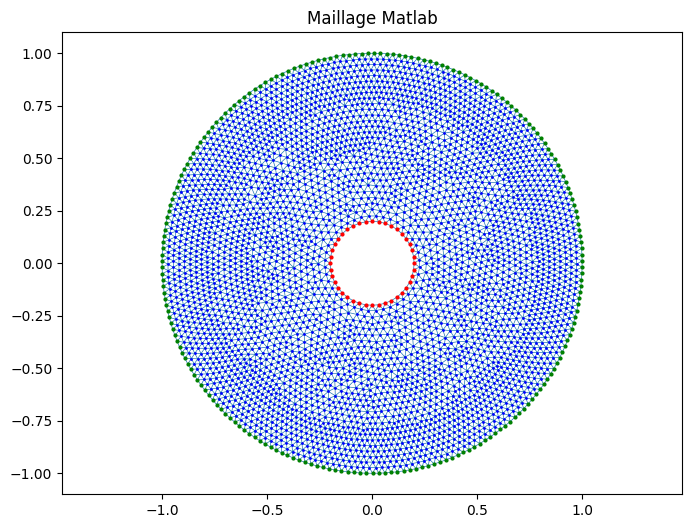

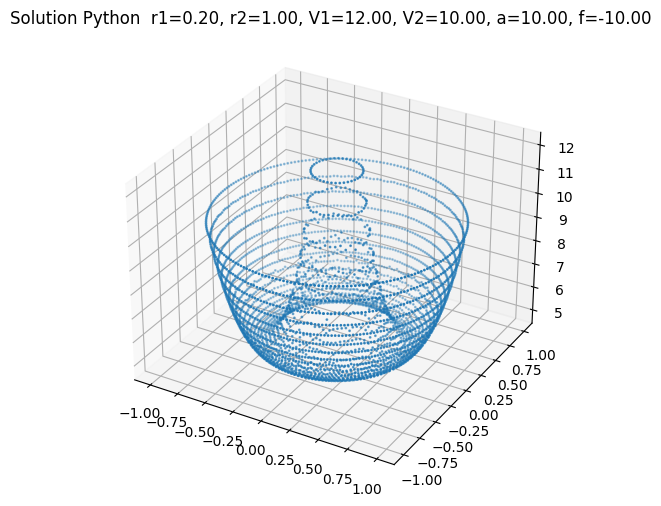

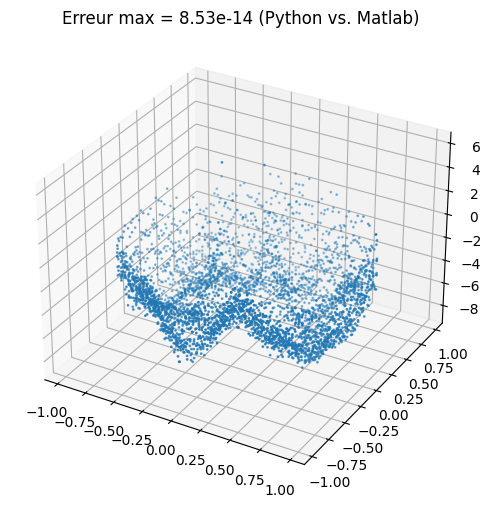

In [28]:
coaxial_matlab()

## Maillage circulaire en Python

Paramètres
r1=0.20, r2=1.00, V1=12.00, V2=10.00, a=10.00, f=-10.00
Construction du maillage
Construction des listes
Génération des matrices de masse et de rigidité
Résolution du système linéaire
Tracé de la solution


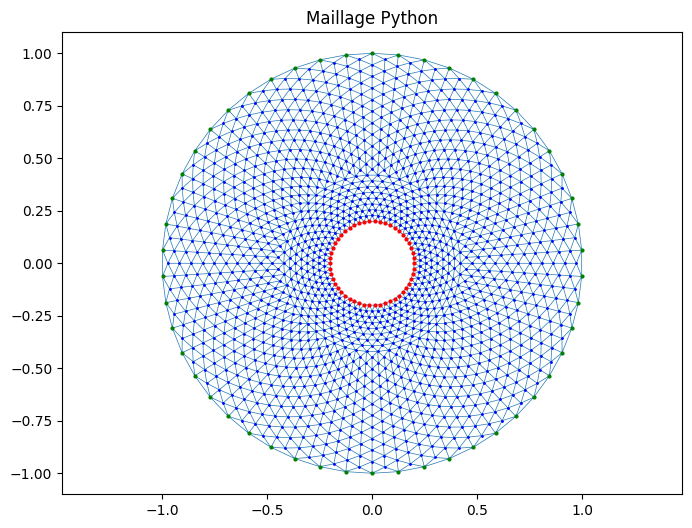

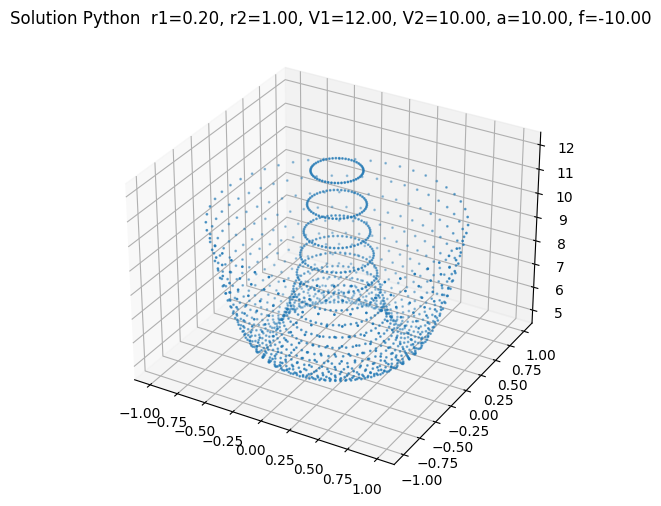

In [29]:
coaxial_circ()

## Maillage hexagonal en Python

Paramètres
r1=0.20, r2=1.00, V1=12.00, V2=10.00, a=10.00, f=-10.00
Construction du maillage
Construction des listes
Génération des matrices de masse et de rigidité
Résolution du système linéaire
Tracé de la solution


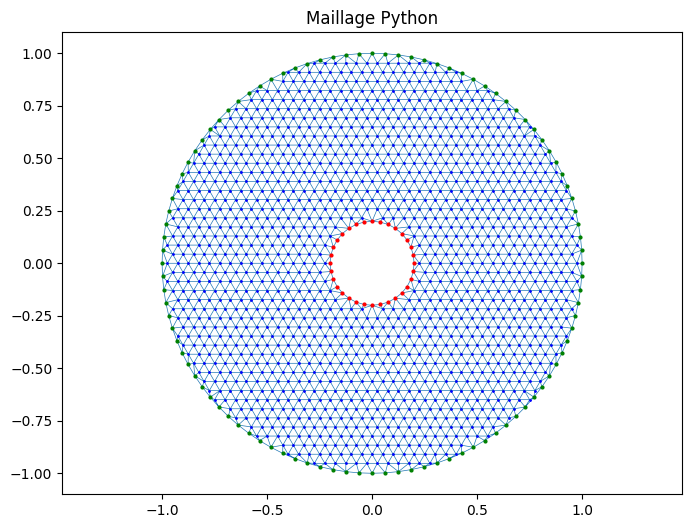

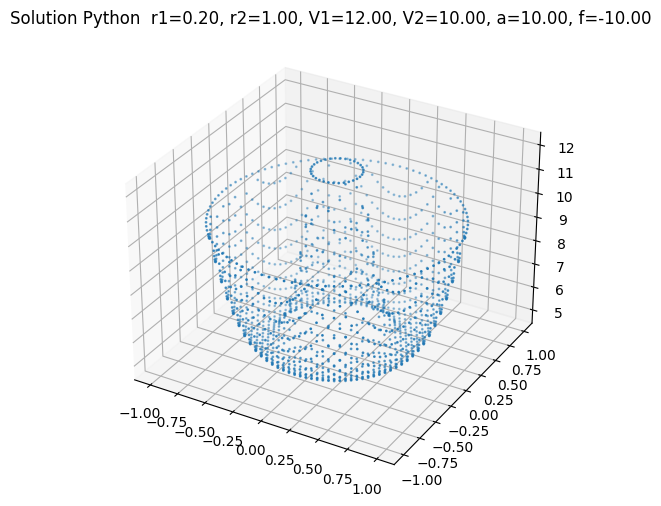

In [30]:
coaxial_hexa()